# S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
# Parameters
seed = 0


In [3]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [4]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [5]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 0, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [6]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [8]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [9]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 13, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|                             | 0/192000 [00:00<?, ?it/s]

Training for 192000 iter, 300.00 epochs:   0%|                  | 1/192000 [00:01<85:54:59,  1.61s/it]

Training for 192000 iter, 300.00 epochs:   0%|                  | 2/192000 [00:01<42:35:48,  1.25it/s]

Training for 192000 iter, 300.00 epochs:   0%|                  | 41/192000 [00:01<1:23:45, 38.19it/s]

Training for 192000 iter, 300.00 epochs:   0%| | 41/192000 [00:01<1:23:45, 38.19it/s, epoch=0.08/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 80/192000 [00:02<39:54, 80.14it/s, epoch=0.08/300.00,

Training for 192000 iter, 300.00 epochs:   0%| | 80/192000 [00:02<39:54, 80.14it/s, epoch=0.16/300.00,

Training for 192000 iter, 300.00 epochs:   0%| | 106/192000 [00:02<30:22, 105.30it/s, epoch=0.16/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 135/192000 [00:02<23:24, 136.65it/s, epoch=0.16/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 135/192000 [00:02<23:24, 136.65it/s, epoch=0.23/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 174/192000 [00:02<17:15, 185.23it/s, epoch=0.23/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 174/192000 [00:02<17:15, 185.23it/s, epoch=0.31/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 205/192000 [00:02<15:08, 211.13it/s, epoch=0.31/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 245/192000 [00:02<12:31, 255.20it/s, epoch=0.31/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 245/192000 [00:02<12:31, 255.20it/s, epoch=0.39/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 285/192000 [00:02<11:01, 289.96it/s, epoch=0.39/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 285/192000 [00:02<11:01, 289.96it/s, epoch=0.47/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 322/192000 [00:02<10:18, 309.68it/s, epoch=0.47/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 322/192000 [00:02<10:18, 309.68it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 358/192000 [00:02<09:56, 321.14it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 399/192000 [00:02<09:14, 345.48it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 399/192000 [00:02<09:14, 345.48it/s, epoch=0.62/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 436/192000 [00:03<09:56, 321.14it/s, epoch=0.62/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 436/192000 [00:03<09:56, 321.14it/s, epoch=0.70/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 475/192000 [00:03<09:25, 338.93it/s, epoch=0.70/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 475/192000 [00:03<09:25, 338.93it/s, epoch=0.78/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 511/192000 [00:03<09:23, 339.87it/s, epoch=0.78/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 511/192000 [00:03<09:23, 339.87it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 550/192000 [00:03<09:02, 352.84it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 590/192000 [00:03<08:43, 365.95it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 590/192000 [00:03<08:43, 365.95it/s, epoch=0.94/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 631/192000 [00:03<08:26, 377.99it/s, epoch=0.94/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 631/192000 [00:03<08:26, 377.99it/s, epoch=1.02/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 670/192000 [00:03<08:38, 368.67it/s, epoch=1.02/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 670/192000 [00:03<08:38, 368.67it/s, epoch=1.09/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 712/192000 [00:03<08:21, 381.09it/s, epoch=1.09/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 712/192000 [00:03<08:21, 381.09it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 753/192000 [00:03<08:13, 387.61it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 792/192000 [00:04<08:34, 371.75it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 792/192000 [00:04<08:34, 371.75it/s, epoch=1.25/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 830/192000 [00:04<08:36, 370.08it/s, epoch=1.25/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 830/192000 [00:04<08:36, 370.08it/s, epoch=1.33/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 871/192000 [00:04<08:24, 378.98it/s, epoch=1.33/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 871/192000 [00:04<08:24, 378.98it/s, epoch=1.41/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 912/192000 [00:04<08:15, 385.68it/s, epoch=1.41/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 912/192000 [00:04<08:15, 385.68it/s, epoch=1.48/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 951/192000 [00:04<09:20, 340.81it/s, epoch=1.48/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 987/192000 [00:04<10:28, 304.02it/s, epoch=1.48/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 987/192000 [00:04<10:28, 304.02it/s, epoch=1.56/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 1021/192000 [00:04<10:13, 311.22it/s, epoch=1.56/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1021/192000 [00:04<10:13, 311.22it/s, epoch=1.64/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1062/192000 [00:04<09:28, 335.73it/s, epoch=1.64/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1062/192000 [00:04<09:28, 335.73it/s, epoch=1.72/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1103/192000 [00:04<08:57, 355.40it/s, epoch=1.72/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1144/192000 [00:05<08:35, 370.47it/s, epoch=1.72/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1144/192000 [00:05<08:35, 370.47it/s, epoch=1.80/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1182/192000 [00:05<08:35, 370.49it/s, epoch=1.80/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1182/192000 [00:05<08:35, 370.49it/s, epoch=1.88/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1223/192000 [00:05<08:21, 380.74it/s, epoch=1.88/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1223/192000 [00:05<08:21, 380.74it/s, epoch=1.95/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1262/192000 [00:05<08:21, 380.63it/s, epoch=1.95/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1262/192000 [00:05<08:21, 380.63it/s, epoch=2.03/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1301/192000 [00:05<08:28, 375.00it/s, epoch=2.03/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1340/192000 [00:05<08:24, 377.80it/s, epoch=2.03/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1340/192000 [00:05<08:24, 377.80it/s, epoch=2.11/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1379/192000 [00:05<08:20, 380.86it/s, epoch=2.11/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1379/192000 [00:05<08:20, 380.86it/s, epoch=2.19/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1418/192000 [00:05<08:22, 379.43it/s, epoch=2.19/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1418/192000 [00:05<08:22, 379.43it/s, epoch=2.27/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1457/192000 [00:05<08:26, 376.30it/s, epoch=2.27/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1498/192000 [00:05<08:13, 385.71it/s, epoch=2.27/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1498/192000 [00:05<08:13, 385.71it/s, epoch=2.34/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1538/192000 [00:06<08:09, 388.95it/s, epoch=2.34/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1538/192000 [00:06<08:09, 388.95it/s, epoch=2.42/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1578/192000 [00:06<08:06, 391.26it/s, epoch=2.42/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1578/192000 [00:06<08:06, 391.26it/s, epoch=2.50/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1618/192000 [00:06<08:10, 387.98it/s, epoch=2.50/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1618/192000 [00:06<08:10, 387.98it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1657/192000 [00:06<08:33, 370.99it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1695/192000 [00:06<08:33, 370.30it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1695/192000 [00:06<08:33, 370.30it/s, epoch=2.66/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1735/192000 [00:06<08:25, 376.33it/s, epoch=2.66/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1735/192000 [00:06<08:25, 376.33it/s, epoch=2.73/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1776/192000 [00:06<08:13, 385.29it/s, epoch=2.73/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1776/192000 [00:06<08:13, 385.29it/s, epoch=2.81/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1815/192000 [00:06<08:13, 385.33it/s, epoch=2.81/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1815/192000 [00:06<08:13, 385.33it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1856/192000 [00:06<08:05, 392.04it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1896/192000 [00:07<08:06, 390.75it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1896/192000 [00:07<08:06, 390.75it/s, epoch=2.97/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1936/192000 [00:07<08:27, 374.84it/s, epoch=2.97/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1936/192000 [00:07<08:27, 374.84it/s, epoch=3.05/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1976/192000 [00:07<08:17, 381.96it/s, epoch=3.05/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1976/192000 [00:07<08:17, 381.96it/s, epoch=3.12/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2016/192000 [00:07<08:11, 386.54it/s, epoch=3.12/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2016/192000 [00:07<08:11, 386.54it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2057/192000 [00:07<08:06, 390.63it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2098/192000 [00:07<08:01, 394.65it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2098/192000 [00:07<08:01, 394.65it/s, epoch=3.28/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2139/192000 [00:07<07:57, 397.89it/s, epoch=3.28/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2139/192000 [00:07<07:57, 397.89it/s, epoch=3.36/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2179/192000 [00:07<08:37, 367.10it/s, epoch=3.36/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2179/192000 [00:07<08:37, 367.10it/s, epoch=3.44/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2219/192000 [00:07<08:25, 375.72it/s, epoch=3.44/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2219/192000 [00:07<08:25, 375.72it/s, epoch=3.52/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2260/192000 [00:07<08:15, 383.29it/s, epoch=3.52/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2260/192000 [00:08<08:15, 383.29it/s, epoch=3.59/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2300/192000 [00:08<08:11, 385.59it/s, epoch=3.59/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2341/192000 [00:08<08:05, 391.00it/s, epoch=3.59/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2341/192000 [00:08<08:05, 391.00it/s, epoch=3.67/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2382/192000 [00:08<07:58, 395.89it/s, epoch=3.67/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2382/192000 [00:08<07:58, 395.89it/s, epoch=3.75/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2422/192000 [00:08<08:39, 365.20it/s, epoch=3.75/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2422/192000 [00:08<08:39, 365.20it/s, epoch=3.83/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2463/192000 [00:08<08:22, 377.15it/s, epoch=3.83/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2463/192000 [00:08<08:22, 377.15it/s, epoch=3.91/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2504/192000 [00:08<08:11, 385.67it/s, epoch=3.91/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2545/192000 [00:08<08:04, 390.84it/s, epoch=3.91/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2545/192000 [00:08<08:04, 390.84it/s, epoch=3.98/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2585/192000 [00:08<08:48, 358.28it/s, epoch=3.98/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2585/192000 [00:08<08:48, 358.28it/s, epoch=4.06/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2622/192000 [00:08<08:56, 352.88it/s, epoch=4.06/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2622/192000 [00:09<08:56, 352.88it/s, epoch=4.14/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2662/192000 [00:09<08:41, 362.78it/s, epoch=4.14/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2699/192000 [00:09<08:39, 364.33it/s, epoch=4.14/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2699/192000 [00:09<08:39, 364.33it/s, epoch=4.22/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2739/192000 [00:09<08:25, 374.40it/s, epoch=4.22/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2739/192000 [00:09<08:25, 374.40it/s, epoch=4.30/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2779/192000 [00:09<08:17, 380.08it/s, epoch=4.30/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2779/192000 [00:09<08:17, 380.08it/s, epoch=4.38/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2818/192000 [00:09<08:14, 382.80it/s, epoch=4.38/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2818/192000 [00:09<08:14, 382.80it/s, epoch=4.45/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2857/192000 [00:09<08:15, 381.85it/s, epoch=4.45/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2897/192000 [00:09<08:08, 386.87it/s, epoch=4.45/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2897/192000 [00:09<08:08, 386.87it/s, epoch=4.53/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2936/192000 [00:09<08:07, 387.47it/s, epoch=4.53/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2936/192000 [00:09<08:07, 387.47it/s, epoch=4.61/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2976/192000 [00:09<08:04, 390.27it/s, epoch=4.61/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2976/192000 [00:09<08:04, 390.27it/s, epoch=4.69/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3017/192000 [00:09<07:58, 394.58it/s, epoch=4.69/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3017/192000 [00:10<07:58, 394.58it/s, epoch=4.77/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3058/192000 [00:10<07:54, 397.91it/s, epoch=4.77/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3099/192000 [00:10<07:53, 399.08it/s, epoch=4.77/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3099/192000 [00:10<07:53, 399.08it/s, epoch=4.84/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3140/192000 [00:10<07:52, 399.38it/s, epoch=4.84/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3140/192000 [00:10<07:52, 399.38it/s, epoch=4.92/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3180/192000 [00:10<07:56, 395.87it/s, epoch=4.92/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3180/192000 [00:10<07:56, 395.87it/s, epoch=5.00/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3220/192000 [00:10<08:16, 380.38it/s, epoch=5.00/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3220/192000 [00:10<08:16, 380.38it/s, epoch=5.08/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3259/192000 [00:10<08:22, 375.79it/s, epoch=5.08/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3297/192000 [00:10<08:38, 363.95it/s, epoch=5.08/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3297/192000 [00:10<08:38, 363.95it/s, epoch=5.16/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3336/192000 [00:10<08:30, 369.43it/s, epoch=5.16/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3336/192000 [00:10<08:30, 369.43it/s, epoch=5.23/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3376/192000 [00:10<08:21, 376.36it/s, epoch=5.23/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3376/192000 [00:10<08:21, 376.36it/s, epoch=5.31/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3416/192000 [00:11<08:13, 382.13it/s, epoch=5.31/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3416/192000 [00:11<08:13, 382.13it/s, epoch=5.39/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3455/192000 [00:11<08:12, 382.92it/s, epoch=5.39/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3495/192000 [00:11<08:06, 387.71it/s, epoch=5.39/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3495/192000 [00:11<08:06, 387.71it/s, epoch=5.47/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3535/192000 [00:11<08:02, 390.79it/s, epoch=5.47/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3535/192000 [00:11<08:02, 390.79it/s, epoch=5.55/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3576/192000 [00:11<07:57, 394.23it/s, epoch=5.55/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3576/192000 [00:11<07:57, 394.23it/s, epoch=5.62/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3617/192000 [00:11<07:54, 396.92it/s, epoch=5.62/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3617/192000 [00:11<07:54, 396.92it/s, epoch=5.70/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3657/192000 [00:11<07:55, 396.22it/s, epoch=5.70/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3697/192000 [00:11<07:55, 396.25it/s, epoch=5.70/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3697/192000 [00:11<07:55, 396.25it/s, epoch=5.78/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3738/192000 [00:11<07:52, 398.73it/s, epoch=5.78/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3738/192000 [00:11<07:52, 398.73it/s, epoch=5.86/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3779/192000 [00:11<07:50, 400.39it/s, epoch=5.86/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3779/192000 [00:11<07:50, 400.39it/s, epoch=5.94/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3820/192000 [00:12<07:47, 402.16it/s, epoch=5.94/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3820/192000 [00:12<07:47, 402.16it/s, epoch=6.02/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3861/192000 [00:12<08:04, 388.37it/s, epoch=6.02/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3861/192000 [00:12<08:04, 388.37it/s, epoch=6.09/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3900/192000 [00:12<08:08, 385.31it/s, epoch=6.09/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3940/192000 [00:12<08:04, 387.79it/s, epoch=6.09/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3940/192000 [00:12<08:04, 387.79it/s, epoch=6.17/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3979/192000 [00:12<08:04, 388.34it/s, epoch=6.17/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3979/192000 [00:12<08:04, 388.34it/s, epoch=6.25/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4018/192000 [00:12<08:05, 387.40it/s, epoch=6.25/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4018/192000 [00:12<08:05, 387.40it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4058/192000 [00:12<08:03, 388.86it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4098/192000 [00:12<08:00, 390.79it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4098/192000 [00:12<08:00, 390.79it/s, epoch=6.41/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4138/192000 [00:12<08:02, 389.19it/s, epoch=6.41/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4138/192000 [00:12<08:02, 389.19it/s, epoch=6.48/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4178/192000 [00:12<07:58, 392.31it/s, epoch=6.48/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4178/192000 [00:12<07:58, 392.31it/s, epoch=6.56/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4218/192000 [00:13<07:58, 392.69it/s, epoch=6.56/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4218/192000 [00:13<07:58, 392.69it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4258/192000 [00:13<07:56, 393.62it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4298/192000 [00:13<07:55, 394.50it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4298/192000 [00:13<07:55, 394.50it/s, epoch=6.72/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4338/192000 [00:13<07:54, 395.44it/s, epoch=6.72/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4338/192000 [00:13<07:54, 395.44it/s, epoch=6.80/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4378/192000 [00:13<07:53, 396.20it/s, epoch=6.80/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4378/192000 [00:13<07:53, 396.20it/s, epoch=6.88/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4418/192000 [00:13<07:54, 394.95it/s, epoch=6.88/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4418/192000 [00:13<07:54, 394.95it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4458/192000 [00:13<08:06, 385.70it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4497/192000 [00:13<08:42, 358.83it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4497/192000 [00:13<08:42, 358.83it/s, epoch=7.03/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4535/192000 [00:13<08:35, 363.83it/s, epoch=7.03/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4535/192000 [00:13<08:35, 363.83it/s, epoch=7.11/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4572/192000 [00:13<08:32, 365.39it/s, epoch=7.11/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4572/192000 [00:14<08:32, 365.39it/s, epoch=7.19/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4612/192000 [00:14<08:19, 375.03it/s, epoch=7.19/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4612/192000 [00:14<08:19, 375.03it/s, epoch=7.27/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4651/192000 [00:14<08:15, 378.44it/s, epoch=7.27/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4692/192000 [00:14<08:04, 386.52it/s, epoch=7.27/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4692/192000 [00:14<08:04, 386.52it/s, epoch=7.34/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4733/192000 [00:14<07:58, 391.69it/s, epoch=7.34/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4733/192000 [00:14<07:58, 391.69it/s, epoch=7.42/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4773/192000 [00:14<08:09, 382.82it/s, epoch=7.42/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4773/192000 [00:14<08:09, 382.82it/s, epoch=7.50/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4812/192000 [00:14<08:13, 378.98it/s, epoch=7.50/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4812/192000 [00:14<08:13, 378.98it/s, epoch=7.58/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4853/192000 [00:14<08:03, 387.17it/s, epoch=7.58/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4892/192000 [00:14<08:07, 383.94it/s, epoch=7.58/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4892/192000 [00:14<08:07, 383.94it/s, epoch=7.66/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4931/192000 [00:14<08:58, 347.43it/s, epoch=7.66/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4931/192000 [00:14<08:58, 347.43it/s, epoch=7.73/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4970/192000 [00:15<08:41, 358.49it/s, epoch=7.73/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4970/192000 [00:15<08:41, 358.49it/s, epoch=7.81/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5011/192000 [00:15<08:22, 372.27it/s, epoch=7.81/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5011/192000 [00:15<08:22, 372.27it/s, epoch=7.89/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5050/192000 [00:15<08:17, 375.69it/s, epoch=7.89/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5088/192000 [00:15<08:45, 355.35it/s, epoch=7.89/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5088/192000 [00:15<08:45, 355.35it/s, epoch=7.97/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5124/192000 [00:15<08:52, 351.21it/s, epoch=7.97/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5124/192000 [00:15<08:52, 351.21it/s, epoch=8.05/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5160/192000 [00:15<10:19, 301.74it/s, epoch=8.05/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5192/192000 [00:15<10:45, 289.39it/s, epoch=8.05/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5192/192000 [00:15<10:45, 289.39it/s, epoch=8.12/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5233/192000 [00:15<09:45, 319.20it/s, epoch=8.12/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5233/192000 [00:15<09:45, 319.20it/s, epoch=8.20/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5270/192000 [00:15<09:22, 332.19it/s, epoch=8.20/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5270/192000 [00:16<09:22, 332.19it/s, epoch=8.28/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5311/192000 [00:16<08:51, 351.35it/s, epoch=8.28/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5347/192000 [00:16<09:03, 343.72it/s, epoch=8.28/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5347/192000 [00:16<09:03, 343.72it/s, epoch=8.36/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5385/192000 [00:16<08:48, 352.81it/s, epoch=8.36/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5385/192000 [00:16<08:48, 352.81it/s, epoch=8.44/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5422/192000 [00:16<08:43, 356.39it/s, epoch=8.44/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5422/192000 [00:16<08:43, 356.39it/s, epoch=8.52/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5462/192000 [00:16<08:26, 368.37it/s, epoch=8.52/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5462/192000 [00:16<08:26, 368.37it/s, epoch=8.59/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5502/192000 [00:16<08:14, 377.31it/s, epoch=8.59/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5542/192000 [00:16<08:08, 381.52it/s, epoch=8.59/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5542/192000 [00:16<08:08, 381.52it/s, epoch=8.67/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5581/192000 [00:16<08:16, 375.48it/s, epoch=8.67/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5581/192000 [00:16<08:16, 375.48it/s, epoch=8.75/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5621/192000 [00:16<08:08, 381.64it/s, epoch=8.75/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5621/192000 [00:16<08:08, 381.64it/s, epoch=8.83/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5661/192000 [00:16<08:02, 386.26it/s, epoch=8.83/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5661/192000 [00:17<08:02, 386.26it/s, epoch=8.91/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5700/192000 [00:17<08:15, 375.77it/s, epoch=8.91/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5740/192000 [00:17<08:08, 380.90it/s, epoch=8.91/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5740/192000 [00:17<08:08, 380.90it/s, epoch=8.98/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5779/192000 [00:17<08:17, 374.31it/s, epoch=8.98/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5779/192000 [00:17<08:17, 374.31it/s, epoch=9.06/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5817/192000 [00:17<08:27, 367.00it/s, epoch=9.06/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5817/192000 [00:17<08:27, 367.00it/s, epoch=9.14/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5858/192000 [00:17<08:11, 378.65it/s, epoch=9.14/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5896/192000 [00:17<08:17, 374.15it/s, epoch=9.14/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5896/192000 [00:17<08:17, 374.15it/s, epoch=9.22/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5935/192000 [00:17<08:14, 376.28it/s, epoch=9.22/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5935/192000 [00:17<08:14, 376.28it/s, epoch=9.30/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5975/192000 [00:17<08:07, 381.33it/s, epoch=9.30/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5975/192000 [00:17<08:07, 381.33it/s, epoch=9.38/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6016/192000 [00:17<07:59, 387.57it/s, epoch=9.38/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6016/192000 [00:18<07:59, 387.57it/s, epoch=9.45/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6057/192000 [00:18<07:55, 390.74it/s, epoch=9.45/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6097/192000 [00:18<07:53, 392.68it/s, epoch=9.45/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6097/192000 [00:18<07:53, 392.68it/s, epoch=9.53/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6138/192000 [00:18<07:50, 395.19it/s, epoch=9.53/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6138/192000 [00:18<07:50, 395.19it/s, epoch=9.61/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6179/192000 [00:18<07:47, 397.57it/s, epoch=9.61/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6179/192000 [00:18<07:47, 397.57it/s, epoch=9.69/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6220/192000 [00:18<07:45, 399.10it/s, epoch=9.69/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6220/192000 [00:18<07:45, 399.10it/s, epoch=9.77/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6260/192000 [00:18<07:48, 396.25it/s, epoch=9.77/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6260/192000 [00:18<07:48, 396.25it/s, epoch=9.84/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6301/192000 [00:18<07:45, 399.00it/s, epoch=9.84/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6341/192000 [00:18<07:47, 397.33it/s, epoch=9.84/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6341/192000 [00:18<07:47, 397.33it/s, epoch=9.92/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6381/192000 [00:18<07:50, 394.12it/s, epoch=9.92/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6381/192000 [00:18<07:50, 394.12it/s, epoch=10.00/300

Training for 192000 iter, 300.00 epochs:   3%| | 6421/192000 [00:18<08:05, 382.30it/s, epoch=10.00/300

Training for 192000 iter, 300.00 epochs:   3%| | 6421/192000 [00:19<08:05, 382.30it/s, epoch=10.08/300

Training for 192000 iter, 300.00 epochs:   3%| | 6461/192000 [00:19<08:01, 385.16it/s, epoch=10.08/300

Training for 192000 iter, 300.00 epochs:   3%| | 6461/192000 [00:19<08:01, 385.16it/s, epoch=10.16/300

Training for 192000 iter, 300.00 epochs:   3%| | 6501/192000 [00:19<07:57, 388.09it/s, epoch=10.16/300

Training for 192000 iter, 300.00 epochs:   3%| | 6540/192000 [00:19<08:01, 385.39it/s, epoch=10.16/300

Training for 192000 iter, 300.00 epochs:   3%| | 6540/192000 [00:19<08:01, 385.39it/s, epoch=10.23/300

Training for 192000 iter, 300.00 epochs:   3%| | 6579/192000 [00:19<08:01, 384.69it/s, epoch=10.23/300

Training for 192000 iter, 300.00 epochs:   3%| | 6579/192000 [00:19<08:01, 384.69it/s, epoch=10.31/300

Training for 192000 iter, 300.00 epochs:   3%| | 6619/192000 [00:19<07:56, 388.69it/s, epoch=10.31/300

Training for 192000 iter, 300.00 epochs:   3%| | 6619/192000 [00:19<07:56, 388.69it/s, epoch=10.39/300

Training for 192000 iter, 300.00 epochs:   3%| | 6659/192000 [00:19<07:54, 390.44it/s, epoch=10.39/300

Training for 192000 iter, 300.00 epochs:   3%| | 6699/192000 [00:19<07:54, 390.76it/s, epoch=10.39/300

Training for 192000 iter, 300.00 epochs:   3%| | 6699/192000 [00:19<07:54, 390.76it/s, epoch=10.47/300

Training for 192000 iter, 300.00 epochs:   4%| | 6739/192000 [00:19<08:02, 384.09it/s, epoch=10.47/300

Training for 192000 iter, 300.00 epochs:   4%| | 6739/192000 [00:19<08:02, 384.09it/s, epoch=10.55/300

Training for 192000 iter, 300.00 epochs:   4%| | 6778/192000 [00:19<08:35, 359.42it/s, epoch=10.55/300

Training for 192000 iter, 300.00 epochs:   4%| | 6778/192000 [00:19<08:35, 359.42it/s, epoch=10.62/300

Training for 192000 iter, 300.00 epochs:   4%| | 6817/192000 [00:20<08:24, 367.39it/s, epoch=10.62/300

Training for 192000 iter, 300.00 epochs:   4%| | 6817/192000 [00:20<08:24, 367.39it/s, epoch=10.70/300

Training for 192000 iter, 300.00 epochs:   4%| | 6858/192000 [00:20<08:10, 377.13it/s, epoch=10.70/300

Training for 192000 iter, 300.00 epochs:   4%| | 6899/192000 [00:20<08:00, 385.48it/s, epoch=10.70/300

Training for 192000 iter, 300.00 epochs:   4%| | 6899/192000 [00:20<08:00, 385.48it/s, epoch=10.78/300

Training for 192000 iter, 300.00 epochs:   4%| | 6938/192000 [00:20<07:58, 386.61it/s, epoch=10.78/300

Training for 192000 iter, 300.00 epochs:   4%| | 6938/192000 [00:20<07:58, 386.61it/s, epoch=10.86/300

Training for 192000 iter, 300.00 epochs:   4%| | 6979/192000 [00:20<07:53, 390.68it/s, epoch=10.86/300

Training for 192000 iter, 300.00 epochs:   4%| | 6979/192000 [00:20<07:53, 390.68it/s, epoch=10.94/300

Training for 192000 iter, 300.00 epochs:   4%| | 7019/192000 [00:20<07:57, 387.05it/s, epoch=10.94/300

Training for 192000 iter, 300.00 epochs:   4%| | 7019/192000 [00:20<07:57, 387.05it/s, epoch=11.02/300

Training for 192000 iter, 300.00 epochs:   4%| | 7058/192000 [00:20<08:30, 362.14it/s, epoch=11.02/300

Training for 192000 iter, 300.00 epochs:   4%| | 7097/192000 [00:20<08:21, 368.75it/s, epoch=11.02/300

Training for 192000 iter, 300.00 epochs:   4%| | 7097/192000 [00:20<08:21, 368.75it/s, epoch=11.09/300

Training for 192000 iter, 300.00 epochs:   4%| | 7138/192000 [00:20<08:07, 378.89it/s, epoch=11.09/300

Training for 192000 iter, 300.00 epochs:   4%| | 7138/192000 [00:20<08:07, 378.89it/s, epoch=11.17/300

Training for 192000 iter, 300.00 epochs:   4%| | 7179/192000 [00:20<07:58, 386.46it/s, epoch=11.17/300

Training for 192000 iter, 300.00 epochs:   4%| | 7179/192000 [00:20<07:58, 386.46it/s, epoch=11.25/300

Training for 192000 iter, 300.00 epochs:   4%| | 7219/192000 [00:21<07:54, 389.74it/s, epoch=11.25/300

Training for 192000 iter, 300.00 epochs:   4%| | 7219/192000 [00:21<07:54, 389.74it/s, epoch=11.33/300

Training for 192000 iter, 300.00 epochs:   4%| | 7259/192000 [00:21<07:54, 389.26it/s, epoch=11.33/300

Training for 192000 iter, 300.00 epochs:   4%| | 7259/192000 [00:21<07:54, 389.26it/s, epoch=11.41/300

Training for 192000 iter, 300.00 epochs:   4%| | 7300/192000 [00:21<07:51, 391.46it/s, epoch=11.41/300

Training for 192000 iter, 300.00 epochs:   4%| | 7340/192000 [00:21<08:08, 377.71it/s, epoch=11.41/300

Training for 192000 iter, 300.00 epochs:   4%| | 7340/192000 [00:21<08:08, 377.71it/s, epoch=11.48/300

Training for 192000 iter, 300.00 epochs:   4%| | 7381/192000 [00:21<07:59, 384.75it/s, epoch=11.48/300

Training for 192000 iter, 300.00 epochs:   4%| | 7381/192000 [00:21<07:59, 384.75it/s, epoch=11.56/300

Training for 192000 iter, 300.00 epochs:   4%| | 7422/192000 [00:21<07:52, 390.68it/s, epoch=11.56/300

Training for 192000 iter, 300.00 epochs:   4%| | 7422/192000 [00:21<07:52, 390.68it/s, epoch=11.64/300

Training for 192000 iter, 300.00 epochs:   4%| | 7463/192000 [00:21<07:46, 395.45it/s, epoch=11.64/300

Training for 192000 iter, 300.00 epochs:   4%| | 7463/192000 [00:21<07:46, 395.45it/s, epoch=11.72/300

Training for 192000 iter, 300.00 epochs:   4%| | 7503/192000 [00:21<07:46, 395.46it/s, epoch=11.72/300

Training for 192000 iter, 300.00 epochs:   4%| | 7543/192000 [00:21<07:54, 388.58it/s, epoch=11.72/300

Training for 192000 iter, 300.00 epochs:   4%| | 7543/192000 [00:21<07:54, 388.58it/s, epoch=11.80/300

Training for 192000 iter, 300.00 epochs:   4%| | 7582/192000 [00:21<08:00, 383.75it/s, epoch=11.80/300

Training for 192000 iter, 300.00 epochs:   4%| | 7582/192000 [00:22<08:00, 383.75it/s, epoch=11.88/300

Training for 192000 iter, 300.00 epochs:   4%| | 7622/192000 [00:22<07:54, 388.31it/s, epoch=11.88/300

Training for 192000 iter, 300.00 epochs:   4%| | 7622/192000 [00:22<07:54, 388.31it/s, epoch=11.95/300

Training for 192000 iter, 300.00 epochs:   4%| | 7663/192000 [00:22<07:49, 393.04it/s, epoch=11.95/300

Training for 192000 iter, 300.00 epochs:   4%| | 7663/192000 [00:22<07:49, 393.04it/s, epoch=12.03/300

Training for 192000 iter, 300.00 epochs:   4%| | 7703/192000 [00:22<08:29, 361.77it/s, epoch=12.03/300

Training for 192000 iter, 300.00 epochs:   4%| | 7740/192000 [00:22<08:39, 354.67it/s, epoch=12.03/300

Training for 192000 iter, 300.00 epochs:   4%| | 7740/192000 [00:22<08:39, 354.67it/s, epoch=12.11/300

Training for 192000 iter, 300.00 epochs:   4%| | 7780/192000 [00:22<08:21, 367.28it/s, epoch=12.11/300

Training for 192000 iter, 300.00 epochs:   4%| | 7780/192000 [00:22<08:21, 367.28it/s, epoch=12.19/300

Training for 192000 iter, 300.00 epochs:   4%| | 7818/192000 [00:22<08:17, 370.47it/s, epoch=12.19/300

Training for 192000 iter, 300.00 epochs:   4%| | 7818/192000 [00:22<08:17, 370.47it/s, epoch=12.27/300

Training for 192000 iter, 300.00 epochs:   4%| | 7856/192000 [00:22<10:22, 295.78it/s, epoch=12.27/300

Training for 192000 iter, 300.00 epochs:   4%| | 7889/192000 [00:22<12:04, 254.03it/s, epoch=12.27/300

Training for 192000 iter, 300.00 epochs:   4%| | 7889/192000 [00:23<12:04, 254.03it/s, epoch=12.34/300

Training for 192000 iter, 300.00 epochs:   4%| | 7928/192000 [00:23<10:47, 284.07it/s, epoch=12.34/300

Training for 192000 iter, 300.00 epochs:   4%| | 7928/192000 [00:23<10:47, 284.07it/s, epoch=12.42/300

Training for 192000 iter, 300.00 epochs:   4%| | 7967/192000 [00:23<09:56, 308.28it/s, epoch=12.42/300

Training for 192000 iter, 300.00 epochs:   4%| | 7967/192000 [00:23<09:56, 308.28it/s, epoch=12.50/300

Training for 192000 iter, 300.00 epochs:   4%| | 8006/192000 [00:23<09:18, 329.24it/s, epoch=12.50/300

Training for 192000 iter, 300.00 epochs:   4%| | 8047/192000 [00:23<08:45, 349.84it/s, epoch=12.50/300

Training for 192000 iter, 300.00 epochs:   4%| | 8047/192000 [00:23<08:45, 349.84it/s, epoch=12.58/300

Training for 192000 iter, 300.00 epochs:   4%| | 8088/192000 [00:23<08:22, 365.87it/s, epoch=12.58/300

Training for 192000 iter, 300.00 epochs:   4%| | 8088/192000 [00:23<08:22, 365.87it/s, epoch=12.66/300

Training for 192000 iter, 300.00 epochs:   4%| | 8129/192000 [00:23<08:07, 376.88it/s, epoch=12.66/300

Training for 192000 iter, 300.00 epochs:   4%| | 8129/192000 [00:23<08:07, 376.88it/s, epoch=12.73/300

Training for 192000 iter, 300.00 epochs:   4%| | 8169/192000 [00:23<07:59, 383.51it/s, epoch=12.73/300

Training for 192000 iter, 300.00 epochs:   4%| | 8169/192000 [00:23<07:59, 383.51it/s, epoch=12.81/300

Training for 192000 iter, 300.00 epochs:   4%| | 8209/192000 [00:23<08:17, 369.60it/s, epoch=12.81/300

Training for 192000 iter, 300.00 epochs:   4%| | 8247/192000 [00:23<08:15, 370.64it/s, epoch=12.81/300

Training for 192000 iter, 300.00 epochs:   4%| | 8247/192000 [00:23<08:15, 370.64it/s, epoch=12.89/300

Training for 192000 iter, 300.00 epochs:   4%| | 8285/192000 [00:24<08:17, 368.98it/s, epoch=12.89/300

Training for 192000 iter, 300.00 epochs:   4%| | 8285/192000 [00:24<08:17, 368.98it/s, epoch=12.97/300

Training for 192000 iter, 300.00 epochs:   4%| | 8323/192000 [00:24<08:31, 359.40it/s, epoch=12.97/300

Training for 192000 iter, 300.00 epochs:   4%| | 8323/192000 [00:24<08:31, 359.40it/s, epoch=13.05/300

Training for 192000 iter, 300.00 epochs:   4%| | 8363/192000 [00:24<08:18, 368.52it/s, epoch=13.05/300

Training for 192000 iter, 300.00 epochs:   4%| | 8363/192000 [00:24<08:18, 368.52it/s, epoch=13.12/300

Training for 192000 iter, 300.00 epochs:   4%| | 8403/192000 [00:24<08:09, 375.30it/s, epoch=13.12/300

Training for 192000 iter, 300.00 epochs:   4%| | 8444/192000 [00:24<07:56, 385.01it/s, epoch=13.12/300

Training for 192000 iter, 300.00 epochs:   4%| | 8444/192000 [00:24<07:56, 385.01it/s, epoch=13.20/300

Training for 192000 iter, 300.00 epochs:   4%| | 8485/192000 [00:24<07:49, 390.54it/s, epoch=13.20/300

Training for 192000 iter, 300.00 epochs:   4%| | 8485/192000 [00:24<07:49, 390.54it/s, epoch=13.28/300

Training for 192000 iter, 300.00 epochs:   4%| | 8526/192000 [00:24<07:45, 394.21it/s, epoch=13.28/300

Training for 192000 iter, 300.00 epochs:   4%| | 8526/192000 [00:24<07:45, 394.21it/s, epoch=13.36/300

Training for 192000 iter, 300.00 epochs:   4%| | 8566/192000 [00:24<08:04, 378.48it/s, epoch=13.36/300

Training for 192000 iter, 300.00 epochs:   4%| | 8566/192000 [00:24<08:04, 378.48it/s, epoch=13.44/300

Training for 192000 iter, 300.00 epochs:   4%| | 8605/192000 [00:24<08:05, 377.49it/s, epoch=13.44/300

Training for 192000 iter, 300.00 epochs:   5%| | 8645/192000 [00:24<08:00, 381.76it/s, epoch=13.44/300

Training for 192000 iter, 300.00 epochs:   5%| | 8645/192000 [00:24<08:00, 381.76it/s, epoch=13.52/300

Training for 192000 iter, 300.00 epochs:   5%| | 8685/192000 [00:25<07:56, 384.62it/s, epoch=13.52/300

Training for 192000 iter, 300.00 epochs:   5%| | 8685/192000 [00:25<07:56, 384.62it/s, epoch=13.59/300

Training for 192000 iter, 300.00 epochs:   5%| | 8726/192000 [00:25<07:47, 391.63it/s, epoch=13.59/300

Training for 192000 iter, 300.00 epochs:   5%| | 8726/192000 [00:25<07:47, 391.63it/s, epoch=13.67/300

Training for 192000 iter, 300.00 epochs:   5%| | 8766/192000 [00:25<07:51, 388.96it/s, epoch=13.67/300

Training for 192000 iter, 300.00 epochs:   5%| | 8766/192000 [00:25<07:51, 388.96it/s, epoch=13.75/300

Training for 192000 iter, 300.00 epochs:   5%| | 8805/192000 [00:25<07:50, 389.17it/s, epoch=13.75/300

Training for 192000 iter, 300.00 epochs:   5%| | 8846/192000 [00:25<07:44, 394.61it/s, epoch=13.75/300

Training for 192000 iter, 300.00 epochs:   5%| | 8846/192000 [00:25<07:44, 394.61it/s, epoch=13.83/300

Training for 192000 iter, 300.00 epochs:   5%| | 8887/192000 [00:25<07:40, 398.01it/s, epoch=13.83/300

Training for 192000 iter, 300.00 epochs:   5%| | 8887/192000 [00:25<07:40, 398.01it/s, epoch=13.91/300

Training for 192000 iter, 300.00 epochs:   5%| | 8927/192000 [00:25<07:39, 398.55it/s, epoch=13.91/300

Training for 192000 iter, 300.00 epochs:   5%| | 8927/192000 [00:25<07:39, 398.55it/s, epoch=13.98/300

Training for 192000 iter, 300.00 epochs:   5%| | 8967/192000 [00:25<07:55, 384.93it/s, epoch=13.98/300

Training for 192000 iter, 300.00 epochs:   5%| | 8967/192000 [00:25<07:55, 384.93it/s, epoch=14.06/300

Training for 192000 iter, 300.00 epochs:   5%| | 9006/192000 [00:25<08:23, 363.34it/s, epoch=14.06/300

Training for 192000 iter, 300.00 epochs:   5%| | 9043/192000 [00:26<09:43, 313.60it/s, epoch=14.06/300

Training for 192000 iter, 300.00 epochs:   5%| | 9043/192000 [00:26<09:43, 313.60it/s, epoch=14.14/300

Training for 192000 iter, 300.00 epochs:   5%| | 9083/192000 [00:26<09:06, 334.72it/s, epoch=14.14/300

Training for 192000 iter, 300.00 epochs:   5%| | 9083/192000 [00:26<09:06, 334.72it/s, epoch=14.22/300

Training for 192000 iter, 300.00 epochs:   5%| | 9123/192000 [00:26<08:40, 351.12it/s, epoch=14.22/300

Training for 192000 iter, 300.00 epochs:   5%| | 9123/192000 [00:26<08:40, 351.12it/s, epoch=14.30/300

Training for 192000 iter, 300.00 epochs:   5%| | 9164/192000 [00:26<08:19, 365.91it/s, epoch=14.30/300

Training for 192000 iter, 300.00 epochs:   5%| | 9164/192000 [00:26<08:19, 365.91it/s, epoch=14.38/300

Training for 192000 iter, 300.00 epochs:   5%| | 9205/192000 [00:26<08:03, 377.96it/s, epoch=14.38/300

Training for 192000 iter, 300.00 epochs:   5%| | 9246/192000 [00:26<07:52, 387.13it/s, epoch=14.38/300

Training for 192000 iter, 300.00 epochs:   5%| | 9246/192000 [00:26<07:52, 387.13it/s, epoch=14.45/300

Training for 192000 iter, 300.00 epochs:   5%| | 9287/192000 [00:26<07:46, 391.91it/s, epoch=14.45/300

Training for 192000 iter, 300.00 epochs:   5%| | 9287/192000 [00:26<07:46, 391.91it/s, epoch=14.53/300

Training for 192000 iter, 300.00 epochs:   5%| | 9327/192000 [00:26<07:49, 388.85it/s, epoch=14.53/300

Training for 192000 iter, 300.00 epochs:   5%| | 9327/192000 [00:26<07:49, 388.85it/s, epoch=14.61/300

Training for 192000 iter, 300.00 epochs:   5%| | 9367/192000 [00:26<07:46, 391.46it/s, epoch=14.61/300

Training for 192000 iter, 300.00 epochs:   5%| | 9367/192000 [00:26<07:46, 391.46it/s, epoch=14.69/300

Training for 192000 iter, 300.00 epochs:   5%| | 9407/192000 [00:26<07:43, 393.67it/s, epoch=14.69/300

Training for 192000 iter, 300.00 epochs:   5%| | 9447/192000 [00:27<07:47, 390.58it/s, epoch=14.69/300

Training for 192000 iter, 300.00 epochs:   5%| | 9447/192000 [00:27<07:47, 390.58it/s, epoch=14.77/300

Training for 192000 iter, 300.00 epochs:   5%| | 9487/192000 [00:27<07:52, 386.47it/s, epoch=14.77/300

Training for 192000 iter, 300.00 epochs:   5%| | 9487/192000 [00:27<07:52, 386.47it/s, epoch=14.84/300

Training for 192000 iter, 300.00 epochs:   5%| | 9528/192000 [00:27<07:46, 391.26it/s, epoch=14.84/300

Training for 192000 iter, 300.00 epochs:   5%| | 9528/192000 [00:27<07:46, 391.26it/s, epoch=14.92/300

Training for 192000 iter, 300.00 epochs:   5%| | 9568/192000 [00:27<07:50, 388.14it/s, epoch=14.92/300

Training for 192000 iter, 300.00 epochs:   5%| | 9568/192000 [00:27<07:50, 388.14it/s, epoch=15.00/300

Training for 192000 iter, 300.00 epochs:   5%| | 9607/192000 [00:27<08:03, 377.53it/s, epoch=15.00/300

Training for 192000 iter, 300.00 epochs:   5%| | 9647/192000 [00:27<07:57, 381.83it/s, epoch=15.00/300

Training for 192000 iter, 300.00 epochs:   5%| | 9647/192000 [00:27<07:57, 381.83it/s, epoch=15.08/300

Training for 192000 iter, 300.00 epochs:   5%| | 9686/192000 [00:27<07:58, 380.72it/s, epoch=15.08/300

Training for 192000 iter, 300.00 epochs:   5%| | 9686/192000 [00:27<07:58, 380.72it/s, epoch=15.16/300

Training for 192000 iter, 300.00 epochs:   5%| | 9726/192000 [00:27<07:51, 386.18it/s, epoch=15.16/300

Training for 192000 iter, 300.00 epochs:   5%| | 9726/192000 [00:27<07:51, 386.18it/s, epoch=15.23/300

Training for 192000 iter, 300.00 epochs:   5%| | 9765/192000 [00:27<07:58, 380.87it/s, epoch=15.23/300

Training for 192000 iter, 300.00 epochs:   5%| | 9765/192000 [00:28<07:58, 380.87it/s, epoch=15.31/300

Training for 192000 iter, 300.00 epochs:   5%| | 9804/192000 [00:28<08:10, 371.82it/s, epoch=15.31/300

Training for 192000 iter, 300.00 epochs:   5%| | 9844/192000 [00:28<08:00, 378.79it/s, epoch=15.31/300

Training for 192000 iter, 300.00 epochs:   5%| | 9844/192000 [00:28<08:00, 378.79it/s, epoch=15.39/300

Training for 192000 iter, 300.00 epochs:   5%| | 9884/192000 [00:28<07:55, 383.29it/s, epoch=15.39/300

Training for 192000 iter, 300.00 epochs:   5%| | 9884/192000 [00:28<07:55, 383.29it/s, epoch=15.47/300

Training for 192000 iter, 300.00 epochs:   5%| | 9924/192000 [00:28<07:51, 386.38it/s, epoch=15.47/300

Training for 192000 iter, 300.00 epochs:   5%| | 9924/192000 [00:28<07:51, 386.38it/s, epoch=15.55/300

Training for 192000 iter, 300.00 epochs:   5%| | 9964/192000 [00:28<07:49, 387.91it/s, epoch=15.55/300

Training for 192000 iter, 300.00 epochs:   5%| | 9964/192000 [00:28<07:49, 387.91it/s, epoch=15.62/300

Training for 192000 iter, 300.00 epochs:   5%| | 10004/192000 [00:28<07:46, 390.48it/s, epoch=15.62/30

Training for 192000 iter, 300.00 epochs:   5%| | 10044/192000 [00:28<07:54, 383.73it/s, epoch=15.62/30

Training for 192000 iter, 300.00 epochs:   5%| | 10044/192000 [00:28<07:54, 383.73it/s, epoch=15.70/30

Training for 192000 iter, 300.00 epochs:   5%| | 10083/192000 [00:28<07:54, 383.05it/s, epoch=15.70/30

Training for 192000 iter, 300.00 epochs:   5%| | 10083/192000 [00:28<07:54, 383.05it/s, epoch=15.78/30

Training for 192000 iter, 300.00 epochs:   5%| | 10123/192000 [00:28<07:50, 386.33it/s, epoch=15.78/30

Training for 192000 iter, 300.00 epochs:   5%| | 10123/192000 [00:28<07:50, 386.33it/s, epoch=15.86/30

Training for 192000 iter, 300.00 epochs:   5%| | 10163/192000 [00:28<07:49, 387.62it/s, epoch=15.86/30

Training for 192000 iter, 300.00 epochs:   5%| | 10163/192000 [00:29<07:49, 387.62it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10203/192000 [00:29<07:46, 389.88it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10243/192000 [00:29<07:56, 381.56it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10243/192000 [00:29<07:56, 381.56it/s, epoch=16.02/30

Training for 192000 iter, 300.00 epochs:   5%| | 10282/192000 [00:29<07:55, 382.45it/s, epoch=16.02/30

Training for 192000 iter, 300.00 epochs:   5%| | 10282/192000 [00:29<07:55, 382.45it/s, epoch=16.09/30

Training for 192000 iter, 300.00 epochs:   5%| | 10321/192000 [00:29<07:54, 382.80it/s, epoch=16.09/30

Training for 192000 iter, 300.00 epochs:   5%| | 10321/192000 [00:29<07:54, 382.80it/s, epoch=16.17/30

Training for 192000 iter, 300.00 epochs:   5%| | 10360/192000 [00:29<07:52, 384.66it/s, epoch=16.17/30

Training for 192000 iter, 300.00 epochs:   5%| | 10360/192000 [00:29<07:52, 384.66it/s, epoch=16.25/30

Training for 192000 iter, 300.00 epochs:   5%| | 10400/192000 [00:29<07:50, 385.61it/s, epoch=16.25/30

Training for 192000 iter, 300.00 epochs:   5%| | 10439/192000 [00:29<07:52, 383.92it/s, epoch=16.25/30

Training for 192000 iter, 300.00 epochs:   5%| | 10439/192000 [00:29<07:52, 383.92it/s, epoch=16.33/30

Training for 192000 iter, 300.00 epochs:   5%| | 10478/192000 [00:29<07:51, 385.05it/s, epoch=16.33/30

Training for 192000 iter, 300.00 epochs:   5%| | 10478/192000 [00:29<07:51, 385.05it/s, epoch=16.41/30

Training for 192000 iter, 300.00 epochs:   5%| | 10517/192000 [00:29<08:17, 365.15it/s, epoch=16.41/30

Training for 192000 iter, 300.00 epochs:   5%| | 10517/192000 [00:29<08:17, 365.15it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   5%| | 10555/192000 [00:29<08:12, 368.51it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   6%| | 10596/192000 [00:30<07:59, 378.70it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   6%| | 10596/192000 [00:30<07:59, 378.70it/s, epoch=16.56/30

Training for 192000 iter, 300.00 epochs:   6%| | 10636/192000 [00:30<07:53, 383.35it/s, epoch=16.56/30

Training for 192000 iter, 300.00 epochs:   6%| | 10636/192000 [00:30<07:53, 383.35it/s, epoch=16.64/30

Training for 192000 iter, 300.00 epochs:   6%| | 10675/192000 [00:30<07:54, 382.34it/s, epoch=16.64/30

Training for 192000 iter, 300.00 epochs:   6%| | 10675/192000 [00:30<07:54, 382.34it/s, epoch=16.72/30

Training for 192000 iter, 300.00 epochs:   6%| | 10716/192000 [00:30<07:46, 388.19it/s, epoch=16.72/30

Training for 192000 iter, 300.00 epochs:   6%| | 10716/192000 [00:30<07:46, 388.19it/s, epoch=16.80/30

Training for 192000 iter, 300.00 epochs:   6%| | 10755/192000 [00:30<07:48, 386.99it/s, epoch=16.80/30

Training for 192000 iter, 300.00 epochs:   6%| | 10796/192000 [00:30<07:42, 391.80it/s, epoch=16.80/30

Training for 192000 iter, 300.00 epochs:   6%| | 10796/192000 [00:30<07:42, 391.80it/s, epoch=16.88/30

Training for 192000 iter, 300.00 epochs:   6%| | 10836/192000 [00:30<07:43, 390.48it/s, epoch=16.88/30

Training for 192000 iter, 300.00 epochs:   6%| | 10836/192000 [00:30<07:43, 390.48it/s, epoch=16.95/30

Training for 192000 iter, 300.00 epochs:   6%| | 10876/192000 [00:30<07:40, 392.92it/s, epoch=16.95/30

Training for 192000 iter, 300.00 epochs:   6%| | 10876/192000 [00:30<07:40, 392.92it/s, epoch=17.03/30

Training for 192000 iter, 300.00 epochs:   6%| | 10916/192000 [00:30<08:25, 358.48it/s, epoch=17.03/30

Training for 192000 iter, 300.00 epochs:   6%| | 10916/192000 [00:31<08:25, 358.48it/s, epoch=17.11/30

Training for 192000 iter, 300.00 epochs:   6%| | 10955/192000 [00:31<08:14, 365.81it/s, epoch=17.11/30

Training for 192000 iter, 300.00 epochs:   6%| | 10993/192000 [00:31<08:27, 356.97it/s, epoch=17.11/30

Training for 192000 iter, 300.00 epochs:   6%| | 10993/192000 [00:31<08:27, 356.97it/s, epoch=17.19/30

Training for 192000 iter, 300.00 epochs:   6%| | 11030/192000 [00:31<08:35, 351.21it/s, epoch=17.19/30

Training for 192000 iter, 300.00 epochs:   6%| | 11030/192000 [00:31<08:35, 351.21it/s, epoch=17.27/30

Training for 192000 iter, 300.00 epochs:   6%| | 11070/192000 [00:31<08:16, 364.43it/s, epoch=17.27/30

Training for 192000 iter, 300.00 epochs:   6%| | 11070/192000 [00:31<08:16, 364.43it/s, epoch=17.34/30

Training for 192000 iter, 300.00 epochs:   6%| | 11111/192000 [00:31<08:02, 375.14it/s, epoch=17.34/30

Training for 192000 iter, 300.00 epochs:   6%| | 11111/192000 [00:31<08:02, 375.14it/s, epoch=17.42/30

Training for 192000 iter, 300.00 epochs:   6%| | 11152/192000 [00:31<07:50, 384.76it/s, epoch=17.42/30

Training for 192000 iter, 300.00 epochs:   6%| | 11193/192000 [00:31<07:41, 392.06it/s, epoch=17.42/30

Training for 192000 iter, 300.00 epochs:   6%| | 11193/192000 [00:31<07:41, 392.06it/s, epoch=17.50/30

Training for 192000 iter, 300.00 epochs:   6%| | 11233/192000 [00:31<07:44, 388.77it/s, epoch=17.50/30

Training for 192000 iter, 300.00 epochs:   6%| | 11233/192000 [00:31<07:44, 388.77it/s, epoch=17.58/30

Training for 192000 iter, 300.00 epochs:   6%| | 11272/192000 [00:31<07:47, 386.17it/s, epoch=17.58/30

Training for 192000 iter, 300.00 epochs:   6%| | 11272/192000 [00:31<07:47, 386.17it/s, epoch=17.66/30

Training for 192000 iter, 300.00 epochs:   6%| | 11311/192000 [00:31<07:51, 383.09it/s, epoch=17.66/30

Training for 192000 iter, 300.00 epochs:   6%| | 11311/192000 [00:32<07:51, 383.09it/s, epoch=17.73/30

Training for 192000 iter, 300.00 epochs:   6%| | 11352/192000 [00:32<07:44, 389.23it/s, epoch=17.73/30

Training for 192000 iter, 300.00 epochs:   6%| | 11393/192000 [00:32<07:38, 393.94it/s, epoch=17.73/30

Training for 192000 iter, 300.00 epochs:   6%| | 11393/192000 [00:32<07:38, 393.94it/s, epoch=17.81/30

Training for 192000 iter, 300.00 epochs:   6%| | 11434/192000 [00:32<07:33, 398.53it/s, epoch=17.81/30

Training for 192000 iter, 300.00 epochs:   6%| | 11434/192000 [00:32<07:33, 398.53it/s, epoch=17.89/30

Training for 192000 iter, 300.00 epochs:   6%| | 11475/192000 [00:32<07:29, 401.22it/s, epoch=17.89/30

Training for 192000 iter, 300.00 epochs:   6%| | 11475/192000 [00:32<07:29, 401.22it/s, epoch=17.97/30

Training for 192000 iter, 300.00 epochs:   6%| | 11516/192000 [00:32<07:43, 389.22it/s, epoch=17.97/30

Training for 192000 iter, 300.00 epochs:   6%| | 11516/192000 [00:32<07:43, 389.22it/s, epoch=18.05/30

Training for 192000 iter, 300.00 epochs:   6%| | 11556/192000 [00:32<08:16, 363.12it/s, epoch=18.05/30

Training for 192000 iter, 300.00 epochs:   6%| | 11593/192000 [00:32<08:58, 335.09it/s, epoch=18.05/30

Training for 192000 iter, 300.00 epochs:   6%| | 11593/192000 [00:32<08:58, 335.09it/s, epoch=18.12/30

Training for 192000 iter, 300.00 epochs:   6%| | 11628/192000 [00:32<08:52, 338.44it/s, epoch=18.12/30

Training for 192000 iter, 300.00 epochs:   6%| | 11628/192000 [00:32<08:52, 338.44it/s, epoch=18.20/30

Training for 192000 iter, 300.00 epochs:   6%| | 11663/192000 [00:32<09:15, 324.48it/s, epoch=18.20/30

Training for 192000 iter, 300.00 epochs:   6%| | 11663/192000 [00:33<09:15, 324.48it/s, epoch=18.28/30

Training for 192000 iter, 300.00 epochs:   6%| | 11701/192000 [00:33<08:53, 338.07it/s, epoch=18.28/30

Training for 192000 iter, 300.00 epochs:   6%| | 11742/192000 [00:33<08:24, 357.00it/s, epoch=18.28/30

Training for 192000 iter, 300.00 epochs:   6%| | 11742/192000 [00:33<08:24, 357.00it/s, epoch=18.36/30

Training for 192000 iter, 300.00 epochs:   6%| | 11783/192000 [00:33<08:06, 370.76it/s, epoch=18.36/30

Training for 192000 iter, 300.00 epochs:   6%| | 11783/192000 [00:33<08:06, 370.76it/s, epoch=18.44/30

Training for 192000 iter, 300.00 epochs:   6%| | 11822/192000 [00:33<07:58, 376.28it/s, epoch=18.44/30

Training for 192000 iter, 300.00 epochs:   6%| | 11822/192000 [00:33<07:58, 376.28it/s, epoch=18.52/30

Training for 192000 iter, 300.00 epochs:   6%| | 11863/192000 [00:33<07:48, 384.22it/s, epoch=18.52/30

Training for 192000 iter, 300.00 epochs:   6%| | 11863/192000 [00:33<07:48, 384.22it/s, epoch=18.59/30

Training for 192000 iter, 300.00 epochs:   6%| | 11904/192000 [00:33<07:41, 390.59it/s, epoch=18.59/30

Training for 192000 iter, 300.00 epochs:   6%| | 11945/192000 [00:33<07:34, 396.22it/s, epoch=18.59/30

Training for 192000 iter, 300.00 epochs:   6%| | 11945/192000 [00:33<07:34, 396.22it/s, epoch=18.67/30

Training for 192000 iter, 300.00 epochs:   6%| | 11985/192000 [00:33<07:37, 393.10it/s, epoch=18.67/30

Training for 192000 iter, 300.00 epochs:   6%| | 11985/192000 [00:33<07:37, 393.10it/s, epoch=18.75/30

Training for 192000 iter, 300.00 epochs:   6%| | 12025/192000 [00:33<08:39, 346.39it/s, epoch=18.75/30

Training for 192000 iter, 300.00 epochs:   6%| | 12025/192000 [00:34<08:39, 346.39it/s, epoch=18.83/30

Training for 192000 iter, 300.00 epochs:   6%| | 12061/192000 [00:34<08:56, 335.11it/s, epoch=18.83/30

Training for 192000 iter, 300.00 epochs:   6%| | 12096/192000 [00:34<09:17, 322.71it/s, epoch=18.83/30

Training for 192000 iter, 300.00 epochs:   6%| | 12096/192000 [00:34<09:17, 322.71it/s, epoch=18.91/30

Training for 192000 iter, 300.00 epochs:   6%| | 12136/192000 [00:34<08:46, 341.75it/s, epoch=18.91/30

Training for 192000 iter, 300.00 epochs:   6%| | 12136/192000 [00:34<08:46, 341.75it/s, epoch=18.98/30

Training for 192000 iter, 300.00 epochs:   6%| | 12171/192000 [00:34<08:57, 334.77it/s, epoch=18.98/30

Training for 192000 iter, 300.00 epochs:   6%| | 12171/192000 [00:34<08:57, 334.77it/s, epoch=19.06/30

Training for 192000 iter, 300.00 epochs:   6%| | 12205/192000 [00:34<09:16, 323.15it/s, epoch=19.06/30

Training for 192000 iter, 300.00 epochs:   6%| | 12242/192000 [00:34<08:59, 333.41it/s, epoch=19.06/30

Training for 192000 iter, 300.00 epochs:   6%| | 12242/192000 [00:34<08:59, 333.41it/s, epoch=19.14/30

Training for 192000 iter, 300.00 epochs:   6%| | 12282/192000 [00:34<08:30, 352.07it/s, epoch=19.14/30

Training for 192000 iter, 300.00 epochs:   6%| | 12282/192000 [00:34<08:30, 352.07it/s, epoch=19.22/30

Training for 192000 iter, 300.00 epochs:   6%| | 12323/192000 [00:34<08:09, 367.02it/s, epoch=19.22/30

Training for 192000 iter, 300.00 epochs:   6%| | 12323/192000 [00:34<08:09, 367.02it/s, epoch=19.30/30

Training for 192000 iter, 300.00 epochs:   6%| | 12364/192000 [00:34<07:55, 377.75it/s, epoch=19.30/30

Training for 192000 iter, 300.00 epochs:   6%| | 12364/192000 [00:34<07:55, 377.75it/s, epoch=19.38/30

Training for 192000 iter, 300.00 epochs:   6%| | 12404/192000 [00:35<07:47, 383.78it/s, epoch=19.38/30

Training for 192000 iter, 300.00 epochs:   6%| | 12443/192000 [00:35<07:53, 379.00it/s, epoch=19.38/30

Training for 192000 iter, 300.00 epochs:   6%| | 12443/192000 [00:35<07:53, 379.00it/s, epoch=19.45/30

Training for 192000 iter, 300.00 epochs:   7%| | 12482/192000 [00:35<08:07, 368.33it/s, epoch=19.45/30

Training for 192000 iter, 300.00 epochs:   7%| | 12482/192000 [00:35<08:07, 368.33it/s, epoch=19.53/30

Training for 192000 iter, 300.00 epochs:   7%| | 12519/192000 [00:35<08:21, 357.77it/s, epoch=19.53/30

Training for 192000 iter, 300.00 epochs:   7%| | 12519/192000 [00:35<08:21, 357.77it/s, epoch=19.61/30

Training for 192000 iter, 300.00 epochs:   7%| | 12555/192000 [00:35<08:22, 357.16it/s, epoch=19.61/30

Training for 192000 iter, 300.00 epochs:   7%| | 12596/192000 [00:35<08:04, 369.92it/s, epoch=19.61/30

Training for 192000 iter, 300.00 epochs:   7%| | 12596/192000 [00:35<08:04, 369.92it/s, epoch=19.69/30

Training for 192000 iter, 300.00 epochs:   7%| | 12637/192000 [00:35<07:51, 380.57it/s, epoch=19.69/30

Training for 192000 iter, 300.00 epochs:   7%| | 12637/192000 [00:35<07:51, 380.57it/s, epoch=19.77/30

Training for 192000 iter, 300.00 epochs:   7%| | 12676/192000 [00:35<07:49, 382.10it/s, epoch=19.77/30

Training for 192000 iter, 300.00 epochs:   7%| | 12676/192000 [00:35<07:49, 382.10it/s, epoch=19.84/30

Training for 192000 iter, 300.00 epochs:   7%| | 12715/192000 [00:35<07:51, 380.06it/s, epoch=19.84/30

Training for 192000 iter, 300.00 epochs:   7%| | 12715/192000 [00:35<07:51, 380.06it/s, epoch=19.92/30

Training for 192000 iter, 300.00 epochs:   7%| | 12756/192000 [00:35<07:43, 386.52it/s, epoch=19.92/30

Training for 192000 iter, 300.00 epochs:   7%| | 12798/192000 [00:36<07:35, 393.75it/s, epoch=19.92/30

Training for 192000 iter, 300.00 epochs:   7%| | 12798/192000 [00:36<07:35, 393.75it/s, epoch=20.00/30

Training for 192000 iter, 300.00 epochs:   7%| | 12838/192000 [00:36<08:19, 358.83it/s, epoch=20.00/30

Training for 192000 iter, 300.00 epochs:   7%| | 12838/192000 [00:36<08:19, 358.83it/s, epoch=20.08/30

Training for 192000 iter, 300.00 epochs:   7%| | 12875/192000 [00:36<08:24, 355.08it/s, epoch=20.08/30

Training for 192000 iter, 300.00 epochs:   7%| | 12875/192000 [00:36<08:24, 355.08it/s, epoch=20.16/30

Training for 192000 iter, 300.00 epochs:   7%| | 12915/192000 [00:36<08:07, 367.13it/s, epoch=20.16/30

Training for 192000 iter, 300.00 epochs:   7%| | 12915/192000 [00:36<08:07, 367.13it/s, epoch=20.23/30

Training for 192000 iter, 300.00 epochs:   7%| | 12956/192000 [00:36<07:53, 378.29it/s, epoch=20.23/30

Training for 192000 iter, 300.00 epochs:   7%| | 12995/192000 [00:36<07:51, 379.79it/s, epoch=20.23/30

Training for 192000 iter, 300.00 epochs:   7%| | 12995/192000 [00:36<07:51, 379.79it/s, epoch=20.31/30

Training for 192000 iter, 300.00 epochs:   7%| | 13034/192000 [00:36<07:48, 381.76it/s, epoch=20.31/30

Training for 192000 iter, 300.00 epochs:   7%| | 13034/192000 [00:36<07:48, 381.76it/s, epoch=20.39/30

Training for 192000 iter, 300.00 epochs:   7%| | 13075/192000 [00:36<07:40, 388.66it/s, epoch=20.39/30

Training for 192000 iter, 300.00 epochs:   7%| | 13075/192000 [00:36<07:40, 388.66it/s, epoch=20.47/30

Training for 192000 iter, 300.00 epochs:   7%| | 13115/192000 [00:36<07:37, 390.94it/s, epoch=20.47/30

Training for 192000 iter, 300.00 epochs:   7%| | 13115/192000 [00:36<07:37, 390.94it/s, epoch=20.55/30

Training for 192000 iter, 300.00 epochs:   7%| | 13155/192000 [00:37<07:48, 381.43it/s, epoch=20.55/30

Training for 192000 iter, 300.00 epochs:   7%| | 13194/192000 [00:37<07:54, 376.86it/s, epoch=20.55/30

Training for 192000 iter, 300.00 epochs:   7%| | 13194/192000 [00:37<07:54, 376.86it/s, epoch=20.62/30

Training for 192000 iter, 300.00 epochs:   7%| | 13232/192000 [00:37<07:54, 376.92it/s, epoch=20.62/30

Training for 192000 iter, 300.00 epochs:   7%| | 13232/192000 [00:37<07:54, 376.92it/s, epoch=20.70/30

Training for 192000 iter, 300.00 epochs:   7%| | 13270/192000 [00:37<07:59, 373.04it/s, epoch=20.70/30

Training for 192000 iter, 300.00 epochs:   7%| | 13270/192000 [00:37<07:59, 373.04it/s, epoch=20.78/30

Training for 192000 iter, 300.00 epochs:   7%| | 13308/192000 [00:37<08:40, 343.09it/s, epoch=20.78/30

Training for 192000 iter, 300.00 epochs:   7%| | 13343/192000 [00:37<08:43, 341.31it/s, epoch=20.78/30

Training for 192000 iter, 300.00 epochs:   7%| | 13343/192000 [00:37<08:43, 341.31it/s, epoch=20.86/30

Training for 192000 iter, 300.00 epochs:   7%| | 13384/192000 [00:37<08:17, 358.81it/s, epoch=20.86/30

Training for 192000 iter, 300.00 epochs:   7%| | 13384/192000 [00:37<08:17, 358.81it/s, epoch=20.94/30

Training for 192000 iter, 300.00 epochs:   7%| | 13423/192000 [00:37<08:06, 367.16it/s, epoch=20.94/30

Training for 192000 iter, 300.00 epochs:   7%| | 13423/192000 [00:37<08:06, 367.16it/s, epoch=21.02/30

Training for 192000 iter, 300.00 epochs:   7%| | 13460/192000 [00:37<08:11, 363.04it/s, epoch=21.02/30

Training for 192000 iter, 300.00 epochs:   7%| | 13497/192000 [00:37<08:26, 352.14it/s, epoch=21.02/30

Training for 192000 iter, 300.00 epochs:   7%| | 13497/192000 [00:37<08:26, 352.14it/s, epoch=21.09/30

Training for 192000 iter, 300.00 epochs:   7%| | 13533/192000 [00:38<08:55, 333.10it/s, epoch=21.09/30

Training for 192000 iter, 300.00 epochs:   7%| | 13533/192000 [00:38<08:55, 333.10it/s, epoch=21.17/30

Training for 192000 iter, 300.00 epochs:   7%| | 13573/192000 [00:38<08:30, 349.68it/s, epoch=21.17/30

Training for 192000 iter, 300.00 epochs:   7%| | 13573/192000 [00:38<08:30, 349.68it/s, epoch=21.25/30

Training for 192000 iter, 300.00 epochs:   7%| | 13612/192000 [00:38<08:14, 360.47it/s, epoch=21.25/30

Training for 192000 iter, 300.00 epochs:   7%| | 13612/192000 [00:38<08:14, 360.47it/s, epoch=21.33/30

Training for 192000 iter, 300.00 epochs:   7%| | 13650/192000 [00:38<08:07, 365.48it/s, epoch=21.33/30

Training for 192000 iter, 300.00 epochs:   7%| | 13687/192000 [00:38<08:12, 362.42it/s, epoch=21.33/30

Training for 192000 iter, 300.00 epochs:   7%| | 13687/192000 [00:38<08:12, 362.42it/s, epoch=21.41/30

Training for 192000 iter, 300.00 epochs:   7%| | 13728/192000 [00:38<07:56, 373.78it/s, epoch=21.41/30

Training for 192000 iter, 300.00 epochs:   7%| | 13728/192000 [00:38<07:56, 373.78it/s, epoch=21.48/30

Training for 192000 iter, 300.00 epochs:   7%| | 13766/192000 [00:38<07:57, 373.20it/s, epoch=21.48/30

Training for 192000 iter, 300.00 epochs:   7%| | 13766/192000 [00:38<07:57, 373.20it/s, epoch=21.56/30

Training for 192000 iter, 300.00 epochs:   7%| | 13807/192000 [00:38<07:46, 381.91it/s, epoch=21.56/30

Training for 192000 iter, 300.00 epochs:   7%| | 13846/192000 [00:38<07:45, 382.74it/s, epoch=21.56/30

Training for 192000 iter, 300.00 epochs:   7%| | 13846/192000 [00:38<07:45, 382.74it/s, epoch=21.64/30

Training for 192000 iter, 300.00 epochs:   7%| | 13885/192000 [00:39<07:43, 383.96it/s, epoch=21.64/30

Training for 192000 iter, 300.00 epochs:   7%| | 13885/192000 [00:39<07:43, 383.96it/s, epoch=21.72/30

Training for 192000 iter, 300.00 epochs:   7%| | 13925/192000 [00:39<07:39, 387.84it/s, epoch=21.72/30

Training for 192000 iter, 300.00 epochs:   7%| | 13925/192000 [00:39<07:39, 387.84it/s, epoch=21.80/30

Training for 192000 iter, 300.00 epochs:   7%| | 13964/192000 [00:39<07:42, 384.99it/s, epoch=21.80/30

Training for 192000 iter, 300.00 epochs:   7%| | 13964/192000 [00:39<07:42, 384.99it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14003/192000 [00:39<07:42, 385.27it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14044/192000 [00:39<07:35, 390.36it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14044/192000 [00:39<07:35, 390.36it/s, epoch=21.95/30

Training for 192000 iter, 300.00 epochs:   7%| | 14084/192000 [00:39<07:55, 373.79it/s, epoch=21.95/30

Training for 192000 iter, 300.00 epochs:   7%| | 14084/192000 [00:39<07:55, 373.79it/s, epoch=22.03/30

Training for 192000 iter, 300.00 epochs:   7%| | 14125/192000 [00:39<07:43, 383.47it/s, epoch=22.03/30

Training for 192000 iter, 300.00 epochs:   7%| | 14125/192000 [00:39<07:43, 383.47it/s, epoch=22.11/30

Training for 192000 iter, 300.00 epochs:   7%| | 14166/192000 [00:39<07:35, 390.38it/s, epoch=22.11/30

Training for 192000 iter, 300.00 epochs:   7%| | 14166/192000 [00:39<07:35, 390.38it/s, epoch=22.19/30

Training for 192000 iter, 300.00 epochs:   7%| | 14207/192000 [00:39<07:31, 394.09it/s, epoch=22.19/30

Training for 192000 iter, 300.00 epochs:   7%| | 14247/192000 [00:39<07:30, 394.32it/s, epoch=22.19/30

Training for 192000 iter, 300.00 epochs:   7%| | 14247/192000 [00:39<07:30, 394.32it/s, epoch=22.27/30

Training for 192000 iter, 300.00 epochs:   7%| | 14288/192000 [00:40<07:26, 398.38it/s, epoch=22.27/30

Training for 192000 iter, 300.00 epochs:   7%| | 14288/192000 [00:40<07:26, 398.38it/s, epoch=22.34/30

Training for 192000 iter, 300.00 epochs:   7%| | 14328/192000 [00:40<07:46, 380.60it/s, epoch=22.34/30

Training for 192000 iter, 300.00 epochs:   7%| | 14328/192000 [00:40<07:46, 380.60it/s, epoch=22.42/30

Training for 192000 iter, 300.00 epochs:   7%| | 14367/192000 [00:40<08:11, 361.68it/s, epoch=22.42/30

Training for 192000 iter, 300.00 epochs:   7%| | 14367/192000 [00:40<08:11, 361.68it/s, epoch=22.50/30

Training for 192000 iter, 300.00 epochs:   8%| | 14406/192000 [00:40<08:03, 367.42it/s, epoch=22.50/30

Training for 192000 iter, 300.00 epochs:   8%| | 14443/192000 [00:40<08:47, 336.59it/s, epoch=22.50/30

Training for 192000 iter, 300.00 epochs:   8%| | 14443/192000 [00:40<08:47, 336.59it/s, epoch=22.58/30

Training for 192000 iter, 300.00 epochs:   8%| | 14481/192000 [00:40<08:31, 347.00it/s, epoch=22.58/30

Training for 192000 iter, 300.00 epochs:   8%| | 14481/192000 [00:40<08:31, 347.00it/s, epoch=22.66/30

Training for 192000 iter, 300.00 epochs:   8%| | 14520/192000 [00:40<08:18, 356.33it/s, epoch=22.66/30

Training for 192000 iter, 300.00 epochs:   8%| | 14520/192000 [00:40<08:18, 356.33it/s, epoch=22.73/30

Training for 192000 iter, 300.00 epochs:   8%| | 14558/192000 [00:40<08:10, 361.53it/s, epoch=22.73/30

Training for 192000 iter, 300.00 epochs:   8%| | 14595/192000 [00:40<08:14, 358.58it/s, epoch=22.73/30

Training for 192000 iter, 300.00 epochs:   8%| | 14595/192000 [00:40<08:14, 358.58it/s, epoch=22.81/30

Training for 192000 iter, 300.00 epochs:   8%| | 14635/192000 [00:41<08:00, 369.06it/s, epoch=22.81/30

Training for 192000 iter, 300.00 epochs:   8%| | 14635/192000 [00:41<08:00, 369.06it/s, epoch=22.89/30

Training for 192000 iter, 300.00 epochs:   8%| | 14673/192000 [00:41<08:26, 350.26it/s, epoch=22.89/30

Training for 192000 iter, 300.00 epochs:   8%| | 14673/192000 [00:41<08:26, 350.26it/s, epoch=22.97/30

Training for 192000 iter, 300.00 epochs:   8%| | 14709/192000 [00:41<08:28, 348.47it/s, epoch=22.97/30

Training for 192000 iter, 300.00 epochs:   8%| | 14745/192000 [00:41<08:27, 349.62it/s, epoch=22.97/30

Training for 192000 iter, 300.00 epochs:   8%| | 14745/192000 [00:41<08:27, 349.62it/s, epoch=23.05/30

Training for 192000 iter, 300.00 epochs:   8%| | 14785/192000 [00:41<08:07, 363.57it/s, epoch=23.05/30

Training for 192000 iter, 300.00 epochs:   8%| | 14785/192000 [00:41<08:07, 363.57it/s, epoch=23.12/30

Training for 192000 iter, 300.00 epochs:   8%| | 14826/192000 [00:41<07:50, 376.36it/s, epoch=23.12/30

Training for 192000 iter, 300.00 epochs:   8%| | 14826/192000 [00:41<07:50, 376.36it/s, epoch=23.20/30

Training for 192000 iter, 300.00 epochs:   8%| | 14867/192000 [00:41<07:40, 384.69it/s, epoch=23.20/30

Training for 192000 iter, 300.00 epochs:   8%| | 14867/192000 [00:41<07:40, 384.69it/s, epoch=23.28/30

Training for 192000 iter, 300.00 epochs:   8%| | 14908/192000 [00:41<07:32, 391.46it/s, epoch=23.28/30

Training for 192000 iter, 300.00 epochs:   8%| | 14949/192000 [00:41<07:26, 396.58it/s, epoch=23.28/30

Training for 192000 iter, 300.00 epochs:   8%| | 14949/192000 [00:41<07:26, 396.58it/s, epoch=23.36/30

Training for 192000 iter, 300.00 epochs:   8%| | 14990/192000 [00:41<07:25, 397.74it/s, epoch=23.36/30

Training for 192000 iter, 300.00 epochs:   8%| | 14990/192000 [00:41<07:25, 397.74it/s, epoch=23.44/30

Training for 192000 iter, 300.00 epochs:   8%| | 15030/192000 [00:42<07:31, 391.86it/s, epoch=23.44/30

Training for 192000 iter, 300.00 epochs:   8%| | 15030/192000 [00:42<07:31, 391.86it/s, epoch=23.52/30

Training for 192000 iter, 300.00 epochs:   8%| | 15070/192000 [00:42<07:29, 393.67it/s, epoch=23.52/30

Training for 192000 iter, 300.00 epochs:   8%| | 15070/192000 [00:42<07:29, 393.67it/s, epoch=23.59/30

Training for 192000 iter, 300.00 epochs:   8%| | 15111/192000 [00:42<07:24, 397.83it/s, epoch=23.59/30

Training for 192000 iter, 300.00 epochs:   8%| | 15111/192000 [00:42<07:24, 397.83it/s, epoch=23.67/30

Training for 192000 iter, 300.00 epochs:   8%| | 15152/192000 [00:42<07:21, 400.90it/s, epoch=23.67/30

Training for 192000 iter, 300.00 epochs:   8%| | 15194/192000 [00:42<07:17, 403.74it/s, epoch=23.67/30

Training for 192000 iter, 300.00 epochs:   8%| | 15194/192000 [00:42<07:17, 403.74it/s, epoch=23.75/30

Training for 192000 iter, 300.00 epochs:   8%| | 15235/192000 [00:42<07:15, 405.46it/s, epoch=23.75/30

Training for 192000 iter, 300.00 epochs:   8%| | 15235/192000 [00:42<07:15, 405.46it/s, epoch=23.83/30

Training for 192000 iter, 300.00 epochs:   8%| | 15276/192000 [00:42<07:14, 406.77it/s, epoch=23.83/30

Training for 192000 iter, 300.00 epochs:   8%| | 15276/192000 [00:42<07:14, 406.77it/s, epoch=23.91/30

Training for 192000 iter, 300.00 epochs:   8%| | 15317/192000 [00:42<07:13, 407.32it/s, epoch=23.91/30

Training for 192000 iter, 300.00 epochs:   8%| | 15317/192000 [00:42<07:13, 407.32it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15358/192000 [00:42<07:19, 401.88it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15399/192000 [00:42<07:49, 376.14it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15399/192000 [00:43<07:49, 376.14it/s, epoch=24.06/30

Training for 192000 iter, 300.00 epochs:   8%| | 15439/192000 [00:43<07:41, 382.26it/s, epoch=24.06/30

Training for 192000 iter, 300.00 epochs:   8%| | 15439/192000 [00:43<07:41, 382.26it/s, epoch=24.14/30

Training for 192000 iter, 300.00 epochs:   8%| | 15478/192000 [00:43<07:41, 382.20it/s, epoch=24.14/30

Training for 192000 iter, 300.00 epochs:   8%| | 15478/192000 [00:43<07:41, 382.20it/s, epoch=24.22/30

Training for 192000 iter, 300.00 epochs:   8%| | 15518/192000 [00:43<07:35, 387.15it/s, epoch=24.22/30

Training for 192000 iter, 300.00 epochs:   8%| | 15518/192000 [00:43<07:35, 387.15it/s, epoch=24.30/30

Training for 192000 iter, 300.00 epochs:   8%| | 15558/192000 [00:43<07:33, 389.47it/s, epoch=24.30/30

Training for 192000 iter, 300.00 epochs:   8%| | 15598/192000 [00:43<07:29, 392.20it/s, epoch=24.30/30

Training for 192000 iter, 300.00 epochs:   8%| | 15598/192000 [00:43<07:29, 392.20it/s, epoch=24.38/30

Training for 192000 iter, 300.00 epochs:   8%| | 15639/192000 [00:43<07:26, 394.90it/s, epoch=24.38/30

Training for 192000 iter, 300.00 epochs:   8%| | 15639/192000 [00:43<07:26, 394.90it/s, epoch=24.45/30

Training for 192000 iter, 300.00 epochs:   8%| | 15680/192000 [00:43<07:24, 396.59it/s, epoch=24.45/30

Training for 192000 iter, 300.00 epochs:   8%| | 15680/192000 [00:43<07:24, 396.59it/s, epoch=24.53/30

Training for 192000 iter, 300.00 epochs:   8%| | 15720/192000 [00:43<07:24, 396.93it/s, epoch=24.53/30

Training for 192000 iter, 300.00 epochs:   8%| | 15720/192000 [00:43<07:24, 396.93it/s, epoch=24.61/30

Training for 192000 iter, 300.00 epochs:   8%| | 15760/192000 [00:43<07:24, 396.57it/s, epoch=24.61/30

Training for 192000 iter, 300.00 epochs:   8%| | 15760/192000 [00:44<07:24, 396.57it/s, epoch=24.69/30

Training for 192000 iter, 300.00 epochs:   8%| | 15801/192000 [00:44<07:20, 400.06it/s, epoch=24.69/30

Training for 192000 iter, 300.00 epochs:   8%| | 15843/192000 [00:44<07:16, 403.15it/s, epoch=24.69/30

Training for 192000 iter, 300.00 epochs:   8%| | 15843/192000 [00:44<07:16, 403.15it/s, epoch=24.77/30

Training for 192000 iter, 300.00 epochs:   8%| | 15884/192000 [00:44<07:18, 401.71it/s, epoch=24.77/30

Training for 192000 iter, 300.00 epochs:   8%| | 15884/192000 [00:44<07:18, 401.71it/s, epoch=24.84/30

Training for 192000 iter, 300.00 epochs:   8%| | 15925/192000 [00:44<07:17, 402.56it/s, epoch=24.84/30

Training for 192000 iter, 300.00 epochs:   8%| | 15925/192000 [00:44<07:17, 402.56it/s, epoch=24.92/30

Training for 192000 iter, 300.00 epochs:   8%| | 15966/192000 [00:44<07:31, 389.71it/s, epoch=24.92/30

Training for 192000 iter, 300.00 epochs:   8%| | 15966/192000 [00:44<07:31, 389.71it/s, epoch=25.00/30

Training for 192000 iter, 300.00 epochs:   8%| | 16006/192000 [00:44<07:59, 367.37it/s, epoch=25.00/30

Training for 192000 iter, 300.00 epochs:   8%| | 16044/192000 [00:44<08:04, 363.33it/s, epoch=25.00/30

Training for 192000 iter, 300.00 epochs:   8%| | 16044/192000 [00:44<08:04, 363.33it/s, epoch=25.08/30

Training for 192000 iter, 300.00 epochs:   8%| | 16081/192000 [00:44<08:11, 357.75it/s, epoch=25.08/30

Training for 192000 iter, 300.00 epochs:   8%| | 16081/192000 [00:44<08:11, 357.75it/s, epoch=25.16/30

Training for 192000 iter, 300.00 epochs:   8%| | 16118/192000 [00:44<08:07, 361.01it/s, epoch=25.16/30

Training for 192000 iter, 300.00 epochs:   8%| | 16118/192000 [00:44<08:07, 361.01it/s, epoch=25.23/30

Training for 192000 iter, 300.00 epochs:   8%| | 16157/192000 [00:44<07:57, 368.43it/s, epoch=25.23/30

Training for 192000 iter, 300.00 epochs:   8%| | 16197/192000 [00:45<07:46, 377.10it/s, epoch=25.23/30

Training for 192000 iter, 300.00 epochs:   8%| | 16197/192000 [00:45<07:46, 377.10it/s, epoch=25.31/30

Training for 192000 iter, 300.00 epochs:   8%| | 16237/192000 [00:45<07:39, 382.67it/s, epoch=25.31/30

Training for 192000 iter, 300.00 epochs:   8%| | 16237/192000 [00:45<07:39, 382.67it/s, epoch=25.39/30

Training for 192000 iter, 300.00 epochs:   8%| | 16276/192000 [00:45<07:44, 378.03it/s, epoch=25.39/30

Training for 192000 iter, 300.00 epochs:   8%| | 16276/192000 [00:45<07:44, 378.03it/s, epoch=25.47/30

Training for 192000 iter, 300.00 epochs:   8%| | 16314/192000 [00:45<07:54, 370.38it/s, epoch=25.47/30

Training for 192000 iter, 300.00 epochs:   8%| | 16314/192000 [00:45<07:54, 370.38it/s, epoch=25.55/30

Training for 192000 iter, 300.00 epochs:   9%| | 16354/192000 [00:45<07:45, 377.35it/s, epoch=25.55/30

Training for 192000 iter, 300.00 epochs:   9%| | 16393/192000 [00:45<07:41, 380.53it/s, epoch=25.55/30

Training for 192000 iter, 300.00 epochs:   9%| | 16393/192000 [00:45<07:41, 380.53it/s, epoch=25.62/30

Training for 192000 iter, 300.00 epochs:   9%| | 16432/192000 [00:45<08:00, 365.74it/s, epoch=25.62/30

Training for 192000 iter, 300.00 epochs:   9%| | 16432/192000 [00:45<08:00, 365.74it/s, epoch=25.70/30

Training for 192000 iter, 300.00 epochs:   9%| | 16473/192000 [00:45<07:46, 376.46it/s, epoch=25.70/30

Training for 192000 iter, 300.00 epochs:   9%| | 16473/192000 [00:45<07:46, 376.46it/s, epoch=25.78/30

Training for 192000 iter, 300.00 epochs:   9%| | 16511/192000 [00:45<07:47, 375.44it/s, epoch=25.78/30

Training for 192000 iter, 300.00 epochs:   9%| | 16511/192000 [00:46<07:47, 375.44it/s, epoch=25.86/30

Training for 192000 iter, 300.00 epochs:   9%| | 16551/192000 [00:46<07:39, 382.13it/s, epoch=25.86/30

Training for 192000 iter, 300.00 epochs:   9%| | 16590/192000 [00:46<07:36, 383.84it/s, epoch=25.86/30

Training for 192000 iter, 300.00 epochs:   9%| | 16590/192000 [00:46<07:36, 383.84it/s, epoch=25.94/30

Training for 192000 iter, 300.00 epochs:   9%| | 16629/192000 [00:46<07:35, 385.06it/s, epoch=25.94/30

Training for 192000 iter, 300.00 epochs:   9%| | 16629/192000 [00:46<07:35, 385.06it/s, epoch=26.02/30

Training for 192000 iter, 300.00 epochs:   9%| | 16668/192000 [00:46<08:51, 329.86it/s, epoch=26.02/30

Training for 192000 iter, 300.00 epochs:   9%| | 16668/192000 [00:46<08:51, 329.86it/s, epoch=26.09/30

Training for 192000 iter, 300.00 epochs:   9%| | 16708/192000 [00:46<08:23, 348.02it/s, epoch=26.09/30

Training for 192000 iter, 300.00 epochs:   9%| | 16748/192000 [00:46<08:05, 361.26it/s, epoch=26.09/30

Training for 192000 iter, 300.00 epochs:   9%| | 16748/192000 [00:46<08:05, 361.26it/s, epoch=26.17/30

Training for 192000 iter, 300.00 epochs:   9%| | 16789/192000 [00:46<07:49, 372.94it/s, epoch=26.17/30

Training for 192000 iter, 300.00 epochs:   9%| | 16789/192000 [00:46<07:49, 372.94it/s, epoch=26.25/30

Training for 192000 iter, 300.00 epochs:   9%| | 16828/192000 [00:46<08:12, 355.79it/s, epoch=26.25/30

Training for 192000 iter, 300.00 epochs:   9%| | 16828/192000 [00:46<08:12, 355.79it/s, epoch=26.33/30

Training for 192000 iter, 300.00 epochs:   9%| | 16865/192000 [00:46<08:59, 324.69it/s, epoch=26.33/30

Training for 192000 iter, 300.00 epochs:   9%| | 16899/192000 [00:47<09:41, 301.30it/s, epoch=26.33/30

Training for 192000 iter, 300.00 epochs:   9%| | 16899/192000 [00:47<09:41, 301.30it/s, epoch=26.41/30

Training for 192000 iter, 300.00 epochs:   9%| | 16937/192000 [00:47<09:05, 320.75it/s, epoch=26.41/30

Training for 192000 iter, 300.00 epochs:   9%| | 16937/192000 [00:47<09:05, 320.75it/s, epoch=26.48/30

Training for 192000 iter, 300.00 epochs:   9%| | 16977/192000 [00:47<08:32, 341.27it/s, epoch=26.48/30

Training for 192000 iter, 300.00 epochs:   9%| | 16977/192000 [00:47<08:32, 341.27it/s, epoch=26.56/30

Training for 192000 iter, 300.00 epochs:   9%| | 17015/192000 [00:47<08:22, 348.45it/s, epoch=26.56/30

Training for 192000 iter, 300.00 epochs:   9%| | 17015/192000 [00:47<08:22, 348.45it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17051/192000 [00:47<08:20, 349.46it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17087/192000 [00:47<08:25, 345.95it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17087/192000 [00:47<08:25, 345.95it/s, epoch=26.72/30

Training for 192000 iter, 300.00 epochs:   9%| | 17123/192000 [00:47<08:19, 349.79it/s, epoch=26.72/30

Training for 192000 iter, 300.00 epochs:   9%| | 17123/192000 [00:47<08:19, 349.79it/s, epoch=26.80/30

Training for 192000 iter, 300.00 epochs:   9%| | 17162/192000 [00:47<08:06, 359.50it/s, epoch=26.80/30

Training for 192000 iter, 300.00 epochs:   9%| | 17162/192000 [00:47<08:06, 359.50it/s, epoch=26.88/30

Training for 192000 iter, 300.00 epochs:   9%| | 17203/192000 [00:47<07:48, 372.92it/s, epoch=26.88/30

Training for 192000 iter, 300.00 epochs:   9%| | 17245/192000 [00:47<07:33, 385.10it/s, epoch=26.88/30

Training for 192000 iter, 300.00 epochs:   9%| | 17245/192000 [00:47<07:33, 385.10it/s, epoch=26.95/30

Training for 192000 iter, 300.00 epochs:   9%| | 17284/192000 [00:48<07:49, 371.86it/s, epoch=26.95/30

Training for 192000 iter, 300.00 epochs:   9%| | 17284/192000 [00:48<07:49, 371.86it/s, epoch=27.03/30

Training for 192000 iter, 300.00 epochs:   9%| | 17323/192000 [00:48<07:45, 375.30it/s, epoch=27.03/30

Training for 192000 iter, 300.00 epochs:   9%| | 17323/192000 [00:48<07:45, 375.30it/s, epoch=27.11/30

Training for 192000 iter, 300.00 epochs:   9%| | 17361/192000 [00:48<08:47, 331.09it/s, epoch=27.11/30

Training for 192000 iter, 300.00 epochs:   9%| | 17396/192000 [00:48<09:41, 300.37it/s, epoch=27.11/30

Training for 192000 iter, 300.00 epochs:   9%| | 17396/192000 [00:48<09:41, 300.37it/s, epoch=27.19/30

Training for 192000 iter, 300.00 epochs:   9%| | 17435/192000 [00:48<09:01, 322.23it/s, epoch=27.19/30

Training for 192000 iter, 300.00 epochs:   9%| | 17435/192000 [00:48<09:01, 322.23it/s, epoch=27.27/30

Training for 192000 iter, 300.00 epochs:   9%| | 17474/192000 [00:48<08:34, 339.52it/s, epoch=27.27/30

Training for 192000 iter, 300.00 epochs:   9%| | 17474/192000 [00:48<08:34, 339.52it/s, epoch=27.34/30

Training for 192000 iter, 300.00 epochs:   9%| | 17514/192000 [00:48<08:11, 355.00it/s, epoch=27.34/30

Training for 192000 iter, 300.00 epochs:   9%| | 17514/192000 [00:48<08:11, 355.00it/s, epoch=27.42/30

Training for 192000 iter, 300.00 epochs:   9%| | 17551/192000 [00:48<08:11, 354.80it/s, epoch=27.42/30

Training for 192000 iter, 300.00 epochs:   9%| | 17589/192000 [00:48<08:02, 361.60it/s, epoch=27.42/30

Training for 192000 iter, 300.00 epochs:   9%| | 17589/192000 [00:49<08:02, 361.60it/s, epoch=27.50/30

Training for 192000 iter, 300.00 epochs:   9%| | 17627/192000 [00:49<07:56, 366.29it/s, epoch=27.50/30

Training for 192000 iter, 300.00 epochs:   9%| | 17627/192000 [00:49<07:56, 366.29it/s, epoch=27.58/30

Training for 192000 iter, 300.00 epochs:   9%| | 17666/192000 [00:49<07:49, 371.36it/s, epoch=27.58/30

Training for 192000 iter, 300.00 epochs:   9%| | 17666/192000 [00:49<07:49, 371.36it/s, epoch=27.66/30

Training for 192000 iter, 300.00 epochs:   9%| | 17706/192000 [00:49<07:39, 379.53it/s, epoch=27.66/30

Training for 192000 iter, 300.00 epochs:   9%| | 17747/192000 [00:49<07:31, 386.15it/s, epoch=27.66/30

Training for 192000 iter, 300.00 epochs:   9%| | 17747/192000 [00:49<07:31, 386.15it/s, epoch=27.73/30

Training for 192000 iter, 300.00 epochs:   9%| | 17788/192000 [00:49<07:25, 390.68it/s, epoch=27.73/30

Training for 192000 iter, 300.00 epochs:   9%| | 17788/192000 [00:49<07:25, 390.68it/s, epoch=27.81/30

Training for 192000 iter, 300.00 epochs:   9%| | 17828/192000 [00:49<07:22, 393.30it/s, epoch=27.81/30

Training for 192000 iter, 300.00 epochs:   9%| | 17828/192000 [00:49<07:22, 393.30it/s, epoch=27.89/30

Training for 192000 iter, 300.00 epochs:   9%| | 17869/192000 [00:49<07:20, 395.63it/s, epoch=27.89/30

Training for 192000 iter, 300.00 epochs:   9%| | 17869/192000 [00:49<07:20, 395.63it/s, epoch=27.97/30

Training for 192000 iter, 300.00 epochs:   9%| | 17909/192000 [00:49<07:19, 396.49it/s, epoch=27.97/30

Training for 192000 iter, 300.00 epochs:   9%| | 17949/192000 [00:49<07:34, 383.30it/s, epoch=27.97/30

Training for 192000 iter, 300.00 epochs:   9%| | 17949/192000 [00:49<07:34, 383.30it/s, epoch=28.05/30

Training for 192000 iter, 300.00 epochs:   9%| | 17989/192000 [00:50<07:28, 387.57it/s, epoch=28.05/30

Training for 192000 iter, 300.00 epochs:   9%| | 17989/192000 [00:50<07:28, 387.57it/s, epoch=28.12/30

Training for 192000 iter, 300.00 epochs:   9%| | 18029/192000 [00:50<07:25, 390.93it/s, epoch=28.12/30

Training for 192000 iter, 300.00 epochs:   9%| | 18029/192000 [00:50<07:25, 390.93it/s, epoch=28.20/30

Training for 192000 iter, 300.00 epochs:   9%| | 18069/192000 [00:50<07:22, 393.08it/s, epoch=28.20/30

Training for 192000 iter, 300.00 epochs:   9%| | 18069/192000 [00:50<07:22, 393.08it/s, epoch=28.28/30

Training for 192000 iter, 300.00 epochs:   9%| | 18109/192000 [00:50<07:28, 388.11it/s, epoch=28.28/30

Training for 192000 iter, 300.00 epochs:   9%| | 18148/192000 [00:50<07:28, 387.64it/s, epoch=28.28/30

Training for 192000 iter, 300.00 epochs:   9%| | 18148/192000 [00:50<07:28, 387.64it/s, epoch=28.36/30

Training for 192000 iter, 300.00 epochs:   9%| | 18188/192000 [00:50<07:26, 388.91it/s, epoch=28.36/30

Training for 192000 iter, 300.00 epochs:   9%| | 18188/192000 [00:50<07:26, 388.91it/s, epoch=28.44/30

Training for 192000 iter, 300.00 epochs:   9%| | 18227/192000 [00:50<07:27, 388.09it/s, epoch=28.44/30

Training for 192000 iter, 300.00 epochs:   9%| | 18227/192000 [00:50<07:27, 388.09it/s, epoch=28.52/30

Training for 192000 iter, 300.00 epochs:  10%| | 18266/192000 [00:50<07:28, 387.38it/s, epoch=28.52/30

Training for 192000 iter, 300.00 epochs:  10%| | 18266/192000 [00:50<07:28, 387.38it/s, epoch=28.59/30

Training for 192000 iter, 300.00 epochs:  10%| | 18305/192000 [00:50<07:27, 388.08it/s, epoch=28.59/30

Training for 192000 iter, 300.00 epochs:  10%| | 18344/192000 [00:50<07:29, 386.13it/s, epoch=28.59/30

Training for 192000 iter, 300.00 epochs:  10%| | 18344/192000 [00:50<07:29, 386.13it/s, epoch=28.67/30

Training for 192000 iter, 300.00 epochs:  10%| | 18384/192000 [00:51<07:25, 389.48it/s, epoch=28.67/30

Training for 192000 iter, 300.00 epochs:  10%| | 18384/192000 [00:51<07:25, 389.48it/s, epoch=28.75/30

Training for 192000 iter, 300.00 epochs:  10%| | 18423/192000 [00:51<07:57, 363.24it/s, epoch=28.75/30

Training for 192000 iter, 300.00 epochs:  10%| | 18423/192000 [00:51<07:57, 363.24it/s, epoch=28.83/30

Training for 192000 iter, 300.00 epochs:  10%| | 18463/192000 [00:51<07:44, 373.22it/s, epoch=28.83/30

Training for 192000 iter, 300.00 epochs:  10%| | 18463/192000 [00:51<07:44, 373.22it/s, epoch=28.91/30

Training for 192000 iter, 300.00 epochs:  10%| | 18503/192000 [00:51<07:35, 380.53it/s, epoch=28.91/30

Training for 192000 iter, 300.00 epochs:  10%| | 18544/192000 [00:51<07:28, 386.42it/s, epoch=28.91/30

Training for 192000 iter, 300.00 epochs:  10%| | 18544/192000 [00:51<07:28, 386.42it/s, epoch=28.98/30

Training for 192000 iter, 300.00 epochs:  10%| | 18583/192000 [00:51<07:38, 378.10it/s, epoch=28.98/30

Training for 192000 iter, 300.00 epochs:  10%| | 18583/192000 [00:51<07:38, 378.10it/s, epoch=29.06/30

Training for 192000 iter, 300.00 epochs:  10%| | 18622/192000 [00:51<07:35, 380.42it/s, epoch=29.06/30

Training for 192000 iter, 300.00 epochs:  10%| | 18622/192000 [00:51<07:35, 380.42it/s, epoch=29.14/30

Training for 192000 iter, 300.00 epochs:  10%| | 18662/192000 [00:51<07:31, 384.31it/s, epoch=29.14/30

Training for 192000 iter, 300.00 epochs:  10%| | 18662/192000 [00:51<07:31, 384.31it/s, epoch=29.22/30

Training for 192000 iter, 300.00 epochs:  10%| | 18702/192000 [00:51<07:28, 386.13it/s, epoch=29.22/30

Training for 192000 iter, 300.00 epochs:  10%| | 18742/192000 [00:51<07:26, 388.16it/s, epoch=29.22/30

Training for 192000 iter, 300.00 epochs:  10%| | 18742/192000 [00:51<07:26, 388.16it/s, epoch=29.30/30

Training for 192000 iter, 300.00 epochs:  10%| | 18782/192000 [00:52<07:24, 389.34it/s, epoch=29.30/30

Training for 192000 iter, 300.00 epochs:  10%| | 18782/192000 [00:52<07:24, 389.34it/s, epoch=29.38/30

Training for 192000 iter, 300.00 epochs:  10%| | 18821/192000 [00:52<07:24, 389.21it/s, epoch=29.38/30

Training for 192000 iter, 300.00 epochs:  10%| | 18821/192000 [00:52<07:24, 389.21it/s, epoch=29.45/30

Training for 192000 iter, 300.00 epochs:  10%| | 18861/192000 [00:52<07:24, 389.88it/s, epoch=29.45/30

Training for 192000 iter, 300.00 epochs:  10%| | 18861/192000 [00:52<07:24, 389.88it/s, epoch=29.53/30

Training for 192000 iter, 300.00 epochs:  10%| | 18901/192000 [00:52<07:21, 391.69it/s, epoch=29.53/30

Training for 192000 iter, 300.00 epochs:  10%| | 18941/192000 [00:52<07:20, 393.18it/s, epoch=29.53/30

Training for 192000 iter, 300.00 epochs:  10%| | 18941/192000 [00:52<07:20, 393.18it/s, epoch=29.61/30

Training for 192000 iter, 300.00 epochs:  10%| | 18981/192000 [00:52<07:20, 393.03it/s, epoch=29.61/30

Training for 192000 iter, 300.00 epochs:  10%| | 18981/192000 [00:52<07:20, 393.03it/s, epoch=29.69/30

Training for 192000 iter, 300.00 epochs:  10%| | 19021/192000 [00:52<07:20, 392.47it/s, epoch=29.69/30

Training for 192000 iter, 300.00 epochs:  10%| | 19021/192000 [00:52<07:20, 392.47it/s, epoch=29.77/30

Training for 192000 iter, 300.00 epochs:  10%| | 19061/192000 [00:52<07:20, 392.62it/s, epoch=29.77/30

Training for 192000 iter, 300.00 epochs:  10%| | 19061/192000 [00:52<07:20, 392.62it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19101/192000 [00:52<07:21, 391.77it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19141/192000 [00:52<07:21, 391.81it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19141/192000 [00:53<07:21, 391.81it/s, epoch=29.92/30

Training for 192000 iter, 300.00 epochs:  10%| | 19181/192000 [00:53<07:21, 391.33it/s, epoch=29.92/30

Training for 192000 iter, 300.00 epochs:  10%| | 19181/192000 [00:53<07:21, 391.33it/s, epoch=30.00/30

Training for 192000 iter, 300.00 epochs:  10%| | 19221/192000 [00:53<07:34, 380.33it/s, epoch=30.00/30

Training for 192000 iter, 300.00 epochs:  10%| | 19221/192000 [00:53<07:34, 380.33it/s, epoch=30.08/30

Training for 192000 iter, 300.00 epochs:  10%| | 19261/192000 [00:53<07:29, 384.07it/s, epoch=30.08/30

Training for 192000 iter, 300.00 epochs:  10%| | 19261/192000 [00:53<07:29, 384.07it/s, epoch=30.16/30

Training for 192000 iter, 300.00 epochs:  10%| | 19301/192000 [00:53<07:24, 388.57it/s, epoch=30.16/30

Training for 192000 iter, 300.00 epochs:  10%| | 19342/192000 [00:53<07:19, 393.27it/s, epoch=30.16/30

Training for 192000 iter, 300.00 epochs:  10%| | 19342/192000 [00:53<07:19, 393.27it/s, epoch=30.23/30

Training for 192000 iter, 300.00 epochs:  10%| | 19383/192000 [00:53<07:15, 395.96it/s, epoch=30.23/30

Training for 192000 iter, 300.00 epochs:  10%| | 19383/192000 [00:53<07:15, 395.96it/s, epoch=30.31/30

Training for 192000 iter, 300.00 epochs:  10%| | 19423/192000 [00:53<07:17, 394.59it/s, epoch=30.31/30

Training for 192000 iter, 300.00 epochs:  10%| | 19423/192000 [00:53<07:17, 394.59it/s, epoch=30.39/30

Training for 192000 iter, 300.00 epochs:  10%| | 19463/192000 [00:53<07:15, 395.96it/s, epoch=30.39/30

Training for 192000 iter, 300.00 epochs:  10%| | 19463/192000 [00:53<07:15, 395.96it/s, epoch=30.47/30

Training for 192000 iter, 300.00 epochs:  10%| | 19503/192000 [00:53<07:16, 395.46it/s, epoch=30.47/30

Training for 192000 iter, 300.00 epochs:  10%| | 19543/192000 [00:54<07:17, 394.01it/s, epoch=30.47/30

Training for 192000 iter, 300.00 epochs:  10%| | 19543/192000 [00:54<07:17, 394.01it/s, epoch=30.55/30

Training for 192000 iter, 300.00 epochs:  10%| | 19583/192000 [00:54<07:16, 395.43it/s, epoch=30.55/30

Training for 192000 iter, 300.00 epochs:  10%| | 19583/192000 [00:54<07:16, 395.43it/s, epoch=30.62/30

Training for 192000 iter, 300.00 epochs:  10%| | 19623/192000 [00:54<07:15, 395.79it/s, epoch=30.62/30

Training for 192000 iter, 300.00 epochs:  10%| | 19623/192000 [00:54<07:15, 395.79it/s, epoch=30.70/30

Training for 192000 iter, 300.00 epochs:  10%| | 19664/192000 [00:54<07:12, 398.28it/s, epoch=30.70/30

Training for 192000 iter, 300.00 epochs:  10%| | 19664/192000 [00:54<07:12, 398.28it/s, epoch=30.78/30

Training for 192000 iter, 300.00 epochs:  10%| | 19704/192000 [00:54<07:13, 397.89it/s, epoch=30.78/30

Training for 192000 iter, 300.00 epochs:  10%| | 19745/192000 [00:54<07:11, 398.92it/s, epoch=30.78/30

Training for 192000 iter, 300.00 epochs:  10%| | 19745/192000 [00:54<07:11, 398.92it/s, epoch=30.86/30

Training for 192000 iter, 300.00 epochs:  10%| | 19785/192000 [00:54<07:15, 395.48it/s, epoch=30.86/30

Training for 192000 iter, 300.00 epochs:  10%| | 19785/192000 [00:54<07:15, 395.48it/s, epoch=30.94/30

Training for 192000 iter, 300.00 epochs:  10%| | 19825/192000 [00:54<07:38, 375.67it/s, epoch=30.94/30

Training for 192000 iter, 300.00 epochs:  10%| | 19825/192000 [00:54<07:38, 375.67it/s, epoch=31.02/30

Training for 192000 iter, 300.00 epochs:  10%| | 19863/192000 [00:54<08:27, 339.01it/s, epoch=31.02/30

Training for 192000 iter, 300.00 epochs:  10%| | 19863/192000 [00:54<08:27, 339.01it/s, epoch=31.09/30

Training for 192000 iter, 300.00 epochs:  10%| | 19903/192000 [00:54<08:05, 354.75it/s, epoch=31.09/30

Training for 192000 iter, 300.00 epochs:  10%| | 19944/192000 [00:55<07:47, 367.82it/s, epoch=31.09/30

Training for 192000 iter, 300.00 epochs:  10%| | 19944/192000 [00:55<07:47, 367.82it/s, epoch=31.17/30

Training for 192000 iter, 300.00 epochs:  10%| | 19984/192000 [00:55<07:36, 376.58it/s, epoch=31.17/30

Training for 192000 iter, 300.00 epochs:  10%| | 19984/192000 [00:55<07:36, 376.58it/s, epoch=31.25/30

Training for 192000 iter, 300.00 epochs:  10%| | 20024/192000 [00:55<07:30, 381.53it/s, epoch=31.25/30

Training for 192000 iter, 300.00 epochs:  10%| | 20024/192000 [00:55<07:30, 381.53it/s, epoch=31.33/30

Training for 192000 iter, 300.00 epochs:  10%| | 20064/192000 [00:55<07:24, 386.66it/s, epoch=31.33/30

Training for 192000 iter, 300.00 epochs:  10%| | 20064/192000 [00:55<07:24, 386.66it/s, epoch=31.41/30

Training for 192000 iter, 300.00 epochs:  10%| | 20104/192000 [00:55<07:20, 390.18it/s, epoch=31.41/30

Training for 192000 iter, 300.00 epochs:  10%| | 20145/192000 [00:55<07:16, 393.51it/s, epoch=31.41/30

Training for 192000 iter, 300.00 epochs:  10%| | 20145/192000 [00:55<07:16, 393.51it/s, epoch=31.48/30

Training for 192000 iter, 300.00 epochs:  11%| | 20186/192000 [00:55<07:14, 395.86it/s, epoch=31.48/30

Training for 192000 iter, 300.00 epochs:  11%| | 20186/192000 [00:55<07:14, 395.86it/s, epoch=31.56/30

Training for 192000 iter, 300.00 epochs:  11%| | 20226/192000 [00:55<07:12, 396.87it/s, epoch=31.56/30

Training for 192000 iter, 300.00 epochs:  11%| | 20226/192000 [00:55<07:12, 396.87it/s, epoch=31.64/30

Training for 192000 iter, 300.00 epochs:  11%| | 20266/192000 [00:55<07:13, 396.48it/s, epoch=31.64/30

Training for 192000 iter, 300.00 epochs:  11%| | 20266/192000 [00:55<07:13, 396.48it/s, epoch=31.72/30

Training for 192000 iter, 300.00 epochs:  11%| | 20306/192000 [00:55<07:12, 396.61it/s, epoch=31.72/30

Training for 192000 iter, 300.00 epochs:  11%| | 20347/192000 [00:56<07:11, 397.87it/s, epoch=31.72/30

Training for 192000 iter, 300.00 epochs:  11%| | 20347/192000 [00:56<07:11, 397.87it/s, epoch=31.80/30

Training for 192000 iter, 300.00 epochs:  11%| | 20387/192000 [00:56<07:10, 398.29it/s, epoch=31.80/30

Training for 192000 iter, 300.00 epochs:  11%| | 20387/192000 [00:56<07:10, 398.29it/s, epoch=31.88/30

Training for 192000 iter, 300.00 epochs:  11%| | 20428/192000 [00:56<07:07, 401.05it/s, epoch=31.88/30

Training for 192000 iter, 300.00 epochs:  11%| | 20428/192000 [00:56<07:07, 401.05it/s, epoch=31.95/30

Training for 192000 iter, 300.00 epochs:  11%| | 20469/192000 [00:56<07:09, 399.39it/s, epoch=31.95/30

Training for 192000 iter, 300.00 epochs:  11%| | 20469/192000 [00:56<07:09, 399.39it/s, epoch=32.03/30

Training for 192000 iter, 300.00 epochs:  11%| | 20509/192000 [00:56<07:29, 381.92it/s, epoch=32.03/30

Training for 192000 iter, 300.00 epochs:  11%| | 20549/192000 [00:56<07:24, 385.68it/s, epoch=32.03/30

Training for 192000 iter, 300.00 epochs:  11%| | 20549/192000 [00:56<07:24, 385.68it/s, epoch=32.11/30

Training for 192000 iter, 300.00 epochs:  11%| | 20590/192000 [00:56<07:17, 392.22it/s, epoch=32.11/30

Training for 192000 iter, 300.00 epochs:  11%| | 20590/192000 [00:56<07:17, 392.22it/s, epoch=32.19/30

Training for 192000 iter, 300.00 epochs:  11%| | 20630/192000 [00:56<07:17, 391.78it/s, epoch=32.19/30

Training for 192000 iter, 300.00 epochs:  11%| | 20630/192000 [00:56<07:17, 391.78it/s, epoch=32.27/30

Training for 192000 iter, 300.00 epochs:  11%| | 20670/192000 [00:56<07:32, 378.56it/s, epoch=32.27/30

Training for 192000 iter, 300.00 epochs:  11%| | 20670/192000 [00:57<07:32, 378.56it/s, epoch=32.34/30

Training for 192000 iter, 300.00 epochs:  11%| | 20711/192000 [00:57<07:23, 386.57it/s, epoch=32.34/30

Training for 192000 iter, 300.00 epochs:  11%| | 20711/192000 [00:57<07:23, 386.57it/s, epoch=32.42/30

Training for 192000 iter, 300.00 epochs:  11%| | 20752/192000 [00:57<07:18, 390.64it/s, epoch=32.42/30

Training for 192000 iter, 300.00 epochs:  11%| | 20792/192000 [00:57<07:22, 387.12it/s, epoch=32.42/30

Training for 192000 iter, 300.00 epochs:  11%| | 20792/192000 [00:57<07:22, 387.12it/s, epoch=32.50/30

Training for 192000 iter, 300.00 epochs:  11%| | 20833/192000 [00:57<07:15, 393.38it/s, epoch=32.50/30

Training for 192000 iter, 300.00 epochs:  11%| | 20833/192000 [00:57<07:15, 393.38it/s, epoch=32.58/30

Training for 192000 iter, 300.00 epochs:  11%| | 20873/192000 [00:57<07:18, 390.49it/s, epoch=32.58/30

Training for 192000 iter, 300.00 epochs:  11%| | 20873/192000 [00:57<07:18, 390.49it/s, epoch=32.66/30

Training for 192000 iter, 300.00 epochs:  11%| | 20913/192000 [00:57<07:16, 391.86it/s, epoch=32.66/30

Training for 192000 iter, 300.00 epochs:  11%| | 20913/192000 [00:57<07:16, 391.86it/s, epoch=32.73/30

Training for 192000 iter, 300.00 epochs:  11%| | 20953/192000 [00:57<07:13, 394.20it/s, epoch=32.73/30

Training for 192000 iter, 300.00 epochs:  11%| | 20995/192000 [00:57<07:07, 399.63it/s, epoch=32.73/30

Training for 192000 iter, 300.00 epochs:  11%| | 20995/192000 [00:57<07:07, 399.63it/s, epoch=32.81/30

Training for 192000 iter, 300.00 epochs:  11%| | 21037/192000 [00:57<07:04, 402.80it/s, epoch=32.81/30

Training for 192000 iter, 300.00 epochs:  11%| | 21037/192000 [00:57<07:04, 402.80it/s, epoch=32.89/30

Training for 192000 iter, 300.00 epochs:  11%| | 21078/192000 [00:57<07:04, 403.09it/s, epoch=32.89/30

Training for 192000 iter, 300.00 epochs:  11%| | 21078/192000 [00:58<07:04, 403.09it/s, epoch=32.97/30

Training for 192000 iter, 300.00 epochs:  11%| | 21119/192000 [00:58<07:01, 405.04it/s, epoch=32.97/30

Training for 192000 iter, 300.00 epochs:  11%| | 21119/192000 [00:58<07:01, 405.04it/s, epoch=33.05/30

Training for 192000 iter, 300.00 epochs:  11%| | 21160/192000 [00:58<07:18, 389.98it/s, epoch=33.05/30

Training for 192000 iter, 300.00 epochs:  11%| | 21160/192000 [00:58<07:18, 389.98it/s, epoch=33.12/30

Training for 192000 iter, 300.00 epochs:  11%| | 21200/192000 [00:58<07:16, 390.97it/s, epoch=33.12/30

Training for 192000 iter, 300.00 epochs:  11%| | 21242/192000 [00:58<07:10, 396.88it/s, epoch=33.12/30

Training for 192000 iter, 300.00 epochs:  11%| | 21242/192000 [00:58<07:10, 396.88it/s, epoch=33.20/30

Training for 192000 iter, 300.00 epochs:  11%| | 21282/192000 [00:58<07:27, 381.30it/s, epoch=33.20/30

Training for 192000 iter, 300.00 epochs:  11%| | 21282/192000 [00:58<07:27, 381.30it/s, epoch=33.28/30

Training for 192000 iter, 300.00 epochs:  11%| | 21321/192000 [00:58<07:25, 383.44it/s, epoch=33.28/30

Training for 192000 iter, 300.00 epochs:  11%| | 21321/192000 [00:58<07:25, 383.44it/s, epoch=33.36/30

Training for 192000 iter, 300.00 epochs:  11%| | 21360/192000 [00:58<07:27, 381.44it/s, epoch=33.36/30

Training for 192000 iter, 300.00 epochs:  11%| | 21360/192000 [00:58<07:27, 381.44it/s, epoch=33.44/30

Training for 192000 iter, 300.00 epochs:  11%| | 21401/192000 [00:58<07:20, 387.61it/s, epoch=33.44/30

Training for 192000 iter, 300.00 epochs:  11%| | 21442/192000 [00:58<07:14, 392.47it/s, epoch=33.44/30

Training for 192000 iter, 300.00 epochs:  11%| | 21442/192000 [00:58<07:14, 392.47it/s, epoch=33.52/30

Training for 192000 iter, 300.00 epochs:  11%| | 21483/192000 [00:59<07:12, 393.99it/s, epoch=33.52/30

Training for 192000 iter, 300.00 epochs:  11%| | 21483/192000 [00:59<07:12, 393.99it/s, epoch=33.59/30

Training for 192000 iter, 300.00 epochs:  11%| | 21523/192000 [00:59<07:36, 373.70it/s, epoch=33.59/30

Training for 192000 iter, 300.00 epochs:  11%| | 21523/192000 [00:59<07:36, 373.70it/s, epoch=33.67/30

Training for 192000 iter, 300.00 epochs:  11%| | 21563/192000 [00:59<07:27, 381.11it/s, epoch=33.67/30

Training for 192000 iter, 300.00 epochs:  11%| | 21563/192000 [00:59<07:27, 381.11it/s, epoch=33.75/30

Training for 192000 iter, 300.00 epochs:  11%| | 21604/192000 [00:59<07:19, 388.07it/s, epoch=33.75/30

Training for 192000 iter, 300.00 epochs:  11%| | 21644/192000 [00:59<07:15, 391.21it/s, epoch=33.75/30

Training for 192000 iter, 300.00 epochs:  11%| | 21644/192000 [00:59<07:15, 391.21it/s, epoch=33.83/30

Training for 192000 iter, 300.00 epochs:  11%| | 21684/192000 [00:59<07:34, 375.00it/s, epoch=33.83/30

Training for 192000 iter, 300.00 epochs:  11%| | 21684/192000 [00:59<07:34, 375.00it/s, epoch=33.91/30

Training for 192000 iter, 300.00 epochs:  11%| | 21722/192000 [00:59<07:33, 375.67it/s, epoch=33.91/30

Training for 192000 iter, 300.00 epochs:  11%| | 21722/192000 [00:59<07:33, 375.67it/s, epoch=33.98/30

Training for 192000 iter, 300.00 epochs:  11%| | 21760/192000 [00:59<07:38, 371.64it/s, epoch=33.98/30

Training for 192000 iter, 300.00 epochs:  11%| | 21798/192000 [00:59<07:56, 357.40it/s, epoch=33.98/30

Training for 192000 iter, 300.00 epochs:  11%| | 21798/192000 [00:59<07:56, 357.40it/s, epoch=34.06/30

Training for 192000 iter, 300.00 epochs:  11%| | 21836/192000 [00:59<07:48, 363.05it/s, epoch=34.06/30

Training for 192000 iter, 300.00 epochs:  11%| | 21836/192000 [01:00<07:48, 363.05it/s, epoch=34.14/30

Training for 192000 iter, 300.00 epochs:  11%| | 21873/192000 [01:00<07:46, 364.33it/s, epoch=34.14/30

Training for 192000 iter, 300.00 epochs:  11%| | 21873/192000 [01:00<07:46, 364.33it/s, epoch=34.22/30

Training for 192000 iter, 300.00 epochs:  11%| | 21914/192000 [01:00<07:31, 376.88it/s, epoch=34.22/30

Training for 192000 iter, 300.00 epochs:  11%| | 21914/192000 [01:00<07:31, 376.88it/s, epoch=34.30/30

Training for 192000 iter, 300.00 epochs:  11%| | 21953/192000 [01:00<07:27, 379.64it/s, epoch=34.30/30

Training for 192000 iter, 300.00 epochs:  11%| | 21992/192000 [01:00<07:29, 377.98it/s, epoch=34.30/30

Training for 192000 iter, 300.00 epochs:  11%| | 21992/192000 [01:00<07:29, 377.98it/s, epoch=34.38/30

Training for 192000 iter, 300.00 epochs:  11%| | 22030/192000 [01:00<07:35, 373.44it/s, epoch=34.38/30

Training for 192000 iter, 300.00 epochs:  11%| | 22030/192000 [01:00<07:35, 373.44it/s, epoch=34.45/30

Training for 192000 iter, 300.00 epochs:  11%| | 22068/192000 [01:00<07:40, 368.92it/s, epoch=34.45/30

Training for 192000 iter, 300.00 epochs:  11%| | 22068/192000 [01:00<07:40, 368.92it/s, epoch=34.53/30

Training for 192000 iter, 300.00 epochs:  12%| | 22105/192000 [01:00<07:44, 365.78it/s, epoch=34.53/30

Training for 192000 iter, 300.00 epochs:  12%| | 22145/192000 [01:00<07:33, 374.52it/s, epoch=34.53/30

Training for 192000 iter, 300.00 epochs:  12%| | 22145/192000 [01:00<07:33, 374.52it/s, epoch=34.61/30

Training for 192000 iter, 300.00 epochs:  12%| | 22185/192000 [01:00<07:27, 379.64it/s, epoch=34.61/30

Training for 192000 iter, 300.00 epochs:  12%| | 22185/192000 [01:00<07:27, 379.64it/s, epoch=34.69/30

Training for 192000 iter, 300.00 epochs:  12%| | 22226/192000 [01:00<07:18, 386.83it/s, epoch=34.69/30

Training for 192000 iter, 300.00 epochs:  12%| | 22226/192000 [01:01<07:18, 386.83it/s, epoch=34.77/30

Training for 192000 iter, 300.00 epochs:  12%| | 22266/192000 [01:01<07:15, 389.70it/s, epoch=34.77/30

Training for 192000 iter, 300.00 epochs:  12%| | 22266/192000 [01:01<07:15, 389.70it/s, epoch=34.84/30

Training for 192000 iter, 300.00 epochs:  12%| | 22307/192000 [01:01<07:10, 394.32it/s, epoch=34.84/30

Training for 192000 iter, 300.00 epochs:  12%| | 22347/192000 [01:01<07:32, 374.63it/s, epoch=34.84/30

Training for 192000 iter, 300.00 epochs:  12%| | 22347/192000 [01:01<07:32, 374.63it/s, epoch=34.92/30

Training for 192000 iter, 300.00 epochs:  12%| | 22387/192000 [01:01<07:25, 381.07it/s, epoch=34.92/30

Training for 192000 iter, 300.00 epochs:  12%| | 22387/192000 [01:01<07:25, 381.07it/s, epoch=35.00/30

Training for 192000 iter, 300.00 epochs:  12%| | 22426/192000 [01:01<07:38, 369.89it/s, epoch=35.00/30

Training for 192000 iter, 300.00 epochs:  12%| | 22426/192000 [01:01<07:38, 369.89it/s, epoch=35.08/30

Training for 192000 iter, 300.00 epochs:  12%| | 22466/192000 [01:01<07:30, 376.28it/s, epoch=35.08/30

Training for 192000 iter, 300.00 epochs:  12%| | 22466/192000 [01:01<07:30, 376.28it/s, epoch=35.16/30

Training for 192000 iter, 300.00 epochs:  12%| | 22504/192000 [01:01<07:53, 358.34it/s, epoch=35.16/30

Training for 192000 iter, 300.00 epochs:  12%| | 22541/192000 [01:01<09:15, 305.26it/s, epoch=35.16/30

Training for 192000 iter, 300.00 epochs:  12%| | 22541/192000 [01:01<09:15, 305.26it/s, epoch=35.23/30

Training for 192000 iter, 300.00 epochs:  12%| | 22580/192000 [01:02<08:44, 322.99it/s, epoch=35.23/30

Training for 192000 iter, 300.00 epochs:  12%| | 22580/192000 [01:02<08:44, 322.99it/s, epoch=35.31/30

Training for 192000 iter, 300.00 epochs:  12%| | 22619/192000 [01:02<08:17, 340.23it/s, epoch=35.31/30

Training for 192000 iter, 300.00 epochs:  12%| | 22619/192000 [01:02<08:17, 340.23it/s, epoch=35.39/30

Training for 192000 iter, 300.00 epochs:  12%| | 22659/192000 [01:02<07:57, 354.33it/s, epoch=35.39/30

Training for 192000 iter, 300.00 epochs:  12%| | 22696/192000 [01:02<07:56, 355.63it/s, epoch=35.39/30

Training for 192000 iter, 300.00 epochs:  12%| | 22696/192000 [01:02<07:56, 355.63it/s, epoch=35.47/30

Training for 192000 iter, 300.00 epochs:  12%| | 22733/192000 [01:02<07:54, 356.71it/s, epoch=35.47/30

Training for 192000 iter, 300.00 epochs:  12%| | 22733/192000 [01:02<07:54, 356.71it/s, epoch=35.55/30

Training for 192000 iter, 300.00 epochs:  12%| | 22770/192000 [01:02<08:27, 333.59it/s, epoch=35.55/30

Training for 192000 iter, 300.00 epochs:  12%| | 22770/192000 [01:02<08:27, 333.59it/s, epoch=35.62/30

Training for 192000 iter, 300.00 epochs:  12%| | 22804/192000 [01:02<08:29, 332.24it/s, epoch=35.62/30

Training for 192000 iter, 300.00 epochs:  12%| | 22843/192000 [01:02<08:08, 346.13it/s, epoch=35.62/30

Training for 192000 iter, 300.00 epochs:  12%| | 22843/192000 [01:02<08:08, 346.13it/s, epoch=35.70/30

Training for 192000 iter, 300.00 epochs:  12%| | 22883/192000 [01:02<07:50, 359.36it/s, epoch=35.70/30

Training for 192000 iter, 300.00 epochs:  12%| | 22883/192000 [01:02<07:50, 359.36it/s, epoch=35.78/30

Training for 192000 iter, 300.00 epochs:  12%| | 22920/192000 [01:02<08:11, 343.83it/s, epoch=35.78/30

Training for 192000 iter, 300.00 epochs:  12%| | 22920/192000 [01:03<08:11, 343.83it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22959/192000 [01:03<07:58, 353.27it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22997/192000 [01:03<07:48, 360.59it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22997/192000 [01:03<07:48, 360.59it/s, epoch=35.94/30

Training for 192000 iter, 300.00 epochs:  12%| | 23036/192000 [01:03<07:40, 366.82it/s, epoch=35.94/30

Training for 192000 iter, 300.00 epochs:  12%| | 23036/192000 [01:03<07:40, 366.82it/s, epoch=36.02/30

Training for 192000 iter, 300.00 epochs:  12%| | 23073/192000 [01:03<08:16, 339.94it/s, epoch=36.02/30

Training for 192000 iter, 300.00 epochs:  12%| | 23073/192000 [01:03<08:16, 339.94it/s, epoch=36.09/30

Training for 192000 iter, 300.00 epochs:  12%| | 23114/192000 [01:03<07:51, 358.19it/s, epoch=36.09/30

Training for 192000 iter, 300.00 epochs:  12%| | 23114/192000 [01:03<07:51, 358.19it/s, epoch=36.17/30

Training for 192000 iter, 300.00 epochs:  12%| | 23156/192000 [01:03<07:32, 373.51it/s, epoch=36.17/30

Training for 192000 iter, 300.00 epochs:  12%| | 23197/192000 [01:03<07:21, 382.67it/s, epoch=36.17/30

Training for 192000 iter, 300.00 epochs:  12%| | 23197/192000 [01:03<07:21, 382.67it/s, epoch=36.25/30

Training for 192000 iter, 300.00 epochs:  12%| | 23239/192000 [01:03<07:11, 390.79it/s, epoch=36.25/30

Training for 192000 iter, 300.00 epochs:  12%| | 23239/192000 [01:03<07:11, 390.79it/s, epoch=36.33/30

Training for 192000 iter, 300.00 epochs:  12%| | 23279/192000 [01:03<07:11, 390.83it/s, epoch=36.33/30

Training for 192000 iter, 300.00 epochs:  12%| | 23279/192000 [01:03<07:11, 390.83it/s, epoch=36.41/30

Training for 192000 iter, 300.00 epochs:  12%| | 23320/192000 [01:04<07:07, 394.75it/s, epoch=36.41/30

Training for 192000 iter, 300.00 epochs:  12%| | 23320/192000 [01:04<07:07, 394.75it/s, epoch=36.48/30

Training for 192000 iter, 300.00 epochs:  12%| | 23360/192000 [01:04<07:15, 387.21it/s, epoch=36.48/30

Training for 192000 iter, 300.00 epochs:  12%| | 23399/192000 [01:04<07:22, 381.29it/s, epoch=36.48/30

Training for 192000 iter, 300.00 epochs:  12%| | 23399/192000 [01:04<07:22, 381.29it/s, epoch=36.56/30

Training for 192000 iter, 300.00 epochs:  12%| | 23438/192000 [01:04<07:21, 381.70it/s, epoch=36.56/30

Training for 192000 iter, 300.00 epochs:  12%| | 23438/192000 [01:04<07:21, 381.70it/s, epoch=36.64/30

Training for 192000 iter, 300.00 epochs:  12%| | 23477/192000 [01:04<07:24, 378.96it/s, epoch=36.64/30

Training for 192000 iter, 300.00 epochs:  12%| | 23477/192000 [01:04<07:24, 378.96it/s, epoch=36.72/30

Training for 192000 iter, 300.00 epochs:  12%| | 23517/192000 [01:04<07:20, 382.59it/s, epoch=36.72/30

Training for 192000 iter, 300.00 epochs:  12%| | 23517/192000 [01:04<07:20, 382.59it/s, epoch=36.80/30

Training for 192000 iter, 300.00 epochs:  12%| | 23556/192000 [01:04<07:18, 384.03it/s, epoch=36.80/30

Training for 192000 iter, 300.00 epochs:  12%| | 23595/192000 [01:04<07:28, 375.57it/s, epoch=36.80/30

Training for 192000 iter, 300.00 epochs:  12%| | 23595/192000 [01:04<07:28, 375.57it/s, epoch=36.88/30

Training for 192000 iter, 300.00 epochs:  12%| | 23633/192000 [01:04<07:28, 375.30it/s, epoch=36.88/30

Training for 192000 iter, 300.00 epochs:  12%| | 23633/192000 [01:04<07:28, 375.30it/s, epoch=36.95/30

Training for 192000 iter, 300.00 epochs:  12%| | 23672/192000 [01:04<07:26, 377.35it/s, epoch=36.95/30

Training for 192000 iter, 300.00 epochs:  12%| | 23672/192000 [01:05<07:26, 377.35it/s, epoch=37.03/30

Training for 192000 iter, 300.00 epochs:  12%| | 23710/192000 [01:05<07:36, 368.90it/s, epoch=37.03/30

Training for 192000 iter, 300.00 epochs:  12%| | 23749/192000 [01:05<07:29, 374.30it/s, epoch=37.03/30

Training for 192000 iter, 300.00 epochs:  12%| | 23749/192000 [01:05<07:29, 374.30it/s, epoch=37.11/30

Training for 192000 iter, 300.00 epochs:  12%| | 23788/192000 [01:05<07:24, 378.64it/s, epoch=37.11/30

Training for 192000 iter, 300.00 epochs:  12%| | 23788/192000 [01:05<07:24, 378.64it/s, epoch=37.19/30

Training for 192000 iter, 300.00 epochs:  12%| | 23829/192000 [01:05<07:15, 386.29it/s, epoch=37.19/30

Training for 192000 iter, 300.00 epochs:  12%| | 23829/192000 [01:05<07:15, 386.29it/s, epoch=37.27/30

Training for 192000 iter, 300.00 epochs:  12%| | 23869/192000 [01:05<07:11, 389.65it/s, epoch=37.27/30

Training for 192000 iter, 300.00 epochs:  12%| | 23869/192000 [01:05<07:11, 389.65it/s, epoch=37.34/30

Training for 192000 iter, 300.00 epochs:  12%| | 23910/192000 [01:05<07:07, 393.41it/s, epoch=37.34/30

Training for 192000 iter, 300.00 epochs:  12%| | 23910/192000 [01:05<07:07, 393.41it/s, epoch=37.42/30

Training for 192000 iter, 300.00 epochs:  12%| | 23951/192000 [01:05<07:04, 395.89it/s, epoch=37.42/30

Training for 192000 iter, 300.00 epochs:  12%| | 23992/192000 [01:05<07:01, 398.91it/s, epoch=37.42/30

Training for 192000 iter, 300.00 epochs:  12%| | 23992/192000 [01:05<07:01, 398.91it/s, epoch=37.50/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24032/192000 [01:05<07:01, 398.10it/s, epoch=37.50/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24032/192000 [01:05<07:01, 398.10it/s, epoch=37.58/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24072/192000 [01:05<07:02, 397.39it/s, epoch=37.58/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24072/192000 [01:06<07:02, 397.39it/s, epoch=37.66/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24112/192000 [01:06<07:03, 396.83it/s, epoch=37.66/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24112/192000 [01:06<07:03, 396.83it/s, epoch=37.73/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24152/192000 [01:06<07:02, 397.08it/s, epoch=37.73/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24192/192000 [01:06<07:21, 380.21it/s, epoch=37.73/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24192/192000 [01:06<07:21, 380.21it/s, epoch=37.81/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24233/192000 [01:06<07:14, 386.09it/s, epoch=37.81/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24233/192000 [01:06<07:14, 386.09it/s, epoch=37.89/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24273/192000 [01:06<07:10, 389.38it/s, epoch=37.89/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24273/192000 [01:06<07:10, 389.38it/s, epoch=37.97/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24313/192000 [01:06<07:10, 389.96it/s, epoch=37.97/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24313/192000 [01:06<07:10, 389.96it/s, epoch=38.05/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24353/192000 [01:06<07:28, 374.15it/s, epoch=38.05/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24391/192000 [01:06<07:32, 370.55it/s, epoch=38.05/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24391/192000 [01:06<07:32, 370.55it/s, epoch=38.12/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24431/192000 [01:06<07:24, 376.62it/s, epoch=38.12/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24431/192000 [01:06<07:24, 376.62it/s, epoch=38.20/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24470/192000 [01:07<07:20, 380.47it/s, epoch=38.20/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24470/192000 [01:07<07:20, 380.47it/s, epoch=38.28/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24510/192000 [01:07<07:14, 385.47it/s, epoch=38.28/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24510/192000 [01:07<07:14, 385.47it/s, epoch=38.36/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24550/192000 [01:07<07:11, 388.03it/s, epoch=38.36/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24590/192000 [01:07<07:08, 390.78it/s, epoch=38.36/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24590/192000 [01:07<07:08, 390.78it/s, epoch=38.44/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24631/192000 [01:07<07:03, 395.07it/s, epoch=38.44/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24631/192000 [01:07<07:03, 395.07it/s, epoch=38.52/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24672/192000 [01:07<07:01, 396.67it/s, epoch=38.52/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24672/192000 [01:07<07:01, 396.67it/s, epoch=38.59/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24712/192000 [01:07<07:01, 397.17it/s, epoch=38.59/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24712/192000 [01:07<07:01, 397.17it/s, epoch=38.67/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24753/192000 [01:07<06:59, 398.21it/s, epoch=38.67/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24793/192000 [01:07<06:59, 398.43it/s, epoch=38.67/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24793/192000 [01:07<06:59, 398.43it/s, epoch=38.75/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24833/192000 [01:07<07:00, 397.63it/s, epoch=38.75/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24833/192000 [01:07<07:00, 397.63it/s, epoch=38.83/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24873/192000 [01:08<07:01, 396.62it/s, epoch=38.83/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24873/192000 [01:08<07:01, 396.62it/s, epoch=38.91/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24913/192000 [01:08<07:01, 396.75it/s, epoch=38.91/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24913/192000 [01:08<07:01, 396.75it/s, epoch=38.98/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24953/192000 [01:08<07:11, 387.39it/s, epoch=38.98/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24992/192000 [01:08<07:35, 366.42it/s, epoch=38.98/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24992/192000 [01:08<07:35, 366.42it/s, epoch=39.06/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25029/192000 [01:08<07:42, 360.90it/s, epoch=39.06/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25029/192000 [01:08<07:42, 360.90it/s, epoch=39.14/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25066/192000 [01:08<07:44, 359.26it/s, epoch=39.14/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25066/192000 [01:08<07:44, 359.26it/s, epoch=39.22/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25104/192000 [01:08<07:38, 364.26it/s, epoch=39.22/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25144/192000 [01:08<07:28, 372.21it/s, epoch=39.22/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25144/192000 [01:08<07:28, 372.21it/s, epoch=39.30/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25183/192000 [01:08<07:23, 375.81it/s, epoch=39.30/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25183/192000 [01:08<07:23, 375.81it/s, epoch=39.38/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25222/192000 [01:08<07:19, 379.87it/s, epoch=39.38/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25222/192000 [01:09<07:19, 379.87it/s, epoch=39.45/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25261/192000 [01:09<07:21, 378.07it/s, epoch=39.45/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25261/192000 [01:09<07:21, 378.07it/s, epoch=39.53/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25301/192000 [01:09<07:15, 383.18it/s, epoch=39.53/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25342/192000 [01:09<07:09, 388.07it/s, epoch=39.53/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25342/192000 [01:09<07:09, 388.07it/s, epoch=39.61/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25381/192000 [01:09<07:28, 371.87it/s, epoch=39.61/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25381/192000 [01:09<07:28, 371.87it/s, epoch=39.69/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25419/192000 [01:09<07:37, 364.40it/s, epoch=39.69/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25419/192000 [01:09<07:37, 364.40it/s, epoch=39.77/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25459/192000 [01:09<07:24, 374.40it/s, epoch=39.77/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25459/192000 [01:09<07:24, 374.40it/s, epoch=39.84/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25500/192000 [01:09<07:15, 382.55it/s, epoch=39.84/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25541/192000 [01:09<07:08, 388.34it/s, epoch=39.84/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25541/192000 [01:09<07:08, 388.34it/s, epoch=39.92/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25582/192000 [01:09<07:03, 392.98it/s, epoch=39.92/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25582/192000 [01:09<07:03, 392.98it/s, epoch=40.00/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25622/192000 [01:10<07:23, 375.25it/s, epoch=40.00/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25622/192000 [01:10<07:23, 375.25it/s, epoch=40.08/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25662/192000 [01:10<07:16, 381.17it/s, epoch=40.08/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25662/192000 [01:10<07:16, 381.17it/s, epoch=40.16/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25702/192000 [01:10<07:10, 386.37it/s, epoch=40.16/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25741/192000 [01:10<07:29, 369.56it/s, epoch=40.16/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25741/192000 [01:10<07:29, 369.56it/s, epoch=40.23/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25780/192000 [01:10<07:24, 374.15it/s, epoch=40.23/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25780/192000 [01:10<07:24, 374.15it/s, epoch=40.31/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25819/192000 [01:10<07:21, 376.48it/s, epoch=40.31/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25819/192000 [01:10<07:21, 376.48it/s, epoch=40.39/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25857/192000 [01:10<07:38, 362.03it/s, epoch=40.39/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25898/192000 [01:10<07:25, 373.17it/s, epoch=40.39/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25898/192000 [01:10<07:25, 373.17it/s, epoch=40.47/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25938/192000 [01:10<07:18, 379.10it/s, epoch=40.47/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25938/192000 [01:10<07:18, 379.10it/s, epoch=40.55/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25977/192000 [01:10<07:14, 381.82it/s, epoch=40.55/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25977/192000 [01:11<07:14, 381.82it/s, epoch=40.62/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26016/192000 [01:11<07:17, 379.31it/s, epoch=40.62/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26016/192000 [01:11<07:17, 379.31it/s, epoch=40.70/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26055/192000 [01:11<07:28, 370.16it/s, epoch=40.70/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26095/192000 [01:11<07:21, 376.07it/s, epoch=40.70/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26095/192000 [01:11<07:21, 376.07it/s, epoch=40.78/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26133/192000 [01:11<07:23, 374.32it/s, epoch=40.78/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26133/192000 [01:11<07:23, 374.32it/s, epoch=40.86/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26171/192000 [01:11<07:36, 363.55it/s, epoch=40.86/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26171/192000 [01:11<07:36, 363.55it/s, epoch=40.94/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26208/192000 [01:11<07:40, 360.32it/s, epoch=40.94/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26245/192000 [01:11<07:56, 347.55it/s, epoch=40.94/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26245/192000 [01:11<07:56, 347.55it/s, epoch=41.02/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26286/192000 [01:11<07:36, 362.96it/s, epoch=41.02/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26286/192000 [01:11<07:36, 362.96it/s, epoch=41.09/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26323/192000 [01:11<07:35, 363.36it/s, epoch=41.09/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26323/192000 [01:12<07:35, 363.36it/s, epoch=41.17/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26364/192000 [01:12<07:21, 375.04it/s, epoch=41.17/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26364/192000 [01:12<07:21, 375.04it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26405/192000 [01:12<07:10, 384.36it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26445/192000 [01:12<07:09, 385.29it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26445/192000 [01:12<07:09, 385.29it/s, epoch=41.33/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26484/192000 [01:12<07:09, 385.66it/s, epoch=41.33/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26484/192000 [01:12<07:09, 385.66it/s, epoch=41.41/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26523/192000 [01:12<07:13, 381.45it/s, epoch=41.41/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26523/192000 [01:12<07:13, 381.45it/s, epoch=41.48/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26564/192000 [01:12<07:05, 388.42it/s, epoch=41.48/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26564/192000 [01:12<07:05, 388.42it/s, epoch=41.56/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26603/192000 [01:12<07:13, 381.31it/s, epoch=41.56/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26642/192000 [01:12<07:14, 380.99it/s, epoch=41.56/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26642/192000 [01:12<07:14, 380.99it/s, epoch=41.64/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26683/192000 [01:12<07:06, 387.98it/s, epoch=41.64/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26683/192000 [01:12<07:06, 387.98it/s, epoch=41.72/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26723/192000 [01:12<07:03, 390.31it/s, epoch=41.72/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26723/192000 [01:13<07:03, 390.31it/s, epoch=41.80/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26763/192000 [01:13<07:01, 391.83it/s, epoch=41.80/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26763/192000 [01:13<07:01, 391.83it/s, epoch=41.88/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26804/192000 [01:13<06:56, 396.36it/s, epoch=41.88/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26845/192000 [01:13<06:55, 397.92it/s, epoch=41.88/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26845/192000 [01:13<06:55, 397.92it/s, epoch=41.95/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26885/192000 [01:13<07:12, 382.17it/s, epoch=41.95/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26885/192000 [01:13<07:12, 382.17it/s, epoch=42.03/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26924/192000 [01:13<07:14, 379.51it/s, epoch=42.03/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26924/192000 [01:13<07:14, 379.51it/s, epoch=42.11/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26964/192000 [01:13<07:11, 382.26it/s, epoch=42.11/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26964/192000 [01:13<07:11, 382.26it/s, epoch=42.19/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27003/192000 [01:13<07:11, 382.82it/s, epoch=42.19/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27042/192000 [01:13<07:11, 382.15it/s, epoch=42.19/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27042/192000 [01:13<07:11, 382.15it/s, epoch=42.27/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27081/192000 [01:13<07:10, 383.03it/s, epoch=42.27/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27081/192000 [01:13<07:10, 383.03it/s, epoch=42.34/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27120/192000 [01:13<07:11, 381.95it/s, epoch=42.34/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27120/192000 [01:14<07:11, 381.95it/s, epoch=42.42/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27159/192000 [01:14<07:21, 373.23it/s, epoch=42.42/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27159/192000 [01:14<07:21, 373.23it/s, epoch=42.50/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27200/192000 [01:14<07:10, 382.64it/s, epoch=42.50/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27239/192000 [01:14<07:35, 361.84it/s, epoch=42.50/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27239/192000 [01:14<07:35, 361.84it/s, epoch=42.58/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27278/192000 [01:14<07:25, 369.41it/s, epoch=42.58/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27278/192000 [01:14<07:25, 369.41it/s, epoch=42.66/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27319/192000 [01:14<07:13, 380.09it/s, epoch=42.66/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27319/192000 [01:14<07:13, 380.09it/s, epoch=42.73/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27359/192000 [01:14<07:09, 383.55it/s, epoch=42.73/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27398/192000 [01:14<07:07, 384.61it/s, epoch=42.73/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27398/192000 [01:14<07:07, 384.61it/s, epoch=42.81/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27437/192000 [01:14<07:14, 379.00it/s, epoch=42.81/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27437/192000 [01:14<07:14, 379.00it/s, epoch=42.89/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27478/192000 [01:14<07:04, 387.29it/s, epoch=42.89/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27478/192000 [01:14<07:04, 387.29it/s, epoch=42.97/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27520/192000 [01:15<06:57, 394.32it/s, epoch=42.97/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27520/192000 [01:15<06:57, 394.32it/s, epoch=43.05/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27560/192000 [01:15<08:07, 337.08it/s, epoch=43.05/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27560/192000 [01:15<08:07, 337.08it/s, epoch=43.12/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27601/192000 [01:15<07:43, 354.73it/s, epoch=43.12/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27640/192000 [01:15<07:33, 362.20it/s, epoch=43.12/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27640/192000 [01:15<07:33, 362.20it/s, epoch=43.20/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27678/192000 [01:15<08:00, 342.29it/s, epoch=43.20/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27678/192000 [01:15<08:00, 342.29it/s, epoch=43.28/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27716/192000 [01:15<07:48, 350.92it/s, epoch=43.28/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27716/192000 [01:15<07:48, 350.92it/s, epoch=43.36/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27754/192000 [01:15<07:41, 355.93it/s, epoch=43.36/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27794/192000 [01:15<07:25, 368.22it/s, epoch=43.36/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27794/192000 [01:15<07:25, 368.22it/s, epoch=43.44/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27832/192000 [01:15<07:30, 364.65it/s, epoch=43.44/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27832/192000 [01:15<07:30, 364.65it/s, epoch=43.52/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27873/192000 [01:16<07:15, 376.65it/s, epoch=43.52/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27873/192000 [01:16<07:15, 376.65it/s, epoch=43.59/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27914/192000 [01:16<07:05, 385.77it/s, epoch=43.59/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27914/192000 [01:16<07:05, 385.77it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27953/192000 [01:16<07:20, 372.44it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27994/192000 [01:16<07:11, 379.65it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27994/192000 [01:16<07:11, 379.65it/s, epoch=43.75/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28034/192000 [01:16<07:06, 384.66it/s, epoch=43.75/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28034/192000 [01:16<07:06, 384.66it/s, epoch=43.83/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28073/192000 [01:16<07:04, 386.00it/s, epoch=43.83/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28073/192000 [01:16<07:04, 386.00it/s, epoch=43.91/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28113/192000 [01:16<07:00, 389.61it/s, epoch=43.91/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28113/192000 [01:16<07:00, 389.61it/s, epoch=43.98/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28153/192000 [01:16<07:34, 360.71it/s, epoch=43.98/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28190/192000 [01:16<07:48, 349.53it/s, epoch=43.98/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28190/192000 [01:16<07:48, 349.53it/s, epoch=44.06/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28226/192000 [01:17<07:52, 346.70it/s, epoch=44.06/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28226/192000 [01:17<07:52, 346.70it/s, epoch=44.14/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28267/192000 [01:17<07:30, 363.71it/s, epoch=44.14/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28267/192000 [01:17<07:30, 363.71it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28308/192000 [01:17<07:15, 375.68it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28349/192000 [01:17<07:05, 384.50it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28349/192000 [01:17<07:05, 384.50it/s, epoch=44.30/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28389/192000 [01:17<07:03, 386.37it/s, epoch=44.30/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28389/192000 [01:17<07:03, 386.37it/s, epoch=44.38/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28428/192000 [01:17<07:03, 386.10it/s, epoch=44.38/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28428/192000 [01:17<07:03, 386.10it/s, epoch=44.45/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28467/192000 [01:17<07:15, 375.46it/s, epoch=44.45/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28467/192000 [01:17<07:15, 375.46it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28505/192000 [01:17<07:14, 376.34it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28543/192000 [01:17<07:17, 374.03it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28543/192000 [01:17<07:17, 374.03it/s, epoch=44.61/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28581/192000 [01:17<07:49, 347.85it/s, epoch=44.61/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28581/192000 [01:18<07:49, 347.85it/s, epoch=44.69/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28620/192000 [01:18<07:35, 358.65it/s, epoch=44.69/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28620/192000 [01:18<07:35, 358.65it/s, epoch=44.77/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28659/192000 [01:18<07:25, 366.46it/s, epoch=44.77/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28696/192000 [01:18<07:35, 358.13it/s, epoch=44.77/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28696/192000 [01:18<07:35, 358.13it/s, epoch=44.84/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28737/192000 [01:18<07:20, 370.84it/s, epoch=44.84/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28737/192000 [01:18<07:20, 370.84it/s, epoch=44.92/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28775/192000 [01:18<07:21, 369.94it/s, epoch=44.92/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28775/192000 [01:18<07:21, 369.94it/s, epoch=45.00/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28813/192000 [01:18<07:30, 362.52it/s, epoch=45.00/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28813/192000 [01:18<07:30, 362.52it/s, epoch=45.08/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28853/192000 [01:18<07:18, 371.99it/s, epoch=45.08/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28891/192000 [01:18<07:20, 370.24it/s, epoch=45.08/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28891/192000 [01:18<07:20, 370.24it/s, epoch=45.16/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28930/192000 [01:18<07:14, 375.38it/s, epoch=45.16/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28930/192000 [01:18<07:14, 375.38it/s, epoch=45.23/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28968/192000 [01:19<07:33, 359.46it/s, epoch=45.23/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28968/192000 [01:19<07:33, 359.46it/s, epoch=45.31/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29005/192000 [01:19<07:52, 345.28it/s, epoch=45.31/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29046/192000 [01:19<07:30, 361.62it/s, epoch=45.31/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29046/192000 [01:19<07:30, 361.62it/s, epoch=45.39/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29086/192000 [01:19<07:17, 372.47it/s, epoch=45.39/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29086/192000 [01:19<07:17, 372.47it/s, epoch=45.47/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29127/192000 [01:19<07:07, 381.34it/s, epoch=45.47/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29127/192000 [01:19<07:07, 381.34it/s, epoch=45.55/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29166/192000 [01:19<07:08, 379.86it/s, epoch=45.55/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29166/192000 [01:19<07:08, 379.86it/s, epoch=45.62/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29205/192000 [01:19<07:19, 370.25it/s, epoch=45.62/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29246/192000 [01:19<07:07, 380.51it/s, epoch=45.62/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29246/192000 [01:19<07:07, 380.51it/s, epoch=45.70/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29285/192000 [01:19<07:06, 381.62it/s, epoch=45.70/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29285/192000 [01:19<07:06, 381.62it/s, epoch=45.78/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29324/192000 [01:19<07:25, 364.83it/s, epoch=45.78/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29324/192000 [01:20<07:25, 364.83it/s, epoch=45.86/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29364/192000 [01:20<07:15, 373.56it/s, epoch=45.86/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29364/192000 [01:20<07:15, 373.56it/s, epoch=45.94/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29404/192000 [01:20<07:06, 381.05it/s, epoch=45.94/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29443/192000 [01:20<07:27, 362.98it/s, epoch=45.94/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29443/192000 [01:20<07:27, 362.98it/s, epoch=46.02/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29480/192000 [01:20<07:28, 362.74it/s, epoch=46.02/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29480/192000 [01:20<07:28, 362.74it/s, epoch=46.09/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29520/192000 [01:20<07:18, 370.94it/s, epoch=46.09/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29520/192000 [01:20<07:18, 370.94it/s, epoch=46.17/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29558/192000 [01:20<07:34, 357.20it/s, epoch=46.17/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29594/192000 [01:20<07:36, 355.69it/s, epoch=46.17/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29594/192000 [01:20<07:36, 355.69it/s, epoch=46.25/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29633/192000 [01:20<07:26, 363.68it/s, epoch=46.25/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29633/192000 [01:20<07:26, 363.68it/s, epoch=46.33/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29670/192000 [01:20<07:42, 350.83it/s, epoch=46.33/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29670/192000 [01:21<07:42, 350.83it/s, epoch=46.41/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29709/192000 [01:21<07:30, 360.13it/s, epoch=46.41/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29709/192000 [01:21<07:30, 360.13it/s, epoch=46.48/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29750/192000 [01:21<07:15, 372.74it/s, epoch=46.48/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29791/192000 [01:21<07:05, 381.57it/s, epoch=46.48/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29791/192000 [01:21<07:05, 381.57it/s, epoch=46.56/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29832/192000 [01:21<06:58, 387.49it/s, epoch=46.56/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29832/192000 [01:21<06:58, 387.49it/s, epoch=46.64/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29871/192000 [01:21<07:01, 384.32it/s, epoch=46.64/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29871/192000 [01:21<07:01, 384.32it/s, epoch=46.72/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29911/192000 [01:21<06:58, 387.41it/s, epoch=46.72/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29911/192000 [01:21<06:58, 387.41it/s, epoch=46.80/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29951/192000 [01:21<06:54, 390.56it/s, epoch=46.80/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29991/192000 [01:21<07:29, 360.66it/s, epoch=46.80/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29991/192000 [01:21<07:29, 360.66it/s, epoch=46.88/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30028/192000 [01:21<07:31, 358.51it/s, epoch=46.88/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30028/192000 [01:21<07:31, 358.51it/s, epoch=46.95/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30066/192000 [01:21<07:27, 362.11it/s, epoch=46.95/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30066/192000 [01:22<07:27, 362.11it/s, epoch=47.03/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30103/192000 [01:22<07:47, 346.37it/s, epoch=47.03/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30138/192000 [01:22<07:47, 345.90it/s, epoch=47.03/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30138/192000 [01:22<07:47, 345.90it/s, epoch=47.11/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30177/192000 [01:22<07:34, 356.18it/s, epoch=47.11/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30177/192000 [01:22<07:34, 356.18it/s, epoch=47.19/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30213/192000 [01:22<07:41, 350.93it/s, epoch=47.19/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30213/192000 [01:22<07:41, 350.93it/s, epoch=47.27/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30253/192000 [01:22<07:23, 364.61it/s, epoch=47.27/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30292/192000 [01:22<07:16, 370.32it/s, epoch=47.27/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30292/192000 [01:22<07:16, 370.32it/s, epoch=47.34/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30330/192000 [01:22<07:47, 345.75it/s, epoch=47.34/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30330/192000 [01:22<07:47, 345.75it/s, epoch=47.42/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30369/192000 [01:22<07:33, 356.64it/s, epoch=47.42/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30369/192000 [01:22<07:33, 356.64it/s, epoch=47.50/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30406/192000 [01:22<07:49, 344.46it/s, epoch=47.50/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30443/192000 [01:23<07:41, 350.39it/s, epoch=47.50/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30443/192000 [01:23<07:41, 350.39it/s, epoch=47.58/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30483/192000 [01:23<07:24, 363.29it/s, epoch=47.58/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30483/192000 [01:23<07:24, 363.29it/s, epoch=47.66/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30522/192000 [01:23<07:17, 369.50it/s, epoch=47.66/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30522/192000 [01:23<07:17, 369.50it/s, epoch=47.73/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30562/192000 [01:23<07:08, 377.09it/s, epoch=47.73/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30562/192000 [01:23<07:08, 377.09it/s, epoch=47.81/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30601/192000 [01:23<07:06, 378.34it/s, epoch=47.81/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30639/192000 [01:23<07:13, 371.82it/s, epoch=47.81/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30639/192000 [01:23<07:13, 371.82it/s, epoch=47.89/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30680/192000 [01:23<07:02, 382.00it/s, epoch=47.89/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30680/192000 [01:23<07:02, 382.00it/s, epoch=47.97/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30719/192000 [01:23<07:00, 383.49it/s, epoch=47.97/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30719/192000 [01:23<07:00, 383.49it/s, epoch=48.05/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30758/192000 [01:23<07:20, 366.24it/s, epoch=48.05/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30795/192000 [01:23<07:35, 354.09it/s, epoch=48.05/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30795/192000 [01:24<07:35, 354.09it/s, epoch=48.12/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30831/192000 [01:24<07:39, 351.00it/s, epoch=48.12/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30831/192000 [01:24<07:39, 351.00it/s, epoch=48.20/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30868/192000 [01:24<07:32, 356.06it/s, epoch=48.20/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30868/192000 [01:24<07:32, 356.06it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30907/192000 [01:24<07:21, 364.54it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30948/192000 [01:24<07:08, 375.56it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30948/192000 [01:24<07:08, 375.56it/s, epoch=48.36/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30986/192000 [01:24<07:10, 374.30it/s, epoch=48.36/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30986/192000 [01:24<07:10, 374.30it/s, epoch=48.44/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31025/192000 [01:24<07:07, 376.66it/s, epoch=48.44/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31025/192000 [01:24<07:07, 376.66it/s, epoch=48.52/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31064/192000 [01:24<07:05, 378.21it/s, epoch=48.52/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31064/192000 [01:24<07:05, 378.21it/s, epoch=48.59/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31102/192000 [01:24<07:08, 375.53it/s, epoch=48.59/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31140/192000 [01:24<07:13, 371.09it/s, epoch=48.59/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31140/192000 [01:24<07:13, 371.09it/s, epoch=48.67/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31180/192000 [01:25<07:04, 379.12it/s, epoch=48.67/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31180/192000 [01:25<07:04, 379.12it/s, epoch=48.75/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31220/192000 [01:25<06:58, 384.32it/s, epoch=48.75/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31220/192000 [01:25<06:58, 384.32it/s, epoch=48.83/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31259/192000 [01:25<06:57, 384.94it/s, epoch=48.83/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31298/192000 [01:25<07:18, 366.38it/s, epoch=48.83/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31298/192000 [01:25<07:18, 366.38it/s, epoch=48.91/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31335/192000 [01:25<07:31, 356.21it/s, epoch=48.91/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31335/192000 [01:25<07:31, 356.21it/s, epoch=48.98/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31371/192000 [01:25<07:44, 345.53it/s, epoch=48.98/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31371/192000 [01:25<07:44, 345.53it/s, epoch=49.06/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31406/192000 [01:25<07:43, 346.22it/s, epoch=49.06/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31443/192000 [01:25<07:35, 352.18it/s, epoch=49.06/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31443/192000 [01:25<07:35, 352.18it/s, epoch=49.14/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31482/192000 [01:25<07:25, 360.56it/s, epoch=49.14/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31482/192000 [01:25<07:25, 360.56it/s, epoch=49.22/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31519/192000 [01:25<07:25, 360.24it/s, epoch=49.22/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31519/192000 [01:26<07:25, 360.24it/s, epoch=49.30/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31558/192000 [01:26<07:17, 366.79it/s, epoch=49.30/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31597/192000 [01:26<07:12, 371.18it/s, epoch=49.30/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31597/192000 [01:26<07:12, 371.18it/s, epoch=49.38/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31636/192000 [01:26<07:06, 376.35it/s, epoch=49.38/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31636/192000 [01:26<07:06, 376.35it/s, epoch=49.45/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31676/192000 [01:26<07:00, 381.14it/s, epoch=49.45/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31676/192000 [01:26<07:00, 381.14it/s, epoch=49.53/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31715/192000 [01:26<06:58, 382.69it/s, epoch=49.53/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31715/192000 [01:26<06:58, 382.69it/s, epoch=49.61/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31754/192000 [01:26<07:10, 372.05it/s, epoch=49.61/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31792/192000 [01:26<07:13, 369.50it/s, epoch=49.61/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31792/192000 [01:26<07:13, 369.50it/s, epoch=49.69/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31831/192000 [01:26<07:09, 372.76it/s, epoch=49.69/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31831/192000 [01:26<07:09, 372.76it/s, epoch=49.77/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31870/192000 [01:26<07:04, 377.36it/s, epoch=49.77/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31870/192000 [01:26<07:04, 377.36it/s, epoch=49.84/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31910/192000 [01:26<06:56, 383.98it/s, epoch=49.84/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31910/192000 [01:27<06:56, 383.98it/s, epoch=49.92/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31951/192000 [01:27<06:50, 389.88it/s, epoch=49.92/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31991/192000 [01:27<06:55, 385.33it/s, epoch=49.92/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31991/192000 [01:27<06:55, 385.33it/s, epoch=50.00/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32030/192000 [01:27<07:06, 375.31it/s, epoch=50.00/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32030/192000 [01:27<07:06, 375.31it/s, epoch=50.08/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32069/192000 [01:27<07:01, 379.37it/s, epoch=50.08/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32069/192000 [01:27<07:01, 379.37it/s, epoch=50.16/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32110/192000 [01:27<06:52, 388.01it/s, epoch=50.16/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32110/192000 [01:27<06:52, 388.01it/s, epoch=50.23/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32150/192000 [01:27<06:48, 391.21it/s, epoch=50.23/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32191/192000 [01:27<06:44, 394.72it/s, epoch=50.23/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32191/192000 [01:27<06:44, 394.72it/s, epoch=50.31/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32231/192000 [01:27<06:44, 395.32it/s, epoch=50.31/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32231/192000 [01:27<06:44, 395.32it/s, epoch=50.39/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32271/192000 [01:27<07:13, 368.50it/s, epoch=50.39/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32271/192000 [01:28<07:13, 368.50it/s, epoch=50.47/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32309/192000 [01:28<07:15, 367.04it/s, epoch=50.47/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32349/192000 [01:28<07:05, 374.94it/s, epoch=50.47/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32349/192000 [01:28<07:05, 374.94it/s, epoch=50.55/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32389/192000 [01:28<06:59, 380.66it/s, epoch=50.55/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32389/192000 [01:28<06:59, 380.66it/s, epoch=50.62/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32429/192000 [01:28<06:55, 384.45it/s, epoch=50.62/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32429/192000 [01:28<06:55, 384.45it/s, epoch=50.70/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32468/192000 [01:28<07:32, 352.90it/s, epoch=50.70/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32468/192000 [01:28<07:32, 352.90it/s, epoch=50.78/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32509/192000 [01:28<07:14, 367.34it/s, epoch=50.78/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32509/192000 [01:28<07:14, 367.34it/s, epoch=50.86/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32550/192000 [01:28<07:00, 379.02it/s, epoch=50.86/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32589/192000 [01:28<07:01, 378.03it/s, epoch=50.86/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32589/192000 [01:28<07:01, 378.03it/s, epoch=50.94/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32631/192000 [01:28<06:51, 387.57it/s, epoch=50.94/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32631/192000 [01:28<06:51, 387.57it/s, epoch=51.02/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32670/192000 [01:29<07:02, 376.78it/s, epoch=51.02/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32670/192000 [01:29<07:02, 376.78it/s, epoch=51.09/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32711/192000 [01:29<06:54, 384.70it/s, epoch=51.09/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32711/192000 [01:29<06:54, 384.70it/s, epoch=51.17/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32752/192000 [01:29<06:48, 389.80it/s, epoch=51.17/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32792/192000 [01:29<06:47, 390.71it/s, epoch=51.17/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32792/192000 [01:29<06:47, 390.71it/s, epoch=51.25/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32832/192000 [01:29<06:54, 383.88it/s, epoch=51.25/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32832/192000 [01:29<06:54, 383.88it/s, epoch=51.33/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32871/192000 [01:29<07:00, 378.29it/s, epoch=51.33/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32871/192000 [01:29<07:00, 378.29it/s, epoch=51.41/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32911/192000 [01:29<06:54, 383.45it/s, epoch=51.41/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32911/192000 [01:29<06:54, 383.45it/s, epoch=51.48/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32952/192000 [01:29<06:48, 389.13it/s, epoch=51.48/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32992/192000 [01:29<06:45, 392.10it/s, epoch=51.48/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32992/192000 [01:29<06:45, 392.10it/s, epoch=51.56/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33032/192000 [01:29<06:43, 394.36it/s, epoch=51.56/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33032/192000 [01:29<06:43, 394.36it/s, epoch=51.64/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33072/192000 [01:30<06:46, 391.28it/s, epoch=51.64/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33072/192000 [01:30<06:46, 391.28it/s, epoch=51.72/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33112/192000 [01:30<06:44, 393.10it/s, epoch=51.72/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33112/192000 [01:30<06:44, 393.10it/s, epoch=51.80/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33152/192000 [01:30<06:53, 384.13it/s, epoch=51.80/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33192/192000 [01:30<06:50, 386.52it/s, epoch=51.80/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33192/192000 [01:30<06:50, 386.52it/s, epoch=51.88/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33231/192000 [01:30<06:50, 386.61it/s, epoch=51.88/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33231/192000 [01:30<06:50, 386.61it/s, epoch=51.95/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33271/192000 [01:30<06:48, 388.87it/s, epoch=51.95/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33271/192000 [01:30<06:48, 388.87it/s, epoch=52.03/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33310/192000 [01:30<07:00, 377.45it/s, epoch=52.03/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33349/192000 [01:30<06:58, 379.45it/s, epoch=52.03/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33349/192000 [01:30<06:58, 379.45it/s, epoch=52.11/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33390/192000 [01:30<06:49, 387.77it/s, epoch=52.11/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33390/192000 [01:30<06:49, 387.77it/s, epoch=52.19/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33429/192000 [01:30<06:50, 385.84it/s, epoch=52.19/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33429/192000 [01:31<06:50, 385.84it/s, epoch=52.27/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33468/192000 [01:31<06:54, 382.26it/s, epoch=52.27/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33468/192000 [01:31<06:54, 382.26it/s, epoch=52.34/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33509/192000 [01:31<06:47, 388.64it/s, epoch=52.34/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33549/192000 [01:31<06:45, 390.55it/s, epoch=52.34/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33549/192000 [01:31<06:45, 390.55it/s, epoch=52.42/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33589/192000 [01:31<06:43, 392.54it/s, epoch=52.42/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33589/192000 [01:31<06:43, 392.54it/s, epoch=52.50/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33629/192000 [01:31<06:41, 394.15it/s, epoch=52.50/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33629/192000 [01:31<06:41, 394.15it/s, epoch=52.58/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33669/192000 [01:31<06:40, 395.27it/s, epoch=52.58/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33669/192000 [01:31<06:40, 395.27it/s, epoch=52.66/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33709/192000 [01:31<06:39, 396.08it/s, epoch=52.66/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33749/192000 [01:31<06:39, 396.61it/s, epoch=52.66/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33749/192000 [01:31<06:39, 396.61it/s, epoch=52.73/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33789/192000 [01:31<06:39, 396.11it/s, epoch=52.73/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33789/192000 [01:31<06:39, 396.11it/s, epoch=52.81/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33829/192000 [01:31<06:39, 396.12it/s, epoch=52.81/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33829/192000 [01:32<06:39, 396.12it/s, epoch=52.89/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33869/192000 [01:32<06:39, 396.07it/s, epoch=52.89/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33869/192000 [01:32<06:39, 396.07it/s, epoch=52.97/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33909/192000 [01:32<06:38, 396.84it/s, epoch=52.97/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33949/192000 [01:32<06:57, 378.24it/s, epoch=52.97/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33949/192000 [01:32<06:57, 378.24it/s, epoch=53.05/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33988/192000 [01:32<06:54, 380.77it/s, epoch=53.05/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33988/192000 [01:32<06:54, 380.77it/s, epoch=53.12/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34029/192000 [01:32<06:47, 387.51it/s, epoch=53.12/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34029/192000 [01:32<06:47, 387.51it/s, epoch=53.20/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34068/192000 [01:32<06:47, 387.47it/s, epoch=53.20/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34068/192000 [01:32<06:47, 387.47it/s, epoch=53.28/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34108/192000 [01:32<06:45, 389.76it/s, epoch=53.28/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34149/192000 [01:32<06:41, 393.32it/s, epoch=53.28/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34149/192000 [01:32<06:41, 393.32it/s, epoch=53.36/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34189/192000 [01:32<06:39, 394.61it/s, epoch=53.36/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34189/192000 [01:32<06:39, 394.61it/s, epoch=53.44/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34229/192000 [01:33<06:41, 392.61it/s, epoch=53.44/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34229/192000 [01:33<06:41, 392.61it/s, epoch=53.52/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34269/192000 [01:33<06:41, 392.52it/s, epoch=53.52/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34269/192000 [01:33<06:41, 392.52it/s, epoch=53.59/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34309/192000 [01:33<06:41, 392.76it/s, epoch=53.59/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34349/192000 [01:33<06:40, 393.26it/s, epoch=53.59/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34349/192000 [01:33<06:40, 393.26it/s, epoch=53.67/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34389/192000 [01:33<06:40, 393.22it/s, epoch=53.67/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34389/192000 [01:33<06:40, 393.22it/s, epoch=53.75/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34429/192000 [01:33<06:50, 383.88it/s, epoch=53.75/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34429/192000 [01:33<06:50, 383.88it/s, epoch=53.83/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34468/192000 [01:33<07:14, 362.16it/s, epoch=53.83/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34468/192000 [01:33<07:14, 362.16it/s, epoch=53.91/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34507/192000 [01:33<07:06, 368.98it/s, epoch=53.91/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34547/192000 [01:33<06:58, 375.88it/s, epoch=53.91/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34547/192000 [01:33<06:58, 375.88it/s, epoch=53.98/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34585/192000 [01:33<07:06, 369.16it/s, epoch=53.98/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34585/192000 [01:33<07:06, 369.16it/s, epoch=54.06/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34624/192000 [01:34<07:01, 373.06it/s, epoch=54.06/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34624/192000 [01:34<07:01, 373.06it/s, epoch=54.14/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34662/192000 [01:34<07:01, 373.10it/s, epoch=54.14/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34662/192000 [01:34<07:01, 373.10it/s, epoch=54.22/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34700/192000 [01:34<07:18, 358.98it/s, epoch=54.22/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34737/192000 [01:34<07:20, 356.66it/s, epoch=54.22/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34737/192000 [01:34<07:20, 356.66it/s, epoch=54.30/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34774/192000 [01:34<07:17, 359.55it/s, epoch=54.30/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34774/192000 [01:34<07:17, 359.55it/s, epoch=54.38/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34815/192000 [01:34<07:03, 371.58it/s, epoch=54.38/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34815/192000 [01:34<07:03, 371.58it/s, epoch=54.45/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34855/192000 [01:34<06:55, 378.19it/s, epoch=54.45/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34896/192000 [01:34<06:47, 385.81it/s, epoch=54.45/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34896/192000 [01:34<06:47, 385.81it/s, epoch=54.53/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34935/192000 [01:34<06:53, 380.22it/s, epoch=54.53/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34935/192000 [01:34<06:53, 380.22it/s, epoch=54.61/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34975/192000 [01:34<06:47, 384.94it/s, epoch=54.61/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34975/192000 [01:35<06:47, 384.94it/s, epoch=54.69/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35015/192000 [01:35<06:45, 387.01it/s, epoch=54.69/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35015/192000 [01:35<06:45, 387.01it/s, epoch=54.77/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35054/192000 [01:35<06:46, 386.28it/s, epoch=54.77/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35093/192000 [01:35<06:46, 386.38it/s, epoch=54.77/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35093/192000 [01:35<06:46, 386.38it/s, epoch=54.84/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35134/192000 [01:35<06:40, 391.19it/s, epoch=54.84/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35134/192000 [01:35<06:40, 391.19it/s, epoch=54.92/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35174/192000 [01:35<06:44, 387.74it/s, epoch=54.92/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35174/192000 [01:35<06:44, 387.74it/s, epoch=55.00/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35213/192000 [01:35<07:06, 367.86it/s, epoch=55.00/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35213/192000 [01:35<07:06, 367.86it/s, epoch=55.08/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35252/192000 [01:35<06:59, 374.07it/s, epoch=55.08/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35291/192000 [01:35<06:55, 377.38it/s, epoch=55.08/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35291/192000 [01:35<06:55, 377.38it/s, epoch=55.16/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35331/192000 [01:35<06:49, 382.97it/s, epoch=55.16/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35331/192000 [01:35<06:49, 382.97it/s, epoch=55.23/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35372/192000 [01:36<06:41, 389.83it/s, epoch=55.23/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35372/192000 [01:36<06:41, 389.83it/s, epoch=55.31/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35412/192000 [01:36<06:39, 392.04it/s, epoch=55.31/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35412/192000 [01:36<06:39, 392.04it/s, epoch=55.39/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35452/192000 [01:36<06:42, 388.53it/s, epoch=55.39/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35491/192000 [01:36<06:57, 374.83it/s, epoch=55.39/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35491/192000 [01:36<06:57, 374.83it/s, epoch=55.47/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35531/192000 [01:36<06:50, 381.28it/s, epoch=55.47/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35531/192000 [01:36<06:50, 381.28it/s, epoch=55.55/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35572/192000 [01:36<06:44, 386.94it/s, epoch=55.55/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35572/192000 [01:36<06:44, 386.94it/s, epoch=55.62/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35612/192000 [01:36<06:41, 389.62it/s, epoch=55.62/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35612/192000 [01:36<06:41, 389.62it/s, epoch=55.70/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35652/192000 [01:36<06:46, 385.01it/s, epoch=55.70/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35692/192000 [01:36<06:44, 386.40it/s, epoch=55.70/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35692/192000 [01:36<06:44, 386.40it/s, epoch=55.78/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35731/192000 [01:36<06:50, 380.64it/s, epoch=55.78/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35731/192000 [01:37<06:50, 380.64it/s, epoch=55.86/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35770/192000 [01:37<06:47, 383.08it/s, epoch=55.86/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35770/192000 [01:37<06:47, 383.08it/s, epoch=55.94/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35810/192000 [01:37<06:44, 385.90it/s, epoch=55.94/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35849/192000 [01:37<07:01, 370.13it/s, epoch=55.94/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35849/192000 [01:37<07:01, 370.13it/s, epoch=56.02/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35887/192000 [01:37<07:19, 354.93it/s, epoch=56.02/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35887/192000 [01:37<07:19, 354.93it/s, epoch=56.09/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35925/192000 [01:37<07:13, 359.93it/s, epoch=56.09/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35925/192000 [01:37<07:13, 359.93it/s, epoch=56.17/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35965/192000 [01:37<07:02, 369.16it/s, epoch=56.17/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35965/192000 [01:37<07:02, 369.16it/s, epoch=56.25/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36005/192000 [01:37<06:53, 377.26it/s, epoch=56.25/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36045/192000 [01:37<06:47, 382.64it/s, epoch=56.25/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36045/192000 [01:37<06:47, 382.64it/s, epoch=56.33/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36085/192000 [01:37<06:43, 386.58it/s, epoch=56.33/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36085/192000 [01:37<06:43, 386.58it/s, epoch=56.41/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36124/192000 [01:38<07:14, 358.75it/s, epoch=56.41/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36124/192000 [01:38<07:14, 358.75it/s, epoch=56.48/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36161/192000 [01:38<07:11, 361.21it/s, epoch=56.48/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36161/192000 [01:38<07:11, 361.21it/s, epoch=56.56/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36201/192000 [01:38<07:01, 369.49it/s, epoch=56.56/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36241/192000 [01:38<06:52, 377.17it/s, epoch=56.56/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36241/192000 [01:38<06:52, 377.17it/s, epoch=56.64/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36281/192000 [01:38<06:45, 383.67it/s, epoch=56.64/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36281/192000 [01:38<06:45, 383.67it/s, epoch=56.72/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36321/192000 [01:38<06:42, 387.13it/s, epoch=56.72/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36321/192000 [01:38<06:42, 387.13it/s, epoch=56.80/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36360/192000 [01:38<06:41, 387.82it/s, epoch=56.80/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36399/192000 [01:38<07:04, 366.50it/s, epoch=56.80/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36399/192000 [01:38<07:04, 366.50it/s, epoch=56.88/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36436/192000 [01:38<07:22, 351.45it/s, epoch=56.88/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36436/192000 [01:38<07:22, 351.45it/s, epoch=56.95/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36474/192000 [01:38<07:14, 358.20it/s, epoch=56.95/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36474/192000 [01:39<07:14, 358.20it/s, epoch=57.03/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36511/192000 [01:39<07:19, 353.70it/s, epoch=57.03/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36547/192000 [01:39<07:25, 349.33it/s, epoch=57.03/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36547/192000 [01:39<07:25, 349.33it/s, epoch=57.11/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36587/192000 [01:39<07:08, 362.42it/s, epoch=57.11/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36587/192000 [01:39<07:08, 362.42it/s, epoch=57.19/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36624/192000 [01:39<07:19, 353.51it/s, epoch=57.19/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36624/192000 [01:39<07:19, 353.51it/s, epoch=57.27/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36666/192000 [01:39<06:59, 370.05it/s, epoch=57.27/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36666/192000 [01:39<06:59, 370.05it/s, epoch=57.34/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36708/192000 [01:39<06:46, 381.97it/s, epoch=57.34/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36747/192000 [01:39<06:46, 381.49it/s, epoch=57.34/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36747/192000 [01:39<06:46, 381.49it/s, epoch=57.42/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36787/192000 [01:39<06:42, 385.24it/s, epoch=57.42/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36787/192000 [01:39<06:42, 385.24it/s, epoch=57.50/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36826/192000 [01:39<06:48, 379.81it/s, epoch=57.50/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36826/192000 [01:39<06:48, 379.81it/s, epoch=57.58/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36866/192000 [01:40<06:44, 383.48it/s, epoch=57.58/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36866/192000 [01:40<06:44, 383.48it/s, epoch=57.66/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36907/192000 [01:40<06:39, 388.65it/s, epoch=57.66/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36946/192000 [01:40<06:41, 386.29it/s, epoch=57.66/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36946/192000 [01:40<06:41, 386.29it/s, epoch=57.73/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36985/192000 [01:40<06:47, 380.79it/s, epoch=57.73/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36985/192000 [01:40<06:47, 380.79it/s, epoch=57.81/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37024/192000 [01:40<06:44, 382.80it/s, epoch=57.81/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37024/192000 [01:40<06:44, 382.80it/s, epoch=57.89/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37063/192000 [01:40<06:51, 376.88it/s, epoch=57.89/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37063/192000 [01:40<06:51, 376.88it/s, epoch=57.97/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37101/192000 [01:40<06:51, 376.71it/s, epoch=57.97/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37139/192000 [01:40<06:57, 370.93it/s, epoch=57.97/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37139/192000 [01:40<06:57, 370.93it/s, epoch=58.05/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37177/192000 [01:40<06:55, 372.21it/s, epoch=58.05/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37177/192000 [01:40<06:55, 372.21it/s, epoch=58.12/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37216/192000 [01:40<06:52, 375.40it/s, epoch=58.12/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37216/192000 [01:41<06:52, 375.40it/s, epoch=58.20/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37256/192000 [01:41<06:46, 380.82it/s, epoch=58.20/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37296/192000 [01:41<06:41, 385.47it/s, epoch=58.20/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37296/192000 [01:41<06:41, 385.47it/s, epoch=58.28/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37336/192000 [01:41<06:38, 388.22it/s, epoch=58.28/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37336/192000 [01:41<06:38, 388.22it/s, epoch=58.36/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37376/192000 [01:41<06:37, 389.03it/s, epoch=58.36/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37376/192000 [01:41<06:37, 389.03it/s, epoch=58.44/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37416/192000 [01:41<06:35, 390.65it/s, epoch=58.44/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37416/192000 [01:41<06:35, 390.65it/s, epoch=58.52/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37456/192000 [01:41<06:34, 391.44it/s, epoch=58.52/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37496/192000 [01:41<06:32, 393.40it/s, epoch=58.52/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37496/192000 [01:41<06:32, 393.40it/s, epoch=58.59/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37536/192000 [01:41<06:32, 393.82it/s, epoch=58.59/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37536/192000 [01:41<06:32, 393.82it/s, epoch=58.67/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37576/192000 [01:41<06:32, 393.17it/s, epoch=58.67/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37576/192000 [01:41<06:32, 393.17it/s, epoch=58.75/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37616/192000 [01:41<06:31, 393.97it/s, epoch=58.75/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37616/192000 [01:42<06:31, 393.97it/s, epoch=58.83/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37656/192000 [01:42<06:31, 393.95it/s, epoch=58.83/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37696/192000 [01:42<06:30, 395.27it/s, epoch=58.83/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37696/192000 [01:42<06:30, 395.27it/s, epoch=58.91/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37736/192000 [01:42<06:31, 394.10it/s, epoch=58.91/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37736/192000 [01:42<06:31, 394.10it/s, epoch=58.98/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37776/192000 [01:42<06:48, 377.58it/s, epoch=58.98/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37776/192000 [01:42<06:48, 377.58it/s, epoch=59.06/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37814/192000 [01:42<06:53, 372.59it/s, epoch=59.06/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37814/192000 [01:42<06:53, 372.59it/s, epoch=59.14/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37854/192000 [01:42<06:45, 380.46it/s, epoch=59.14/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37893/192000 [01:42<06:57, 369.16it/s, epoch=59.14/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37893/192000 [01:42<06:57, 369.16it/s, epoch=59.22/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37931/192000 [01:42<07:23, 347.70it/s, epoch=59.22/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37931/192000 [01:42<07:23, 347.70it/s, epoch=59.30/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37970/192000 [01:42<07:09, 358.87it/s, epoch=59.30/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37970/192000 [01:43<07:09, 358.87it/s, epoch=59.38/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38007/192000 [01:43<07:06, 360.77it/s, epoch=59.38/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38047/192000 [01:43<06:56, 369.81it/s, epoch=59.38/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38047/192000 [01:43<06:56, 369.81it/s, epoch=59.45/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38085/192000 [01:43<06:53, 371.92it/s, epoch=59.45/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38085/192000 [01:43<06:53, 371.92it/s, epoch=59.53/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38126/192000 [01:43<06:43, 380.89it/s, epoch=59.53/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38126/192000 [01:43<06:43, 380.89it/s, epoch=59.61/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38167/192000 [01:43<06:38, 386.40it/s, epoch=59.61/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38167/192000 [01:43<06:38, 386.40it/s, epoch=59.69/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38206/192000 [01:43<06:37, 387.22it/s, epoch=59.69/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38247/192000 [01:43<06:31, 392.35it/s, epoch=59.69/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38247/192000 [01:43<06:31, 392.35it/s, epoch=59.77/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38287/192000 [01:43<06:31, 392.55it/s, epoch=59.77/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38287/192000 [01:43<06:31, 392.55it/s, epoch=59.84/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38327/192000 [01:43<06:30, 393.93it/s, epoch=59.84/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38327/192000 [01:43<06:30, 393.93it/s, epoch=59.92/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38367/192000 [01:43<06:28, 395.50it/s, epoch=59.92/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38367/192000 [01:44<06:28, 395.50it/s, epoch=60.00/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38407/192000 [01:44<07:00, 365.18it/s, epoch=60.00/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38444/192000 [01:44<06:59, 365.82it/s, epoch=60.00/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38444/192000 [01:44<06:59, 365.82it/s, epoch=60.08/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38481/192000 [01:44<07:19, 349.52it/s, epoch=60.08/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38481/192000 [01:44<07:19, 349.52it/s, epoch=60.16/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38519/192000 [01:44<07:11, 356.10it/s, epoch=60.16/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38519/192000 [01:44<07:11, 356.10it/s, epoch=60.23/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38559/192000 [01:44<06:58, 366.48it/s, epoch=60.23/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38599/192000 [01:44<06:50, 373.68it/s, epoch=60.23/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38599/192000 [01:44<06:50, 373.68it/s, epoch=60.31/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38639/192000 [01:44<06:43, 380.50it/s, epoch=60.31/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38639/192000 [01:44<06:43, 380.50it/s, epoch=60.39/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38679/192000 [01:44<06:38, 384.89it/s, epoch=60.39/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38679/192000 [01:44<06:38, 384.89it/s, epoch=60.47/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38718/192000 [01:44<06:38, 384.79it/s, epoch=60.47/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38718/192000 [01:44<06:38, 384.79it/s, epoch=60.55/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38758/192000 [01:44<06:34, 388.33it/s, epoch=60.55/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38798/192000 [01:45<06:33, 389.49it/s, epoch=60.55/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38798/192000 [01:45<06:33, 389.49it/s, epoch=60.62/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38837/192000 [01:45<06:33, 388.95it/s, epoch=60.62/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38837/192000 [01:45<06:33, 388.95it/s, epoch=60.70/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38876/192000 [01:45<06:49, 374.20it/s, epoch=60.70/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38876/192000 [01:45<06:49, 374.20it/s, epoch=60.78/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38914/192000 [01:45<07:10, 355.45it/s, epoch=60.78/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38914/192000 [01:45<07:10, 355.45it/s, epoch=60.86/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38953/192000 [01:45<07:00, 364.36it/s, epoch=60.86/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38993/192000 [01:45<06:49, 373.27it/s, epoch=60.86/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38993/192000 [01:45<06:49, 373.27it/s, epoch=60.94/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39032/192000 [01:45<06:46, 376.15it/s, epoch=60.94/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39032/192000 [01:45<06:46, 376.15it/s, epoch=61.02/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39070/192000 [01:45<07:52, 323.73it/s, epoch=61.02/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39070/192000 [01:45<07:52, 323.73it/s, epoch=61.09/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39107/192000 [01:45<07:37, 334.34it/s, epoch=61.09/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39147/192000 [01:46<07:14, 351.42it/s, epoch=61.09/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39147/192000 [01:46<07:14, 351.42it/s, epoch=61.17/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39185/192000 [01:46<07:06, 358.24it/s, epoch=61.17/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39185/192000 [01:46<07:06, 358.24it/s, epoch=61.25/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39222/192000 [01:46<07:12, 353.45it/s, epoch=61.25/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39222/192000 [01:46<07:12, 353.45it/s, epoch=61.33/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39259/192000 [01:46<07:08, 356.27it/s, epoch=61.33/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39297/192000 [01:46<07:02, 361.34it/s, epoch=61.33/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39297/192000 [01:46<07:02, 361.34it/s, epoch=61.41/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39336/192000 [01:46<06:54, 368.46it/s, epoch=61.41/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39336/192000 [01:46<06:54, 368.46it/s, epoch=61.48/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39376/192000 [01:46<06:44, 377.44it/s, epoch=61.48/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39376/192000 [01:46<06:44, 377.44it/s, epoch=61.56/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39414/192000 [01:46<06:48, 373.64it/s, epoch=61.56/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39414/192000 [01:46<06:48, 373.64it/s, epoch=61.64/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39455/192000 [01:46<06:39, 382.07it/s, epoch=61.64/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39496/192000 [01:47<06:32, 388.31it/s, epoch=61.64/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39496/192000 [01:47<06:32, 388.31it/s, epoch=61.72/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39535/192000 [01:47<06:35, 385.62it/s, epoch=61.72/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39535/192000 [01:47<06:35, 385.62it/s, epoch=61.80/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39576/192000 [01:47<06:29, 391.01it/s, epoch=61.80/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39576/192000 [01:47<06:29, 391.01it/s, epoch=61.88/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39617/192000 [01:47<06:25, 395.31it/s, epoch=61.88/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39617/192000 [01:47<06:25, 395.31it/s, epoch=61.95/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39658/192000 [01:47<06:22, 398.18it/s, epoch=61.95/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39698/192000 [01:47<06:31, 388.91it/s, epoch=61.95/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39698/192000 [01:47<06:31, 388.91it/s, epoch=62.03/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39737/192000 [01:47<06:31, 388.77it/s, epoch=62.03/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39737/192000 [01:47<06:31, 388.77it/s, epoch=62.11/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39776/192000 [01:47<07:39, 331.62it/s, epoch=62.11/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39776/192000 [01:47<07:39, 331.62it/s, epoch=62.19/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39811/192000 [01:47<07:43, 328.33it/s, epoch=62.19/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39811/192000 [01:47<07:43, 328.33it/s, epoch=62.27/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39852/192000 [01:48<07:16, 348.44it/s, epoch=62.27/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39888/192000 [01:48<07:35, 333.64it/s, epoch=62.27/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39888/192000 [01:48<07:35, 333.64it/s, epoch=62.34/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39927/192000 [01:48<07:17, 347.34it/s, epoch=62.34/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39927/192000 [01:48<07:17, 347.34it/s, epoch=62.42/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39965/192000 [01:48<07:07, 355.30it/s, epoch=62.42/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39965/192000 [01:48<07:07, 355.30it/s, epoch=62.50/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40005/192000 [01:48<06:54, 367.00it/s, epoch=62.50/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40045/192000 [01:48<06:45, 375.05it/s, epoch=62.50/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40045/192000 [01:48<06:45, 375.05it/s, epoch=62.58/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40083/192000 [01:48<06:54, 366.64it/s, epoch=62.58/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40083/192000 [01:48<06:54, 366.64it/s, epoch=62.66/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40120/192000 [01:48<07:22, 343.02it/s, epoch=62.66/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40120/192000 [01:48<07:22, 343.02it/s, epoch=62.73/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40159/192000 [01:48<07:07, 354.96it/s, epoch=62.73/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40195/192000 [01:48<07:16, 347.86it/s, epoch=62.73/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40195/192000 [01:48<07:16, 347.86it/s, epoch=62.81/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40231/192000 [01:49<07:56, 318.82it/s, epoch=62.81/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40231/192000 [01:49<07:56, 318.82it/s, epoch=62.89/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40269/192000 [01:49<07:34, 334.02it/s, epoch=62.89/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40269/192000 [01:49<07:34, 334.02it/s, epoch=62.97/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40309/192000 [01:49<07:12, 350.50it/s, epoch=62.97/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40345/192000 [01:49<07:22, 342.93it/s, epoch=62.97/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40345/192000 [01:49<07:22, 342.93it/s, epoch=63.05/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40380/192000 [01:49<07:28, 338.25it/s, epoch=63.05/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40380/192000 [01:49<07:28, 338.25it/s, epoch=63.12/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40417/192000 [01:49<07:20, 344.49it/s, epoch=63.12/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40417/192000 [01:49<07:20, 344.49it/s, epoch=63.20/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40453/192000 [01:49<07:15, 347.92it/s, epoch=63.20/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40493/192000 [01:49<06:57, 362.63it/s, epoch=63.20/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40493/192000 [01:49<06:57, 362.63it/s, epoch=63.28/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40534/192000 [01:49<06:45, 373.58it/s, epoch=63.28/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40534/192000 [01:49<06:45, 373.58it/s, epoch=63.36/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40574/192000 [01:50<06:38, 380.15it/s, epoch=63.36/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40574/192000 [01:50<06:38, 380.15it/s, epoch=63.44/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40613/192000 [01:50<06:51, 367.80it/s, epoch=63.44/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40613/192000 [01:50<06:51, 367.80it/s, epoch=63.52/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40650/192000 [01:50<06:54, 365.46it/s, epoch=63.52/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40689/192000 [01:50<06:47, 371.21it/s, epoch=63.52/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40689/192000 [01:50<06:47, 371.21it/s, epoch=63.59/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40727/192000 [01:50<07:50, 321.65it/s, epoch=63.59/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40727/192000 [01:50<07:50, 321.65it/s, epoch=63.67/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40768/192000 [01:50<07:21, 342.79it/s, epoch=63.67/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40768/192000 [01:50<07:21, 342.79it/s, epoch=63.75/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40804/192000 [01:50<07:15, 346.99it/s, epoch=63.75/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40844/192000 [01:50<06:57, 361.75it/s, epoch=63.75/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40844/192000 [01:50<06:57, 361.75it/s, epoch=63.83/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40885/192000 [01:50<06:43, 374.79it/s, epoch=63.83/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40885/192000 [01:50<06:43, 374.79it/s, epoch=63.91/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40926/192000 [01:51<06:34, 383.34it/s, epoch=63.91/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40926/192000 [01:51<06:34, 383.34it/s, epoch=63.98/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40965/192000 [01:51<06:42, 374.97it/s, epoch=63.98/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40965/192000 [01:51<06:42, 374.97it/s, epoch=64.06/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41005/192000 [01:51<06:36, 380.97it/s, epoch=64.06/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41046/192000 [01:51<06:28, 388.58it/s, epoch=64.06/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41046/192000 [01:51<06:28, 388.58it/s, epoch=64.14/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41088/192000 [01:51<06:21, 395.33it/s, epoch=64.14/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41088/192000 [01:51<06:21, 395.33it/s, epoch=64.22/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41129/192000 [01:51<06:17, 399.49it/s, epoch=64.22/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41129/192000 [01:51<06:17, 399.49it/s, epoch=64.30/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41170/192000 [01:51<06:40, 376.88it/s, epoch=64.30/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41170/192000 [01:51<06:40, 376.88it/s, epoch=64.38/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41211/192000 [01:51<06:31, 385.01it/s, epoch=64.38/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41211/192000 [01:51<06:31, 385.01it/s, epoch=64.45/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41250/192000 [01:51<06:37, 379.01it/s, epoch=64.45/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41289/192000 [01:51<06:43, 373.89it/s, epoch=64.45/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41289/192000 [01:51<06:43, 373.89it/s, epoch=64.53/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41329/192000 [01:52<06:36, 379.90it/s, epoch=64.53/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41329/192000 [01:52<06:36, 379.90it/s, epoch=64.61/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41369/192000 [01:52<06:33, 383.11it/s, epoch=64.61/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41369/192000 [01:52<06:33, 383.11it/s, epoch=64.69/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41408/192000 [01:52<06:33, 382.78it/s, epoch=64.69/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41448/192000 [01:52<06:28, 387.63it/s, epoch=64.69/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41448/192000 [01:52<06:28, 387.63it/s, epoch=64.77/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41489/192000 [01:52<06:22, 393.46it/s, epoch=64.77/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41489/192000 [01:52<06:22, 393.46it/s, epoch=64.84/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41529/192000 [01:52<06:21, 394.10it/s, epoch=64.84/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41529/192000 [01:52<06:21, 394.10it/s, epoch=64.92/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41570/192000 [01:52<06:18, 397.22it/s, epoch=64.92/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41570/192000 [01:52<06:18, 397.22it/s, epoch=65.00/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41610/192000 [01:52<06:31, 383.85it/s, epoch=65.00/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41649/192000 [01:52<06:34, 380.98it/s, epoch=65.00/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41649/192000 [01:52<06:34, 380.98it/s, epoch=65.08/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41688/192000 [01:52<06:41, 374.21it/s, epoch=65.08/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41688/192000 [01:53<06:41, 374.21it/s, epoch=65.16/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41729/192000 [01:53<06:31, 383.57it/s, epoch=65.16/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41729/192000 [01:53<06:31, 383.57it/s, epoch=65.23/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41768/192000 [01:53<06:33, 381.71it/s, epoch=65.23/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41768/192000 [01:53<06:33, 381.71it/s, epoch=65.31/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41807/192000 [01:53<06:31, 383.26it/s, epoch=65.31/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41847/192000 [01:53<06:27, 387.06it/s, epoch=65.31/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41847/192000 [01:53<06:27, 387.06it/s, epoch=65.39/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41886/192000 [01:53<06:34, 380.90it/s, epoch=65.39/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41886/192000 [01:53<06:34, 380.90it/s, epoch=65.47/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41925/192000 [01:53<07:13, 346.08it/s, epoch=65.47/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41925/192000 [01:53<07:13, 346.08it/s, epoch=65.55/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41966/192000 [01:53<06:54, 362.34it/s, epoch=65.55/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41966/192000 [01:53<06:54, 362.34it/s, epoch=65.62/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42003/192000 [01:53<07:12, 347.00it/s, epoch=65.62/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42039/192000 [01:53<07:11, 347.50it/s, epoch=65.62/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42039/192000 [01:53<07:11, 347.50it/s, epoch=65.70/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42076/192000 [01:54<07:06, 351.14it/s, epoch=65.70/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42076/192000 [01:54<07:06, 351.14it/s, epoch=65.78/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42114/192000 [01:54<06:59, 357.70it/s, epoch=65.78/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42114/192000 [01:54<06:59, 357.70it/s, epoch=65.86/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42150/192000 [01:54<06:59, 357.51it/s, epoch=65.86/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42186/192000 [01:54<07:39, 326.10it/s, epoch=65.86/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42186/192000 [01:54<07:39, 326.10it/s, epoch=65.94/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42227/192000 [01:54<07:11, 346.80it/s, epoch=65.94/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42227/192000 [01:54<07:11, 346.80it/s, epoch=66.02/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42263/192000 [01:54<07:32, 331.13it/s, epoch=66.02/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42263/192000 [01:54<07:32, 331.13it/s, epoch=66.09/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42304/192000 [01:54<07:05, 351.85it/s, epoch=66.09/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42345/192000 [01:54<06:47, 367.20it/s, epoch=66.09/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42345/192000 [01:54<06:47, 367.20it/s, epoch=66.17/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42386/192000 [01:54<06:35, 377.83it/s, epoch=66.17/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42386/192000 [01:54<06:35, 377.83it/s, epoch=66.25/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42427/192000 [01:55<06:28, 385.27it/s, epoch=66.25/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42427/192000 [01:55<06:28, 385.27it/s, epoch=66.33/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42468/192000 [01:55<06:23, 390.15it/s, epoch=66.33/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42468/192000 [01:55<06:23, 390.15it/s, epoch=66.41/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42509/192000 [01:55<06:18, 394.68it/s, epoch=66.41/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42549/192000 [01:55<06:23, 389.68it/s, epoch=66.41/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42549/192000 [01:55<06:23, 389.68it/s, epoch=66.48/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42589/192000 [01:55<06:31, 381.98it/s, epoch=66.48/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42589/192000 [01:55<06:31, 381.98it/s, epoch=66.56/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42628/192000 [01:55<06:37, 375.82it/s, epoch=66.56/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42628/192000 [01:55<06:37, 375.82it/s, epoch=66.64/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42668/192000 [01:55<06:30, 382.24it/s, epoch=66.64/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42668/192000 [01:55<06:30, 382.24it/s, epoch=66.72/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42708/192000 [01:55<06:27, 385.73it/s, epoch=66.72/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42749/192000 [01:55<06:20, 392.02it/s, epoch=66.72/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42749/192000 [01:55<06:20, 392.02it/s, epoch=66.80/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42789/192000 [01:55<06:34, 378.47it/s, epoch=66.80/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42789/192000 [01:56<06:34, 378.47it/s, epoch=66.88/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42827/192000 [01:56<06:37, 374.88it/s, epoch=66.88/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42827/192000 [01:56<06:37, 374.88it/s, epoch=66.95/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42865/192000 [01:56<06:42, 370.65it/s, epoch=66.95/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42865/192000 [01:56<06:42, 370.65it/s, epoch=67.03/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42903/192000 [01:56<07:03, 351.72it/s, epoch=67.03/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42939/192000 [01:56<07:27, 333.05it/s, epoch=67.03/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42939/192000 [01:56<07:27, 333.05it/s, epoch=67.11/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42978/192000 [01:56<07:08, 347.74it/s, epoch=67.11/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42978/192000 [01:56<07:08, 347.74it/s, epoch=67.19/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43014/192000 [01:56<07:04, 350.86it/s, epoch=67.19/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43014/192000 [01:56<07:04, 350.86it/s, epoch=67.27/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43050/192000 [01:56<07:12, 344.21it/s, epoch=67.27/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43087/192000 [01:56<07:07, 348.72it/s, epoch=67.27/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43087/192000 [01:56<07:07, 348.72it/s, epoch=67.34/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43127/192000 [01:56<06:52, 361.04it/s, epoch=67.34/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43127/192000 [01:57<06:52, 361.04it/s, epoch=67.42/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43164/192000 [01:57<06:58, 356.05it/s, epoch=67.42/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43164/192000 [01:57<06:58, 356.05it/s, epoch=67.50/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43200/192000 [01:57<07:20, 337.93it/s, epoch=67.50/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43239/192000 [01:57<07:02, 352.01it/s, epoch=67.50/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43239/192000 [01:57<07:02, 352.01it/s, epoch=67.58/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43278/192000 [01:57<06:50, 362.29it/s, epoch=67.58/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43278/192000 [01:57<06:50, 362.29it/s, epoch=67.66/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43315/192000 [01:57<06:50, 362.56it/s, epoch=67.66/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43315/192000 [01:57<06:50, 362.56it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43352/192000 [01:57<07:00, 353.82it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43392/192000 [01:57<06:44, 366.96it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43392/192000 [01:57<06:44, 366.96it/s, epoch=67.81/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43429/192000 [01:57<07:08, 346.64it/s, epoch=67.81/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43429/192000 [01:57<07:08, 346.64it/s, epoch=67.89/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43464/192000 [01:57<07:14, 341.86it/s, epoch=67.89/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43499/192000 [01:58<07:23, 334.78it/s, epoch=67.89/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43499/192000 [01:58<07:23, 334.78it/s, epoch=67.97/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43533/192000 [01:58<08:00, 308.99it/s, epoch=67.97/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43533/192000 [01:58<08:00, 308.99it/s, epoch=68.05/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43572/192000 [01:58<07:29, 330.49it/s, epoch=68.05/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43572/192000 [01:58<07:29, 330.49it/s, epoch=68.12/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43610/192000 [01:58<07:12, 343.15it/s, epoch=68.12/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43647/192000 [01:58<07:03, 350.05it/s, epoch=68.12/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43647/192000 [01:58<07:03, 350.05it/s, epoch=68.20/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43683/192000 [01:58<07:03, 349.98it/s, epoch=68.20/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43683/192000 [01:58<07:03, 349.98it/s, epoch=68.28/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43720/192000 [01:58<06:59, 353.86it/s, epoch=68.28/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43720/192000 [01:58<06:59, 353.86it/s, epoch=68.36/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43757/192000 [01:58<06:54, 357.79it/s, epoch=68.36/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43796/192000 [01:58<06:43, 367.00it/s, epoch=68.36/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43796/192000 [01:58<06:43, 367.00it/s, epoch=68.44/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43835/192000 [01:58<06:38, 372.14it/s, epoch=68.44/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43835/192000 [01:59<06:38, 372.14it/s, epoch=68.52/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43876/192000 [01:59<06:28, 380.83it/s, epoch=68.52/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43876/192000 [01:59<06:28, 380.83it/s, epoch=68.59/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43915/192000 [01:59<06:34, 375.14it/s, epoch=68.59/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43915/192000 [01:59<06:34, 375.14it/s, epoch=68.67/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43953/192000 [01:59<06:44, 366.31it/s, epoch=68.67/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43990/192000 [01:59<06:44, 365.94it/s, epoch=68.67/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43990/192000 [01:59<06:44, 365.94it/s, epoch=68.75/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44027/192000 [01:59<07:00, 352.21it/s, epoch=68.75/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44027/192000 [01:59<07:00, 352.21it/s, epoch=68.83/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44063/192000 [01:59<06:57, 354.23it/s, epoch=68.83/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44063/192000 [01:59<06:57, 354.23it/s, epoch=68.91/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44100/192000 [01:59<06:52, 358.27it/s, epoch=68.91/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44136/192000 [01:59<06:53, 357.96it/s, epoch=68.91/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44136/192000 [01:59<06:53, 357.96it/s, epoch=68.98/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44172/192000 [01:59<07:45, 317.50it/s, epoch=68.98/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44172/192000 [02:00<07:45, 317.50it/s, epoch=69.06/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44212/192000 [02:00<07:15, 339.11it/s, epoch=69.06/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44212/192000 [02:00<07:15, 339.11it/s, epoch=69.14/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44252/192000 [02:00<06:56, 354.44it/s, epoch=69.14/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44290/192000 [02:00<06:51, 358.61it/s, epoch=69.14/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44290/192000 [02:00<06:51, 358.61it/s, epoch=69.22/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44330/192000 [02:00<06:38, 370.16it/s, epoch=69.22/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44330/192000 [02:00<06:38, 370.16it/s, epoch=69.30/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44368/192000 [02:00<06:40, 368.53it/s, epoch=69.30/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44368/192000 [02:00<06:40, 368.53it/s, epoch=69.38/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44408/192000 [02:00<06:32, 376.18it/s, epoch=69.38/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44448/192000 [02:00<06:25, 382.82it/s, epoch=69.38/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44448/192000 [02:00<06:25, 382.82it/s, epoch=69.45/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44489/192000 [02:00<06:18, 389.96it/s, epoch=69.45/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44489/192000 [02:00<06:18, 389.96it/s, epoch=69.53/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44529/192000 [02:00<06:15, 392.25it/s, epoch=69.53/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44529/192000 [02:00<06:15, 392.25it/s, epoch=69.61/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44570/192000 [02:00<06:11, 397.00it/s, epoch=69.61/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44570/192000 [02:01<06:11, 397.00it/s, epoch=69.69/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44611/192000 [02:01<06:08, 400.49it/s, epoch=69.69/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44611/192000 [02:01<06:08, 400.49it/s, epoch=69.77/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44652/192000 [02:01<06:07, 401.40it/s, epoch=69.77/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44693/192000 [02:01<06:24, 382.81it/s, epoch=69.77/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44693/192000 [02:01<06:24, 382.81it/s, epoch=69.84/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44734/192000 [02:01<06:19, 388.03it/s, epoch=69.84/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44734/192000 [02:01<06:19, 388.03it/s, epoch=69.92/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44775/192000 [02:01<06:14, 393.10it/s, epoch=69.92/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44775/192000 [02:01<06:14, 393.10it/s, epoch=70.00/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44815/192000 [02:01<06:45, 362.69it/s, epoch=70.00/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44815/192000 [02:01<06:45, 362.69it/s, epoch=70.08/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44852/192000 [02:01<06:46, 362.35it/s, epoch=70.08/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44892/192000 [02:01<06:35, 371.98it/s, epoch=70.08/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44892/192000 [02:01<06:35, 371.98it/s, epoch=70.16/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44931/192000 [02:01<06:31, 375.94it/s, epoch=70.16/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44931/192000 [02:01<06:31, 375.94it/s, epoch=70.23/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44971/192000 [02:02<06:24, 382.10it/s, epoch=70.23/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44971/192000 [02:02<06:24, 382.10it/s, epoch=70.31/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45010/192000 [02:02<06:29, 377.84it/s, epoch=70.31/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45010/192000 [02:02<06:29, 377.84it/s, epoch=70.39/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45051/192000 [02:02<06:22, 384.67it/s, epoch=70.39/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45092/192000 [02:02<06:17, 389.64it/s, epoch=70.39/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45092/192000 [02:02<06:17, 389.64it/s, epoch=70.47/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45133/192000 [02:02<06:13, 393.09it/s, epoch=70.47/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45133/192000 [02:02<06:13, 393.09it/s, epoch=70.55/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45173/192000 [02:02<06:11, 395.03it/s, epoch=70.55/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45173/192000 [02:02<06:11, 395.03it/s, epoch=70.62/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45213/192000 [02:02<06:10, 395.78it/s, epoch=70.62/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45213/192000 [02:02<06:10, 395.78it/s, epoch=70.70/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45253/192000 [02:02<06:13, 393.33it/s, epoch=70.70/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45293/192000 [02:02<06:17, 389.09it/s, epoch=70.70/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45293/192000 [02:02<06:17, 389.09it/s, epoch=70.78/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45332/192000 [02:02<06:35, 370.95it/s, epoch=70.78/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45332/192000 [02:03<06:35, 370.95it/s, epoch=70.86/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45372/192000 [02:03<06:27, 378.00it/s, epoch=70.86/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45372/192000 [02:03<06:27, 378.00it/s, epoch=70.94/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45410/192000 [02:03<06:33, 372.54it/s, epoch=70.94/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45448/192000 [02:03<06:42, 363.79it/s, epoch=70.94/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45448/192000 [02:03<06:42, 363.79it/s, epoch=71.02/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45485/192000 [02:03<06:46, 360.03it/s, epoch=71.02/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45485/192000 [02:03<06:46, 360.03it/s, epoch=71.09/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45525/192000 [02:03<06:34, 371.04it/s, epoch=71.09/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45525/192000 [02:03<06:34, 371.04it/s, epoch=71.17/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45563/192000 [02:03<07:24, 329.49it/s, epoch=71.17/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45598/192000 [02:03<07:18, 333.83it/s, epoch=71.17/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45598/192000 [02:03<07:18, 333.83it/s, epoch=71.25/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45637/192000 [02:03<06:59, 348.61it/s, epoch=71.25/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45637/192000 [02:03<06:59, 348.61it/s, epoch=71.33/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45677/192000 [02:03<06:44, 361.76it/s, epoch=71.33/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45677/192000 [02:04<06:44, 361.76it/s, epoch=71.41/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45714/192000 [02:04<06:54, 352.62it/s, epoch=71.41/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45714/192000 [02:04<06:54, 352.62it/s, epoch=71.48/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45755/192000 [02:04<06:38, 366.85it/s, epoch=71.48/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45796/192000 [02:04<06:27, 377.34it/s, epoch=71.48/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45796/192000 [02:04<06:27, 377.34it/s, epoch=71.56/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45834/192000 [02:04<06:28, 375.92it/s, epoch=71.56/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45834/192000 [02:04<06:28, 375.92it/s, epoch=71.64/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45872/192000 [02:04<06:42, 362.75it/s, epoch=71.64/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45872/192000 [02:04<06:42, 362.75it/s, epoch=71.72/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45911/192000 [02:04<06:35, 369.60it/s, epoch=71.72/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45911/192000 [02:04<06:35, 369.60it/s, epoch=71.80/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45952/192000 [02:04<06:25, 378.57it/s, epoch=71.80/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45992/192000 [02:04<06:20, 383.83it/s, epoch=71.80/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45992/192000 [02:04<06:20, 383.83it/s, epoch=71.88/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46031/192000 [02:04<06:19, 384.46it/s, epoch=71.88/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46031/192000 [02:04<06:19, 384.46it/s, epoch=71.95/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46072/192000 [02:04<06:13, 390.65it/s, epoch=71.95/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46072/192000 [02:05<06:13, 390.65it/s, epoch=72.03/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46112/192000 [02:05<06:36, 367.56it/s, epoch=72.03/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46112/192000 [02:05<06:36, 367.56it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46150/192000 [02:05<06:33, 370.21it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46188/192000 [02:05<06:52, 353.36it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46188/192000 [02:05<06:52, 353.36it/s, epoch=72.19/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46224/192000 [02:05<07:06, 341.45it/s, epoch=72.19/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46224/192000 [02:05<07:06, 341.45it/s, epoch=72.27/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46261/192000 [02:05<06:59, 347.63it/s, epoch=72.27/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46261/192000 [02:05<06:59, 347.63it/s, epoch=72.34/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46300/192000 [02:05<06:45, 359.34it/s, epoch=72.34/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46340/192000 [02:05<06:33, 370.07it/s, epoch=72.34/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46340/192000 [02:05<06:33, 370.07it/s, epoch=72.42/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46378/192000 [02:05<06:45, 359.27it/s, epoch=72.42/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46378/192000 [02:05<06:45, 359.27it/s, epoch=72.50/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46415/192000 [02:05<06:55, 350.50it/s, epoch=72.50/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46415/192000 [02:06<06:55, 350.50it/s, epoch=72.58/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46455/192000 [02:06<06:39, 364.20it/s, epoch=72.58/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46495/192000 [02:06<06:29, 373.92it/s, epoch=72.58/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46495/192000 [02:06<06:29, 373.92it/s, epoch=72.66/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46533/192000 [02:06<06:50, 354.68it/s, epoch=72.66/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46533/192000 [02:06<06:50, 354.68it/s, epoch=72.73/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46573/192000 [02:06<06:36, 366.50it/s, epoch=72.73/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46573/192000 [02:06<06:36, 366.50it/s, epoch=72.81/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46613/192000 [02:06<06:29, 373.40it/s, epoch=72.81/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46613/192000 [02:06<06:29, 373.40it/s, epoch=72.89/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46653/192000 [02:06<06:23, 378.72it/s, epoch=72.89/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46694/192000 [02:06<06:17, 385.11it/s, epoch=72.89/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46694/192000 [02:06<06:17, 385.11it/s, epoch=72.97/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46733/192000 [02:06<06:37, 365.16it/s, epoch=72.97/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46733/192000 [02:06<06:37, 365.16it/s, epoch=73.05/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46770/192000 [02:06<06:40, 362.75it/s, epoch=73.05/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46770/192000 [02:06<06:40, 362.75it/s, epoch=73.12/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46807/192000 [02:07<06:50, 353.71it/s, epoch=73.12/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46846/192000 [02:07<06:40, 362.35it/s, epoch=73.12/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46846/192000 [02:07<06:40, 362.35it/s, epoch=73.20/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46886/192000 [02:07<06:29, 372.12it/s, epoch=73.20/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46886/192000 [02:07<06:29, 372.12it/s, epoch=73.28/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46925/192000 [02:07<06:24, 377.30it/s, epoch=73.28/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46925/192000 [02:07<06:24, 377.30it/s, epoch=73.36/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46965/192000 [02:07<06:18, 383.44it/s, epoch=73.36/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46965/192000 [02:07<06:18, 383.44it/s, epoch=73.44/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 47004/192000 [02:07<06:25, 376.36it/s, epoch=73.44/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47044/192000 [02:07<06:19, 382.18it/s, epoch=73.44/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47044/192000 [02:07<06:19, 382.18it/s, epoch=73.52/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47084/192000 [02:07<06:15, 386.21it/s, epoch=73.52/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47084/192000 [02:07<06:15, 386.21it/s, epoch=73.59/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47124/192000 [02:07<06:11, 389.88it/s, epoch=73.59/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47124/192000 [02:07<06:11, 389.88it/s, epoch=73.67/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47165/192000 [02:07<06:08, 393.17it/s, epoch=73.67/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47165/192000 [02:08<06:08, 393.17it/s, epoch=73.75/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47205/192000 [02:08<06:06, 395.16it/s, epoch=73.75/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47245/192000 [02:08<06:04, 396.60it/s, epoch=73.75/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47245/192000 [02:08<06:04, 396.60it/s, epoch=73.83/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47286/192000 [02:08<06:03, 398.16it/s, epoch=73.83/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47286/192000 [02:08<06:03, 398.16it/s, epoch=73.91/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47327/192000 [02:08<06:02, 399.47it/s, epoch=73.91/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47327/192000 [02:08<06:02, 399.47it/s, epoch=73.98/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47367/192000 [02:08<06:16, 383.93it/s, epoch=73.98/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47367/192000 [02:08<06:16, 383.93it/s, epoch=74.06/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47406/192000 [02:08<06:18, 382.22it/s, epoch=74.06/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47445/192000 [02:08<06:22, 377.70it/s, epoch=74.06/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47445/192000 [02:08<06:22, 377.70it/s, epoch=74.14/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47485/192000 [02:08<06:17, 382.74it/s, epoch=74.14/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47485/192000 [02:08<06:17, 382.74it/s, epoch=74.22/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47524/192000 [02:08<06:23, 376.36it/s, epoch=74.22/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47524/192000 [02:08<06:23, 376.36it/s, epoch=74.30/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47564/192000 [02:08<06:19, 380.80it/s, epoch=74.30/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47564/192000 [02:09<06:19, 380.80it/s, epoch=74.38/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47603/192000 [02:09<06:22, 377.57it/s, epoch=74.38/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47641/192000 [02:09<06:35, 365.32it/s, epoch=74.38/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47641/192000 [02:09<06:35, 365.32it/s, epoch=74.45/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47679/192000 [02:09<06:30, 369.44it/s, epoch=74.45/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47679/192000 [02:09<06:30, 369.44it/s, epoch=74.53/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47717/192000 [02:09<06:50, 351.54it/s, epoch=74.53/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47717/192000 [02:09<06:50, 351.54it/s, epoch=74.61/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47753/192000 [02:09<07:42, 312.15it/s, epoch=74.61/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47786/192000 [02:09<08:07, 295.54it/s, epoch=74.61/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47786/192000 [02:09<08:07, 295.54it/s, epoch=74.69/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47822/192000 [02:09<07:43, 311.36it/s, epoch=74.69/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47822/192000 [02:09<07:43, 311.36it/s, epoch=74.77/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47862/192000 [02:09<07:11, 334.42it/s, epoch=74.77/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47897/192000 [02:09<07:11, 333.77it/s, epoch=74.77/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47897/192000 [02:10<07:11, 333.77it/s, epoch=74.84/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47931/192000 [02:10<08:03, 297.82it/s, epoch=74.84/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47931/192000 [02:10<08:03, 297.82it/s, epoch=74.92/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47962/192000 [02:10<08:37, 278.08it/s, epoch=74.92/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47962/192000 [02:10<08:37, 278.08it/s, epoch=75.00/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48001/192000 [02:10<07:57, 301.31it/s, epoch=75.00/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48039/192000 [02:10<07:27, 321.96it/s, epoch=75.00/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48039/192000 [02:10<07:27, 321.96it/s, epoch=75.08/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48080/192000 [02:10<06:58, 343.83it/s, epoch=75.08/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48080/192000 [02:10<06:58, 343.83it/s, epoch=75.16/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48121/192000 [02:10<06:39, 359.93it/s, epoch=75.16/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48121/192000 [02:10<06:39, 359.93it/s, epoch=75.23/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48161/192000 [02:10<06:28, 370.70it/s, epoch=75.23/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48161/192000 [02:10<06:28, 370.70it/s, epoch=75.31/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48201/192000 [02:10<06:19, 378.51it/s, epoch=75.31/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48242/192000 [02:10<06:12, 385.72it/s, epoch=75.31/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48242/192000 [02:11<06:12, 385.72it/s, epoch=75.39/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48283/192000 [02:11<06:08, 390.43it/s, epoch=75.39/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48283/192000 [02:11<06:08, 390.43it/s, epoch=75.47/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48323/192000 [02:11<06:05, 392.62it/s, epoch=75.47/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48323/192000 [02:11<06:05, 392.62it/s, epoch=75.55/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48363/192000 [02:11<06:38, 360.72it/s, epoch=75.55/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48363/192000 [02:11<06:38, 360.72it/s, epoch=75.62/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48400/192000 [02:11<07:13, 331.58it/s, epoch=75.62/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48441/192000 [02:11<06:47, 351.88it/s, epoch=75.62/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48441/192000 [02:11<06:47, 351.88it/s, epoch=75.70/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48482/192000 [02:11<06:32, 365.78it/s, epoch=75.70/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48482/192000 [02:11<06:32, 365.78it/s, epoch=75.78/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48522/192000 [02:11<06:24, 373.56it/s, epoch=75.78/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48522/192000 [02:11<06:24, 373.56it/s, epoch=75.86/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48561/192000 [02:11<06:21, 376.01it/s, epoch=75.86/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48599/192000 [02:11<06:25, 372.22it/s, epoch=75.86/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48599/192000 [02:11<06:25, 372.22it/s, epoch=75.94/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48639/192000 [02:12<06:18, 378.43it/s, epoch=75.94/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48639/192000 [02:12<06:18, 378.43it/s, epoch=76.02/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48678/192000 [02:12<06:36, 361.04it/s, epoch=76.02/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48678/192000 [02:12<06:36, 361.04it/s, epoch=76.09/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48715/192000 [02:12<06:36, 361.43it/s, epoch=76.09/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48715/192000 [02:12<06:36, 361.43it/s, epoch=76.17/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48755/192000 [02:12<06:26, 370.84it/s, epoch=76.17/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48796/192000 [02:12<06:17, 379.79it/s, epoch=76.17/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48796/192000 [02:12<06:17, 379.79it/s, epoch=76.25/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48835/192000 [02:12<06:32, 364.46it/s, epoch=76.25/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48835/192000 [02:12<06:32, 364.46it/s, epoch=76.33/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48873/192000 [02:12<06:29, 367.51it/s, epoch=76.33/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48873/192000 [02:12<06:29, 367.51it/s, epoch=76.41/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48910/192000 [02:12<06:28, 368.01it/s, epoch=76.41/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48949/192000 [02:12<06:23, 373.48it/s, epoch=76.41/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48949/192000 [02:12<06:23, 373.48it/s, epoch=76.48/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 48987/192000 [02:13<06:50, 348.60it/s, epoch=76.48/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 48987/192000 [02:13<06:50, 348.60it/s, epoch=76.56/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49027/192000 [02:13<06:35, 361.43it/s, epoch=76.56/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49027/192000 [02:13<06:35, 361.43it/s, epoch=76.64/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49067/192000 [02:13<06:25, 370.73it/s, epoch=76.64/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49067/192000 [02:13<06:25, 370.73it/s, epoch=76.72/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49107/192000 [02:13<06:18, 377.60it/s, epoch=76.72/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49147/192000 [02:13<06:12, 383.61it/s, epoch=76.72/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49147/192000 [02:13<06:12, 383.61it/s, epoch=76.80/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49187/192000 [02:13<06:09, 386.06it/s, epoch=76.80/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49187/192000 [02:13<06:09, 386.06it/s, epoch=76.88/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49226/192000 [02:13<06:11, 384.18it/s, epoch=76.88/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49226/192000 [02:13<06:11, 384.18it/s, epoch=76.95/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49265/192000 [02:13<06:11, 384.43it/s, epoch=76.95/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49265/192000 [02:13<06:11, 384.43it/s, epoch=77.03/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49304/192000 [02:13<06:15, 379.58it/s, epoch=77.03/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49344/192000 [02:13<06:10, 384.63it/s, epoch=77.03/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49344/192000 [02:13<06:10, 384.63it/s, epoch=77.11/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49384/192000 [02:14<06:08, 387.43it/s, epoch=77.11/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49384/192000 [02:14<06:08, 387.43it/s, epoch=77.19/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49424/192000 [02:14<06:04, 391.08it/s, epoch=77.19/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49424/192000 [02:14<06:04, 391.08it/s, epoch=77.27/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49464/192000 [02:14<06:02, 393.56it/s, epoch=77.27/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49464/192000 [02:14<06:02, 393.56it/s, epoch=77.34/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49504/192000 [02:14<06:00, 395.24it/s, epoch=77.34/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49544/192000 [02:14<06:01, 394.43it/s, epoch=77.34/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49544/192000 [02:14<06:01, 394.43it/s, epoch=77.42/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49584/192000 [02:14<06:03, 391.43it/s, epoch=77.42/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49584/192000 [02:14<06:03, 391.43it/s, epoch=77.50/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49624/192000 [02:14<06:12, 382.62it/s, epoch=77.50/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49624/192000 [02:14<06:12, 382.62it/s, epoch=77.58/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49663/192000 [02:14<07:28, 317.23it/s, epoch=77.58/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49663/192000 [02:14<07:28, 317.23it/s, epoch=77.66/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49703/192000 [02:14<07:01, 337.68it/s, epoch=77.66/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49744/192000 [02:15<06:40, 355.23it/s, epoch=77.66/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49744/192000 [02:15<06:40, 355.23it/s, epoch=77.73/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49784/192000 [02:15<06:27, 366.91it/s, epoch=77.73/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49784/192000 [02:15<06:27, 366.91it/s, epoch=77.81/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49823/192000 [02:15<06:22, 371.55it/s, epoch=77.81/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49823/192000 [02:15<06:22, 371.55it/s, epoch=77.89/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49862/192000 [02:15<06:17, 376.82it/s, epoch=77.89/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49862/192000 [02:15<06:17, 376.82it/s, epoch=77.97/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49903/192000 [02:15<06:09, 384.12it/s, epoch=77.97/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49942/192000 [02:15<06:22, 371.30it/s, epoch=77.97/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49942/192000 [02:15<06:22, 371.30it/s, epoch=78.05/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49982/192000 [02:15<06:14, 379.16it/s, epoch=78.05/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49982/192000 [02:15<06:14, 379.16it/s, epoch=78.12/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50022/192000 [02:15<06:10, 382.72it/s, epoch=78.12/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50022/192000 [02:15<06:10, 382.72it/s, epoch=78.20/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50061/192000 [02:15<06:15, 377.79it/s, epoch=78.20/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50061/192000 [02:15<06:15, 377.79it/s, epoch=78.28/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50101/192000 [02:15<06:10, 383.34it/s, epoch=78.28/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50141/192000 [02:16<06:07, 385.81it/s, epoch=78.28/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50141/192000 [02:16<06:07, 385.81it/s, epoch=78.36/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50181/192000 [02:16<06:04, 389.54it/s, epoch=78.36/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50181/192000 [02:16<06:04, 389.54it/s, epoch=78.44/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50221/192000 [02:16<06:12, 381.09it/s, epoch=78.44/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50221/192000 [02:16<06:12, 381.09it/s, epoch=78.52/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50262/192000 [02:16<06:06, 387.15it/s, epoch=78.52/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50262/192000 [02:16<06:06, 387.15it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50302/192000 [02:16<06:02, 390.73it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50343/192000 [02:16<05:58, 394.73it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50343/192000 [02:16<05:58, 394.73it/s, epoch=78.67/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50383/192000 [02:16<05:58, 395.05it/s, epoch=78.67/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50383/192000 [02:16<05:58, 395.05it/s, epoch=78.75/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50423/192000 [02:16<06:06, 386.67it/s, epoch=78.75/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50423/192000 [02:16<06:06, 386.67it/s, epoch=78.83/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50462/192000 [02:16<06:41, 352.32it/s, epoch=78.83/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50462/192000 [02:17<06:41, 352.32it/s, epoch=78.91/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50501/192000 [02:17<06:33, 359.60it/s, epoch=78.91/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50541/192000 [02:17<06:23, 369.07it/s, epoch=78.91/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50541/192000 [02:17<06:23, 369.07it/s, epoch=78.98/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50579/192000 [02:17<06:39, 353.90it/s, epoch=78.98/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50579/192000 [02:17<06:39, 353.90it/s, epoch=79.06/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50615/192000 [02:17<06:48, 346.49it/s, epoch=79.06/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50615/192000 [02:17<06:48, 346.49it/s, epoch=79.14/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50655/192000 [02:17<06:32, 360.43it/s, epoch=79.14/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50695/192000 [02:17<06:20, 370.96it/s, epoch=79.14/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50695/192000 [02:17<06:20, 370.96it/s, epoch=79.22/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50735/192000 [02:17<06:12, 379.15it/s, epoch=79.22/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50735/192000 [02:17<06:12, 379.15it/s, epoch=79.30/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50776/192000 [02:17<06:06, 385.45it/s, epoch=79.30/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50776/192000 [02:17<06:06, 385.45it/s, epoch=79.38/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50815/192000 [02:17<06:10, 381.11it/s, epoch=79.38/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50815/192000 [02:17<06:10, 381.11it/s, epoch=79.45/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50855/192000 [02:17<06:06, 385.45it/s, epoch=79.45/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50894/192000 [02:18<06:14, 377.16it/s, epoch=79.45/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50894/192000 [02:18<06:14, 377.16it/s, epoch=79.53/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50932/192000 [02:18<06:13, 377.49it/s, epoch=79.53/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50932/192000 [02:18<06:13, 377.49it/s, epoch=79.61/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50972/192000 [02:18<06:09, 381.33it/s, epoch=79.61/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50972/192000 [02:18<06:09, 381.33it/s, epoch=79.69/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51013/192000 [02:18<06:04, 387.03it/s, epoch=79.69/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51013/192000 [02:18<06:04, 387.03it/s, epoch=79.77/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51052/192000 [02:18<06:07, 383.77it/s, epoch=79.77/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51093/192000 [02:18<06:00, 390.33it/s, epoch=79.77/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51093/192000 [02:18<06:00, 390.33it/s, epoch=79.84/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51134/192000 [02:18<05:57, 394.25it/s, epoch=79.84/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51134/192000 [02:18<05:57, 394.25it/s, epoch=79.92/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51174/192000 [02:18<06:01, 389.22it/s, epoch=79.92/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51174/192000 [02:18<06:01, 389.22it/s, epoch=80.00/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51213/192000 [02:18<06:20, 370.22it/s, epoch=80.00/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51213/192000 [02:19<06:20, 370.22it/s, epoch=80.08/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51251/192000 [02:19<06:23, 366.66it/s, epoch=80.08/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51292/192000 [02:19<06:12, 377.79it/s, epoch=80.08/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51292/192000 [02:19<06:12, 377.79it/s, epoch=80.16/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51333/192000 [02:19<06:04, 386.29it/s, epoch=80.16/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51333/192000 [02:19<06:04, 386.29it/s, epoch=80.23/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51374/192000 [02:19<05:58, 392.20it/s, epoch=80.23/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51374/192000 [02:19<05:58, 392.20it/s, epoch=80.31/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51414/192000 [02:19<05:58, 392.09it/s, epoch=80.31/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51414/192000 [02:19<05:58, 392.09it/s, epoch=80.39/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51454/192000 [02:19<05:59, 391.17it/s, epoch=80.39/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51494/192000 [02:19<05:59, 391.34it/s, epoch=80.39/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51494/192000 [02:19<05:59, 391.34it/s, epoch=80.47/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51534/192000 [02:19<05:57, 392.48it/s, epoch=80.47/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51534/192000 [02:19<05:57, 392.48it/s, epoch=80.55/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51574/192000 [02:19<05:56, 393.98it/s, epoch=80.55/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51574/192000 [02:19<05:56, 393.98it/s, epoch=80.62/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51615/192000 [02:19<05:53, 396.84it/s, epoch=80.62/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51615/192000 [02:20<05:53, 396.84it/s, epoch=80.70/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51655/192000 [02:20<05:53, 396.78it/s, epoch=80.70/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51696/192000 [02:20<05:52, 398.10it/s, epoch=80.70/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51696/192000 [02:20<05:52, 398.10it/s, epoch=80.78/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51736/192000 [02:20<05:54, 395.76it/s, epoch=80.78/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51736/192000 [02:20<05:54, 395.76it/s, epoch=80.86/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51776/192000 [02:20<05:58, 390.71it/s, epoch=80.86/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51776/192000 [02:20<05:58, 390.71it/s, epoch=80.94/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51816/192000 [02:20<05:57, 392.36it/s, epoch=80.94/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51816/192000 [02:20<05:57, 392.36it/s, epoch=81.02/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51856/192000 [02:20<06:11, 376.81it/s, epoch=81.02/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51894/192000 [02:20<06:15, 373.58it/s, epoch=81.02/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51894/192000 [02:20<06:15, 373.58it/s, epoch=81.09/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51934/192000 [02:20<06:07, 381.12it/s, epoch=81.09/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51934/192000 [02:20<06:07, 381.12it/s, epoch=81.17/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51973/192000 [02:20<06:10, 378.09it/s, epoch=81.17/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51973/192000 [02:20<06:10, 378.09it/s, epoch=81.25/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52011/192000 [02:20<06:24, 363.85it/s, epoch=81.25/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52011/192000 [02:21<06:24, 363.85it/s, epoch=81.33/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52050/192000 [02:21<06:17, 370.77it/s, epoch=81.33/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52090/192000 [02:21<06:10, 377.30it/s, epoch=81.33/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52090/192000 [02:21<06:10, 377.30it/s, epoch=81.41/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52128/192000 [02:21<06:12, 375.56it/s, epoch=81.41/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52128/192000 [02:21<06:12, 375.56it/s, epoch=81.48/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52166/192000 [02:21<06:18, 369.40it/s, epoch=81.48/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52166/192000 [02:21<06:18, 369.40it/s, epoch=81.56/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52204/192000 [02:21<07:00, 332.28it/s, epoch=81.56/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52245/192000 [02:21<06:37, 351.72it/s, epoch=81.56/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52245/192000 [02:21<06:37, 351.72it/s, epoch=81.64/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52283/192000 [02:21<06:30, 357.92it/s, epoch=81.64/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52283/192000 [02:21<06:30, 357.92it/s, epoch=81.72/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52324/192000 [02:21<06:16, 370.95it/s, epoch=81.72/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52324/192000 [02:21<06:16, 370.95it/s, epoch=81.80/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52362/192000 [02:21<06:13, 373.47it/s, epoch=81.80/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52362/192000 [02:22<06:13, 373.47it/s, epoch=81.88/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52401/192000 [02:22<06:09, 378.10it/s, epoch=81.88/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52440/192000 [02:22<06:10, 377.08it/s, epoch=81.88/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52440/192000 [02:22<06:10, 377.08it/s, epoch=81.95/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52478/192000 [02:22<06:16, 370.78it/s, epoch=81.95/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52478/192000 [02:22<06:16, 370.78it/s, epoch=82.03/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52516/192000 [02:22<06:38, 349.84it/s, epoch=82.03/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52516/192000 [02:22<06:38, 349.84it/s, epoch=82.11/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52556/192000 [02:22<06:25, 361.97it/s, epoch=82.11/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52594/192000 [02:22<06:20, 366.77it/s, epoch=82.11/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52594/192000 [02:22<06:20, 366.77it/s, epoch=82.19/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52632/192000 [02:22<06:17, 369.30it/s, epoch=82.19/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52632/192000 [02:22<06:17, 369.30it/s, epoch=82.27/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52671/192000 [02:22<06:12, 373.99it/s, epoch=82.27/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52671/192000 [02:22<06:12, 373.99it/s, epoch=82.34/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52709/192000 [02:22<06:10, 375.75it/s, epoch=82.34/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52749/192000 [02:22<06:06, 380.36it/s, epoch=82.34/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52749/192000 [02:22<06:06, 380.36it/s, epoch=82.42/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52790/192000 [02:23<05:58, 388.13it/s, epoch=82.42/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52790/192000 [02:23<05:58, 388.13it/s, epoch=82.50/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52831/192000 [02:23<05:54, 392.30it/s, epoch=82.50/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52831/192000 [02:23<05:54, 392.30it/s, epoch=82.58/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52871/192000 [02:23<05:52, 394.26it/s, epoch=82.58/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52871/192000 [02:23<05:52, 394.26it/s, epoch=82.66/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52911/192000 [02:23<06:08, 377.50it/s, epoch=82.66/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52911/192000 [02:23<06:08, 377.50it/s, epoch=82.73/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52951/192000 [02:23<06:02, 383.61it/s, epoch=82.73/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52991/192000 [02:23<05:59, 386.72it/s, epoch=82.73/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52991/192000 [02:23<05:59, 386.72it/s, epoch=82.81/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53032/192000 [02:23<05:54, 391.60it/s, epoch=82.81/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53032/192000 [02:23<05:54, 391.60it/s, epoch=82.89/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53072/192000 [02:23<05:54, 391.79it/s, epoch=82.89/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53072/192000 [02:23<05:54, 391.79it/s, epoch=82.97/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53112/192000 [02:23<05:54, 392.24it/s, epoch=82.97/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53112/192000 [02:24<05:54, 392.24it/s, epoch=83.05/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53152/192000 [02:24<06:04, 381.15it/s, epoch=83.05/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53192/192000 [02:24<05:59, 386.48it/s, epoch=83.05/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53192/192000 [02:24<05:59, 386.48it/s, epoch=83.12/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53231/192000 [02:24<06:00, 384.46it/s, epoch=83.12/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53231/192000 [02:24<06:00, 384.46it/s, epoch=83.20/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53272/192000 [02:24<05:56, 389.38it/s, epoch=83.20/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53272/192000 [02:24<05:56, 389.38it/s, epoch=83.28/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53312/192000 [02:24<05:55, 390.40it/s, epoch=83.28/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53312/192000 [02:24<05:55, 390.40it/s, epoch=83.36/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53352/192000 [02:24<05:53, 392.04it/s, epoch=83.36/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53393/192000 [02:24<05:51, 394.58it/s, epoch=83.36/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53393/192000 [02:24<05:51, 394.58it/s, epoch=83.44/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53433/192000 [02:24<05:50, 395.66it/s, epoch=83.44/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53433/192000 [02:24<05:50, 395.66it/s, epoch=83.52/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53473/192000 [02:24<05:56, 388.99it/s, epoch=83.52/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53473/192000 [02:24<05:56, 388.99it/s, epoch=83.59/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53514/192000 [02:24<05:52, 392.36it/s, epoch=83.59/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53514/192000 [02:25<05:52, 392.36it/s, epoch=83.67/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53554/192000 [02:25<05:50, 394.56it/s, epoch=83.67/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53595/192000 [02:25<05:48, 396.70it/s, epoch=83.67/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53595/192000 [02:25<05:48, 396.70it/s, epoch=83.75/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53635/192000 [02:25<05:49, 395.62it/s, epoch=83.75/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53635/192000 [02:25<05:49, 395.62it/s, epoch=83.83/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53675/192000 [02:25<05:49, 395.55it/s, epoch=83.83/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53675/192000 [02:25<05:49, 395.55it/s, epoch=83.91/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53716/192000 [02:25<05:48, 397.19it/s, epoch=83.91/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53716/192000 [02:25<05:48, 397.19it/s, epoch=83.98/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53756/192000 [02:25<05:56, 387.32it/s, epoch=83.98/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53795/192000 [02:25<06:10, 372.95it/s, epoch=83.98/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53795/192000 [02:25<06:10, 372.95it/s, epoch=84.06/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53834/192000 [02:25<06:06, 377.20it/s, epoch=84.06/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53834/192000 [02:25<06:06, 377.20it/s, epoch=84.14/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53872/192000 [02:25<06:26, 357.19it/s, epoch=84.14/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53872/192000 [02:25<06:26, 357.19it/s, epoch=84.22/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53908/192000 [02:26<06:27, 356.04it/s, epoch=84.22/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53949/192000 [02:26<06:14, 369.11it/s, epoch=84.22/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53949/192000 [02:26<06:14, 369.11it/s, epoch=84.30/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53990/192000 [02:26<06:05, 377.30it/s, epoch=84.30/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53990/192000 [02:26<06:05, 377.30it/s, epoch=84.38/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54028/192000 [02:26<06:11, 371.21it/s, epoch=84.38/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54028/192000 [02:26<06:11, 371.21it/s, epoch=84.45/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54069/192000 [02:26<06:03, 379.95it/s, epoch=84.45/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54069/192000 [02:26<06:03, 379.95it/s, epoch=84.53/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54110/192000 [02:26<05:56, 387.16it/s, epoch=84.53/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54110/192000 [02:26<05:56, 387.16it/s, epoch=84.61/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54150/192000 [02:26<05:52, 390.77it/s, epoch=84.61/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54191/192000 [02:26<05:48, 395.78it/s, epoch=84.61/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54191/192000 [02:26<05:48, 395.78it/s, epoch=84.69/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54231/192000 [02:26<05:51, 391.94it/s, epoch=84.69/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54231/192000 [02:26<05:51, 391.94it/s, epoch=84.77/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54271/192000 [02:26<06:06, 376.06it/s, epoch=84.77/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54271/192000 [02:27<06:06, 376.06it/s, epoch=84.84/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54310/192000 [02:27<06:02, 380.01it/s, epoch=84.84/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54310/192000 [02:27<06:02, 380.01it/s, epoch=84.92/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54350/192000 [02:27<05:58, 384.21it/s, epoch=84.92/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54390/192000 [02:27<05:54, 387.70it/s, epoch=84.92/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54390/192000 [02:27<05:54, 387.70it/s, epoch=85.00/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54429/192000 [02:27<06:06, 375.04it/s, epoch=85.00/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54429/192000 [02:27<06:06, 375.04it/s, epoch=85.08/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54470/192000 [02:27<05:59, 382.94it/s, epoch=85.08/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54470/192000 [02:27<05:59, 382.94it/s, epoch=85.16/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54510/192000 [02:27<05:54, 387.54it/s, epoch=85.16/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54510/192000 [02:27<05:54, 387.54it/s, epoch=85.23/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54550/192000 [02:27<05:51, 390.92it/s, epoch=85.23/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54591/192000 [02:27<05:48, 393.98it/s, epoch=85.23/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54591/192000 [02:27<05:48, 393.98it/s, epoch=85.31/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54631/192000 [02:27<05:47, 395.36it/s, epoch=85.31/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54631/192000 [02:27<05:47, 395.36it/s, epoch=85.39/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54671/192000 [02:27<05:46, 396.28it/s, epoch=85.39/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54671/192000 [02:28<05:46, 396.28it/s, epoch=85.47/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54711/192000 [02:28<05:46, 396.70it/s, epoch=85.47/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54711/192000 [02:28<05:46, 396.70it/s, epoch=85.55/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54751/192000 [02:28<05:45, 396.85it/s, epoch=85.55/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54792/192000 [02:28<05:44, 398.10it/s, epoch=85.55/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54792/192000 [02:28<05:44, 398.10it/s, epoch=85.62/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54833/192000 [02:28<05:41, 401.24it/s, epoch=85.62/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54833/192000 [02:28<05:41, 401.24it/s, epoch=85.70/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54874/192000 [02:28<05:41, 402.12it/s, epoch=85.70/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54874/192000 [02:28<05:41, 402.12it/s, epoch=85.78/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54915/192000 [02:28<05:43, 399.50it/s, epoch=85.78/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54915/192000 [02:28<05:43, 399.50it/s, epoch=85.86/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54955/192000 [02:28<06:03, 377.04it/s, epoch=85.86/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54993/192000 [02:28<06:19, 361.46it/s, epoch=85.86/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54993/192000 [02:28<06:19, 361.46it/s, epoch=85.94/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55030/192000 [02:28<06:51, 332.72it/s, epoch=85.94/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55030/192000 [02:29<06:51, 332.72it/s, epoch=86.02/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55066/192000 [02:29<06:44, 338.77it/s, epoch=86.02/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55066/192000 [02:29<06:44, 338.77it/s, epoch=86.09/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55101/192000 [02:29<07:32, 302.46it/s, epoch=86.09/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55141/192000 [02:29<07:00, 325.80it/s, epoch=86.09/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55141/192000 [02:29<07:00, 325.80it/s, epoch=86.17/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55181/192000 [02:29<06:36, 344.97it/s, epoch=86.17/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55181/192000 [02:29<06:36, 344.97it/s, epoch=86.25/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55220/192000 [02:29<06:24, 355.36it/s, epoch=86.25/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55220/192000 [02:29<06:24, 355.36it/s, epoch=86.33/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55260/192000 [02:29<06:12, 366.96it/s, epoch=86.33/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55260/192000 [02:29<06:12, 366.96it/s, epoch=86.41/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55300/192000 [02:29<06:03, 375.63it/s, epoch=86.41/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55341/192000 [02:29<05:56, 383.60it/s, epoch=86.41/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55341/192000 [02:29<05:56, 383.60it/s, epoch=86.48/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55382/192000 [02:29<05:51, 388.86it/s, epoch=86.48/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55382/192000 [02:29<05:51, 388.86it/s, epoch=86.56/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55422/192000 [02:30<05:48, 391.61it/s, epoch=86.56/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55422/192000 [02:30<05:48, 391.61it/s, epoch=86.64/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55463/192000 [02:30<05:46, 394.33it/s, epoch=86.64/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55463/192000 [02:30<05:46, 394.33it/s, epoch=86.72/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55504/192000 [02:30<05:44, 396.27it/s, epoch=86.72/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55544/192000 [02:30<05:45, 394.61it/s, epoch=86.72/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55544/192000 [02:30<05:45, 394.61it/s, epoch=86.80/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55584/192000 [02:30<05:45, 395.17it/s, epoch=86.80/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55584/192000 [02:30<05:45, 395.17it/s, epoch=86.88/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55624/192000 [02:30<06:12, 366.47it/s, epoch=86.88/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55624/192000 [02:30<06:12, 366.47it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55662/192000 [02:30<06:31, 347.98it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55698/192000 [02:30<06:33, 346.56it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55698/192000 [02:30<06:33, 346.56it/s, epoch=87.03/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55736/192000 [02:30<06:23, 355.11it/s, epoch=87.03/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55736/192000 [02:30<06:23, 355.11it/s, epoch=87.11/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55776/192000 [02:30<06:13, 364.57it/s, epoch=87.11/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55776/192000 [02:31<06:13, 364.57it/s, epoch=87.19/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55813/192000 [02:31<06:48, 333.53it/s, epoch=87.19/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55813/192000 [02:31<06:48, 333.53it/s, epoch=87.27/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55851/192000 [02:31<06:33, 345.93it/s, epoch=87.27/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55887/192000 [02:31<06:41, 338.79it/s, epoch=87.27/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55887/192000 [02:31<06:41, 338.79it/s, epoch=87.34/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55925/192000 [02:31<06:28, 349.99it/s, epoch=87.34/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55925/192000 [02:31<06:28, 349.99it/s, epoch=87.42/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55964/192000 [02:31<06:18, 358.97it/s, epoch=87.42/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55964/192000 [02:31<06:18, 358.97it/s, epoch=87.50/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56004/192000 [02:31<06:08, 369.00it/s, epoch=87.50/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56044/192000 [02:31<06:00, 377.61it/s, epoch=87.50/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56044/192000 [02:31<06:00, 377.61it/s, epoch=87.58/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56084/192000 [02:31<05:55, 382.73it/s, epoch=87.58/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56084/192000 [02:31<05:55, 382.73it/s, epoch=87.66/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56124/192000 [02:31<05:52, 385.08it/s, epoch=87.66/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56124/192000 [02:31<05:52, 385.08it/s, epoch=87.73/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56163/192000 [02:32<05:57, 379.49it/s, epoch=87.73/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56163/192000 [02:32<05:57, 379.49it/s, epoch=87.81/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56203/192000 [02:32<05:53, 384.05it/s, epoch=87.81/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56243/192000 [02:32<05:50, 387.04it/s, epoch=87.81/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56243/192000 [02:32<05:50, 387.04it/s, epoch=87.89/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56283/192000 [02:32<05:48, 389.43it/s, epoch=87.89/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56283/192000 [02:32<05:48, 389.43it/s, epoch=87.97/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56322/192000 [02:32<05:54, 382.30it/s, epoch=87.97/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56322/192000 [02:32<05:54, 382.30it/s, epoch=88.05/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56362/192000 [02:32<05:50, 386.86it/s, epoch=88.05/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56362/192000 [02:32<05:50, 386.86it/s, epoch=88.12/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56402/192000 [02:32<05:48, 388.93it/s, epoch=88.12/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56441/192000 [02:32<05:59, 377.18it/s, epoch=88.12/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56441/192000 [02:32<05:59, 377.18it/s, epoch=88.20/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56480/192000 [02:32<05:57, 379.18it/s, epoch=88.20/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56480/192000 [02:32<05:57, 379.18it/s, epoch=88.28/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56520/192000 [02:32<05:54, 382.64it/s, epoch=88.28/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56520/192000 [02:33<05:54, 382.64it/s, epoch=88.36/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56561/192000 [02:33<05:48, 388.27it/s, epoch=88.36/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56561/192000 [02:33<05:48, 388.27it/s, epoch=88.44/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56600/192000 [02:33<05:55, 381.09it/s, epoch=88.44/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56640/192000 [02:33<05:51, 385.49it/s, epoch=88.44/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56640/192000 [02:33<05:51, 385.49it/s, epoch=88.52/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56680/192000 [02:33<05:48, 388.38it/s, epoch=88.52/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56680/192000 [02:33<05:48, 388.38it/s, epoch=88.59/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56720/192000 [02:33<05:47, 389.56it/s, epoch=88.59/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56720/192000 [02:33<05:47, 389.56it/s, epoch=88.67/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56760/192000 [02:33<05:46, 390.48it/s, epoch=88.67/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56760/192000 [02:33<05:46, 390.48it/s, epoch=88.75/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56800/192000 [02:33<05:45, 391.83it/s, epoch=88.75/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56840/192000 [02:33<05:43, 393.70it/s, epoch=88.75/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56840/192000 [02:33<05:43, 393.70it/s, epoch=88.83/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56880/192000 [02:33<05:42, 394.29it/s, epoch=88.83/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56880/192000 [02:33<05:42, 394.29it/s, epoch=88.91/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56920/192000 [02:33<05:42, 393.86it/s, epoch=88.91/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56920/192000 [02:34<05:42, 393.86it/s, epoch=88.98/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56961/192000 [02:34<05:50, 385.21it/s, epoch=88.98/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56961/192000 [02:34<05:50, 385.21it/s, epoch=89.06/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57000/192000 [02:34<05:49, 385.98it/s, epoch=89.06/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57040/192000 [02:34<05:46, 389.71it/s, epoch=89.06/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57040/192000 [02:34<05:46, 389.71it/s, epoch=89.14/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57080/192000 [02:34<05:43, 392.57it/s, epoch=89.14/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57080/192000 [02:34<05:43, 392.57it/s, epoch=89.22/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57120/192000 [02:34<05:45, 389.95it/s, epoch=89.22/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57120/192000 [02:34<05:45, 389.95it/s, epoch=89.30/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57161/192000 [02:34<05:43, 393.11it/s, epoch=89.30/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57161/192000 [02:34<05:43, 393.11it/s, epoch=89.38/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57202/192000 [02:34<05:41, 395.22it/s, epoch=89.38/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57243/192000 [02:34<05:39, 397.50it/s, epoch=89.38/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57243/192000 [02:34<05:39, 397.50it/s, epoch=89.45/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57284/192000 [02:34<05:38, 398.33it/s, epoch=89.45/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57284/192000 [02:34<05:38, 398.33it/s, epoch=89.53/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57324/192000 [02:35<06:02, 371.31it/s, epoch=89.53/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57324/192000 [02:35<06:02, 371.31it/s, epoch=89.61/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57362/192000 [02:35<06:22, 351.84it/s, epoch=89.61/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57362/192000 [02:35<06:22, 351.84it/s, epoch=89.69/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57402/192000 [02:35<06:10, 363.31it/s, epoch=89.69/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57440/192000 [02:35<06:10, 363.65it/s, epoch=89.69/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57440/192000 [02:35<06:10, 363.65it/s, epoch=89.77/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57477/192000 [02:35<06:21, 352.48it/s, epoch=89.77/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57477/192000 [02:35<06:21, 352.48it/s, epoch=89.84/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57517/192000 [02:35<06:08, 365.39it/s, epoch=89.84/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57517/192000 [02:35<06:08, 365.39it/s, epoch=89.92/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57555/192000 [02:35<06:05, 367.45it/s, epoch=89.92/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57592/192000 [02:35<06:18, 354.84it/s, epoch=89.92/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57592/192000 [02:35<06:18, 354.84it/s, epoch=90.00/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57628/192000 [02:35<06:33, 341.18it/s, epoch=90.00/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57628/192000 [02:35<06:33, 341.18it/s, epoch=90.08/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57664/192000 [02:36<06:28, 345.50it/s, epoch=90.08/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57664/192000 [02:36<06:28, 345.50it/s, epoch=90.16/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57704/192000 [02:36<06:12, 360.16it/s, epoch=90.16/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57742/192000 [02:36<06:08, 364.11it/s, epoch=90.16/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57742/192000 [02:36<06:08, 364.11it/s, epoch=90.23/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57779/192000 [02:36<06:23, 350.44it/s, epoch=90.23/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57779/192000 [02:36<06:23, 350.44it/s, epoch=90.31/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57817/192000 [02:36<06:15, 357.59it/s, epoch=90.31/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57817/192000 [02:36<06:15, 357.59it/s, epoch=90.39/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57853/192000 [02:36<06:18, 354.45it/s, epoch=90.39/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57893/192000 [02:36<06:05, 366.84it/s, epoch=90.39/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57893/192000 [02:36<06:05, 366.84it/s, epoch=90.47/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57931/192000 [02:36<06:04, 368.25it/s, epoch=90.47/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57931/192000 [02:36<06:04, 368.25it/s, epoch=90.55/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57968/192000 [02:36<06:35, 339.16it/s, epoch=90.55/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57968/192000 [02:36<06:35, 339.16it/s, epoch=90.62/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58008/192000 [02:36<06:17, 355.07it/s, epoch=90.62/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58048/192000 [02:37<06:04, 367.36it/s, epoch=90.62/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58048/192000 [02:37<06:04, 367.36it/s, epoch=90.70/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58089/192000 [02:37<05:54, 377.72it/s, epoch=90.70/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58089/192000 [02:37<05:54, 377.72it/s, epoch=90.78/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58130/192000 [02:37<05:47, 384.86it/s, epoch=90.78/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58130/192000 [02:37<05:47, 384.86it/s, epoch=90.86/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58171/192000 [02:37<05:43, 389.79it/s, epoch=90.86/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58171/192000 [02:37<05:43, 389.79it/s, epoch=90.94/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58211/192000 [02:37<05:50, 381.94it/s, epoch=90.94/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58211/192000 [02:37<05:50, 381.94it/s, epoch=91.02/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58250/192000 [02:37<05:59, 372.22it/s, epoch=91.02/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58291/192000 [02:37<05:51, 380.58it/s, epoch=91.02/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58291/192000 [02:37<05:51, 380.58it/s, epoch=91.09/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58330/192000 [02:37<05:53, 378.52it/s, epoch=91.09/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58330/192000 [02:37<05:53, 378.52it/s, epoch=91.17/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58368/192000 [02:37<05:58, 372.79it/s, epoch=91.17/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58368/192000 [02:38<05:58, 372.79it/s, epoch=91.25/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58406/192000 [02:38<06:15, 355.49it/s, epoch=91.25/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58445/192000 [02:38<06:07, 362.96it/s, epoch=91.25/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58445/192000 [02:38<06:07, 362.96it/s, epoch=91.33/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58484/192000 [02:38<06:01, 369.06it/s, epoch=91.33/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58484/192000 [02:38<06:01, 369.06it/s, epoch=91.41/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58523/192000 [02:38<05:57, 372.95it/s, epoch=91.41/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58523/192000 [02:38<05:57, 372.95it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58561/192000 [02:38<06:02, 368.30it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58598/192000 [02:38<06:11, 359.27it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58598/192000 [02:38<06:11, 359.27it/s, epoch=91.56/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58637/192000 [02:38<06:02, 367.43it/s, epoch=91.56/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58637/192000 [02:38<06:02, 367.43it/s, epoch=91.64/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58677/192000 [02:38<05:55, 375.52it/s, epoch=91.64/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58677/192000 [02:38<05:55, 375.52it/s, epoch=91.72/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58717/192000 [02:38<05:50, 380.16it/s, epoch=91.72/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58717/192000 [02:38<05:50, 380.16it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58756/192000 [02:38<05:48, 382.04it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58795/192000 [02:39<05:47, 383.81it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58795/192000 [02:39<05:47, 383.81it/s, epoch=91.88/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58834/192000 [02:39<06:08, 361.73it/s, epoch=91.88/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58834/192000 [02:39<06:08, 361.73it/s, epoch=91.95/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58871/192000 [02:39<06:07, 362.64it/s, epoch=91.95/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58871/192000 [02:39<06:07, 362.64it/s, epoch=92.03/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58908/192000 [02:39<06:14, 355.09it/s, epoch=92.03/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58944/192000 [02:39<06:13, 356.20it/s, epoch=92.03/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58944/192000 [02:39<06:13, 356.20it/s, epoch=92.11/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58982/192000 [02:39<06:06, 362.89it/s, epoch=92.11/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58982/192000 [02:39<06:06, 362.89it/s, epoch=92.19/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59021/192000 [02:39<05:59, 369.61it/s, epoch=92.19/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59021/192000 [02:39<05:59, 369.61it/s, epoch=92.27/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59060/192000 [02:39<05:54, 374.62it/s, epoch=92.27/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59098/192000 [02:39<05:55, 373.76it/s, epoch=92.27/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59098/192000 [02:39<05:55, 373.76it/s, epoch=92.34/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59136/192000 [02:39<05:58, 370.63it/s, epoch=92.34/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59136/192000 [02:40<05:58, 370.63it/s, epoch=92.42/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59175/192000 [02:40<05:54, 374.30it/s, epoch=92.42/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59175/192000 [02:40<05:54, 374.30it/s, epoch=92.50/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59213/192000 [02:40<05:53, 375.33it/s, epoch=92.50/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59213/192000 [02:40<05:53, 375.33it/s, epoch=92.58/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59251/192000 [02:40<05:53, 375.81it/s, epoch=92.58/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59290/192000 [02:40<05:51, 377.57it/s, epoch=92.58/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59290/192000 [02:40<05:51, 377.57it/s, epoch=92.66/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59330/192000 [02:40<05:47, 381.92it/s, epoch=92.66/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59330/192000 [02:40<05:47, 381.92it/s, epoch=92.73/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59369/192000 [02:40<05:46, 382.34it/s, epoch=92.73/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59369/192000 [02:40<05:46, 382.34it/s, epoch=92.81/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59408/192000 [02:40<05:51, 376.71it/s, epoch=92.81/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59449/192000 [02:40<05:44, 384.89it/s, epoch=92.81/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59449/192000 [02:40<05:44, 384.89it/s, epoch=92.89/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59489/192000 [02:40<05:42, 387.28it/s, epoch=92.89/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59489/192000 [02:40<05:42, 387.28it/s, epoch=92.97/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59528/192000 [02:41<06:01, 366.92it/s, epoch=92.97/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59528/192000 [02:41<06:01, 366.92it/s, epoch=93.05/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59568/192000 [02:41<05:52, 376.21it/s, epoch=93.05/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59568/192000 [02:41<05:52, 376.21it/s, epoch=93.12/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59608/192000 [02:41<05:45, 382.70it/s, epoch=93.12/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59649/192000 [02:41<05:40, 388.45it/s, epoch=93.12/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59649/192000 [02:41<05:40, 388.45it/s, epoch=93.20/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59690/192000 [02:41<05:37, 392.16it/s, epoch=93.20/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59690/192000 [02:41<05:37, 392.16it/s, epoch=93.28/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59730/192000 [02:41<05:36, 393.17it/s, epoch=93.28/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59730/192000 [02:41<05:36, 393.17it/s, epoch=93.36/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59770/192000 [02:41<05:41, 387.37it/s, epoch=93.36/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59770/192000 [02:41<05:41, 387.37it/s, epoch=93.44/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59809/192000 [02:41<05:41, 386.78it/s, epoch=93.44/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59849/192000 [02:41<05:40, 388.42it/s, epoch=93.44/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59849/192000 [02:41<05:40, 388.42it/s, epoch=93.52/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59889/192000 [02:41<05:40, 388.52it/s, epoch=93.52/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59889/192000 [02:41<05:40, 388.52it/s, epoch=93.59/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59928/192000 [02:42<05:44, 383.06it/s, epoch=93.59/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59928/192000 [02:42<05:44, 383.06it/s, epoch=93.67/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59967/192000 [02:42<05:56, 370.87it/s, epoch=93.67/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59967/192000 [02:42<05:56, 370.87it/s, epoch=93.75/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60005/192000 [02:42<06:34, 334.60it/s, epoch=93.75/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60044/192000 [02:42<06:18, 348.46it/s, epoch=93.75/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60044/192000 [02:42<06:18, 348.46it/s, epoch=93.83/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60083/192000 [02:42<06:07, 358.80it/s, epoch=93.83/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60083/192000 [02:42<06:07, 358.80it/s, epoch=93.91/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60120/192000 [02:42<06:06, 359.52it/s, epoch=93.91/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60120/192000 [02:42<06:06, 359.52it/s, epoch=93.98/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60159/192000 [02:42<05:58, 367.43it/s, epoch=93.98/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60197/192000 [02:42<06:09, 356.83it/s, epoch=93.98/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60197/192000 [02:42<06:09, 356.83it/s, epoch=94.06/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60233/192000 [02:42<06:24, 343.06it/s, epoch=94.06/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60233/192000 [02:42<06:24, 343.06it/s, epoch=94.14/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60270/192000 [02:43<06:17, 348.94it/s, epoch=94.14/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60270/192000 [02:43<06:17, 348.94it/s, epoch=94.22/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60310/192000 [02:43<06:03, 362.76it/s, epoch=94.22/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60348/192000 [02:43<05:58, 367.46it/s, epoch=94.22/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60348/192000 [02:43<05:58, 367.46it/s, epoch=94.30/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60388/192000 [02:43<05:50, 375.10it/s, epoch=94.30/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60388/192000 [02:43<05:50, 375.10it/s, epoch=94.38/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60426/192000 [02:43<05:51, 374.63it/s, epoch=94.38/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60426/192000 [02:43<05:51, 374.63it/s, epoch=94.45/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60466/192000 [02:43<05:46, 380.16it/s, epoch=94.45/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60466/192000 [02:43<05:46, 380.16it/s, epoch=94.53/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60505/192000 [02:43<05:48, 376.84it/s, epoch=94.53/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60545/192000 [02:43<05:42, 383.50it/s, epoch=94.53/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60545/192000 [02:43<05:42, 383.50it/s, epoch=94.61/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60585/192000 [02:43<05:38, 388.00it/s, epoch=94.61/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60585/192000 [02:43<05:38, 388.00it/s, epoch=94.69/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60624/192000 [02:43<05:57, 367.45it/s, epoch=94.69/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60624/192000 [02:44<05:57, 367.45it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60661/192000 [02:44<06:17, 348.31it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60697/192000 [02:44<06:19, 346.37it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60697/192000 [02:44<06:19, 346.37it/s, epoch=94.84/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60736/192000 [02:44<06:07, 357.21it/s, epoch=94.84/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60736/192000 [02:44<06:07, 357.21it/s, epoch=94.92/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60775/192000 [02:44<05:59, 365.07it/s, epoch=94.92/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60775/192000 [02:44<05:59, 365.07it/s, epoch=95.00/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60812/192000 [02:44<06:11, 352.87it/s, epoch=95.00/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60848/192000 [02:44<06:31, 335.26it/s, epoch=95.00/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60848/192000 [02:44<06:31, 335.26it/s, epoch=95.08/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60882/192000 [02:44<07:22, 296.32it/s, epoch=95.08/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60882/192000 [02:44<07:22, 296.32it/s, epoch=95.16/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60913/192000 [02:44<07:54, 276.36it/s, epoch=95.16/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60949/192000 [02:45<07:20, 297.27it/s, epoch=95.16/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60949/192000 [02:45<07:20, 297.27it/s, epoch=95.23/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60985/192000 [02:45<06:57, 313.48it/s, epoch=95.23/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60985/192000 [02:45<06:57, 313.48it/s, epoch=95.31/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61018/192000 [02:45<07:19, 297.95it/s, epoch=95.31/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61018/192000 [02:45<07:19, 297.95it/s, epoch=95.39/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61053/192000 [02:45<07:02, 310.20it/s, epoch=95.39/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61089/192000 [02:45<06:45, 323.13it/s, epoch=95.39/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61089/192000 [02:45<06:45, 323.13it/s, epoch=95.47/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61125/192000 [02:45<06:33, 332.60it/s, epoch=95.47/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61125/192000 [02:45<06:33, 332.60it/s, epoch=95.55/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61159/192000 [02:45<06:47, 320.75it/s, epoch=95.55/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61192/192000 [02:45<06:57, 313.11it/s, epoch=95.55/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61192/192000 [02:45<06:57, 313.11it/s, epoch=95.62/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61229/192000 [02:45<06:40, 326.60it/s, epoch=95.62/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61229/192000 [02:45<06:40, 326.60it/s, epoch=95.70/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61264/192000 [02:45<06:32, 333.07it/s, epoch=95.70/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61298/192000 [02:46<06:38, 327.69it/s, epoch=95.70/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61298/192000 [02:46<06:38, 327.69it/s, epoch=95.78/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61331/192000 [02:46<07:37, 285.50it/s, epoch=95.78/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61331/192000 [02:46<07:37, 285.50it/s, epoch=95.86/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61365/192000 [02:46<07:18, 298.04it/s, epoch=95.86/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61365/192000 [02:46<07:18, 298.04it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61404/192000 [02:46<06:44, 322.55it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61442/192000 [02:46<06:29, 335.01it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61442/192000 [02:46<06:29, 335.01it/s, epoch=96.02/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61481/192000 [02:46<06:14, 348.27it/s, epoch=96.02/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61481/192000 [02:46<06:14, 348.27it/s, epoch=96.09/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61519/192000 [02:46<06:05, 356.68it/s, epoch=96.09/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61519/192000 [02:46<06:05, 356.68it/s, epoch=96.17/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61559/192000 [02:46<05:53, 368.93it/s, epoch=96.17/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61599/192000 [02:46<05:46, 376.55it/s, epoch=96.17/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61599/192000 [02:46<05:46, 376.55it/s, epoch=96.25/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61639/192000 [02:47<05:41, 381.73it/s, epoch=96.25/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61639/192000 [02:47<05:41, 381.73it/s, epoch=96.33/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61678/192000 [02:47<05:39, 383.43it/s, epoch=96.33/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61678/192000 [02:47<05:39, 383.43it/s, epoch=96.41/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61718/192000 [02:47<05:36, 387.74it/s, epoch=96.41/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61718/192000 [02:47<05:36, 387.74it/s, epoch=96.48/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61758/192000 [02:47<05:33, 390.91it/s, epoch=96.48/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61798/192000 [02:47<05:31, 392.93it/s, epoch=96.48/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61798/192000 [02:47<05:31, 392.93it/s, epoch=96.56/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61838/192000 [02:47<05:29, 394.51it/s, epoch=96.56/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61838/192000 [02:47<05:29, 394.51it/s, epoch=96.64/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61878/192000 [02:47<05:28, 395.53it/s, epoch=96.64/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61878/192000 [02:47<05:28, 395.53it/s, epoch=96.72/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61918/192000 [02:47<05:28, 396.06it/s, epoch=96.72/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61918/192000 [02:47<05:28, 396.06it/s, epoch=96.80/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61958/192000 [02:47<05:34, 388.73it/s, epoch=96.80/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61998/192000 [02:47<05:32, 391.29it/s, epoch=96.80/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61998/192000 [02:47<05:32, 391.29it/s, epoch=96.88/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62038/192000 [02:48<05:30, 393.53it/s, epoch=96.88/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62038/192000 [02:48<05:30, 393.53it/s, epoch=96.95/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62079/192000 [02:48<05:27, 397.08it/s, epoch=96.95/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62079/192000 [02:48<05:27, 397.08it/s, epoch=97.03/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62119/192000 [02:48<05:39, 382.84it/s, epoch=97.03/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62119/192000 [02:48<05:39, 382.84it/s, epoch=97.11/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62158/192000 [02:48<05:56, 364.63it/s, epoch=97.11/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62198/192000 [02:48<05:49, 371.86it/s, epoch=97.11/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62198/192000 [02:48<05:49, 371.86it/s, epoch=97.19/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62236/192000 [02:48<05:59, 360.76it/s, epoch=97.19/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62236/192000 [02:48<05:59, 360.76it/s, epoch=97.27/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62275/192000 [02:48<05:52, 368.13it/s, epoch=97.27/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62275/192000 [02:48<05:52, 368.13it/s, epoch=97.34/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62312/192000 [02:48<06:06, 353.84it/s, epoch=97.34/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62312/192000 [02:48<06:06, 353.84it/s, epoch=97.42/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62351/192000 [02:48<05:57, 362.31it/s, epoch=97.42/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62391/192000 [02:49<05:49, 370.99it/s, epoch=97.42/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62391/192000 [02:49<05:49, 370.99it/s, epoch=97.50/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62430/192000 [02:49<05:44, 375.99it/s, epoch=97.50/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62430/192000 [02:49<05:44, 375.99it/s, epoch=97.58/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62470/192000 [02:49<05:38, 382.80it/s, epoch=97.58/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62470/192000 [02:49<05:38, 382.80it/s, epoch=97.66/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62509/192000 [02:49<05:52, 367.68it/s, epoch=97.66/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62509/192000 [02:49<05:52, 367.68it/s, epoch=97.73/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62550/192000 [02:49<05:42, 377.43it/s, epoch=97.73/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62591/192000 [02:49<05:36, 384.62it/s, epoch=97.73/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62591/192000 [02:49<05:36, 384.62it/s, epoch=97.81/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62631/192000 [02:49<05:34, 387.14it/s, epoch=97.81/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62631/192000 [02:49<05:34, 387.14it/s, epoch=97.89/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62672/192000 [02:49<05:29, 392.00it/s, epoch=97.89/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62672/192000 [02:49<05:29, 392.00it/s, epoch=97.97/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62713/192000 [02:49<05:25, 397.07it/s, epoch=97.97/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62713/192000 [02:49<05:25, 397.07it/s, epoch=98.05/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62753/192000 [02:49<05:40, 379.25it/s, epoch=98.05/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62794/192000 [02:50<05:33, 387.29it/s, epoch=98.05/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62794/192000 [02:50<05:33, 387.29it/s, epoch=98.12/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62835/192000 [02:50<05:29, 391.81it/s, epoch=98.12/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62835/192000 [02:50<05:29, 391.81it/s, epoch=98.20/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62875/192000 [02:50<05:41, 377.63it/s, epoch=98.20/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62875/192000 [02:50<05:41, 377.63it/s, epoch=98.28/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62913/192000 [02:50<05:42, 377.05it/s, epoch=98.28/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62913/192000 [02:50<05:42, 377.05it/s, epoch=98.36/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62953/192000 [02:50<05:38, 381.02it/s, epoch=98.36/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62993/192000 [02:50<05:35, 384.05it/s, epoch=98.36/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62993/192000 [02:50<05:35, 384.05it/s, epoch=98.44/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63032/192000 [02:50<05:38, 381.02it/s, epoch=98.44/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63032/192000 [02:50<05:38, 381.02it/s, epoch=98.52/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63071/192000 [02:50<05:36, 383.16it/s, epoch=98.52/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63071/192000 [02:50<05:36, 383.16it/s, epoch=98.59/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63110/192000 [02:50<05:36, 383.20it/s, epoch=98.59/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63110/192000 [02:51<05:36, 383.20it/s, epoch=98.67/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63150/192000 [02:51<05:33, 386.26it/s, epoch=98.67/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63189/192000 [02:51<05:36, 382.30it/s, epoch=98.67/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63189/192000 [02:51<05:36, 382.30it/s, epoch=98.75/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63229/192000 [02:51<05:32, 386.88it/s, epoch=98.75/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63229/192000 [02:51<05:32, 386.88it/s, epoch=98.83/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63268/192000 [02:51<05:39, 378.69it/s, epoch=98.83/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63268/192000 [02:51<05:39, 378.69it/s, epoch=98.91/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63307/192000 [02:51<05:38, 380.06it/s, epoch=98.91/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63346/192000 [02:51<05:39, 379.26it/s, epoch=98.91/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63346/192000 [02:51<05:39, 379.26it/s, epoch=98.98/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63384/192000 [02:51<05:48, 368.81it/s, epoch=98.98/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63384/192000 [02:51<05:48, 368.81it/s, epoch=99.06/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63424/192000 [02:51<05:41, 376.62it/s, epoch=99.06/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63424/192000 [02:51<05:41, 376.62it/s, epoch=99.14/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63462/192000 [02:51<05:43, 373.67it/s, epoch=99.14/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63462/192000 [02:51<05:43, 373.67it/s, epoch=99.22/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63501/192000 [02:51<05:39, 378.17it/s, epoch=99.22/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63541/192000 [02:52<05:35, 382.77it/s, epoch=99.22/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63541/192000 [02:52<05:35, 382.77it/s, epoch=99.30/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63581/192000 [02:52<05:31, 386.91it/s, epoch=99.30/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63581/192000 [02:52<05:31, 386.91it/s, epoch=99.38/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63621/192000 [02:52<05:28, 390.67it/s, epoch=99.38/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63621/192000 [02:52<05:28, 390.67it/s, epoch=99.45/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63662/192000 [02:52<05:25, 394.36it/s, epoch=99.45/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63662/192000 [02:52<05:25, 394.36it/s, epoch=99.53/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63702/192000 [02:52<05:39, 377.85it/s, epoch=99.53/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63741/192000 [02:52<05:37, 379.80it/s, epoch=99.53/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63741/192000 [02:52<05:37, 379.80it/s, epoch=99.61/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63780/192000 [02:52<05:40, 376.68it/s, epoch=99.61/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63780/192000 [02:52<05:40, 376.68it/s, epoch=99.69/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63820/192000 [02:52<05:36, 380.97it/s, epoch=99.69/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63820/192000 [02:52<05:36, 380.97it/s, epoch=99.77/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63859/192000 [02:52<05:35, 381.71it/s, epoch=99.77/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63898/192000 [02:52<05:37, 379.30it/s, epoch=99.77/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63898/192000 [02:52<05:37, 379.30it/s, epoch=99.84/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63938/192000 [02:53<05:32, 384.91it/s, epoch=99.84/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63938/192000 [02:53<05:32, 384.91it/s, epoch=99.92/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63977/192000 [02:53<05:46, 369.62it/s, epoch=99.92/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63977/192000 [02:53<05:46, 369.62it/s, epoch=100.00/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64015/192000 [02:53<05:56, 359.31it/s, epoch=100.00/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64015/192000 [02:53<05:56, 359.31it/s, epoch=100.08/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64054/192000 [02:53<05:50, 365.46it/s, epoch=100.08/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64091/192000 [02:53<05:51, 364.12it/s, epoch=100.08/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64091/192000 [02:53<05:51, 364.12it/s, epoch=100.16/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64128/192000 [02:53<06:03, 351.70it/s, epoch=100.16/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64128/192000 [02:53<06:03, 351.70it/s, epoch=100.23/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64164/192000 [02:53<06:01, 353.67it/s, epoch=100.23/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64164/192000 [02:53<06:01, 353.67it/s, epoch=100.31/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64202/192000 [02:53<05:55, 359.06it/s, epoch=100.31/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64238/192000 [02:53<06:00, 354.22it/s, epoch=100.31/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64238/192000 [02:53<06:00, 354.22it/s, epoch=100.39/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64279/192000 [02:54<05:47, 368.07it/s, epoch=100.39/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64279/192000 [02:54<05:47, 368.07it/s, epoch=100.47/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64318/192000 [02:54<05:41, 374.18it/s, epoch=100.47/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64318/192000 [02:54<05:41, 374.18it/s, epoch=100.55/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64357/192000 [02:54<05:38, 376.83it/s, epoch=100.55/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64397/192000 [02:54<05:32, 383.35it/s, epoch=100.55/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64397/192000 [02:54<05:32, 383.35it/s, epoch=100.62/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64436/192000 [02:54<05:32, 383.64it/s, epoch=100.62/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64436/192000 [02:54<05:32, 383.64it/s, epoch=100.70/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64475/192000 [02:54<05:40, 374.09it/s, epoch=100.70/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64475/192000 [02:54<05:40, 374.09it/s, epoch=100.78/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64515/192000 [02:54<05:34, 380.79it/s, epoch=100.78/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64515/192000 [02:54<05:34, 380.79it/s, epoch=100.86/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64555/192000 [02:54<05:30, 386.08it/s, epoch=100.86/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64596/192000 [02:54<05:26, 390.44it/s, epoch=100.86/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64596/192000 [02:54<05:26, 390.44it/s, epoch=100.94/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64636/192000 [02:54<05:25, 391.71it/s, epoch=100.94/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64636/192000 [02:55<05:25, 391.71it/s, epoch=101.02/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64676/192000 [02:55<05:44, 370.04it/s, epoch=101.02/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64676/192000 [02:55<05:44, 370.04it/s, epoch=101.09/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64715/192000 [02:55<05:40, 373.84it/s, epoch=101.09/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64715/192000 [02:55<05:40, 373.84it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64756/192000 [02:55<05:33, 381.84it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64797/192000 [02:55<05:27, 387.94it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64797/192000 [02:55<05:27, 387.94it/s, epoch=101.25/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64837/192000 [02:55<05:25, 391.27it/s, epoch=101.25/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64837/192000 [02:55<05:25, 391.27it/s, epoch=101.33/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64877/192000 [02:55<05:28, 386.66it/s, epoch=101.33/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64877/192000 [02:55<05:28, 386.66it/s, epoch=101.41/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64917/192000 [02:55<05:25, 390.14it/s, epoch=101.41/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64917/192000 [02:55<05:25, 390.14it/s, epoch=101.48/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64957/192000 [02:55<05:32, 382.62it/s, epoch=101.48/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64996/192000 [02:55<05:31, 383.07it/s, epoch=101.48/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64996/192000 [02:55<05:31, 383.07it/s, epoch=101.56/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65036/192000 [02:55<05:28, 386.43it/s, epoch=101.56/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65036/192000 [02:56<05:28, 386.43it/s, epoch=101.64/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65076/192000 [02:56<05:27, 386.98it/s, epoch=101.64/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65076/192000 [02:56<05:27, 386.98it/s, epoch=101.72/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65115/192000 [02:56<05:28, 385.72it/s, epoch=101.72/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65115/192000 [02:56<05:28, 385.72it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65156/192000 [02:56<05:24, 391.40it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65197/192000 [02:56<05:22, 392.94it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65197/192000 [02:56<05:22, 392.94it/s, epoch=101.88/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65237/192000 [02:56<05:28, 385.66it/s, epoch=101.88/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65237/192000 [02:56<05:28, 385.66it/s, epoch=101.95/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65276/192000 [02:56<05:49, 362.27it/s, epoch=101.95/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65276/192000 [02:56<05:49, 362.27it/s, epoch=102.03/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65313/192000 [02:56<06:13, 339.19it/s, epoch=102.03/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65313/192000 [02:56<06:13, 339.19it/s, epoch=102.11/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65354/192000 [02:56<05:55, 356.46it/s, epoch=102.11/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65391/192000 [02:56<06:06, 345.54it/s, epoch=102.11/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65391/192000 [02:57<06:06, 345.54it/s, epoch=102.19/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65426/192000 [02:57<06:12, 339.52it/s, epoch=102.19/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65426/192000 [02:57<06:12, 339.52it/s, epoch=102.27/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65466/192000 [02:57<05:56, 355.26it/s, epoch=102.27/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65466/192000 [02:57<05:56, 355.26it/s, epoch=102.34/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65503/192000 [02:57<05:54, 356.41it/s, epoch=102.34/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65540/192000 [02:57<05:53, 357.52it/s, epoch=102.34/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65540/192000 [02:57<05:53, 357.52it/s, epoch=102.42/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65580/192000 [02:57<05:43, 368.05it/s, epoch=102.42/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65580/192000 [02:57<05:43, 368.05it/s, epoch=102.50/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65617/192000 [02:57<05:45, 366.01it/s, epoch=102.50/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65617/192000 [02:57<05:45, 366.01it/s, epoch=102.58/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65656/192000 [02:57<05:41, 370.40it/s, epoch=102.58/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65694/192000 [02:57<06:01, 349.55it/s, epoch=102.58/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65694/192000 [02:57<06:01, 349.55it/s, epoch=102.66/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65733/192000 [02:57<05:50, 360.00it/s, epoch=102.66/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65733/192000 [02:57<05:50, 360.00it/s, epoch=102.73/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65773/192000 [02:58<05:42, 368.73it/s, epoch=102.73/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65773/192000 [02:58<05:42, 368.73it/s, epoch=102.81/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65811/192000 [02:58<05:56, 353.79it/s, epoch=102.81/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65848/192000 [02:58<05:52, 357.56it/s, epoch=102.81/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65848/192000 [02:58<05:52, 357.56it/s, epoch=102.89/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65889/192000 [02:58<05:40, 370.08it/s, epoch=102.89/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65889/192000 [02:58<05:40, 370.08it/s, epoch=102.97/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65927/192000 [02:58<05:43, 366.54it/s, epoch=102.97/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65927/192000 [02:58<05:43, 366.54it/s, epoch=103.05/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65964/192000 [02:58<05:46, 363.23it/s, epoch=103.05/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65964/192000 [02:58<05:46, 363.23it/s, epoch=103.12/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66001/192000 [02:58<06:21, 330.61it/s, epoch=103.12/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66041/192000 [02:58<06:02, 347.79it/s, epoch=103.12/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66041/192000 [02:58<06:02, 347.79it/s, epoch=103.20/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66082/192000 [02:58<05:46, 362.88it/s, epoch=103.20/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66082/192000 [02:58<05:46, 362.88it/s, epoch=103.28/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66123/192000 [02:58<05:35, 374.88it/s, epoch=103.28/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66123/192000 [02:59<05:35, 374.88it/s, epoch=103.36/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66164/192000 [02:59<05:27, 384.03it/s, epoch=103.36/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66164/192000 [02:59<05:27, 384.03it/s, epoch=103.44/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66205/192000 [02:59<05:21, 391.14it/s, epoch=103.44/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66245/192000 [02:59<05:33, 376.74it/s, epoch=103.44/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66245/192000 [02:59<05:33, 376.74it/s, epoch=103.52/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66283/192000 [02:59<05:35, 375.09it/s, epoch=103.52/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66283/192000 [02:59<05:35, 375.09it/s, epoch=103.59/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66323/192000 [02:59<05:29, 381.72it/s, epoch=103.59/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66323/192000 [02:59<05:29, 381.72it/s, epoch=103.67/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66362/192000 [02:59<05:35, 374.44it/s, epoch=103.67/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66362/192000 [02:59<05:35, 374.44it/s, epoch=103.75/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66403/192000 [02:59<05:28, 382.05it/s, epoch=103.75/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66443/192000 [02:59<05:24, 386.66it/s, epoch=103.75/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66443/192000 [02:59<05:24, 386.66it/s, epoch=103.83/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66484/192000 [02:59<05:19, 392.29it/s, epoch=103.83/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66484/192000 [02:59<05:19, 392.29it/s, epoch=103.91/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66524/192000 [03:00<05:19, 392.76it/s, epoch=103.91/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66524/192000 [03:00<05:19, 392.76it/s, epoch=103.98/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66564/192000 [03:00<05:59, 349.04it/s, epoch=103.98/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66564/192000 [03:00<05:59, 349.04it/s, epoch=104.06/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66602/192000 [03:00<05:52, 356.14it/s, epoch=104.06/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66639/192000 [03:00<05:56, 351.62it/s, epoch=104.06/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66639/192000 [03:00<05:56, 351.62it/s, epoch=104.14/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66677/192000 [03:00<05:50, 357.40it/s, epoch=104.14/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66677/192000 [03:00<05:50, 357.40it/s, epoch=104.22/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66715/192000 [03:00<05:45, 362.59it/s, epoch=104.22/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66715/192000 [03:00<05:45, 362.59it/s, epoch=104.30/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66755/192000 [03:00<05:37, 371.26it/s, epoch=104.30/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66793/192000 [03:00<05:35, 373.63it/s, epoch=104.30/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66793/192000 [03:00<05:35, 373.63it/s, epoch=104.38/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66833/192000 [03:00<05:28, 380.66it/s, epoch=104.38/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66833/192000 [03:00<05:28, 380.66it/s, epoch=104.45/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66873/192000 [03:00<05:25, 384.28it/s, epoch=104.45/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66873/192000 [03:01<05:25, 384.28it/s, epoch=104.53/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66913/192000 [03:01<05:23, 386.68it/s, epoch=104.53/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66913/192000 [03:01<05:23, 386.68it/s, epoch=104.61/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66953/192000 [03:01<05:21, 388.65it/s, epoch=104.61/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66993/192000 [03:01<05:19, 390.85it/s, epoch=104.61/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66993/192000 [03:01<05:19, 390.85it/s, epoch=104.69/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67033/192000 [03:01<05:21, 388.15it/s, epoch=104.69/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67033/192000 [03:01<05:21, 388.15it/s, epoch=104.77/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67074/192000 [03:01<05:17, 392.95it/s, epoch=104.77/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67074/192000 [03:01<05:17, 392.95it/s, epoch=104.84/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67114/192000 [03:01<06:02, 344.49it/s, epoch=104.84/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67114/192000 [03:01<06:02, 344.49it/s, epoch=104.92/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67155/192000 [03:01<05:46, 360.07it/s, epoch=104.92/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67195/192000 [03:01<05:36, 371.08it/s, epoch=104.92/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67195/192000 [03:01<05:36, 371.08it/s, epoch=105.00/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67233/192000 [03:01<05:41, 365.67it/s, epoch=105.00/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67233/192000 [03:02<05:41, 365.67it/s, epoch=105.08/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67271/192000 [03:02<06:16, 331.04it/s, epoch=105.08/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67271/192000 [03:02<06:16, 331.04it/s, epoch=105.16/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67306/192000 [03:02<06:13, 334.04it/s, epoch=105.16/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67346/192000 [03:02<05:54, 351.84it/s, epoch=105.16/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67346/192000 [03:02<05:54, 351.84it/s, epoch=105.23/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67385/192000 [03:02<05:43, 362.38it/s, epoch=105.23/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67385/192000 [03:02<05:43, 362.38it/s, epoch=105.31/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67424/192000 [03:02<05:37, 368.96it/s, epoch=105.31/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67424/192000 [03:02<05:37, 368.96it/s, epoch=105.39/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67463/192000 [03:02<05:32, 374.75it/s, epoch=105.39/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67463/192000 [03:02<05:32, 374.75it/s, epoch=105.47/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67501/192000 [03:02<05:35, 370.69it/s, epoch=105.47/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67539/192000 [03:02<05:37, 368.51it/s, epoch=105.47/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67539/192000 [03:02<05:37, 368.51it/s, epoch=105.55/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67578/192000 [03:02<05:33, 373.31it/s, epoch=105.55/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67578/192000 [03:02<05:33, 373.31it/s, epoch=105.62/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67616/192000 [03:03<05:58, 346.94it/s, epoch=105.62/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67616/192000 [03:03<05:58, 346.94it/s, epoch=105.70/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67652/192000 [03:03<06:14, 331.83it/s, epoch=105.70/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67691/192000 [03:03<05:59, 346.21it/s, epoch=105.70/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67691/192000 [03:03<05:59, 346.21it/s, epoch=105.78/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67729/192000 [03:03<05:50, 354.42it/s, epoch=105.78/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67729/192000 [03:03<05:50, 354.42it/s, epoch=105.86/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67769/192000 [03:03<05:39, 365.99it/s, epoch=105.86/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67769/192000 [03:03<05:39, 365.99it/s, epoch=105.94/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67809/192000 [03:03<05:31, 374.46it/s, epoch=105.94/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67847/192000 [03:03<05:54, 350.41it/s, epoch=105.94/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67847/192000 [03:03<05:54, 350.41it/s, epoch=106.02/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67883/192000 [03:03<05:57, 347.32it/s, epoch=106.02/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67883/192000 [03:03<05:57, 347.32it/s, epoch=106.09/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67921/192000 [03:03<05:51, 352.65it/s, epoch=106.09/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67921/192000 [03:03<05:51, 352.65it/s, epoch=106.17/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67959/192000 [03:04<05:46, 358.29it/s, epoch=106.17/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67959/192000 [03:04<05:46, 358.29it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68000/192000 [03:04<05:34, 370.21it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68040/192000 [03:04<05:27, 378.71it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68040/192000 [03:04<05:27, 378.71it/s, epoch=106.33/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68081/192000 [03:04<05:20, 386.95it/s, epoch=106.33/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68081/192000 [03:04<05:20, 386.95it/s, epoch=106.41/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68122/192000 [03:04<05:15, 392.39it/s, epoch=106.41/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68122/192000 [03:04<05:15, 392.39it/s, epoch=106.48/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68163/192000 [03:04<05:12, 395.91it/s, epoch=106.48/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68163/192000 [03:04<05:12, 395.91it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68203/192000 [03:04<05:12, 396.75it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68244/192000 [03:04<05:10, 398.31it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68244/192000 [03:04<05:10, 398.31it/s, epoch=106.64/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68284/192000 [03:04<05:12, 395.65it/s, epoch=106.64/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68284/192000 [03:04<05:12, 395.65it/s, epoch=106.72/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68324/192000 [03:04<05:17, 389.88it/s, epoch=106.72/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68324/192000 [03:05<05:17, 389.88it/s, epoch=106.80/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68364/192000 [03:05<05:20, 385.68it/s, epoch=106.80/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68364/192000 [03:05<05:20, 385.68it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68405/192000 [03:05<05:16, 390.80it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68446/192000 [03:05<05:12, 395.84it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68446/192000 [03:05<05:12, 395.84it/s, epoch=106.95/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68486/192000 [03:05<05:51, 351.46it/s, epoch=106.95/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68486/192000 [03:05<05:51, 351.46it/s, epoch=107.03/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68524/192000 [03:05<05:43, 359.06it/s, epoch=107.03/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68524/192000 [03:05<05:43, 359.06it/s, epoch=107.11/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68561/192000 [03:05<05:43, 359.32it/s, epoch=107.11/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68561/192000 [03:05<05:43, 359.32it/s, epoch=107.19/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68602/192000 [03:05<05:30, 372.84it/s, epoch=107.19/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68644/192000 [03:05<05:21, 383.88it/s, epoch=107.19/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68644/192000 [03:05<05:21, 383.88it/s, epoch=107.27/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68684/192000 [03:05<05:17, 388.31it/s, epoch=107.27/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68684/192000 [03:05<05:17, 388.31it/s, epoch=107.34/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68724/192000 [03:05<05:15, 391.10it/s, epoch=107.34/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68724/192000 [03:06<05:15, 391.10it/s, epoch=107.42/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68765/192000 [03:06<05:12, 393.86it/s, epoch=107.42/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68765/192000 [03:06<05:12, 393.86it/s, epoch=107.50/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68805/192000 [03:06<05:14, 392.18it/s, epoch=107.50/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68845/192000 [03:06<05:12, 394.47it/s, epoch=107.50/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68845/192000 [03:06<05:12, 394.47it/s, epoch=107.58/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68886/192000 [03:06<05:10, 397.00it/s, epoch=107.58/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68886/192000 [03:06<05:10, 397.00it/s, epoch=107.66/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68926/192000 [03:06<05:09, 397.72it/s, epoch=107.66/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68926/192000 [03:06<05:09, 397.72it/s, epoch=107.73/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68966/192000 [03:06<05:12, 393.11it/s, epoch=107.73/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68966/192000 [03:06<05:12, 393.11it/s, epoch=107.81/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69006/192000 [03:06<05:22, 381.45it/s, epoch=107.81/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69046/192000 [03:06<05:17, 386.70it/s, epoch=107.81/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69046/192000 [03:06<05:17, 386.70it/s, epoch=107.89/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69085/192000 [03:06<05:28, 373.87it/s, epoch=107.89/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69085/192000 [03:06<05:28, 373.87it/s, epoch=107.97/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69123/192000 [03:07<05:34, 367.52it/s, epoch=107.97/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69123/192000 [03:07<05:34, 367.52it/s, epoch=108.05/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69162/192000 [03:07<05:30, 372.17it/s, epoch=108.05/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69162/192000 [03:07<05:30, 372.17it/s, epoch=108.12/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69202/192000 [03:07<05:23, 379.79it/s, epoch=108.12/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69241/192000 [03:07<05:29, 372.56it/s, epoch=108.12/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69241/192000 [03:07<05:29, 372.56it/s, epoch=108.20/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69279/192000 [03:07<05:30, 371.34it/s, epoch=108.20/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69279/192000 [03:07<05:30, 371.34it/s, epoch=108.28/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69317/192000 [03:07<05:37, 363.20it/s, epoch=108.28/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69317/192000 [03:07<05:37, 363.20it/s, epoch=108.36/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69358/192000 [03:07<05:27, 374.46it/s, epoch=108.36/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69399/192000 [03:07<05:20, 382.19it/s, epoch=108.36/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69399/192000 [03:07<05:20, 382.19it/s, epoch=108.44/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69439/192000 [03:07<05:18, 384.99it/s, epoch=108.44/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69439/192000 [03:07<05:18, 384.99it/s, epoch=108.52/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69480/192000 [03:07<05:14, 389.58it/s, epoch=108.52/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69480/192000 [03:08<05:14, 389.58it/s, epoch=108.59/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69519/192000 [03:08<05:19, 383.78it/s, epoch=108.59/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69519/192000 [03:08<05:19, 383.78it/s, epoch=108.67/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69559/192000 [03:08<05:15, 388.14it/s, epoch=108.67/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69599/192000 [03:08<05:14, 389.20it/s, epoch=108.67/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69599/192000 [03:08<05:14, 389.20it/s, epoch=108.75/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69639/192000 [03:08<05:12, 391.22it/s, epoch=108.75/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69639/192000 [03:08<05:12, 391.22it/s, epoch=108.83/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69679/192000 [03:08<05:20, 381.90it/s, epoch=108.83/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69679/192000 [03:08<05:20, 381.90it/s, epoch=108.91/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69718/192000 [03:08<05:25, 375.25it/s, epoch=108.91/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69718/192000 [03:08<05:25, 375.25it/s, epoch=108.98/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69759/192000 [03:08<05:18, 384.09it/s, epoch=108.98/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69798/192000 [03:08<05:27, 373.35it/s, epoch=108.98/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69798/192000 [03:08<05:27, 373.35it/s, epoch=109.06/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69836/192000 [03:08<05:27, 373.04it/s, epoch=109.06/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69836/192000 [03:08<05:27, 373.04it/s, epoch=109.14/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69875/192000 [03:09<05:23, 377.47it/s, epoch=109.14/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69875/192000 [03:09<05:23, 377.47it/s, epoch=109.22/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69915/192000 [03:09<05:18, 383.55it/s, epoch=109.22/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69915/192000 [03:09<05:18, 383.55it/s, epoch=109.30/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69956/192000 [03:09<05:12, 390.45it/s, epoch=109.30/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69997/192000 [03:09<05:08, 394.90it/s, epoch=109.30/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69997/192000 [03:09<05:08, 394.90it/s, epoch=109.38/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70037/192000 [03:09<05:07, 396.41it/s, epoch=109.38/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70037/192000 [03:09<05:07, 396.41it/s, epoch=109.45/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70077/192000 [03:09<05:06, 397.25it/s, epoch=109.45/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70077/192000 [03:09<05:06, 397.25it/s, epoch=109.53/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70118/192000 [03:09<05:04, 400.29it/s, epoch=109.53/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70118/192000 [03:09<05:04, 400.29it/s, epoch=109.61/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70159/192000 [03:09<05:09, 394.25it/s, epoch=109.61/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70199/192000 [03:09<05:08, 394.63it/s, epoch=109.61/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70199/192000 [03:09<05:08, 394.63it/s, epoch=109.69/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70239/192000 [03:09<05:08, 395.01it/s, epoch=109.69/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70239/192000 [03:09<05:08, 395.01it/s, epoch=109.77/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70279/192000 [03:10<05:20, 379.84it/s, epoch=109.77/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70279/192000 [03:10<05:20, 379.84it/s, epoch=109.84/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70318/192000 [03:10<05:19, 380.95it/s, epoch=109.84/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70318/192000 [03:10<05:19, 380.95it/s, epoch=109.92/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70357/192000 [03:10<05:18, 381.85it/s, epoch=109.92/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70396/192000 [03:10<05:18, 381.88it/s, epoch=109.92/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70396/192000 [03:10<05:18, 381.88it/s, epoch=110.00/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70435/192000 [03:10<05:29, 368.74it/s, epoch=110.00/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70435/192000 [03:10<05:29, 368.74it/s, epoch=110.08/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70472/192000 [03:10<05:29, 369.09it/s, epoch=110.08/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70472/192000 [03:10<05:29, 369.09it/s, epoch=110.16/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70512/192000 [03:10<05:23, 375.71it/s, epoch=110.16/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70512/192000 [03:10<05:23, 375.71it/s, epoch=110.23/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70552/192000 [03:10<05:19, 379.67it/s, epoch=110.23/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70592/192000 [03:10<05:16, 384.17it/s, epoch=110.23/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70592/192000 [03:10<05:16, 384.17it/s, epoch=110.31/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70633/192000 [03:10<05:11, 389.75it/s, epoch=110.31/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70633/192000 [03:11<05:11, 389.75it/s, epoch=110.39/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70674/192000 [03:11<05:07, 394.61it/s, epoch=110.39/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70674/192000 [03:11<05:07, 394.61it/s, epoch=110.47/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70715/192000 [03:11<05:05, 396.79it/s, epoch=110.47/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70715/192000 [03:11<05:05, 396.79it/s, epoch=110.55/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70755/192000 [03:11<05:22, 375.69it/s, epoch=110.55/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70793/192000 [03:11<05:44, 351.99it/s, epoch=110.55/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70793/192000 [03:11<05:44, 351.99it/s, epoch=110.62/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70834/192000 [03:11<05:30, 366.57it/s, epoch=110.62/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70834/192000 [03:11<05:30, 366.57it/s, epoch=110.70/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70875/192000 [03:11<05:21, 376.46it/s, epoch=110.70/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70875/192000 [03:11<05:21, 376.46it/s, epoch=110.78/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70915/192000 [03:11<05:16, 383.07it/s, epoch=110.78/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70915/192000 [03:11<05:16, 383.07it/s, epoch=110.86/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70955/192000 [03:11<05:13, 385.90it/s, epoch=110.86/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70994/192000 [03:11<05:13, 385.84it/s, epoch=110.86/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70994/192000 [03:11<05:13, 385.84it/s, epoch=110.94/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71033/192000 [03:12<05:14, 384.74it/s, epoch=110.94/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71033/192000 [03:12<05:14, 384.74it/s, epoch=111.02/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71072/192000 [03:12<05:22, 374.50it/s, epoch=111.02/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71072/192000 [03:12<05:22, 374.50it/s, epoch=111.09/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71110/192000 [03:12<05:30, 366.05it/s, epoch=111.09/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71147/192000 [03:12<05:41, 353.50it/s, epoch=111.09/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71147/192000 [03:12<05:41, 353.50it/s, epoch=111.17/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71184/192000 [03:12<05:38, 356.47it/s, epoch=111.17/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71184/192000 [03:12<05:38, 356.47it/s, epoch=111.25/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71222/192000 [03:12<05:32, 362.75it/s, epoch=111.25/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71222/192000 [03:12<05:32, 362.75it/s, epoch=111.33/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71261/192000 [03:12<05:27, 368.51it/s, epoch=111.33/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71299/192000 [03:12<05:27, 368.22it/s, epoch=111.33/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71299/192000 [03:12<05:27, 368.22it/s, epoch=111.41/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71337/192000 [03:12<05:24, 371.45it/s, epoch=111.41/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71337/192000 [03:12<05:24, 371.45it/s, epoch=111.48/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71376/192000 [03:12<05:20, 376.27it/s, epoch=111.48/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71376/192000 [03:13<05:20, 376.27it/s, epoch=111.56/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71414/192000 [03:13<05:21, 375.58it/s, epoch=111.56/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71414/192000 [03:13<05:21, 375.58it/s, epoch=111.64/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71452/192000 [03:13<05:19, 376.79it/s, epoch=111.64/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71492/192000 [03:13<05:16, 381.03it/s, epoch=111.64/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71492/192000 [03:13<05:16, 381.03it/s, epoch=111.72/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71531/192000 [03:13<05:18, 377.80it/s, epoch=111.72/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71531/192000 [03:13<05:18, 377.80it/s, epoch=111.80/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71572/192000 [03:13<05:12, 385.59it/s, epoch=111.80/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71572/192000 [03:13<05:12, 385.59it/s, epoch=111.88/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71612/192000 [03:13<05:09, 389.09it/s, epoch=111.88/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71612/192000 [03:13<05:09, 389.09it/s, epoch=111.95/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71651/192000 [03:13<05:15, 381.44it/s, epoch=111.95/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71690/192000 [03:13<05:24, 370.58it/s, epoch=111.95/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71690/192000 [03:13<05:24, 370.58it/s, epoch=112.03/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71730/192000 [03:13<05:17, 379.01it/s, epoch=112.03/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71730/192000 [03:13<05:17, 379.01it/s, epoch=112.11/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71770/192000 [03:13<05:14, 382.42it/s, epoch=112.11/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71770/192000 [03:14<05:14, 382.42it/s, epoch=112.19/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71809/192000 [03:14<05:36, 357.23it/s, epoch=112.19/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71809/192000 [03:14<05:36, 357.23it/s, epoch=112.27/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71850/192000 [03:14<05:25, 369.06it/s, epoch=112.27/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71888/192000 [03:14<05:33, 359.72it/s, epoch=112.27/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71888/192000 [03:14<05:33, 359.72it/s, epoch=112.34/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71925/192000 [03:14<05:35, 357.79it/s, epoch=112.34/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71925/192000 [03:14<05:35, 357.79it/s, epoch=112.42/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71965/192000 [03:14<05:25, 368.55it/s, epoch=112.42/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71965/192000 [03:14<05:25, 368.55it/s, epoch=112.50/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72003/192000 [03:14<05:32, 360.85it/s, epoch=112.50/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72040/192000 [03:14<05:44, 348.02it/s, epoch=112.50/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72040/192000 [03:14<05:44, 348.02it/s, epoch=112.58/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72079/192000 [03:14<05:34, 358.13it/s, epoch=112.58/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72079/192000 [03:14<05:34, 358.13it/s, epoch=112.66/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72120/192000 [03:14<05:24, 369.78it/s, epoch=112.66/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72120/192000 [03:15<05:24, 369.78it/s, epoch=112.73/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72160/192000 [03:15<05:17, 377.89it/s, epoch=112.73/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72160/192000 [03:15<05:17, 377.89it/s, epoch=112.81/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72201/192000 [03:15<05:10, 385.55it/s, epoch=112.81/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72241/192000 [03:15<05:08, 387.66it/s, epoch=112.81/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72241/192000 [03:15<05:08, 387.66it/s, epoch=112.89/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72280/192000 [03:15<05:11, 384.09it/s, epoch=112.89/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72280/192000 [03:15<05:11, 384.09it/s, epoch=112.97/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72321/192000 [03:15<05:15, 378.90it/s, epoch=112.97/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72321/192000 [03:15<05:15, 378.90it/s, epoch=113.05/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72359/192000 [03:15<05:54, 337.52it/s, epoch=113.05/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72398/192000 [03:15<05:40, 351.11it/s, epoch=113.05/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72398/192000 [03:15<05:40, 351.11it/s, epoch=113.12/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72438/192000 [03:15<05:29, 362.86it/s, epoch=113.12/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72438/192000 [03:15<05:29, 362.86it/s, epoch=113.20/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72475/192000 [03:15<05:31, 360.18it/s, epoch=113.20/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72475/192000 [03:16<05:31, 360.18it/s, epoch=113.28/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72512/192000 [03:16<05:47, 344.28it/s, epoch=113.28/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72512/192000 [03:16<05:47, 344.28it/s, epoch=113.36/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72552/192000 [03:16<05:33, 357.80it/s, epoch=113.36/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72589/192000 [03:16<05:31, 360.38it/s, epoch=113.36/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72589/192000 [03:16<05:31, 360.38it/s, epoch=113.44/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72626/192000 [03:16<05:30, 360.66it/s, epoch=113.44/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72626/192000 [03:16<05:30, 360.66it/s, epoch=113.52/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72663/192000 [03:16<05:31, 360.10it/s, epoch=113.52/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72663/192000 [03:16<05:31, 360.10it/s, epoch=113.59/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72700/192000 [03:16<05:30, 360.96it/s, epoch=113.59/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72737/192000 [03:16<05:28, 362.57it/s, epoch=113.59/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72737/192000 [03:16<05:28, 362.57it/s, epoch=113.67/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72777/192000 [03:16<05:20, 372.50it/s, epoch=113.67/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72777/192000 [03:16<05:20, 372.50it/s, epoch=113.75/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72815/192000 [03:16<06:09, 322.89it/s, epoch=113.75/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72815/192000 [03:17<06:09, 322.89it/s, epoch=113.83/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72856/192000 [03:17<05:46, 344.23it/s, epoch=113.83/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72896/192000 [03:17<05:32, 358.23it/s, epoch=113.83/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72896/192000 [03:17<05:32, 358.23it/s, epoch=113.91/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72935/192000 [03:17<05:24, 366.61it/s, epoch=113.91/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72935/192000 [03:17<05:24, 366.61it/s, epoch=113.98/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72973/192000 [03:17<05:27, 363.34it/s, epoch=113.98/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72973/192000 [03:17<05:27, 363.34it/s, epoch=114.06/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73010/192000 [03:17<05:29, 360.89it/s, epoch=114.06/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73047/192000 [03:17<06:38, 298.45it/s, epoch=114.06/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73047/192000 [03:17<06:38, 298.45it/s, epoch=114.14/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73082/192000 [03:17<06:24, 309.43it/s, epoch=114.14/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73082/192000 [03:17<06:24, 309.43it/s, epoch=114.22/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73121/192000 [03:17<05:59, 330.50it/s, epoch=114.22/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73121/192000 [03:17<05:59, 330.50it/s, epoch=114.30/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73162/192000 [03:17<05:38, 350.94it/s, epoch=114.30/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73162/192000 [03:18<05:38, 350.94it/s, epoch=114.38/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73203/192000 [03:18<05:24, 366.24it/s, epoch=114.38/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73243/192000 [03:18<05:16, 375.66it/s, epoch=114.38/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73243/192000 [03:18<05:16, 375.66it/s, epoch=114.45/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73282/192000 [03:18<05:28, 361.65it/s, epoch=114.45/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73282/192000 [03:18<05:28, 361.65it/s, epoch=114.53/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73323/192000 [03:18<05:17, 373.25it/s, epoch=114.53/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73323/192000 [03:18<05:17, 373.25it/s, epoch=114.61/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73364/192000 [03:18<05:10, 381.95it/s, epoch=114.61/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73364/192000 [03:18<05:10, 381.95it/s, epoch=114.69/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73404/192000 [03:18<05:06, 387.16it/s, epoch=114.69/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73446/192000 [03:18<05:00, 393.99it/s, epoch=114.69/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73446/192000 [03:18<05:00, 393.99it/s, epoch=114.77/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73487/192000 [03:18<04:58, 397.16it/s, epoch=114.77/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73487/192000 [03:18<04:58, 397.16it/s, epoch=114.84/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73528/192000 [03:18<04:56, 399.85it/s, epoch=114.84/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73528/192000 [03:18<04:56, 399.85it/s, epoch=114.92/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73569/192000 [03:18<04:57, 398.73it/s, epoch=114.92/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73569/192000 [03:19<04:57, 398.73it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73609/192000 [03:19<05:04, 388.91it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73648/192000 [03:19<05:04, 389.09it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73648/192000 [03:19<05:04, 389.09it/s, epoch=115.08/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73689/192000 [03:19<05:01, 392.53it/s, epoch=115.08/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73689/192000 [03:19<05:01, 392.53it/s, epoch=115.16/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73729/192000 [03:19<05:00, 394.07it/s, epoch=115.16/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73729/192000 [03:19<05:00, 394.07it/s, epoch=115.23/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73769/192000 [03:19<05:01, 391.62it/s, epoch=115.23/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73769/192000 [03:19<05:01, 391.62it/s, epoch=115.31/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73809/192000 [03:19<05:00, 393.10it/s, epoch=115.31/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73849/192000 [03:19<05:03, 389.74it/s, epoch=115.31/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73849/192000 [03:19<05:03, 389.74it/s, epoch=115.39/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73888/192000 [03:19<05:03, 389.34it/s, epoch=115.39/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73888/192000 [03:19<05:03, 389.34it/s, epoch=115.47/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73928/192000 [03:19<05:03, 389.23it/s, epoch=115.47/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73928/192000 [03:19<05:03, 389.23it/s, epoch=115.55/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73967/192000 [03:19<05:03, 389.15it/s, epoch=115.55/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73967/192000 [03:20<05:03, 389.15it/s, epoch=115.62/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74006/192000 [03:20<05:04, 387.24it/s, epoch=115.62/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74045/192000 [03:20<05:28, 359.47it/s, epoch=115.62/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74045/192000 [03:20<05:28, 359.47it/s, epoch=115.70/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74082/192000 [03:20<05:31, 355.93it/s, epoch=115.70/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74082/192000 [03:20<05:31, 355.93it/s, epoch=115.78/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74120/192000 [03:20<05:26, 360.54it/s, epoch=115.78/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74120/192000 [03:20<05:26, 360.54it/s, epoch=115.86/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74158/192000 [03:20<05:22, 365.01it/s, epoch=115.86/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74198/192000 [03:20<05:14, 374.60it/s, epoch=115.86/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74198/192000 [03:20<05:14, 374.60it/s, epoch=115.94/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74238/192000 [03:20<05:09, 380.78it/s, epoch=115.94/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74238/192000 [03:20<05:09, 380.78it/s, epoch=116.02/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74277/192000 [03:20<05:40, 345.57it/s, epoch=116.02/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74277/192000 [03:20<05:40, 345.57it/s, epoch=116.09/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74316/192000 [03:20<05:29, 357.44it/s, epoch=116.09/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74316/192000 [03:21<05:29, 357.44it/s, epoch=116.17/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74356/192000 [03:21<05:20, 367.33it/s, epoch=116.17/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74394/192000 [03:21<05:18, 368.84it/s, epoch=116.17/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74394/192000 [03:21<05:18, 368.84it/s, epoch=116.25/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74432/192000 [03:21<05:17, 370.75it/s, epoch=116.25/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74432/192000 [03:21<05:17, 370.75it/s, epoch=116.33/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74473/192000 [03:21<05:08, 380.89it/s, epoch=116.33/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74473/192000 [03:21<05:08, 380.89it/s, epoch=116.41/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74512/192000 [03:21<05:15, 371.91it/s, epoch=116.41/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74512/192000 [03:21<05:15, 371.91it/s, epoch=116.48/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74552/192000 [03:21<05:09, 379.13it/s, epoch=116.48/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74591/192000 [03:21<05:38, 346.47it/s, epoch=116.48/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74591/192000 [03:21<05:38, 346.47it/s, epoch=116.56/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74632/192000 [03:21<05:23, 362.42it/s, epoch=116.56/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74632/192000 [03:21<05:23, 362.42it/s, epoch=116.64/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74673/192000 [03:21<05:13, 374.19it/s, epoch=116.64/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74673/192000 [03:21<05:13, 374.19it/s, epoch=116.72/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74713/192000 [03:22<05:08, 380.06it/s, epoch=116.72/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74713/192000 [03:22<05:08, 380.06it/s, epoch=116.80/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74752/192000 [03:22<05:09, 378.80it/s, epoch=116.80/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74792/192000 [03:22<05:06, 382.91it/s, epoch=116.80/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74792/192000 [03:22<05:06, 382.91it/s, epoch=116.88/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74833/192000 [03:22<05:01, 388.46it/s, epoch=116.88/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74833/192000 [03:22<05:01, 388.46it/s, epoch=116.95/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74874/192000 [03:22<04:57, 393.71it/s, epoch=116.95/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74874/192000 [03:22<04:57, 393.71it/s, epoch=117.03/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74914/192000 [03:22<05:13, 373.41it/s, epoch=117.03/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74914/192000 [03:22<05:13, 373.41it/s, epoch=117.11/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74955/192000 [03:22<05:06, 382.46it/s, epoch=117.11/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74994/192000 [03:22<05:14, 371.86it/s, epoch=117.11/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74994/192000 [03:22<05:14, 371.86it/s, epoch=117.19/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75035/192000 [03:22<05:06, 381.71it/s, epoch=117.19/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75035/192000 [03:22<05:06, 381.71it/s, epoch=117.27/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75076/192000 [03:22<05:00, 388.69it/s, epoch=117.27/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75076/192000 [03:23<05:00, 388.69it/s, epoch=117.34/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75116/192000 [03:23<04:58, 391.09it/s, epoch=117.34/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75116/192000 [03:23<04:58, 391.09it/s, epoch=117.42/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75156/192000 [03:23<05:00, 389.21it/s, epoch=117.42/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75196/192000 [03:23<05:01, 387.40it/s, epoch=117.42/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75196/192000 [03:23<05:01, 387.40it/s, epoch=117.50/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75237/192000 [03:23<04:56, 393.28it/s, epoch=117.50/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75237/192000 [03:23<04:56, 393.28it/s, epoch=117.58/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75278/192000 [03:23<04:53, 397.17it/s, epoch=117.58/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75278/192000 [03:23<04:53, 397.17it/s, epoch=117.66/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75319/192000 [03:23<04:51, 399.81it/s, epoch=117.66/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75319/192000 [03:23<04:51, 399.81it/s, epoch=117.73/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75360/192000 [03:23<04:50, 401.28it/s, epoch=117.73/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75360/192000 [03:23<04:50, 401.28it/s, epoch=117.81/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75401/192000 [03:23<04:50, 402.03it/s, epoch=117.81/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75442/192000 [03:23<05:00, 387.48it/s, epoch=117.81/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75442/192000 [03:23<05:00, 387.48it/s, epoch=117.89/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75481/192000 [03:23<05:01, 386.89it/s, epoch=117.89/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75481/192000 [03:24<05:01, 386.89it/s, epoch=117.97/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75521/192000 [03:24<05:05, 380.74it/s, epoch=117.97/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75521/192000 [03:24<05:05, 380.74it/s, epoch=118.05/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75560/192000 [03:24<05:07, 379.19it/s, epoch=118.05/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75598/192000 [03:24<05:13, 371.53it/s, epoch=118.05/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75598/192000 [03:24<05:13, 371.53it/s, epoch=118.12/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75638/192000 [03:24<05:08, 377.47it/s, epoch=118.12/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75638/192000 [03:24<05:08, 377.47it/s, epoch=118.20/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75679/192000 [03:24<05:02, 385.13it/s, epoch=118.20/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75679/192000 [03:24<05:02, 385.13it/s, epoch=118.28/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75720/192000 [03:24<04:57, 390.73it/s, epoch=118.28/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75720/192000 [03:24<04:57, 390.73it/s, epoch=118.36/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75761/192000 [03:24<04:53, 395.61it/s, epoch=118.36/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75761/192000 [03:24<04:53, 395.61it/s, epoch=118.44/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75801/192000 [03:24<05:03, 383.48it/s, epoch=118.44/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75840/192000 [03:24<05:03, 382.16it/s, epoch=118.44/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75840/192000 [03:24<05:03, 382.16it/s, epoch=118.52/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75879/192000 [03:25<05:08, 376.01it/s, epoch=118.52/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75879/192000 [03:25<05:08, 376.01it/s, epoch=118.59/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75917/192000 [03:25<05:09, 374.92it/s, epoch=118.59/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75917/192000 [03:25<05:09, 374.92it/s, epoch=118.67/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75957/192000 [03:25<05:04, 381.55it/s, epoch=118.67/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75996/192000 [03:25<05:04, 381.15it/s, epoch=118.67/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75996/192000 [03:25<05:04, 381.15it/s, epoch=118.75/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76036/192000 [03:25<05:01, 384.92it/s, epoch=118.75/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76036/192000 [03:25<05:01, 384.92it/s, epoch=118.83/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76075/192000 [03:25<05:03, 381.53it/s, epoch=118.83/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76075/192000 [03:25<05:03, 381.53it/s, epoch=118.91/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76114/192000 [03:25<05:09, 374.92it/s, epoch=118.91/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76114/192000 [03:25<05:09, 374.92it/s, epoch=118.98/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76154/192000 [03:25<05:04, 381.07it/s, epoch=118.98/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76193/192000 [03:25<05:13, 368.98it/s, epoch=118.98/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76193/192000 [03:25<05:13, 368.98it/s, epoch=119.06/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76233/192000 [03:25<05:07, 376.93it/s, epoch=119.06/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76233/192000 [03:26<05:07, 376.93it/s, epoch=119.14/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76273/192000 [03:26<05:01, 383.47it/s, epoch=119.14/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76273/192000 [03:26<05:01, 383.47it/s, epoch=119.22/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76312/192000 [03:26<06:07, 314.91it/s, epoch=119.22/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76312/192000 [03:26<06:07, 314.91it/s, epoch=119.30/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76351/192000 [03:26<05:48, 332.17it/s, epoch=119.30/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76388/192000 [03:26<05:39, 340.20it/s, epoch=119.30/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76388/192000 [03:26<05:39, 340.20it/s, epoch=119.38/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76429/192000 [03:26<05:23, 357.41it/s, epoch=119.38/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76429/192000 [03:26<05:23, 357.41it/s, epoch=119.45/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76470/192000 [03:26<05:11, 371.05it/s, epoch=119.45/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76470/192000 [03:26<05:11, 371.05it/s, epoch=119.53/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76511/192000 [03:26<05:03, 380.46it/s, epoch=119.53/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76511/192000 [03:26<05:03, 380.46it/s, epoch=119.61/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76552/192000 [03:26<04:58, 386.46it/s, epoch=119.61/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76592/192000 [03:26<05:05, 377.54it/s, epoch=119.61/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76592/192000 [03:26<05:05, 377.54it/s, epoch=119.69/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76631/192000 [03:27<05:03, 380.34it/s, epoch=119.69/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76631/192000 [03:27<05:03, 380.34it/s, epoch=119.77/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76670/192000 [03:27<05:04, 379.08it/s, epoch=119.77/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76670/192000 [03:27<05:04, 379.08it/s, epoch=119.84/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76711/192000 [03:27<04:59, 385.49it/s, epoch=119.84/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76711/192000 [03:27<04:59, 385.49it/s, epoch=119.92/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76750/192000 [03:27<05:10, 371.43it/s, epoch=119.92/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76788/192000 [03:27<05:14, 366.32it/s, epoch=119.92/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76788/192000 [03:27<05:14, 366.32it/s, epoch=120.00/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76825/192000 [03:27<05:25, 354.18it/s, epoch=120.00/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76825/192000 [03:27<05:25, 354.18it/s, epoch=120.08/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76862/192000 [03:27<05:21, 357.68it/s, epoch=120.08/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76862/192000 [03:27<05:21, 357.68it/s, epoch=120.16/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76901/192000 [03:27<05:15, 364.95it/s, epoch=120.16/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76940/192000 [03:27<05:10, 370.47it/s, epoch=120.16/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76940/192000 [03:27<05:10, 370.47it/s, epoch=120.23/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76978/192000 [03:28<05:35, 342.50it/s, epoch=120.23/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76978/192000 [03:28<05:35, 342.50it/s, epoch=120.31/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77017/192000 [03:28<05:25, 353.78it/s, epoch=120.31/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77017/192000 [03:28<05:25, 353.78it/s, epoch=120.39/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77053/192000 [03:28<05:27, 351.34it/s, epoch=120.39/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77089/192000 [03:28<05:40, 337.86it/s, epoch=120.39/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77089/192000 [03:28<05:40, 337.86it/s, epoch=120.47/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77128/192000 [03:28<05:26, 351.81it/s, epoch=120.47/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77128/192000 [03:28<05:26, 351.81it/s, epoch=120.55/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77169/192000 [03:28<05:13, 366.08it/s, epoch=120.55/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77169/192000 [03:28<05:13, 366.08it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77208/192000 [03:28<05:09, 370.41it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77247/192000 [03:28<05:06, 374.17it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77247/192000 [03:28<05:06, 374.17it/s, epoch=120.70/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77288/192000 [03:28<04:59, 383.22it/s, epoch=120.70/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77288/192000 [03:28<04:59, 383.22it/s, epoch=120.78/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77329/192000 [03:28<04:55, 388.71it/s, epoch=120.78/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77329/192000 [03:29<04:55, 388.71it/s, epoch=120.86/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77370/192000 [03:29<04:51, 393.54it/s, epoch=120.86/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77370/192000 [03:29<04:51, 393.54it/s, epoch=120.94/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77411/192000 [03:29<04:48, 396.69it/s, epoch=120.94/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77411/192000 [03:29<04:48, 396.69it/s, epoch=121.02/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77451/192000 [03:29<05:03, 377.80it/s, epoch=121.02/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77491/192000 [03:29<05:00, 381.38it/s, epoch=121.02/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77491/192000 [03:29<05:00, 381.38it/s, epoch=121.09/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77530/192000 [03:29<05:18, 359.27it/s, epoch=121.09/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77530/192000 [03:29<05:18, 359.27it/s, epoch=121.17/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77567/192000 [03:29<05:27, 349.26it/s, epoch=121.17/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77567/192000 [03:29<05:27, 349.26it/s, epoch=121.25/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77603/192000 [03:29<05:25, 351.71it/s, epoch=121.25/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77644/192000 [03:29<05:13, 365.16it/s, epoch=121.25/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77644/192000 [03:29<05:13, 365.16it/s, epoch=121.33/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77681/192000 [03:29<05:12, 365.29it/s, epoch=121.33/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77681/192000 [03:29<05:12, 365.29it/s, epoch=121.41/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77718/192000 [03:30<05:17, 360.25it/s, epoch=121.41/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77718/192000 [03:30<05:17, 360.25it/s, epoch=121.48/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77755/192000 [03:30<05:22, 354.09it/s, epoch=121.48/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77791/192000 [03:30<05:36, 339.82it/s, epoch=121.48/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77791/192000 [03:30<05:36, 339.82it/s, epoch=121.56/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77831/192000 [03:30<05:21, 355.49it/s, epoch=121.56/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77831/192000 [03:30<05:21, 355.49it/s, epoch=121.64/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77871/192000 [03:30<05:11, 366.85it/s, epoch=121.64/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77871/192000 [03:30<05:11, 366.85it/s, epoch=121.72/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77911/192000 [03:30<05:05, 373.84it/s, epoch=121.72/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77949/192000 [03:30<05:09, 368.46it/s, epoch=121.72/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77949/192000 [03:30<05:09, 368.46it/s, epoch=121.80/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77986/192000 [03:30<05:24, 351.80it/s, epoch=121.80/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77986/192000 [03:30<05:24, 351.80it/s, epoch=121.88/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78022/192000 [03:30<05:27, 348.10it/s, epoch=121.88/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78022/192000 [03:30<05:27, 348.10it/s, epoch=121.95/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78062/192000 [03:31<05:15, 360.78it/s, epoch=121.95/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78099/192000 [03:31<05:40, 334.21it/s, epoch=121.95/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78099/192000 [03:31<05:40, 334.21it/s, epoch=122.03/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78137/192000 [03:31<05:30, 344.55it/s, epoch=122.03/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78137/192000 [03:31<05:30, 344.55it/s, epoch=122.11/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78173/192000 [03:31<05:26, 348.63it/s, epoch=122.11/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78173/192000 [03:31<05:26, 348.63it/s, epoch=122.19/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78209/192000 [03:31<05:49, 325.92it/s, epoch=122.19/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78245/192000 [03:31<05:39, 334.97it/s, epoch=122.19/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78245/192000 [03:31<05:39, 334.97it/s, epoch=122.27/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78284/192000 [03:31<05:24, 350.39it/s, epoch=122.27/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78284/192000 [03:31<05:24, 350.39it/s, epoch=122.34/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78325/192000 [03:31<05:11, 365.26it/s, epoch=122.34/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78325/192000 [03:31<05:11, 365.26it/s, epoch=122.42/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78365/192000 [03:31<05:04, 373.66it/s, epoch=122.42/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78365/192000 [03:31<05:04, 373.66it/s, epoch=122.50/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78405/192000 [03:31<04:58, 381.18it/s, epoch=122.50/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78444/192000 [03:32<04:57, 381.14it/s, epoch=122.50/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78444/192000 [03:32<04:57, 381.14it/s, epoch=122.58/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78483/192000 [03:32<05:16, 359.01it/s, epoch=122.58/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78483/192000 [03:32<05:16, 359.01it/s, epoch=122.66/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78520/192000 [03:32<05:32, 340.84it/s, epoch=122.66/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78520/192000 [03:32<05:32, 340.84it/s, epoch=122.73/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78561/192000 [03:32<05:16, 357.98it/s, epoch=122.73/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78598/192000 [03:32<05:15, 359.35it/s, epoch=122.73/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78598/192000 [03:32<05:15, 359.35it/s, epoch=122.81/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78639/192000 [03:32<05:04, 372.38it/s, epoch=122.81/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78639/192000 [03:32<05:04, 372.38it/s, epoch=122.89/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78679/192000 [03:32<04:58, 380.15it/s, epoch=122.89/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78679/192000 [03:32<04:58, 380.15it/s, epoch=122.97/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78720/192000 [03:32<04:52, 387.62it/s, epoch=122.97/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78720/192000 [03:32<04:52, 387.62it/s, epoch=123.05/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78759/192000 [03:32<05:00, 376.33it/s, epoch=123.05/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78759/192000 [03:33<05:00, 376.33it/s, epoch=123.12/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78800/192000 [03:33<04:55, 383.54it/s, epoch=123.12/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78839/192000 [03:33<04:55, 383.39it/s, epoch=123.12/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78839/192000 [03:33<04:55, 383.39it/s, epoch=123.20/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78878/192000 [03:33<05:14, 359.97it/s, epoch=123.20/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78878/192000 [03:33<05:14, 359.97it/s, epoch=123.28/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78915/192000 [03:33<05:19, 354.21it/s, epoch=123.28/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78915/192000 [03:33<05:19, 354.21it/s, epoch=123.36/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78951/192000 [03:33<05:19, 354.31it/s, epoch=123.36/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78992/192000 [03:33<05:06, 369.04it/s, epoch=123.36/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78992/192000 [03:33<05:06, 369.04it/s, epoch=123.44/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79031/192000 [03:33<05:01, 374.93it/s, epoch=123.44/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79031/192000 [03:33<05:01, 374.93it/s, epoch=123.52/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79071/192000 [03:33<04:57, 380.13it/s, epoch=123.52/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79071/192000 [03:33<04:57, 380.13it/s, epoch=123.59/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79112/192000 [03:33<04:51, 387.76it/s, epoch=123.59/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79112/192000 [03:33<04:51, 387.76it/s, epoch=123.67/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79152/192000 [03:33<04:49, 390.15it/s, epoch=123.67/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79192/192000 [03:34<04:47, 392.38it/s, epoch=123.67/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79192/192000 [03:34<04:47, 392.38it/s, epoch=123.75/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79232/192000 [03:34<04:54, 383.40it/s, epoch=123.75/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79232/192000 [03:34<04:54, 383.40it/s, epoch=123.83/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79271/192000 [03:34<04:56, 379.76it/s, epoch=123.83/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79271/192000 [03:34<04:56, 379.76it/s, epoch=123.91/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79312/192000 [03:34<04:51, 387.10it/s, epoch=123.91/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79312/192000 [03:34<04:51, 387.10it/s, epoch=123.98/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79352/192000 [03:34<04:48, 390.59it/s, epoch=123.98/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79392/192000 [03:34<05:21, 350.27it/s, epoch=123.98/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79392/192000 [03:34<05:21, 350.27it/s, epoch=124.06/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79431/192000 [03:34<05:13, 359.13it/s, epoch=124.06/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79431/192000 [03:34<05:13, 359.13it/s, epoch=124.14/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79468/192000 [03:34<05:14, 358.11it/s, epoch=124.14/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79468/192000 [03:34<05:14, 358.11it/s, epoch=124.22/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79508/192000 [03:34<05:04, 369.45it/s, epoch=124.22/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79546/192000 [03:35<05:45, 325.67it/s, epoch=124.22/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79546/192000 [03:35<05:45, 325.67it/s, epoch=124.30/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79582/192000 [03:35<05:38, 332.01it/s, epoch=124.30/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79582/192000 [03:35<05:38, 332.01it/s, epoch=124.38/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79620/192000 [03:35<05:27, 343.66it/s, epoch=124.38/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79620/192000 [03:35<05:27, 343.66it/s, epoch=124.45/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79659/192000 [03:35<05:16, 354.74it/s, epoch=124.45/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79699/192000 [03:35<05:06, 366.57it/s, epoch=124.45/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79699/192000 [03:35<05:06, 366.57it/s, epoch=124.53/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79740/192000 [03:35<04:57, 376.73it/s, epoch=124.53/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79740/192000 [03:35<04:57, 376.73it/s, epoch=124.61/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79780/192000 [03:35<04:52, 383.20it/s, epoch=124.61/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79780/192000 [03:35<04:52, 383.20it/s, epoch=124.69/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79820/192000 [03:35<04:52, 383.88it/s, epoch=124.69/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79820/192000 [03:35<04:52, 383.88it/s, epoch=124.77/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79859/192000 [03:35<05:03, 369.96it/s, epoch=124.77/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79898/192000 [03:36<04:58, 375.53it/s, epoch=124.77/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79898/192000 [03:36<04:58, 375.53it/s, epoch=124.84/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79939/192000 [03:36<04:52, 383.21it/s, epoch=124.84/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79939/192000 [03:36<04:52, 383.21it/s, epoch=124.92/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79979/192000 [03:36<04:49, 387.13it/s, epoch=124.92/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79979/192000 [03:36<04:49, 387.13it/s, epoch=125.00/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80018/192000 [03:36<04:57, 376.17it/s, epoch=125.00/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80018/192000 [03:36<04:57, 376.17it/s, epoch=125.08/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80056/192000 [03:36<05:00, 372.04it/s, epoch=125.08/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80096/192000 [03:36<04:55, 379.33it/s, epoch=125.08/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80096/192000 [03:36<04:55, 379.33it/s, epoch=125.16/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80135/192000 [03:36<04:53, 380.89it/s, epoch=125.16/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80135/192000 [03:36<04:53, 380.89it/s, epoch=125.23/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80174/192000 [03:36<05:02, 370.11it/s, epoch=125.23/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80174/192000 [03:36<05:02, 370.11it/s, epoch=125.31/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80214/192000 [03:36<04:55, 377.90it/s, epoch=125.31/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80214/192000 [03:36<04:55, 377.90it/s, epoch=125.39/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80252/192000 [03:36<05:04, 367.38it/s, epoch=125.39/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80293/192000 [03:37<04:54, 378.95it/s, epoch=125.39/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80293/192000 [03:37<04:54, 378.95it/s, epoch=125.47/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80333/192000 [03:37<04:50, 383.94it/s, epoch=125.47/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80333/192000 [03:37<04:50, 383.94it/s, epoch=125.55/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80372/192000 [03:37<04:50, 384.60it/s, epoch=125.55/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80372/192000 [03:37<04:50, 384.60it/s, epoch=125.62/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80413/192000 [03:37<04:46, 389.30it/s, epoch=125.62/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80413/192000 [03:37<04:46, 389.30it/s, epoch=125.70/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80452/192000 [03:37<04:47, 387.49it/s, epoch=125.70/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80492/192000 [03:37<04:46, 389.46it/s, epoch=125.70/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80492/192000 [03:37<04:46, 389.46it/s, epoch=125.78/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80531/192000 [03:37<04:55, 377.17it/s, epoch=125.78/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80531/192000 [03:37<04:55, 377.17it/s, epoch=125.86/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80571/192000 [03:37<04:50, 383.45it/s, epoch=125.86/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80571/192000 [03:37<04:50, 383.45it/s, epoch=125.94/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80610/192000 [03:37<05:23, 344.83it/s, epoch=125.94/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80646/192000 [03:38<05:41, 325.85it/s, epoch=125.94/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80646/192000 [03:38<05:41, 325.85it/s, epoch=126.02/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80687/192000 [03:38<05:21, 346.19it/s, epoch=126.02/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80687/192000 [03:38<05:21, 346.19it/s, epoch=126.09/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80727/192000 [03:38<05:08, 360.52it/s, epoch=126.09/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80727/192000 [03:38<05:08, 360.52it/s, epoch=126.17/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80767/192000 [03:38<04:59, 371.21it/s, epoch=126.17/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80767/192000 [03:38<04:59, 371.21it/s, epoch=126.25/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80807/192000 [03:38<04:54, 376.97it/s, epoch=126.25/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80847/192000 [03:38<04:50, 382.80it/s, epoch=126.25/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80847/192000 [03:38<04:50, 382.80it/s, epoch=126.33/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80887/192000 [03:38<04:47, 386.50it/s, epoch=126.33/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80887/192000 [03:38<04:47, 386.50it/s, epoch=126.41/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80927/192000 [03:38<04:46, 388.27it/s, epoch=126.41/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80927/192000 [03:38<04:46, 388.27it/s, epoch=126.48/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80967/192000 [03:38<04:44, 389.70it/s, epoch=126.48/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80967/192000 [03:38<04:44, 389.70it/s, epoch=126.56/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81007/192000 [03:38<04:44, 389.71it/s, epoch=126.56/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81047/192000 [03:39<04:44, 389.93it/s, epoch=126.56/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81047/192000 [03:39<04:44, 389.93it/s, epoch=126.64/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81087/192000 [03:39<04:42, 392.33it/s, epoch=126.64/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81087/192000 [03:39<04:42, 392.33it/s, epoch=126.72/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81127/192000 [03:39<04:41, 393.36it/s, epoch=126.72/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81127/192000 [03:39<04:41, 393.36it/s, epoch=126.80/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81167/192000 [03:39<04:41, 394.15it/s, epoch=126.80/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81167/192000 [03:39<04:41, 394.15it/s, epoch=126.88/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81207/192000 [03:39<04:41, 393.15it/s, epoch=126.88/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81247/192000 [03:39<04:45, 388.58it/s, epoch=126.88/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81247/192000 [03:39<04:45, 388.58it/s, epoch=126.95/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81286/192000 [03:39<04:49, 382.06it/s, epoch=126.95/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81286/192000 [03:39<04:49, 382.06it/s, epoch=127.03/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81325/192000 [03:39<04:50, 380.70it/s, epoch=127.03/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81325/192000 [03:39<04:50, 380.70it/s, epoch=127.11/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81364/192000 [03:39<05:06, 361.53it/s, epoch=127.11/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81364/192000 [03:40<05:06, 361.53it/s, epoch=127.19/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81404/192000 [03:40<04:57, 371.84it/s, epoch=127.19/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81445/192000 [03:40<04:50, 380.89it/s, epoch=127.19/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81445/192000 [03:40<04:50, 380.89it/s, epoch=127.27/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81484/192000 [03:40<04:49, 381.80it/s, epoch=127.27/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81484/192000 [03:40<04:49, 381.80it/s, epoch=127.34/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81523/192000 [03:40<05:04, 362.94it/s, epoch=127.34/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81523/192000 [03:40<05:04, 362.94it/s, epoch=127.42/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81560/192000 [03:40<05:26, 338.47it/s, epoch=127.42/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81597/192000 [03:40<05:19, 345.74it/s, epoch=127.42/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81597/192000 [03:40<05:19, 345.74it/s, epoch=127.50/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81633/192000 [03:40<05:17, 347.81it/s, epoch=127.50/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81633/192000 [03:40<05:17, 347.81it/s, epoch=127.58/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81669/192000 [03:40<05:39, 325.17it/s, epoch=127.58/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81669/192000 [03:40<05:39, 325.17it/s, epoch=127.66/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81703/192000 [03:40<05:36, 327.62it/s, epoch=127.66/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81741/192000 [03:41<05:24, 339.91it/s, epoch=127.66/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81741/192000 [03:41<05:24, 339.91it/s, epoch=127.73/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81780/192000 [03:41<05:13, 351.99it/s, epoch=127.73/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81780/192000 [03:41<05:13, 351.99it/s, epoch=127.81/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81816/192000 [03:41<05:14, 350.33it/s, epoch=127.81/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81816/192000 [03:41<05:14, 350.33it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81853/192000 [03:41<05:10, 355.14it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81892/192000 [03:41<05:02, 364.55it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81892/192000 [03:41<05:02, 364.55it/s, epoch=127.97/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81929/192000 [03:41<05:09, 355.42it/s, epoch=127.97/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81929/192000 [03:41<05:09, 355.42it/s, epoch=128.05/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81969/192000 [03:41<04:59, 367.60it/s, epoch=128.05/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81969/192000 [03:41<04:59, 367.60it/s, epoch=128.12/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82010/192000 [03:41<04:49, 379.78it/s, epoch=128.12/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82010/192000 [03:41<04:49, 379.78it/s, epoch=128.20/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82051/192000 [03:41<04:43, 387.48it/s, epoch=128.20/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82092/192000 [03:41<04:39, 393.80it/s, epoch=128.20/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82092/192000 [03:41<04:39, 393.80it/s, epoch=128.28/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82133/192000 [03:42<04:36, 397.58it/s, epoch=128.28/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82133/192000 [03:42<04:36, 397.58it/s, epoch=128.36/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82174/192000 [03:42<04:35, 398.06it/s, epoch=128.36/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82174/192000 [03:42<04:35, 398.06it/s, epoch=128.44/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82215/192000 [03:42<04:35, 399.21it/s, epoch=128.44/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82215/192000 [03:42<04:35, 399.21it/s, epoch=128.52/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82255/192000 [03:42<04:35, 397.95it/s, epoch=128.52/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82295/192000 [03:42<04:38, 394.26it/s, epoch=128.52/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82295/192000 [03:42<04:38, 394.26it/s, epoch=128.59/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82336/192000 [03:42<04:35, 398.19it/s, epoch=128.59/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82336/192000 [03:42<04:35, 398.19it/s, epoch=128.67/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82376/192000 [03:42<04:35, 397.52it/s, epoch=128.67/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82376/192000 [03:42<04:35, 397.52it/s, epoch=128.75/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82417/192000 [03:42<04:33, 400.32it/s, epoch=128.75/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82417/192000 [03:42<04:33, 400.32it/s, epoch=128.83/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82458/192000 [03:42<04:36, 396.77it/s, epoch=128.83/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82498/192000 [03:42<04:36, 395.81it/s, epoch=128.83/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82498/192000 [03:42<04:36, 395.81it/s, epoch=128.91/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82539/192000 [03:43<04:35, 397.58it/s, epoch=128.91/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82539/192000 [03:43<04:35, 397.58it/s, epoch=128.98/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82579/192000 [03:43<05:06, 357.16it/s, epoch=128.98/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82579/192000 [03:43<05:06, 357.16it/s, epoch=129.06/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82616/192000 [03:43<05:27, 333.97it/s, epoch=129.06/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82616/192000 [03:43<05:27, 333.97it/s, epoch=129.14/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82654/192000 [03:43<05:16, 345.19it/s, epoch=129.14/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82694/192000 [03:43<05:03, 360.19it/s, epoch=129.14/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82694/192000 [03:43<05:03, 360.19it/s, epoch=129.22/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82734/192000 [03:43<04:55, 369.94it/s, epoch=129.22/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82734/192000 [03:43<04:55, 369.94it/s, epoch=129.30/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82772/192000 [03:43<05:03, 360.39it/s, epoch=129.30/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82772/192000 [03:43<05:03, 360.39it/s, epoch=129.38/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82809/192000 [03:43<06:00, 302.94it/s, epoch=129.38/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82809/192000 [03:44<06:00, 302.94it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82850/192000 [03:44<05:31, 329.48it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82890/192000 [03:44<05:14, 347.19it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82890/192000 [03:44<05:14, 347.19it/s, epoch=129.53/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82930/192000 [03:44<05:01, 361.60it/s, epoch=129.53/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82930/192000 [03:44<05:01, 361.60it/s, epoch=129.61/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82971/192000 [03:44<04:52, 373.38it/s, epoch=129.61/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82971/192000 [03:44<04:52, 373.38it/s, epoch=129.69/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83011/192000 [03:44<04:47, 378.57it/s, epoch=129.69/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83011/192000 [03:44<04:47, 378.57it/s, epoch=129.77/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83050/192000 [03:44<04:45, 381.73it/s, epoch=129.77/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83089/192000 [03:44<04:46, 380.52it/s, epoch=129.77/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83089/192000 [03:44<04:46, 380.52it/s, epoch=129.84/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83129/192000 [03:44<04:43, 384.27it/s, epoch=129.84/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83129/192000 [03:44<04:43, 384.27it/s, epoch=129.92/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83170/192000 [03:44<04:39, 389.37it/s, epoch=129.92/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83170/192000 [03:44<04:39, 389.37it/s, epoch=130.00/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83210/192000 [03:44<04:52, 372.45it/s, epoch=130.00/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83210/192000 [03:45<04:52, 372.45it/s, epoch=130.08/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83250/192000 [03:45<04:47, 378.13it/s, epoch=130.08/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83289/192000 [03:45<04:46, 379.76it/s, epoch=130.08/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83289/192000 [03:45<04:46, 379.76it/s, epoch=130.16/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83328/192000 [03:45<04:46, 378.86it/s, epoch=130.16/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83328/192000 [03:45<04:46, 378.86it/s, epoch=130.23/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83366/192000 [03:45<04:51, 372.27it/s, epoch=130.23/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83366/192000 [03:45<04:51, 372.27it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83404/192000 [03:45<05:02, 358.92it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83441/192000 [03:45<05:04, 356.89it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83441/192000 [03:45<05:04, 356.89it/s, epoch=130.39/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83477/192000 [03:45<05:16, 342.86it/s, epoch=130.39/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83477/192000 [03:45<05:16, 342.86it/s, epoch=130.47/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83517/192000 [03:45<05:03, 357.94it/s, epoch=130.47/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83517/192000 [03:45<05:03, 357.94it/s, epoch=130.55/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83557/192000 [03:45<04:54, 368.55it/s, epoch=130.55/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83598/192000 [03:45<04:46, 378.91it/s, epoch=130.55/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83598/192000 [03:45<04:46, 378.91it/s, epoch=130.62/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83638/192000 [03:46<04:43, 382.43it/s, epoch=130.62/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83638/192000 [03:46<04:43, 382.43it/s, epoch=130.70/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83678/192000 [03:46<04:41, 384.71it/s, epoch=130.70/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83678/192000 [03:46<04:41, 384.71it/s, epoch=130.78/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83717/192000 [03:46<04:49, 374.33it/s, epoch=130.78/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83717/192000 [03:46<04:49, 374.33it/s, epoch=130.86/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83755/192000 [03:46<05:06, 353.53it/s, epoch=130.86/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83794/192000 [03:46<04:58, 362.86it/s, epoch=130.86/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83794/192000 [03:46<04:58, 362.86it/s, epoch=130.94/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83834/192000 [03:46<04:51, 371.42it/s, epoch=130.94/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83834/192000 [03:46<04:51, 371.42it/s, epoch=131.02/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83872/192000 [03:46<05:05, 354.13it/s, epoch=131.02/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83872/192000 [03:46<05:05, 354.13it/s, epoch=131.09/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83912/192000 [03:46<04:54, 366.74it/s, epoch=131.09/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83912/192000 [03:46<04:54, 366.74it/s, epoch=131.17/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83952/192000 [03:46<04:47, 375.52it/s, epoch=131.17/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83993/192000 [03:47<04:40, 384.97it/s, epoch=131.17/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83993/192000 [03:47<04:40, 384.97it/s, epoch=131.25/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84034/192000 [03:47<04:36, 389.92it/s, epoch=131.25/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84034/192000 [03:47<04:36, 389.92it/s, epoch=131.33/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84074/192000 [03:47<04:39, 385.91it/s, epoch=131.33/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84074/192000 [03:47<04:39, 385.91it/s, epoch=131.41/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84114/192000 [03:47<04:38, 387.56it/s, epoch=131.41/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84114/192000 [03:47<04:38, 387.56it/s, epoch=131.48/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84155/192000 [03:47<04:34, 392.36it/s, epoch=131.48/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84195/192000 [03:47<04:44, 378.47it/s, epoch=131.48/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84195/192000 [03:47<04:44, 378.47it/s, epoch=131.56/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84235/192000 [03:47<04:40, 384.07it/s, epoch=131.56/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84235/192000 [03:47<04:40, 384.07it/s, epoch=131.64/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84274/192000 [03:47<04:40, 383.70it/s, epoch=131.64/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84274/192000 [03:47<04:40, 383.70it/s, epoch=131.72/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84314/192000 [03:47<04:38, 386.12it/s, epoch=131.72/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84314/192000 [03:47<04:38, 386.12it/s, epoch=131.80/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84353/192000 [03:47<04:38, 387.06it/s, epoch=131.80/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84393/192000 [03:48<04:35, 390.66it/s, epoch=131.80/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84393/192000 [03:48<04:35, 390.66it/s, epoch=131.88/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84433/192000 [03:48<04:34, 391.52it/s, epoch=131.88/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84433/192000 [03:48<04:34, 391.52it/s, epoch=131.95/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84473/192000 [03:48<04:33, 392.48it/s, epoch=131.95/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84473/192000 [03:48<04:33, 392.48it/s, epoch=132.03/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84513/192000 [03:48<04:50, 370.04it/s, epoch=132.03/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84513/192000 [03:48<04:50, 370.04it/s, epoch=132.11/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84551/192000 [03:48<05:00, 357.24it/s, epoch=132.11/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84591/192000 [03:48<04:51, 368.13it/s, epoch=132.11/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84591/192000 [03:48<04:51, 368.13it/s, epoch=132.19/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84629/192000 [03:48<04:49, 370.37it/s, epoch=132.19/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84629/192000 [03:48<04:49, 370.37it/s, epoch=132.27/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84669/192000 [03:48<04:43, 378.74it/s, epoch=132.27/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84669/192000 [03:48<04:43, 378.74it/s, epoch=132.34/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84709/192000 [03:48<04:39, 383.46it/s, epoch=132.34/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84709/192000 [03:49<04:39, 383.46it/s, epoch=132.42/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84750/192000 [03:49<04:36, 388.01it/s, epoch=132.42/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84790/192000 [03:49<04:34, 390.89it/s, epoch=132.42/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84790/192000 [03:49<04:34, 390.89it/s, epoch=132.50/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84830/192000 [03:49<04:43, 377.84it/s, epoch=132.50/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84830/192000 [03:49<04:43, 377.84it/s, epoch=132.58/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84868/192000 [03:49<05:09, 345.98it/s, epoch=132.58/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84868/192000 [03:49<05:09, 345.98it/s, epoch=132.66/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84906/192000 [03:49<05:03, 353.07it/s, epoch=132.66/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84947/192000 [03:49<04:51, 366.78it/s, epoch=132.66/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84947/192000 [03:49<04:51, 366.78it/s, epoch=132.73/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84988/192000 [03:49<04:43, 377.31it/s, epoch=132.73/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84988/192000 [03:49<04:43, 377.31it/s, epoch=132.81/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85029/192000 [03:49<04:37, 384.96it/s, epoch=132.81/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85029/192000 [03:49<04:37, 384.96it/s, epoch=132.89/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85069/192000 [03:49<04:35, 388.24it/s, epoch=132.89/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85069/192000 [03:49<04:35, 388.24it/s, epoch=132.97/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85109/192000 [03:49<04:39, 382.69it/s, epoch=132.97/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85148/192000 [03:50<04:50, 368.10it/s, epoch=132.97/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85148/192000 [03:50<04:50, 368.10it/s, epoch=133.05/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85187/192000 [03:50<04:46, 372.19it/s, epoch=133.05/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85187/192000 [03:50<04:46, 372.19it/s, epoch=133.12/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85225/192000 [03:50<04:49, 369.00it/s, epoch=133.12/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85225/192000 [03:50<04:49, 369.00it/s, epoch=133.20/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85263/192000 [03:50<04:48, 369.60it/s, epoch=133.20/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85263/192000 [03:50<04:48, 369.60it/s, epoch=133.28/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85301/192000 [03:50<04:48, 370.28it/s, epoch=133.28/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85339/192000 [03:50<05:22, 330.32it/s, epoch=133.28/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85339/192000 [03:50<05:22, 330.32it/s, epoch=133.36/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85374/192000 [03:50<05:17, 335.53it/s, epoch=133.36/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85374/192000 [03:50<05:17, 335.53it/s, epoch=133.44/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85410/192000 [03:50<05:12, 341.57it/s, epoch=133.44/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85448/192000 [03:50<05:03, 350.67it/s, epoch=133.44/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85448/192000 [03:50<05:03, 350.67it/s, epoch=133.52/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85488/192000 [03:51<04:53, 363.44it/s, epoch=133.52/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85488/192000 [03:51<04:53, 363.44it/s, epoch=133.59/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85525/192000 [03:51<05:58, 297.23it/s, epoch=133.59/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85525/192000 [03:51<05:58, 297.23it/s, epoch=133.67/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85561/192000 [03:51<05:40, 312.36it/s, epoch=133.67/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85596/192000 [03:51<05:31, 321.18it/s, epoch=133.67/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85596/192000 [03:51<05:31, 321.18it/s, epoch=133.75/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85630/192000 [03:51<05:33, 318.64it/s, epoch=133.75/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85630/192000 [03:51<05:33, 318.64it/s, epoch=133.83/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85670/192000 [03:51<05:11, 340.92it/s, epoch=133.83/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85670/192000 [03:51<05:11, 340.92it/s, epoch=133.91/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85709/192000 [03:51<05:01, 352.51it/s, epoch=133.91/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85709/192000 [03:51<05:01, 352.51it/s, epoch=133.98/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85750/192000 [03:51<04:48, 367.93it/s, epoch=133.98/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85788/192000 [03:51<04:50, 365.44it/s, epoch=133.98/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85788/192000 [03:51<04:50, 365.44it/s, epoch=134.06/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85826/192000 [03:52<04:47, 368.91it/s, epoch=134.06/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85826/192000 [03:52<04:47, 368.91it/s, epoch=134.14/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85864/192000 [03:52<04:45, 371.66it/s, epoch=134.14/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85864/192000 [03:52<04:45, 371.66it/s, epoch=134.22/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85902/192000 [03:52<05:03, 350.15it/s, epoch=134.22/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85938/192000 [03:52<05:28, 322.55it/s, epoch=134.22/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85938/192000 [03:52<05:28, 322.55it/s, epoch=134.30/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85979/192000 [03:52<05:08, 343.93it/s, epoch=134.30/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85979/192000 [03:52<05:08, 343.93it/s, epoch=134.38/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86019/192000 [03:52<04:55, 358.11it/s, epoch=134.38/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86019/192000 [03:52<04:55, 358.11it/s, epoch=134.45/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86060/192000 [03:52<04:46, 370.39it/s, epoch=134.45/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86060/192000 [03:52<04:46, 370.39it/s, epoch=134.53/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86101/192000 [03:52<04:38, 380.37it/s, epoch=134.53/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86141/192000 [03:52<04:36, 383.51it/s, epoch=134.53/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86141/192000 [03:52<04:36, 383.51it/s, epoch=134.61/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86180/192000 [03:53<04:35, 384.45it/s, epoch=134.61/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86180/192000 [03:53<04:35, 384.45it/s, epoch=134.69/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86220/192000 [03:53<04:32, 387.87it/s, epoch=134.69/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86220/192000 [03:53<04:32, 387.87it/s, epoch=134.77/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86259/192000 [03:53<04:34, 385.19it/s, epoch=134.77/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86298/192000 [03:53<04:33, 386.44it/s, epoch=134.77/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86298/192000 [03:53<04:33, 386.44it/s, epoch=134.84/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86337/192000 [03:53<04:40, 376.89it/s, epoch=134.84/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86337/192000 [03:53<04:40, 376.89it/s, epoch=134.92/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86377/192000 [03:53<04:36, 382.22it/s, epoch=134.92/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86377/192000 [03:53<04:36, 382.22it/s, epoch=135.00/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86416/192000 [03:53<04:44, 371.55it/s, epoch=135.00/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86416/192000 [03:53<04:44, 371.55it/s, epoch=135.08/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86455/192000 [03:53<04:40, 376.50it/s, epoch=135.08/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86493/192000 [03:53<04:42, 373.71it/s, epoch=135.08/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86493/192000 [03:53<04:42, 373.71it/s, epoch=135.16/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86534/192000 [03:53<04:36, 381.79it/s, epoch=135.16/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86534/192000 [03:54<04:36, 381.79it/s, epoch=135.23/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86574/192000 [03:54<04:34, 384.64it/s, epoch=135.23/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86574/192000 [03:54<04:34, 384.64it/s, epoch=135.31/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86613/192000 [03:54<04:48, 364.82it/s, epoch=135.31/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86613/192000 [03:54<04:48, 364.82it/s, epoch=135.39/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86651/192000 [03:54<04:46, 368.04it/s, epoch=135.39/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86688/192000 [03:54<04:55, 356.24it/s, epoch=135.39/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86688/192000 [03:54<04:55, 356.24it/s, epoch=135.47/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86729/192000 [03:54<04:45, 369.36it/s, epoch=135.47/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86729/192000 [03:54<04:45, 369.36it/s, epoch=135.55/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86767/192000 [03:54<04:42, 371.90it/s, epoch=135.55/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86767/192000 [03:54<04:42, 371.90it/s, epoch=135.62/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86808/192000 [03:54<04:36, 380.57it/s, epoch=135.62/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86848/192000 [03:54<04:32, 385.69it/s, epoch=135.62/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86848/192000 [03:54<04:32, 385.69it/s, epoch=135.70/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86888/192000 [03:54<04:29, 389.43it/s, epoch=135.70/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86888/192000 [03:54<04:29, 389.43it/s, epoch=135.78/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86928/192000 [03:55<04:28, 391.95it/s, epoch=135.78/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86928/192000 [03:55<04:28, 391.95it/s, epoch=135.86/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86968/192000 [03:55<04:27, 392.85it/s, epoch=135.86/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86968/192000 [03:55<04:27, 392.85it/s, epoch=135.94/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87008/192000 [03:55<04:29, 390.14it/s, epoch=135.94/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87048/192000 [03:55<04:49, 361.91it/s, epoch=135.94/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87048/192000 [03:55<04:49, 361.91it/s, epoch=136.02/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87088/192000 [03:55<04:43, 370.44it/s, epoch=136.02/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87088/192000 [03:55<04:43, 370.44it/s, epoch=136.09/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87126/192000 [03:55<04:42, 370.74it/s, epoch=136.09/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87126/192000 [03:55<04:42, 370.74it/s, epoch=136.17/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87165/192000 [03:55<04:39, 374.80it/s, epoch=136.17/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87165/192000 [03:55<04:39, 374.80it/s, epoch=136.25/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87205/192000 [03:55<04:34, 382.11it/s, epoch=136.25/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87244/192000 [03:55<04:34, 381.94it/s, epoch=136.25/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87244/192000 [03:55<04:34, 381.94it/s, epoch=136.33/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87283/192000 [03:55<04:54, 355.37it/s, epoch=136.33/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87283/192000 [03:56<04:54, 355.37it/s, epoch=136.41/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87319/192000 [03:56<05:06, 341.73it/s, epoch=136.41/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87319/192000 [03:56<05:06, 341.73it/s, epoch=136.48/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87354/192000 [03:56<05:43, 304.45it/s, epoch=136.48/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87390/192000 [03:56<05:29, 317.92it/s, epoch=136.48/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87390/192000 [03:56<05:29, 317.92it/s, epoch=136.56/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87424/192000 [03:56<05:22, 323.77it/s, epoch=136.56/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87424/192000 [03:56<05:22, 323.77it/s, epoch=136.64/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87463/192000 [03:56<05:06, 341.20it/s, epoch=136.64/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87463/192000 [03:56<05:06, 341.20it/s, epoch=136.72/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87503/192000 [03:56<04:52, 356.74it/s, epoch=136.72/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87543/192000 [03:56<04:44, 367.79it/s, epoch=136.72/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87543/192000 [03:56<04:44, 367.79it/s, epoch=136.80/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87583/192000 [03:56<04:38, 374.93it/s, epoch=136.80/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87583/192000 [03:56<04:38, 374.93it/s, epoch=136.88/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87622/192000 [03:56<04:36, 376.84it/s, epoch=136.88/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87622/192000 [03:57<04:36, 376.84it/s, epoch=136.95/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87662/192000 [03:57<04:32, 383.17it/s, epoch=136.95/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87662/192000 [03:57<04:32, 383.17it/s, epoch=137.03/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87701/192000 [03:57<04:54, 353.65it/s, epoch=137.03/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87737/192000 [03:57<05:22, 322.87it/s, epoch=137.03/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87737/192000 [03:57<05:22, 322.87it/s, epoch=137.11/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87777/192000 [03:57<05:04, 341.99it/s, epoch=137.11/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87777/192000 [03:57<05:04, 341.99it/s, epoch=137.19/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87818/192000 [03:57<04:50, 358.85it/s, epoch=137.19/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87818/192000 [03:57<04:50, 358.85it/s, epoch=137.27/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87859/192000 [03:57<04:39, 372.13it/s, epoch=137.27/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87859/192000 [03:57<04:39, 372.13it/s, epoch=137.34/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87900/192000 [03:57<04:32, 381.77it/s, epoch=137.34/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87940/192000 [03:57<04:29, 385.95it/s, epoch=137.34/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87940/192000 [03:57<04:29, 385.95it/s, epoch=137.42/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87980/192000 [03:57<04:27, 388.74it/s, epoch=137.42/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87980/192000 [03:57<04:27, 388.74it/s, epoch=137.50/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88020/192000 [03:58<04:26, 390.04it/s, epoch=137.50/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88020/192000 [03:58<04:26, 390.04it/s, epoch=137.58/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88061/192000 [03:58<04:23, 394.05it/s, epoch=137.58/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88061/192000 [03:58<04:23, 394.05it/s, epoch=137.66/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88101/192000 [03:58<04:33, 379.68it/s, epoch=137.66/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88140/192000 [03:58<04:37, 373.93it/s, epoch=137.66/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88140/192000 [03:58<04:37, 373.93it/s, epoch=137.73/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88178/192000 [03:58<04:50, 357.34it/s, epoch=137.73/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88178/192000 [03:58<04:50, 357.34it/s, epoch=137.81/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88218/192000 [03:58<04:41, 368.15it/s, epoch=137.81/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88218/192000 [03:58<04:41, 368.15it/s, epoch=137.89/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88258/192000 [03:58<04:36, 375.25it/s, epoch=137.89/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88296/192000 [03:58<04:42, 366.87it/s, epoch=137.89/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88296/192000 [03:58<04:42, 366.87it/s, epoch=137.97/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88333/192000 [03:58<04:47, 360.81it/s, epoch=137.97/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88333/192000 [03:58<04:47, 360.81it/s, epoch=138.05/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88373/192000 [03:58<04:39, 371.01it/s, epoch=138.05/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88373/192000 [03:59<04:39, 371.01it/s, epoch=138.12/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88414/192000 [03:59<04:31, 381.05it/s, epoch=138.12/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88414/192000 [03:59<04:31, 381.05it/s, epoch=138.20/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88453/192000 [03:59<04:33, 378.35it/s, epoch=138.20/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88493/192000 [03:59<04:30, 382.58it/s, epoch=138.20/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88493/192000 [03:59<04:30, 382.58it/s, epoch=138.28/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88532/192000 [03:59<04:29, 383.63it/s, epoch=138.28/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88532/192000 [03:59<04:29, 383.63it/s, epoch=138.36/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88573/192000 [03:59<04:25, 390.12it/s, epoch=138.36/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88573/192000 [03:59<04:25, 390.12it/s, epoch=138.44/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88613/192000 [03:59<04:26, 388.61it/s, epoch=138.44/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88613/192000 [03:59<04:26, 388.61it/s, epoch=138.52/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88654/192000 [03:59<04:22, 392.99it/s, epoch=138.52/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88695/192000 [03:59<04:20, 396.55it/s, epoch=138.52/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88695/192000 [03:59<04:20, 396.55it/s, epoch=138.59/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88736/192000 [03:59<04:19, 397.75it/s, epoch=138.59/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88736/192000 [03:59<04:19, 397.75it/s, epoch=138.67/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88776/192000 [04:00<04:22, 392.87it/s, epoch=138.67/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88776/192000 [04:00<04:22, 392.87it/s, epoch=138.75/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88817/192000 [04:00<04:19, 397.05it/s, epoch=138.75/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88817/192000 [04:00<04:19, 397.05it/s, epoch=138.83/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88857/192000 [04:00<04:28, 383.57it/s, epoch=138.83/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88896/192000 [04:00<04:31, 379.28it/s, epoch=138.83/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88896/192000 [04:00<04:31, 379.28it/s, epoch=138.91/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88935/192000 [04:00<04:30, 381.53it/s, epoch=138.91/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88935/192000 [04:00<04:30, 381.53it/s, epoch=138.98/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88974/192000 [04:00<04:41, 365.93it/s, epoch=138.98/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88974/192000 [04:00<04:41, 365.93it/s, epoch=139.06/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89013/192000 [04:00<04:37, 370.60it/s, epoch=139.06/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89013/192000 [04:00<04:37, 370.60it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89051/192000 [04:00<04:37, 371.14it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89092/192000 [04:00<04:29, 381.21it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89092/192000 [04:00<04:29, 381.21it/s, epoch=139.22/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89133/192000 [04:00<04:25, 386.78it/s, epoch=139.22/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89133/192000 [04:01<04:25, 386.78it/s, epoch=139.30/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89173/192000 [04:01<04:25, 387.72it/s, epoch=139.30/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89173/192000 [04:01<04:25, 387.72it/s, epoch=139.38/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89212/192000 [04:01<04:37, 369.75it/s, epoch=139.38/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89212/192000 [04:01<04:37, 369.75it/s, epoch=139.45/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89250/192000 [04:01<04:45, 359.82it/s, epoch=139.45/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89290/192000 [04:01<04:37, 370.06it/s, epoch=139.45/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89290/192000 [04:01<04:37, 370.06it/s, epoch=139.53/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89330/192000 [04:01<04:32, 376.59it/s, epoch=139.53/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89330/192000 [04:01<04:32, 376.59it/s, epoch=139.61/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89368/192000 [04:01<04:41, 365.14it/s, epoch=139.61/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89368/192000 [04:01<04:41, 365.14it/s, epoch=139.69/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89406/192000 [04:01<04:39, 367.16it/s, epoch=139.69/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89444/192000 [04:01<04:38, 368.39it/s, epoch=139.69/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89444/192000 [04:01<04:38, 368.39it/s, epoch=139.77/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89483/192000 [04:01<04:34, 373.07it/s, epoch=139.77/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89483/192000 [04:01<04:34, 373.07it/s, epoch=139.84/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89522/192000 [04:02<04:32, 375.83it/s, epoch=139.84/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89522/192000 [04:02<04:32, 375.83it/s, epoch=139.92/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89560/192000 [04:02<04:39, 366.44it/s, epoch=139.92/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89597/192000 [04:02<04:53, 349.30it/s, epoch=139.92/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89597/192000 [04:02<04:53, 349.30it/s, epoch=140.00/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89633/192000 [04:02<05:04, 335.81it/s, epoch=140.00/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89633/192000 [04:02<05:04, 335.81it/s, epoch=140.08/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89672/192000 [04:02<04:52, 349.87it/s, epoch=140.08/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89672/192000 [04:02<04:52, 349.87it/s, epoch=140.16/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89713/192000 [04:02<04:38, 366.84it/s, epoch=140.16/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89713/192000 [04:02<04:38, 366.84it/s, epoch=140.23/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89754/192000 [04:02<04:30, 378.65it/s, epoch=140.23/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89795/192000 [04:02<04:24, 386.22it/s, epoch=140.23/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89795/192000 [04:02<04:24, 386.22it/s, epoch=140.31/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89836/192000 [04:02<04:20, 391.89it/s, epoch=140.31/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89836/192000 [04:02<04:20, 391.89it/s, epoch=140.39/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89877/192000 [04:02<04:18, 395.78it/s, epoch=140.39/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89877/192000 [04:03<04:18, 395.78it/s, epoch=140.47/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89918/192000 [04:03<04:15, 399.01it/s, epoch=140.47/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89918/192000 [04:03<04:15, 399.01it/s, epoch=140.55/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89959/192000 [04:03<04:14, 400.55it/s, epoch=140.55/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89959/192000 [04:03<04:14, 400.55it/s, epoch=140.62/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90000/192000 [04:03<04:14, 401.34it/s, epoch=140.62/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90041/192000 [04:03<04:15, 399.77it/s, epoch=140.62/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90041/192000 [04:03<04:15, 399.77it/s, epoch=140.70/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90082/192000 [04:03<04:13, 402.10it/s, epoch=140.70/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90082/192000 [04:03<04:13, 402.10it/s, epoch=140.78/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90123/192000 [04:03<04:16, 397.18it/s, epoch=140.78/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90123/192000 [04:03<04:16, 397.18it/s, epoch=140.86/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90163/192000 [04:03<04:16, 397.78it/s, epoch=140.86/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90163/192000 [04:03<04:16, 397.78it/s, epoch=140.94/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90203/192000 [04:03<04:16, 397.08it/s, epoch=140.94/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90243/192000 [04:03<04:22, 386.98it/s, epoch=140.94/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90243/192000 [04:03<04:22, 386.98it/s, epoch=141.02/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90283/192000 [04:03<04:21, 388.97it/s, epoch=141.02/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90283/192000 [04:04<04:21, 388.97it/s, epoch=141.09/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90324/192000 [04:04<04:18, 393.13it/s, epoch=141.09/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90324/192000 [04:04<04:18, 393.13it/s, epoch=141.17/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90364/192000 [04:04<04:17, 394.84it/s, epoch=141.17/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90364/192000 [04:04<04:17, 394.84it/s, epoch=141.25/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90404/192000 [04:04<04:24, 383.74it/s, epoch=141.25/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90444/192000 [04:04<04:21, 388.15it/s, epoch=141.25/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90444/192000 [04:04<04:21, 388.15it/s, epoch=141.33/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90484/192000 [04:04<04:20, 389.60it/s, epoch=141.33/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90484/192000 [04:04<04:20, 389.60it/s, epoch=141.41/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90524/192000 [04:04<04:19, 390.88it/s, epoch=141.41/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90524/192000 [04:04<04:19, 390.88it/s, epoch=141.48/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90564/192000 [04:04<04:17, 393.22it/s, epoch=141.48/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90564/192000 [04:04<04:17, 393.22it/s, epoch=141.56/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90604/192000 [04:04<04:24, 383.81it/s, epoch=141.56/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90643/192000 [04:04<04:22, 385.60it/s, epoch=141.56/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90643/192000 [04:04<04:22, 385.60it/s, epoch=141.64/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90683/192000 [04:05<04:20, 389.21it/s, epoch=141.64/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90683/192000 [04:05<04:20, 389.21it/s, epoch=141.72/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90722/192000 [04:05<04:27, 378.85it/s, epoch=141.72/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90722/192000 [04:05<04:27, 378.85it/s, epoch=141.80/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90761/192000 [04:05<04:26, 379.84it/s, epoch=141.80/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90761/192000 [04:05<04:26, 379.84it/s, epoch=141.88/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90800/192000 [04:05<04:28, 377.37it/s, epoch=141.88/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90838/192000 [04:05<04:32, 370.59it/s, epoch=141.88/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90838/192000 [04:05<04:32, 370.59it/s, epoch=141.95/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90876/192000 [04:05<04:32, 371.68it/s, epoch=141.95/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90876/192000 [04:05<04:32, 371.68it/s, epoch=142.03/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90914/192000 [04:05<04:47, 352.05it/s, epoch=142.03/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90914/192000 [04:05<04:47, 352.05it/s, epoch=142.11/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90951/192000 [04:05<04:44, 354.62it/s, epoch=142.11/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90992/192000 [04:05<04:33, 369.09it/s, epoch=142.11/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90992/192000 [04:05<04:33, 369.09it/s, epoch=142.19/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91032/192000 [04:05<04:27, 377.52it/s, epoch=142.19/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91032/192000 [04:06<04:27, 377.52it/s, epoch=142.27/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91070/192000 [04:06<04:47, 351.04it/s, epoch=142.27/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91070/192000 [04:06<04:47, 351.04it/s, epoch=142.34/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91106/192000 [04:06<05:38, 298.39it/s, epoch=142.34/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91147/192000 [04:06<05:09, 326.22it/s, epoch=142.34/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91147/192000 [04:06<05:09, 326.22it/s, epoch=142.42/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91188/192000 [04:06<04:50, 346.86it/s, epoch=142.42/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91188/192000 [04:06<04:50, 346.86it/s, epoch=142.50/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91227/192000 [04:06<04:41, 358.17it/s, epoch=142.50/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91227/192000 [04:06<04:41, 358.17it/s, epoch=142.58/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91268/192000 [04:06<04:31, 371.19it/s, epoch=142.58/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91268/192000 [04:06<04:31, 371.19it/s, epoch=142.66/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91308/192000 [04:06<04:27, 376.99it/s, epoch=142.66/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91347/192000 [04:06<04:29, 373.08it/s, epoch=142.66/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91347/192000 [04:06<04:29, 373.08it/s, epoch=142.73/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91385/192000 [04:06<04:40, 359.12it/s, epoch=142.73/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91385/192000 [04:07<04:40, 359.12it/s, epoch=142.81/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91425/192000 [04:07<04:31, 369.78it/s, epoch=142.81/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91425/192000 [04:07<04:31, 369.78it/s, epoch=142.89/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91466/192000 [04:07<04:24, 380.19it/s, epoch=142.89/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91466/192000 [04:07<04:24, 380.19it/s, epoch=142.97/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91505/192000 [04:07<04:29, 372.58it/s, epoch=142.97/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91543/192000 [04:07<04:42, 355.13it/s, epoch=142.97/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91543/192000 [04:07<04:42, 355.13it/s, epoch=143.05/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91583/192000 [04:07<04:33, 367.37it/s, epoch=143.05/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91583/192000 [04:07<04:33, 367.37it/s, epoch=143.12/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91621/192000 [04:07<04:35, 364.93it/s, epoch=143.12/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91621/192000 [04:07<04:35, 364.93it/s, epoch=143.20/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91660/192000 [04:07<04:29, 371.78it/s, epoch=143.20/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91660/192000 [04:07<04:29, 371.78it/s, epoch=143.28/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91701/192000 [04:07<04:23, 380.87it/s, epoch=143.28/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91742/192000 [04:07<04:18, 388.34it/s, epoch=143.28/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91742/192000 [04:07<04:18, 388.34it/s, epoch=143.36/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91783/192000 [04:08<04:14, 393.24it/s, epoch=143.36/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91783/192000 [04:08<04:14, 393.24it/s, epoch=143.44/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91824/192000 [04:08<04:12, 397.29it/s, epoch=143.44/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91824/192000 [04:08<04:12, 397.29it/s, epoch=143.52/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91865/192000 [04:08<04:11, 398.80it/s, epoch=143.52/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91865/192000 [04:08<04:11, 398.80it/s, epoch=143.59/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91905/192000 [04:08<04:10, 398.85it/s, epoch=143.59/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91946/192000 [04:08<04:09, 401.04it/s, epoch=143.59/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91946/192000 [04:08<04:09, 401.04it/s, epoch=143.67/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91987/192000 [04:08<04:10, 399.96it/s, epoch=143.67/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91987/192000 [04:08<04:10, 399.96it/s, epoch=143.75/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92028/192000 [04:08<04:23, 378.82it/s, epoch=143.75/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92028/192000 [04:08<04:23, 378.82it/s, epoch=143.83/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92067/192000 [04:08<04:22, 381.22it/s, epoch=143.83/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92067/192000 [04:08<04:22, 381.22it/s, epoch=143.91/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92106/192000 [04:08<04:31, 368.55it/s, epoch=143.91/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92144/192000 [04:08<04:38, 359.08it/s, epoch=143.91/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92144/192000 [04:08<04:38, 359.08it/s, epoch=143.98/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92181/192000 [04:09<04:44, 351.27it/s, epoch=143.98/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92181/192000 [04:09<04:44, 351.27it/s, epoch=144.06/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92221/192000 [04:09<04:33, 364.63it/s, epoch=144.06/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92221/192000 [04:09<04:33, 364.63it/s, epoch=144.14/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92261/192000 [04:09<04:27, 373.40it/s, epoch=144.14/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92261/192000 [04:09<04:27, 373.40it/s, epoch=144.22/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92302/192000 [04:09<04:21, 381.48it/s, epoch=144.22/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92341/192000 [04:09<04:21, 381.62it/s, epoch=144.22/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92341/192000 [04:09<04:21, 381.62it/s, epoch=144.30/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92382/192000 [04:09<04:16, 389.10it/s, epoch=144.30/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92382/192000 [04:09<04:16, 389.10it/s, epoch=144.38/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92422/192000 [04:09<04:14, 391.50it/s, epoch=144.38/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92422/192000 [04:09<04:14, 391.50it/s, epoch=144.45/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92462/192000 [04:09<04:17, 386.98it/s, epoch=144.45/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92462/192000 [04:09<04:17, 386.98it/s, epoch=144.53/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92502/192000 [04:09<04:15, 390.06it/s, epoch=144.53/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92542/192000 [04:10<04:17, 386.11it/s, epoch=144.53/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92542/192000 [04:10<04:17, 386.11it/s, epoch=144.61/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92581/192000 [04:10<04:18, 384.71it/s, epoch=144.61/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92581/192000 [04:10<04:18, 384.71it/s, epoch=144.69/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92621/192000 [04:10<04:16, 387.96it/s, epoch=144.69/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92621/192000 [04:10<04:16, 387.96it/s, epoch=144.77/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92660/192000 [04:10<04:28, 370.00it/s, epoch=144.77/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92698/192000 [04:10<04:31, 365.79it/s, epoch=144.77/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92698/192000 [04:10<04:31, 365.79it/s, epoch=144.84/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92735/192000 [04:10<04:47, 345.55it/s, epoch=144.84/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92735/192000 [04:10<04:47, 345.55it/s, epoch=144.92/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92775/192000 [04:10<04:36, 358.83it/s, epoch=144.92/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92775/192000 [04:10<04:36, 358.83it/s, epoch=145.00/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92812/192000 [04:10<04:39, 355.42it/s, epoch=145.00/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92812/192000 [04:10<04:39, 355.42it/s, epoch=145.08/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92852/192000 [04:10<04:30, 366.23it/s, epoch=145.08/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92891/192000 [04:10<04:28, 369.19it/s, epoch=145.08/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92891/192000 [04:11<04:28, 369.19it/s, epoch=145.16/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92929/192000 [04:11<04:38, 355.85it/s, epoch=145.16/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92929/192000 [04:11<04:38, 355.85it/s, epoch=145.23/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92969/192000 [04:11<04:28, 368.17it/s, epoch=145.23/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92969/192000 [04:11<04:28, 368.17it/s, epoch=145.31/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93008/192000 [04:11<04:25, 373.31it/s, epoch=145.31/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93049/192000 [04:11<04:19, 381.50it/s, epoch=145.31/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93049/192000 [04:11<04:19, 381.50it/s, epoch=145.39/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93089/192000 [04:11<04:15, 386.44it/s, epoch=145.39/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93089/192000 [04:11<04:15, 386.44it/s, epoch=145.47/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93128/192000 [04:11<04:15, 387.01it/s, epoch=145.47/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93128/192000 [04:11<04:15, 387.01it/s, epoch=145.55/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93168/192000 [04:11<04:13, 390.24it/s, epoch=145.55/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93168/192000 [04:11<04:13, 390.24it/s, epoch=145.62/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93208/192000 [04:11<04:11, 392.18it/s, epoch=145.62/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93248/192000 [04:11<04:10, 394.18it/s, epoch=145.62/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93248/192000 [04:11<04:10, 394.18it/s, epoch=145.70/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93288/192000 [04:12<04:09, 395.70it/s, epoch=145.70/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93288/192000 [04:12<04:09, 395.70it/s, epoch=145.78/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93329/192000 [04:12<04:08, 397.18it/s, epoch=145.78/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93329/192000 [04:12<04:08, 397.18it/s, epoch=145.86/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93370/192000 [04:12<04:07, 398.22it/s, epoch=145.86/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93370/192000 [04:12<04:07, 398.22it/s, epoch=145.94/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93410/192000 [04:12<04:07, 398.50it/s, epoch=145.94/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93410/192000 [04:12<04:07, 398.50it/s, epoch=146.02/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93450/192000 [04:12<04:17, 382.85it/s, epoch=146.02/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93490/192000 [04:12<04:14, 387.37it/s, epoch=146.02/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93490/192000 [04:12<04:14, 387.37it/s, epoch=146.09/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93530/192000 [04:12<04:13, 389.20it/s, epoch=146.09/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93530/192000 [04:12<04:13, 389.20it/s, epoch=146.17/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93569/192000 [04:12<04:13, 388.90it/s, epoch=146.17/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93569/192000 [04:12<04:13, 388.90it/s, epoch=146.25/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93608/192000 [04:12<04:24, 372.57it/s, epoch=146.25/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93647/192000 [04:12<04:21, 376.37it/s, epoch=146.25/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93647/192000 [04:12<04:21, 376.37it/s, epoch=146.33/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93685/192000 [04:13<04:22, 374.75it/s, epoch=146.33/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93685/192000 [04:13<04:22, 374.75it/s, epoch=146.41/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93723/192000 [04:13<04:26, 369.42it/s, epoch=146.41/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93723/192000 [04:13<04:26, 369.42it/s, epoch=146.48/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93761/192000 [04:13<04:27, 366.88it/s, epoch=146.48/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93798/192000 [04:13<04:30, 363.39it/s, epoch=146.48/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93798/192000 [04:13<04:30, 363.39it/s, epoch=146.56/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93837/192000 [04:13<04:26, 368.85it/s, epoch=146.56/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93837/192000 [04:13<04:26, 368.85it/s, epoch=146.64/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93876/192000 [04:13<04:23, 372.65it/s, epoch=146.64/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93876/192000 [04:13<04:23, 372.65it/s, epoch=146.72/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93915/192000 [04:13<04:21, 375.53it/s, epoch=146.72/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93915/192000 [04:13<04:21, 375.53it/s, epoch=146.80/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93955/192000 [04:13<04:17, 380.71it/s, epoch=146.80/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93995/192000 [04:13<04:14, 385.38it/s, epoch=146.80/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93995/192000 [04:13<04:14, 385.38it/s, epoch=146.88/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94035/192000 [04:13<04:12, 387.30it/s, epoch=146.88/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94035/192000 [04:14<04:12, 387.30it/s, epoch=146.95/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94075/192000 [04:14<04:11, 390.10it/s, epoch=146.95/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94075/192000 [04:14<04:11, 390.10it/s, epoch=147.03/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94115/192000 [04:14<04:18, 378.21it/s, epoch=147.03/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94115/192000 [04:14<04:18, 378.21it/s, epoch=147.11/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94153/192000 [04:14<04:21, 373.87it/s, epoch=147.11/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94191/192000 [04:14<04:38, 351.31it/s, epoch=147.11/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94191/192000 [04:14<04:38, 351.31it/s, epoch=147.19/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94231/192000 [04:14<04:29, 362.61it/s, epoch=147.19/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94231/192000 [04:14<04:29, 362.61it/s, epoch=147.27/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94270/192000 [04:14<04:24, 369.66it/s, epoch=147.27/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94270/192000 [04:14<04:24, 369.66it/s, epoch=147.34/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94311/192000 [04:14<04:17, 379.70it/s, epoch=147.34/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94311/192000 [04:14<04:17, 379.70it/s, epoch=147.42/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94351/192000 [04:14<04:15, 382.93it/s, epoch=147.42/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94392/192000 [04:14<04:11, 388.05it/s, epoch=147.42/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94392/192000 [04:14<04:11, 388.05it/s, epoch=147.50/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94433/192000 [04:15<04:08, 391.87it/s, epoch=147.50/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94433/192000 [04:15<04:08, 391.87it/s, epoch=147.58/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94474/192000 [04:15<04:06, 395.09it/s, epoch=147.58/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94474/192000 [04:15<04:06, 395.09it/s, epoch=147.66/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94515/192000 [04:15<04:05, 397.32it/s, epoch=147.66/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94515/192000 [04:15<04:05, 397.32it/s, epoch=147.73/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94555/192000 [04:15<04:11, 387.12it/s, epoch=147.73/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94595/192000 [04:15<04:09, 390.52it/s, epoch=147.73/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94595/192000 [04:15<04:09, 390.52it/s, epoch=147.81/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94635/192000 [04:15<04:07, 393.28it/s, epoch=147.81/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94635/192000 [04:15<04:07, 393.28it/s, epoch=147.89/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94676/192000 [04:15<04:05, 395.79it/s, epoch=147.89/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94676/192000 [04:15<04:05, 395.79it/s, epoch=147.97/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94717/192000 [04:15<04:03, 399.43it/s, epoch=147.97/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94717/192000 [04:15<04:03, 399.43it/s, epoch=148.05/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94757/192000 [04:15<04:21, 371.99it/s, epoch=148.05/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94795/192000 [04:15<04:27, 363.09it/s, epoch=148.05/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94795/192000 [04:15<04:27, 363.09it/s, epoch=148.12/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94832/192000 [04:16<05:01, 322.36it/s, epoch=148.12/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94832/192000 [04:16<05:01, 322.36it/s, epoch=148.20/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94867/192000 [04:16<04:55, 329.22it/s, epoch=148.20/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94867/192000 [04:16<04:55, 329.22it/s, epoch=148.28/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94902/192000 [04:16<04:51, 333.40it/s, epoch=148.28/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94938/192000 [04:16<04:45, 339.99it/s, epoch=148.28/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94938/192000 [04:16<04:45, 339.99it/s, epoch=148.36/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94978/192000 [04:16<04:33, 355.21it/s, epoch=148.36/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94978/192000 [04:16<04:33, 355.21it/s, epoch=148.44/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 95018/192000 [04:16<04:24, 366.95it/s, epoch=148.44/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 95018/192000 [04:16<04:24, 366.95it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95058/192000 [04:16<04:17, 376.30it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95099/192000 [04:16<04:12, 383.92it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95099/192000 [04:16<04:12, 383.92it/s, epoch=148.59/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95138/192000 [04:16<04:11, 385.51it/s, epoch=148.59/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95138/192000 [04:16<04:11, 385.51it/s, epoch=148.67/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95179/192000 [04:17<04:07, 391.34it/s, epoch=148.67/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95179/192000 [04:17<04:07, 391.34it/s, epoch=148.75/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95220/192000 [04:17<04:04, 395.86it/s, epoch=148.75/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95220/192000 [04:17<04:04, 395.86it/s, epoch=148.83/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95260/192000 [04:17<04:03, 396.53it/s, epoch=148.83/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95260/192000 [04:17<04:03, 396.53it/s, epoch=148.91/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95300/192000 [04:17<04:07, 391.04it/s, epoch=148.91/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95340/192000 [04:17<04:08, 388.29it/s, epoch=148.91/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95340/192000 [04:17<04:08, 388.29it/s, epoch=148.98/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95379/192000 [04:17<04:16, 376.76it/s, epoch=148.98/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95379/192000 [04:17<04:16, 376.76it/s, epoch=149.06/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95419/192000 [04:17<04:12, 383.00it/s, epoch=149.06/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95419/192000 [04:17<04:12, 383.00it/s, epoch=149.14/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95459/192000 [04:17<04:08, 387.79it/s, epoch=149.14/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95499/192000 [04:17<04:06, 391.30it/s, epoch=149.14/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95499/192000 [04:17<04:06, 391.30it/s, epoch=149.22/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95539/192000 [04:17<04:09, 386.78it/s, epoch=149.22/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95539/192000 [04:17<04:09, 386.78it/s, epoch=149.30/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95578/192000 [04:18<04:12, 382.05it/s, epoch=149.30/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95578/192000 [04:18<04:12, 382.05it/s, epoch=149.38/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95617/192000 [04:18<04:12, 381.15it/s, epoch=149.38/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95617/192000 [04:18<04:12, 381.15it/s, epoch=149.45/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95657/192000 [04:18<04:10, 384.97it/s, epoch=149.45/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95698/192000 [04:18<04:06, 390.52it/s, epoch=149.45/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95698/192000 [04:18<04:06, 390.52it/s, epoch=149.53/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95738/192000 [04:18<04:05, 392.74it/s, epoch=149.53/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95738/192000 [04:18<04:05, 392.74it/s, epoch=149.61/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95778/192000 [04:18<04:03, 394.51it/s, epoch=149.61/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95778/192000 [04:18<04:03, 394.51it/s, epoch=149.69/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95818/192000 [04:18<04:03, 394.20it/s, epoch=149.69/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95818/192000 [04:18<04:03, 394.20it/s, epoch=149.77/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95859/192000 [04:18<04:02, 396.59it/s, epoch=149.77/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95859/192000 [04:18<04:02, 396.59it/s, epoch=149.84/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95900/192000 [04:18<04:00, 398.77it/s, epoch=149.84/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95940/192000 [04:18<04:01, 398.05it/s, epoch=149.84/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95940/192000 [04:19<04:01, 398.05it/s, epoch=149.92/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95980/192000 [04:19<04:03, 394.11it/s, epoch=149.92/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95980/192000 [04:19<04:03, 394.11it/s, epoch=150.00/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96020/192000 [04:19<04:18, 371.00it/s, epoch=150.00/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96020/192000 [04:19<04:18, 371.00it/s, epoch=150.08/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96060/192000 [04:19<04:14, 377.07it/s, epoch=150.08/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96060/192000 [04:19<04:14, 377.07it/s, epoch=150.16/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96101/192000 [04:19<04:09, 383.87it/s, epoch=150.16/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96142/192000 [04:19<04:06, 389.01it/s, epoch=150.16/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96142/192000 [04:19<04:06, 389.01it/s, epoch=150.23/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96182/192000 [04:19<04:04, 391.51it/s, epoch=150.23/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96182/192000 [04:19<04:04, 391.51it/s, epoch=150.31/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96222/192000 [04:19<04:03, 393.11it/s, epoch=150.31/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96222/192000 [04:19<04:03, 393.11it/s, epoch=150.39/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96262/192000 [04:19<04:08, 385.52it/s, epoch=150.39/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96262/192000 [04:19<04:08, 385.52it/s, epoch=150.47/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96301/192000 [04:19<04:08, 384.91it/s, epoch=150.47/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96342/192000 [04:20<04:05, 389.64it/s, epoch=150.47/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96342/192000 [04:20<04:05, 389.64it/s, epoch=150.55/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96382/192000 [04:20<04:04, 391.37it/s, epoch=150.55/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96382/192000 [04:20<04:04, 391.37it/s, epoch=150.62/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96422/192000 [04:20<04:12, 378.29it/s, epoch=150.62/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96422/192000 [04:20<04:12, 378.29it/s, epoch=150.70/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96462/192000 [04:20<04:09, 383.27it/s, epoch=150.70/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96462/192000 [04:20<04:09, 383.27it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96502/192000 [04:20<04:06, 387.31it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96542/192000 [04:20<04:05, 389.35it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96542/192000 [04:20<04:05, 389.35it/s, epoch=150.86/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96583/192000 [04:20<04:02, 394.14it/s, epoch=150.86/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96583/192000 [04:20<04:02, 394.14it/s, epoch=150.94/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96624/192000 [04:20<03:59, 397.49it/s, epoch=150.94/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96624/192000 [04:20<03:59, 397.49it/s, epoch=151.02/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96664/192000 [04:20<04:14, 374.33it/s, epoch=151.02/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96664/192000 [04:20<04:14, 374.33it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96703/192000 [04:20<04:12, 377.19it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96743/192000 [04:21<04:08, 383.35it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96743/192000 [04:21<04:08, 383.35it/s, epoch=151.17/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96783/192000 [04:21<04:05, 388.11it/s, epoch=151.17/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96783/192000 [04:21<04:05, 388.11it/s, epoch=151.25/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96822/192000 [04:21<04:09, 381.01it/s, epoch=151.25/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96822/192000 [04:21<04:09, 381.01it/s, epoch=151.33/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96861/192000 [04:21<04:08, 382.53it/s, epoch=151.33/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96861/192000 [04:21<04:08, 382.53it/s, epoch=151.41/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96900/192000 [04:21<04:07, 384.57it/s, epoch=151.41/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96939/192000 [04:21<04:08, 382.15it/s, epoch=151.41/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96939/192000 [04:21<04:08, 382.15it/s, epoch=151.48/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 96978/192000 [04:21<04:07, 383.89it/s, epoch=151.48/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 96978/192000 [04:21<04:07, 383.89it/s, epoch=151.56/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97019/192000 [04:21<04:03, 389.32it/s, epoch=151.56/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97019/192000 [04:21<04:03, 389.32it/s, epoch=151.64/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97058/192000 [04:21<04:27, 354.70it/s, epoch=151.64/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97095/192000 [04:22<04:38, 341.37it/s, epoch=151.64/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97095/192000 [04:22<04:38, 341.37it/s, epoch=151.72/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97130/192000 [04:22<04:38, 340.92it/s, epoch=151.72/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97130/192000 [04:22<04:38, 340.92it/s, epoch=151.80/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97168/192000 [04:22<04:31, 349.49it/s, epoch=151.80/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97168/192000 [04:22<04:31, 349.49it/s, epoch=151.88/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97204/192000 [04:22<04:59, 316.23it/s, epoch=151.88/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97243/192000 [04:22<04:42, 334.86it/s, epoch=151.88/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97243/192000 [04:22<04:42, 334.86it/s, epoch=151.95/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97281/192000 [04:22<04:36, 342.35it/s, epoch=151.95/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97281/192000 [04:22<04:36, 342.35it/s, epoch=152.03/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97320/192000 [04:22<04:27, 354.34it/s, epoch=152.03/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97320/192000 [04:22<04:27, 354.34it/s, epoch=152.11/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97360/192000 [04:22<04:19, 365.09it/s, epoch=152.11/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97360/192000 [04:22<04:19, 365.09it/s, epoch=152.19/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97400/192000 [04:22<04:12, 374.67it/s, epoch=152.19/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97440/192000 [04:22<04:07, 381.87it/s, epoch=152.19/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97440/192000 [04:23<04:07, 381.87it/s, epoch=152.27/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97480/192000 [04:23<04:04, 386.25it/s, epoch=152.27/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97480/192000 [04:23<04:04, 386.25it/s, epoch=152.34/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97519/192000 [04:23<04:05, 384.52it/s, epoch=152.34/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97519/192000 [04:23<04:05, 384.52it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97558/192000 [04:23<04:08, 380.53it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97598/192000 [04:23<04:05, 384.02it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97598/192000 [04:23<04:05, 384.02it/s, epoch=152.50/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97637/192000 [04:23<04:05, 384.31it/s, epoch=152.50/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97637/192000 [04:23<04:05, 384.31it/s, epoch=152.58/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97677/192000 [04:23<04:03, 386.64it/s, epoch=152.58/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97677/192000 [04:23<04:03, 386.64it/s, epoch=152.66/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97717/192000 [04:23<04:02, 389.17it/s, epoch=152.66/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97717/192000 [04:23<04:02, 389.17it/s, epoch=152.73/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97757/192000 [04:23<04:00, 391.77it/s, epoch=152.73/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97797/192000 [04:23<04:07, 379.97it/s, epoch=152.73/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97797/192000 [04:23<04:07, 379.97it/s, epoch=152.81/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97836/192000 [04:24<04:15, 368.38it/s, epoch=152.81/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97836/192000 [04:24<04:15, 368.38it/s, epoch=152.89/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97873/192000 [04:24<04:15, 367.96it/s, epoch=152.89/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97873/192000 [04:24<04:15, 367.96it/s, epoch=152.97/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97910/192000 [04:24<04:17, 364.78it/s, epoch=152.97/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97947/192000 [04:24<04:31, 346.87it/s, epoch=152.97/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97947/192000 [04:24<04:31, 346.87it/s, epoch=153.05/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97988/192000 [04:24<04:18, 363.14it/s, epoch=153.05/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97988/192000 [04:24<04:18, 363.14it/s, epoch=153.12/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98028/192000 [04:24<04:11, 372.97it/s, epoch=153.12/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98028/192000 [04:24<04:11, 372.97it/s, epoch=153.20/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98069/192000 [04:24<04:07, 379.65it/s, epoch=153.20/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98069/192000 [04:24<04:07, 379.65it/s, epoch=153.28/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98108/192000 [04:24<04:08, 378.09it/s, epoch=153.28/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98146/192000 [04:24<04:10, 374.55it/s, epoch=153.28/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98146/192000 [04:24<04:10, 374.55it/s, epoch=153.36/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98184/192000 [04:24<04:17, 364.04it/s, epoch=153.36/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98184/192000 [04:25<04:17, 364.04it/s, epoch=153.44/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98222/192000 [04:25<04:15, 367.70it/s, epoch=153.44/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98222/192000 [04:25<04:15, 367.70it/s, epoch=153.52/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98262/192000 [04:25<04:09, 375.74it/s, epoch=153.52/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98262/192000 [04:25<04:09, 375.74it/s, epoch=153.59/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98300/192000 [04:25<04:10, 374.50it/s, epoch=153.59/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98339/192000 [04:25<04:07, 378.85it/s, epoch=153.59/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98339/192000 [04:25<04:07, 378.85it/s, epoch=153.67/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98379/192000 [04:25<04:03, 384.59it/s, epoch=153.67/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98379/192000 [04:25<04:03, 384.59it/s, epoch=153.75/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98419/192000 [04:25<04:00, 388.69it/s, epoch=153.75/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98419/192000 [04:25<04:00, 388.69it/s, epoch=153.83/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98459/192000 [04:25<03:58, 391.82it/s, epoch=153.83/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98459/192000 [04:25<03:58, 391.82it/s, epoch=153.91/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98500/192000 [04:25<03:57, 394.24it/s, epoch=153.91/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98540/192000 [04:25<03:56, 395.94it/s, epoch=153.91/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98540/192000 [04:25<03:56, 395.94it/s, epoch=153.98/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98580/192000 [04:25<04:01, 386.53it/s, epoch=153.98/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98580/192000 [04:26<04:01, 386.53it/s, epoch=154.06/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98619/192000 [04:26<04:01, 387.15it/s, epoch=154.06/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98619/192000 [04:26<04:01, 387.15it/s, epoch=154.14/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98658/192000 [04:26<04:01, 387.23it/s, epoch=154.14/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98698/192000 [04:26<03:59, 389.85it/s, epoch=154.14/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98698/192000 [04:26<03:59, 389.85it/s, epoch=154.22/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98738/192000 [04:26<03:59, 390.05it/s, epoch=154.22/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98738/192000 [04:26<03:59, 390.05it/s, epoch=154.30/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98778/192000 [04:26<03:59, 389.67it/s, epoch=154.30/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98778/192000 [04:26<03:59, 389.67it/s, epoch=154.38/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98817/192000 [04:26<04:00, 386.86it/s, epoch=154.38/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98817/192000 [04:26<04:00, 386.86it/s, epoch=154.45/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98856/192000 [04:26<04:00, 387.54it/s, epoch=154.45/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98896/192000 [04:26<03:59, 389.41it/s, epoch=154.45/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98896/192000 [04:26<03:59, 389.41it/s, epoch=154.53/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98936/192000 [04:26<03:58, 390.56it/s, epoch=154.53/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98936/192000 [04:26<03:58, 390.56it/s, epoch=154.61/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98976/192000 [04:27<03:56, 392.91it/s, epoch=154.61/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98976/192000 [04:27<03:56, 392.91it/s, epoch=154.69/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99016/192000 [04:27<03:57, 392.30it/s, epoch=154.69/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99016/192000 [04:27<03:57, 392.30it/s, epoch=154.77/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99057/192000 [04:27<03:54, 396.23it/s, epoch=154.77/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99097/192000 [04:27<03:57, 391.27it/s, epoch=154.77/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99097/192000 [04:27<03:57, 391.27it/s, epoch=154.84/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99137/192000 [04:27<04:01, 385.22it/s, epoch=154.84/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99137/192000 [04:27<04:01, 385.22it/s, epoch=154.92/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99178/192000 [04:27<03:57, 390.44it/s, epoch=154.92/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99178/192000 [04:27<03:57, 390.44it/s, epoch=155.00/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99218/192000 [04:27<04:03, 380.61it/s, epoch=155.00/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99218/192000 [04:27<04:03, 380.61it/s, epoch=155.08/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99258/192000 [04:27<04:00, 385.30it/s, epoch=155.08/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99297/192000 [04:27<04:08, 372.32it/s, epoch=155.08/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99297/192000 [04:27<04:08, 372.32it/s, epoch=155.16/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99337/192000 [04:27<04:05, 377.70it/s, epoch=155.16/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99337/192000 [04:27<04:05, 377.70it/s, epoch=155.23/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99377/192000 [04:28<04:02, 382.48it/s, epoch=155.23/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99377/192000 [04:28<04:02, 382.48it/s, epoch=155.31/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99416/192000 [04:28<04:11, 367.88it/s, epoch=155.31/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99416/192000 [04:28<04:11, 367.88it/s, epoch=155.39/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99456/192000 [04:28<04:05, 376.71it/s, epoch=155.39/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99497/192000 [04:28<03:59, 386.11it/s, epoch=155.39/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99497/192000 [04:28<03:59, 386.11it/s, epoch=155.47/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99537/192000 [04:28<03:57, 388.77it/s, epoch=155.47/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99537/192000 [04:28<03:57, 388.77it/s, epoch=155.55/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99576/192000 [04:28<03:58, 388.18it/s, epoch=155.55/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99576/192000 [04:28<03:58, 388.18it/s, epoch=155.62/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99615/192000 [04:28<04:00, 384.48it/s, epoch=155.62/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99615/192000 [04:28<04:00, 384.48it/s, epoch=155.70/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99654/192000 [04:28<03:59, 385.57it/s, epoch=155.70/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99693/192000 [04:28<03:59, 385.28it/s, epoch=155.70/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99693/192000 [04:28<03:59, 385.28it/s, epoch=155.78/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99732/192000 [04:28<03:59, 384.88it/s, epoch=155.78/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99732/192000 [04:29<03:59, 384.88it/s, epoch=155.86/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99772/192000 [04:29<03:57, 388.51it/s, epoch=155.86/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99772/192000 [04:29<03:57, 388.51it/s, epoch=155.94/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99812/192000 [04:29<03:56, 390.42it/s, epoch=155.94/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99812/192000 [04:29<03:56, 390.42it/s, epoch=156.02/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99852/192000 [04:29<04:08, 371.10it/s, epoch=156.02/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99890/192000 [04:29<04:09, 369.38it/s, epoch=156.02/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99890/192000 [04:29<04:09, 369.38it/s, epoch=156.09/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99928/192000 [04:29<04:12, 364.02it/s, epoch=156.09/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99928/192000 [04:29<04:12, 364.02it/s, epoch=156.17/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99968/192000 [04:29<04:06, 373.32it/s, epoch=156.17/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99968/192000 [04:29<04:06, 373.32it/s, epoch=156.25/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 100009/192000 [04:29<04:00, 382.48it/s, epoch=156.25/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100009/192000 [04:29<04:00, 382.48it/s, epoch=156.33/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100050/192000 [04:29<03:57, 387.34it/s, epoch=156.33/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100089/192000 [04:29<03:57, 387.73it/s, epoch=156.33/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100089/192000 [04:29<03:57, 387.73it/s, epoch=156.41/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100128/192000 [04:30<04:04, 375.21it/s, epoch=156.41/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100128/192000 [04:30<04:04, 375.21it/s, epoch=156.48/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100166/192000 [04:30<04:07, 371.40it/s, epoch=156.48/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100166/192000 [04:30<04:07, 371.40it/s, epoch=156.56/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100204/192000 [04:30<04:06, 373.02it/s, epoch=156.56/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100242/192000 [04:30<04:17, 356.20it/s, epoch=156.56/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100242/192000 [04:30<04:17, 356.20it/s, epoch=156.64/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100278/192000 [04:30<04:48, 317.43it/s, epoch=156.64/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100278/192000 [04:30<04:48, 317.43it/s, epoch=156.72/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100311/192000 [04:30<04:58, 307.25it/s, epoch=156.72/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100311/192000 [04:30<04:58, 307.25it/s, epoch=156.80/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100351/192000 [04:30<04:37, 330.38it/s, epoch=156.80/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100391/192000 [04:30<04:23, 347.89it/s, epoch=156.80/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100391/192000 [04:30<04:23, 347.89it/s, epoch=156.88/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100429/192000 [04:30<04:16, 356.51it/s, epoch=156.88/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100429/192000 [04:30<04:16, 356.51it/s, epoch=156.95/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100468/192000 [04:31<04:11, 364.19it/s, epoch=156.95/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100468/192000 [04:31<04:11, 364.19it/s, epoch=157.03/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100505/192000 [04:31<04:19, 352.88it/s, epoch=157.03/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100542/192000 [04:31<04:15, 357.73it/s, epoch=157.03/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100542/192000 [04:31<04:15, 357.73it/s, epoch=157.11/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100579/192000 [04:31<04:23, 347.12it/s, epoch=157.11/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100579/192000 [04:31<04:23, 347.12it/s, epoch=157.19/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100619/192000 [04:31<04:12, 361.71it/s, epoch=157.19/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100619/192000 [04:31<04:12, 361.71it/s, epoch=157.27/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100660/192000 [04:31<04:04, 372.98it/s, epoch=157.27/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100699/192000 [04:31<04:02, 375.82it/s, epoch=157.27/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100699/192000 [04:31<04:02, 375.82it/s, epoch=157.34/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100739/192000 [04:31<03:58, 382.50it/s, epoch=157.34/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100739/192000 [04:31<03:58, 382.50it/s, epoch=157.42/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100780/192000 [04:31<03:54, 388.38it/s, epoch=157.42/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100780/192000 [04:31<03:54, 388.38it/s, epoch=157.50/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100819/192000 [04:31<04:03, 375.19it/s, epoch=157.50/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100819/192000 [04:32<04:03, 375.19it/s, epoch=157.58/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100857/192000 [04:32<04:06, 370.00it/s, epoch=157.58/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100898/192000 [04:32<04:00, 379.00it/s, epoch=157.58/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100898/192000 [04:32<04:00, 379.00it/s, epoch=157.66/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100939/192000 [04:32<03:55, 385.92it/s, epoch=157.66/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100939/192000 [04:32<03:55, 385.92it/s, epoch=157.73/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100979/192000 [04:32<03:54, 388.64it/s, epoch=157.73/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100979/192000 [04:32<03:54, 388.64it/s, epoch=157.81/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101019/192000 [04:32<03:53, 390.22it/s, epoch=157.81/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101019/192000 [04:32<03:53, 390.22it/s, epoch=157.89/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101059/192000 [04:32<03:51, 393.07it/s, epoch=157.89/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101099/192000 [04:32<03:57, 382.87it/s, epoch=157.89/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101099/192000 [04:32<03:57, 382.87it/s, epoch=157.97/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101138/192000 [04:32<04:23, 345.45it/s, epoch=157.97/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101138/192000 [04:32<04:23, 345.45it/s, epoch=158.05/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101175/192000 [04:32<04:18, 351.97it/s, epoch=158.05/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101175/192000 [04:32<04:18, 351.97it/s, epoch=158.12/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101216/192000 [04:33<04:07, 366.53it/s, epoch=158.12/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101216/192000 [04:33<04:07, 366.53it/s, epoch=158.20/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101257/192000 [04:33<04:00, 376.84it/s, epoch=158.20/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101296/192000 [04:33<04:16, 353.33it/s, epoch=158.20/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101296/192000 [04:33<04:16, 353.33it/s, epoch=158.28/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101337/192000 [04:33<04:07, 367.03it/s, epoch=158.28/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101337/192000 [04:33<04:07, 367.03it/s, epoch=158.36/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101375/192000 [04:33<04:10, 361.56it/s, epoch=158.36/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101375/192000 [04:33<04:10, 361.56it/s, epoch=158.44/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101412/192000 [04:33<04:15, 354.00it/s, epoch=158.44/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101412/192000 [04:33<04:15, 354.00it/s, epoch=158.52/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101450/192000 [04:33<04:11, 360.72it/s, epoch=158.52/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101490/192000 [04:33<04:03, 371.97it/s, epoch=158.52/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101490/192000 [04:33<04:03, 371.97it/s, epoch=158.59/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101530/192000 [04:33<03:58, 379.61it/s, epoch=158.59/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101530/192000 [04:33<03:58, 379.61it/s, epoch=158.67/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101570/192000 [04:33<03:54, 385.33it/s, epoch=158.67/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101570/192000 [04:34<03:54, 385.33it/s, epoch=158.75/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101610/192000 [04:34<03:53, 387.42it/s, epoch=158.75/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101610/192000 [04:34<03:53, 387.42it/s, epoch=158.83/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101650/192000 [04:34<03:52, 389.02it/s, epoch=158.83/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101691/192000 [04:34<03:50, 392.49it/s, epoch=158.83/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101691/192000 [04:34<03:50, 392.49it/s, epoch=158.91/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101731/192000 [04:34<03:49, 394.03it/s, epoch=158.91/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101731/192000 [04:34<03:49, 394.03it/s, epoch=158.98/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101771/192000 [04:34<03:56, 381.43it/s, epoch=158.98/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101771/192000 [04:34<03:56, 381.43it/s, epoch=159.06/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101811/192000 [04:34<03:54, 385.26it/s, epoch=159.06/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101811/192000 [04:34<03:54, 385.26it/s, epoch=159.14/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101852/192000 [04:34<03:51, 389.80it/s, epoch=159.14/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101892/192000 [04:34<03:49, 391.97it/s, epoch=159.14/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101892/192000 [04:34<03:49, 391.97it/s, epoch=159.22/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101932/192000 [04:34<03:49, 392.32it/s, epoch=159.22/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101932/192000 [04:34<03:49, 392.32it/s, epoch=159.30/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101972/192000 [04:35<03:54, 383.22it/s, epoch=159.30/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101972/192000 [04:35<03:54, 383.22it/s, epoch=159.38/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102012/192000 [04:35<03:51, 388.03it/s, epoch=159.38/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102012/192000 [04:35<03:51, 388.03it/s, epoch=159.45/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102051/192000 [04:35<04:00, 374.00it/s, epoch=159.45/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102089/192000 [04:35<04:15, 351.76it/s, epoch=159.45/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102089/192000 [04:35<04:15, 351.76it/s, epoch=159.53/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102127/192000 [04:35<04:11, 357.42it/s, epoch=159.53/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102127/192000 [04:35<04:11, 357.42it/s, epoch=159.61/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102168/192000 [04:35<04:02, 369.78it/s, epoch=159.61/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102168/192000 [04:35<04:02, 369.78it/s, epoch=159.69/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102207/192000 [04:35<03:59, 375.56it/s, epoch=159.69/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102245/192000 [04:35<04:01, 372.17it/s, epoch=159.69/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102245/192000 [04:35<04:01, 372.17it/s, epoch=159.77/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102283/192000 [04:35<04:24, 339.65it/s, epoch=159.77/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102283/192000 [04:36<04:24, 339.65it/s, epoch=159.84/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102318/192000 [04:36<05:00, 298.77it/s, epoch=159.84/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102318/192000 [04:36<05:00, 298.77it/s, epoch=159.92/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102357/192000 [04:36<04:39, 321.11it/s, epoch=159.92/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102398/192000 [04:36<04:19, 344.63it/s, epoch=159.92/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102398/192000 [04:36<04:19, 344.63it/s, epoch=160.00/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102434/192000 [04:36<04:45, 314.12it/s, epoch=160.00/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102434/192000 [04:36<04:45, 314.12it/s, epoch=160.08/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102469/192000 [04:36<04:37, 323.02it/s, epoch=160.08/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102469/192000 [04:36<04:37, 323.02it/s, epoch=160.16/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102510/192000 [04:36<04:19, 345.14it/s, epoch=160.16/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102549/192000 [04:36<04:11, 356.20it/s, epoch=160.16/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102549/192000 [04:36<04:11, 356.20it/s, epoch=160.23/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102588/192000 [04:36<04:04, 365.20it/s, epoch=160.23/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102588/192000 [04:36<04:04, 365.20it/s, epoch=160.31/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102629/192000 [04:36<03:57, 375.63it/s, epoch=160.31/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102629/192000 [04:36<03:57, 375.63it/s, epoch=160.39/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102668/192000 [04:37<03:56, 378.42it/s, epoch=160.39/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102668/192000 [04:37<03:56, 378.42it/s, epoch=160.47/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102707/192000 [04:37<04:04, 365.69it/s, epoch=160.47/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102746/192000 [04:37<04:01, 370.11it/s, epoch=160.47/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102746/192000 [04:37<04:01, 370.11it/s, epoch=160.55/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102787/192000 [04:37<03:55, 378.84it/s, epoch=160.55/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102787/192000 [04:37<03:55, 378.84it/s, epoch=160.62/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102827/192000 [04:37<03:51, 384.88it/s, epoch=160.62/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102827/192000 [04:37<03:51, 384.88it/s, epoch=160.70/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102867/192000 [04:37<03:49, 388.69it/s, epoch=160.70/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102867/192000 [04:37<03:49, 388.69it/s, epoch=160.78/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102907/192000 [04:37<03:48, 390.28it/s, epoch=160.78/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102947/192000 [04:37<03:47, 392.09it/s, epoch=160.78/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102947/192000 [04:37<03:47, 392.09it/s, epoch=160.86/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102987/192000 [04:37<03:51, 384.26it/s, epoch=160.86/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102987/192000 [04:37<03:51, 384.26it/s, epoch=160.94/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103028/192000 [04:37<03:48, 389.32it/s, epoch=160.94/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103028/192000 [04:38<03:48, 389.32it/s, epoch=161.02/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103067/192000 [04:38<03:57, 374.90it/s, epoch=161.02/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103067/192000 [04:38<03:57, 374.90it/s, epoch=161.09/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103105/192000 [04:38<03:56, 376.08it/s, epoch=161.09/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103143/192000 [04:38<03:57, 374.34it/s, epoch=161.09/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103143/192000 [04:38<03:57, 374.34it/s, epoch=161.17/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103181/192000 [04:38<04:00, 368.67it/s, epoch=161.17/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103181/192000 [04:38<04:00, 368.67it/s, epoch=161.25/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103220/192000 [04:38<03:58, 372.80it/s, epoch=161.25/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103220/192000 [04:38<03:58, 372.80it/s, epoch=161.33/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103258/192000 [04:38<04:00, 368.64it/s, epoch=161.33/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103258/192000 [04:38<04:00, 368.64it/s, epoch=161.41/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103300/192000 [04:38<03:52, 381.37it/s, epoch=161.41/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103341/192000 [04:38<03:47, 389.58it/s, epoch=161.41/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103341/192000 [04:38<03:47, 389.58it/s, epoch=161.48/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103381/192000 [04:38<03:47, 389.98it/s, epoch=161.48/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103381/192000 [04:38<03:47, 389.98it/s, epoch=161.56/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103421/192000 [04:38<03:54, 377.24it/s, epoch=161.56/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103421/192000 [04:39<03:54, 377.24it/s, epoch=161.64/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103461/192000 [04:39<03:52, 381.19it/s, epoch=161.64/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103461/192000 [04:39<03:52, 381.19it/s, epoch=161.72/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103501/192000 [04:39<03:50, 384.66it/s, epoch=161.72/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103541/192000 [04:39<03:47, 388.73it/s, epoch=161.72/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103541/192000 [04:39<03:47, 388.73it/s, epoch=161.80/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103581/192000 [04:39<03:46, 390.80it/s, epoch=161.80/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103581/192000 [04:39<03:46, 390.80it/s, epoch=161.88/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103621/192000 [04:39<03:45, 391.41it/s, epoch=161.88/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103621/192000 [04:39<03:45, 391.41it/s, epoch=161.95/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103661/192000 [04:39<03:44, 392.97it/s, epoch=161.95/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103661/192000 [04:39<03:44, 392.97it/s, epoch=162.03/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103701/192000 [04:39<03:52, 380.41it/s, epoch=162.03/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103741/192000 [04:39<03:48, 385.81it/s, epoch=162.03/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103741/192000 [04:39<03:48, 385.81it/s, epoch=162.11/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103781/192000 [04:39<03:47, 388.61it/s, epoch=162.11/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103781/192000 [04:39<03:47, 388.61it/s, epoch=162.19/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103821/192000 [04:40<03:44, 391.92it/s, epoch=162.19/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103821/192000 [04:40<03:44, 391.92it/s, epoch=162.27/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103861/192000 [04:40<03:47, 386.61it/s, epoch=162.27/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103861/192000 [04:40<03:47, 386.61it/s, epoch=162.34/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103900/192000 [04:40<03:53, 377.19it/s, epoch=162.34/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103938/192000 [04:40<04:01, 364.18it/s, epoch=162.34/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103938/192000 [04:40<04:01, 364.18it/s, epoch=162.42/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103979/192000 [04:40<03:53, 376.41it/s, epoch=162.42/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103979/192000 [04:40<03:53, 376.41it/s, epoch=162.50/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104020/192000 [04:40<03:48, 384.86it/s, epoch=162.50/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104020/192000 [04:40<03:48, 384.86it/s, epoch=162.58/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104061/192000 [04:40<03:45, 389.79it/s, epoch=162.58/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104061/192000 [04:40<03:45, 389.79it/s, epoch=162.66/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104101/192000 [04:40<03:45, 390.51it/s, epoch=162.66/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104141/192000 [04:40<03:44, 391.65it/s, epoch=162.66/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104141/192000 [04:40<03:44, 391.65it/s, epoch=162.73/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104182/192000 [04:40<03:41, 395.60it/s, epoch=162.73/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104182/192000 [04:40<03:41, 395.60it/s, epoch=162.81/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104222/192000 [04:41<03:42, 395.35it/s, epoch=162.81/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104222/192000 [04:41<03:42, 395.35it/s, epoch=162.89/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104263/192000 [04:41<03:40, 398.26it/s, epoch=162.89/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104263/192000 [04:41<03:40, 398.26it/s, epoch=162.97/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104304/192000 [04:41<03:38, 400.61it/s, epoch=162.97/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104345/192000 [04:41<03:46, 386.59it/s, epoch=162.97/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104345/192000 [04:41<03:46, 386.59it/s, epoch=163.05/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104384/192000 [04:41<03:51, 377.73it/s, epoch=163.05/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104384/192000 [04:41<03:51, 377.73it/s, epoch=163.12/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104424/192000 [04:41<03:48, 382.87it/s, epoch=163.12/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104424/192000 [04:41<03:48, 382.87it/s, epoch=163.20/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104465/192000 [04:41<03:45, 388.13it/s, epoch=163.20/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104465/192000 [04:41<03:45, 388.13it/s, epoch=163.28/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104505/192000 [04:41<03:43, 391.31it/s, epoch=163.28/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104545/192000 [04:41<03:43, 391.76it/s, epoch=163.28/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104545/192000 [04:41<03:43, 391.76it/s, epoch=163.36/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104585/192000 [04:41<03:42, 392.65it/s, epoch=163.36/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104585/192000 [04:42<03:42, 392.65it/s, epoch=163.44/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104625/192000 [04:42<03:42, 392.82it/s, epoch=163.44/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104625/192000 [04:42<03:42, 392.82it/s, epoch=163.52/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104665/192000 [04:42<03:41, 393.66it/s, epoch=163.52/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104665/192000 [04:42<03:41, 393.66it/s, epoch=163.59/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104705/192000 [04:42<03:41, 394.37it/s, epoch=163.59/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104745/192000 [04:42<03:40, 395.68it/s, epoch=163.59/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104745/192000 [04:42<03:40, 395.68it/s, epoch=163.67/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104785/192000 [04:42<03:40, 395.86it/s, epoch=163.67/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104785/192000 [04:42<03:40, 395.86it/s, epoch=163.75/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104825/192000 [04:42<03:40, 396.13it/s, epoch=163.75/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104825/192000 [04:42<03:40, 396.13it/s, epoch=163.83/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104865/192000 [04:42<03:39, 396.52it/s, epoch=163.83/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104865/192000 [04:42<03:39, 396.52it/s, epoch=163.91/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104906/192000 [04:42<03:38, 397.75it/s, epoch=163.91/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104947/192000 [04:42<03:38, 398.68it/s, epoch=163.91/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104947/192000 [04:42<03:38, 398.68it/s, epoch=163.98/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104987/192000 [04:43<03:48, 380.96it/s, epoch=163.98/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104987/192000 [04:43<03:48, 380.96it/s, epoch=164.06/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105026/192000 [04:43<03:46, 383.30it/s, epoch=164.06/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105026/192000 [04:43<03:46, 383.30it/s, epoch=164.14/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105066/192000 [04:43<03:44, 387.59it/s, epoch=164.14/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105066/192000 [04:43<03:44, 387.59it/s, epoch=164.22/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105106/192000 [04:43<03:43, 388.66it/s, epoch=164.22/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105146/192000 [04:43<03:42, 390.17it/s, epoch=164.22/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105146/192000 [04:43<03:42, 390.17it/s, epoch=164.30/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105186/192000 [04:43<03:41, 392.04it/s, epoch=164.30/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105186/192000 [04:43<03:41, 392.04it/s, epoch=164.38/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105226/192000 [04:43<03:48, 380.41it/s, epoch=164.38/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105226/192000 [04:43<03:48, 380.41it/s, epoch=164.45/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105265/192000 [04:43<03:47, 381.32it/s, epoch=164.45/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105265/192000 [04:43<03:47, 381.32it/s, epoch=164.53/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105304/192000 [04:43<03:46, 383.58it/s, epoch=164.53/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105344/192000 [04:43<03:43, 387.33it/s, epoch=164.53/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105344/192000 [04:43<03:43, 387.33it/s, epoch=164.61/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105384/192000 [04:44<03:42, 388.65it/s, epoch=164.61/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105384/192000 [04:44<03:42, 388.65it/s, epoch=164.69/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105423/192000 [04:44<03:42, 388.30it/s, epoch=164.69/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105423/192000 [04:44<03:42, 388.30it/s, epoch=164.77/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105462/192000 [04:44<03:44, 385.20it/s, epoch=164.77/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105462/192000 [04:44<03:44, 385.20it/s, epoch=164.84/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105502/192000 [04:44<03:42, 388.79it/s, epoch=164.84/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105542/192000 [04:44<03:41, 390.92it/s, epoch=164.84/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105542/192000 [04:44<03:41, 390.92it/s, epoch=164.92/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105582/192000 [04:44<04:00, 360.02it/s, epoch=164.92/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105582/192000 [04:44<04:00, 360.02it/s, epoch=165.00/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105619/192000 [04:44<04:01, 357.76it/s, epoch=165.00/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105619/192000 [04:44<04:01, 357.76it/s, epoch=165.08/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105658/192000 [04:44<03:55, 365.98it/s, epoch=165.08/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105695/192000 [04:44<04:02, 356.55it/s, epoch=165.08/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105695/192000 [04:44<04:02, 356.55it/s, epoch=165.16/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105734/192000 [04:44<03:56, 364.47it/s, epoch=165.16/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105734/192000 [04:45<03:56, 364.47it/s, epoch=165.23/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105774/192000 [04:45<03:50, 374.27it/s, epoch=165.23/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105774/192000 [04:45<03:50, 374.27it/s, epoch=165.31/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105814/192000 [04:45<03:45, 381.40it/s, epoch=165.31/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105814/192000 [04:45<03:45, 381.40it/s, epoch=165.39/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105853/192000 [04:45<03:48, 376.62it/s, epoch=165.39/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105893/192000 [04:45<03:45, 381.16it/s, epoch=165.39/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105893/192000 [04:45<03:45, 381.16it/s, epoch=165.47/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105934/192000 [04:45<03:41, 388.54it/s, epoch=165.47/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105934/192000 [04:45<03:41, 388.54it/s, epoch=165.55/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105974/192000 [04:45<03:39, 391.45it/s, epoch=165.55/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105974/192000 [04:45<03:39, 391.45it/s, epoch=165.62/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106014/192000 [04:45<04:03, 353.08it/s, epoch=165.62/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106014/192000 [04:45<04:03, 353.08it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106055/192000 [04:45<03:53, 367.90it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106096/192000 [04:45<03:46, 379.59it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106096/192000 [04:45<03:46, 379.59it/s, epoch=165.78/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106137/192000 [04:46<03:41, 387.76it/s, epoch=165.78/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106137/192000 [04:46<03:41, 387.76it/s, epoch=165.86/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106177/192000 [04:46<03:41, 387.48it/s, epoch=165.86/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106177/192000 [04:46<03:41, 387.48it/s, epoch=165.94/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106218/192000 [04:46<03:38, 391.87it/s, epoch=165.94/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106218/192000 [04:46<03:38, 391.87it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106258/192000 [04:46<04:07, 346.18it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106294/192000 [04:46<04:08, 345.19it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106294/192000 [04:46<04:08, 345.19it/s, epoch=166.09/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106333/192000 [04:46<04:00, 355.91it/s, epoch=166.09/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106333/192000 [04:46<04:00, 355.91it/s, epoch=166.17/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106371/192000 [04:46<03:56, 361.56it/s, epoch=166.17/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106371/192000 [04:46<03:56, 361.56it/s, epoch=166.25/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106410/192000 [04:46<03:52, 367.44it/s, epoch=166.25/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106448/192000 [04:46<03:57, 360.90it/s, epoch=166.25/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106448/192000 [04:46<03:57, 360.90it/s, epoch=166.33/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106485/192000 [04:47<04:00, 355.08it/s, epoch=166.33/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106485/192000 [04:47<04:00, 355.08it/s, epoch=166.41/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106521/192000 [04:47<04:10, 341.47it/s, epoch=166.41/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106521/192000 [04:47<04:10, 341.47it/s, epoch=166.48/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106556/192000 [04:47<04:10, 340.80it/s, epoch=166.48/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106597/192000 [04:47<03:57, 359.95it/s, epoch=166.48/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106597/192000 [04:47<03:57, 359.95it/s, epoch=166.56/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106637/192000 [04:47<03:49, 371.47it/s, epoch=166.56/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106637/192000 [04:47<03:49, 371.47it/s, epoch=166.64/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106679/192000 [04:47<03:42, 383.04it/s, epoch=166.64/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106679/192000 [04:47<03:42, 383.04it/s, epoch=166.72/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106720/192000 [04:47<03:38, 389.84it/s, epoch=166.72/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106720/192000 [04:47<03:38, 389.84it/s, epoch=166.80/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106760/192000 [04:47<03:37, 392.73it/s, epoch=166.80/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106760/192000 [04:47<03:37, 392.73it/s, epoch=166.88/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106801/192000 [04:47<03:35, 396.17it/s, epoch=166.88/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106842/192000 [04:47<03:33, 398.80it/s, epoch=166.88/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106842/192000 [04:47<03:33, 398.80it/s, epoch=166.95/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106882/192000 [04:48<03:39, 386.95it/s, epoch=166.95/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106882/192000 [04:48<03:39, 386.95it/s, epoch=167.03/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106921/192000 [04:48<03:39, 386.93it/s, epoch=167.03/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106921/192000 [04:48<03:39, 386.93it/s, epoch=167.11/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106960/192000 [04:48<03:44, 379.06it/s, epoch=167.11/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106960/192000 [04:48<03:44, 379.06it/s, epoch=167.19/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107000/192000 [04:48<03:41, 384.06it/s, epoch=167.19/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107041/192000 [04:48<03:38, 389.51it/s, epoch=167.19/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107041/192000 [04:48<03:38, 389.51it/s, epoch=167.27/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107081/192000 [04:48<03:36, 392.20it/s, epoch=167.27/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107081/192000 [04:48<03:36, 392.20it/s, epoch=167.34/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107121/192000 [04:48<03:35, 393.93it/s, epoch=167.34/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107121/192000 [04:48<03:35, 393.93it/s, epoch=167.42/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107161/192000 [04:48<03:34, 395.61it/s, epoch=167.42/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107161/192000 [04:48<03:34, 395.61it/s, epoch=167.50/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107201/192000 [04:48<03:35, 393.52it/s, epoch=167.50/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107242/192000 [04:48<03:34, 395.92it/s, epoch=167.50/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107242/192000 [04:48<03:34, 395.92it/s, epoch=167.58/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107283/192000 [04:49<03:32, 397.77it/s, epoch=167.58/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107283/192000 [04:49<03:32, 397.77it/s, epoch=167.66/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107323/192000 [04:49<03:32, 398.24it/s, epoch=167.66/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107323/192000 [04:49<03:32, 398.24it/s, epoch=167.73/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107363/192000 [04:49<03:33, 397.16it/s, epoch=167.73/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107363/192000 [04:49<03:33, 397.16it/s, epoch=167.81/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107403/192000 [04:49<03:33, 395.94it/s, epoch=167.81/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107444/192000 [04:49<03:32, 397.40it/s, epoch=167.81/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107444/192000 [04:49<03:32, 397.40it/s, epoch=167.89/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107485/192000 [04:49<03:31, 398.93it/s, epoch=167.89/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107485/192000 [04:49<03:31, 398.93it/s, epoch=167.97/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107525/192000 [04:49<03:43, 378.67it/s, epoch=167.97/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107525/192000 [04:49<03:43, 378.67it/s, epoch=168.05/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107564/192000 [04:49<03:46, 372.00it/s, epoch=168.05/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107564/192000 [04:49<03:46, 372.00it/s, epoch=168.12/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107602/192000 [04:49<03:49, 367.37it/s, epoch=168.12/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107639/192000 [04:50<03:55, 357.69it/s, epoch=168.12/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107639/192000 [04:50<03:55, 357.69it/s, epoch=168.20/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107676/192000 [04:50<03:53, 360.51it/s, epoch=168.20/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107676/192000 [04:50<03:53, 360.51it/s, epoch=168.28/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107717/192000 [04:50<03:46, 372.67it/s, epoch=168.28/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107717/192000 [04:50<03:46, 372.67it/s, epoch=168.36/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107755/192000 [04:50<03:45, 373.34it/s, epoch=168.36/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107794/192000 [04:50<03:43, 376.53it/s, epoch=168.36/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107794/192000 [04:50<03:43, 376.53it/s, epoch=168.44/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107833/192000 [04:50<03:42, 378.49it/s, epoch=168.44/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107833/192000 [04:50<03:42, 378.49it/s, epoch=168.52/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107871/192000 [04:50<03:45, 373.36it/s, epoch=168.52/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107871/192000 [04:50<03:45, 373.36it/s, epoch=168.59/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107909/192000 [04:50<03:47, 369.93it/s, epoch=168.59/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107947/192000 [04:50<03:59, 351.30it/s, epoch=168.59/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107947/192000 [04:50<03:59, 351.30it/s, epoch=168.67/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107983/192000 [04:50<04:06, 340.76it/s, epoch=168.67/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107983/192000 [04:51<04:06, 340.76it/s, epoch=168.75/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108023/192000 [04:51<03:55, 356.77it/s, epoch=168.75/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108023/192000 [04:51<03:55, 356.77it/s, epoch=168.83/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108064/192000 [04:51<03:47, 369.44it/s, epoch=168.83/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108064/192000 [04:51<03:47, 369.44it/s, epoch=168.91/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108104/192000 [04:51<03:42, 377.88it/s, epoch=168.91/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108144/192000 [04:51<03:39, 382.06it/s, epoch=168.91/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108144/192000 [04:51<03:39, 382.06it/s, epoch=168.98/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108183/192000 [04:51<03:44, 373.34it/s, epoch=168.98/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108183/192000 [04:51<03:44, 373.34it/s, epoch=169.06/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108221/192000 [04:51<03:43, 374.52it/s, epoch=169.06/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108221/192000 [04:51<03:43, 374.52it/s, epoch=169.14/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108259/192000 [04:51<03:42, 375.97it/s, epoch=169.14/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108297/192000 [04:51<04:45, 293.49it/s, epoch=169.14/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108297/192000 [04:51<04:45, 293.49it/s, epoch=169.22/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108333/192000 [04:51<04:30, 309.22it/s, epoch=169.22/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108333/192000 [04:52<04:30, 309.22it/s, epoch=169.30/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108371/192000 [04:52<04:17, 325.21it/s, epoch=169.30/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108371/192000 [04:52<04:17, 325.21it/s, epoch=169.38/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108409/192000 [04:52<04:06, 339.42it/s, epoch=169.38/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108449/192000 [04:52<03:55, 354.91it/s, epoch=169.38/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108449/192000 [04:52<03:55, 354.91it/s, epoch=169.45/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108489/192000 [04:52<03:47, 366.75it/s, epoch=169.45/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108489/192000 [04:52<03:47, 366.75it/s, epoch=169.53/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108529/192000 [04:52<03:42, 375.37it/s, epoch=169.53/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108529/192000 [04:52<03:42, 375.37it/s, epoch=169.61/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108569/192000 [04:52<03:39, 380.03it/s, epoch=169.61/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108569/192000 [04:52<03:39, 380.03it/s, epoch=169.69/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108609/192000 [04:52<03:37, 383.89it/s, epoch=169.69/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108609/192000 [04:52<03:37, 383.89it/s, epoch=169.77/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108650/192000 [04:52<03:34, 388.19it/s, epoch=169.77/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108691/192000 [04:52<03:32, 392.05it/s, epoch=169.77/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108691/192000 [04:52<03:32, 392.05it/s, epoch=169.84/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108732/192000 [04:53<03:30, 395.63it/s, epoch=169.84/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108732/192000 [04:53<03:30, 395.63it/s, epoch=169.92/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108773/192000 [04:53<03:29, 398.19it/s, epoch=169.92/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108773/192000 [04:53<03:29, 398.19it/s, epoch=170.00/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108813/192000 [04:53<03:35, 385.80it/s, epoch=170.00/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108813/192000 [04:53<03:35, 385.80it/s, epoch=170.08/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108853/192000 [04:53<03:33, 389.73it/s, epoch=170.08/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108894/192000 [04:53<03:30, 395.56it/s, epoch=170.08/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108894/192000 [04:53<03:30, 395.56it/s, epoch=170.16/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108934/192000 [04:53<03:35, 385.38it/s, epoch=170.16/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108934/192000 [04:53<03:35, 385.38it/s, epoch=170.23/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108973/192000 [04:53<03:52, 357.33it/s, epoch=170.23/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108973/192000 [04:53<03:52, 357.33it/s, epoch=170.31/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109014/192000 [04:53<03:44, 369.70it/s, epoch=170.31/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109014/192000 [04:53<03:44, 369.70it/s, epoch=170.39/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109052/192000 [04:53<03:46, 366.99it/s, epoch=170.39/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109093/192000 [04:53<03:39, 377.34it/s, epoch=170.39/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109093/192000 [04:53<03:39, 377.34it/s, epoch=170.47/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109131/192000 [04:54<03:40, 375.88it/s, epoch=170.47/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109131/192000 [04:54<03:40, 375.88it/s, epoch=170.55/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109171/192000 [04:54<03:37, 381.01it/s, epoch=170.55/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109171/192000 [04:54<03:37, 381.01it/s, epoch=170.62/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109210/192000 [04:54<03:36, 382.23it/s, epoch=170.62/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109210/192000 [04:54<03:36, 382.23it/s, epoch=170.70/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109251/192000 [04:54<03:32, 388.66it/s, epoch=170.70/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109292/192000 [04:54<03:30, 393.04it/s, epoch=170.70/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109292/192000 [04:54<03:30, 393.04it/s, epoch=170.78/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109332/192000 [04:54<03:31, 390.14it/s, epoch=170.78/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109332/192000 [04:54<03:31, 390.14it/s, epoch=170.86/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109373/192000 [04:54<03:29, 394.92it/s, epoch=170.86/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109373/192000 [04:54<03:29, 394.92it/s, epoch=170.94/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109413/192000 [04:54<03:30, 393.18it/s, epoch=170.94/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109413/192000 [04:54<03:30, 393.18it/s, epoch=171.02/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109453/192000 [04:54<03:42, 371.29it/s, epoch=171.02/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109491/192000 [04:55<03:41, 371.74it/s, epoch=171.02/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109491/192000 [04:55<03:41, 371.74it/s, epoch=171.09/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109530/192000 [04:55<03:39, 375.71it/s, epoch=171.09/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109530/192000 [04:55<03:39, 375.71it/s, epoch=171.17/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109570/192000 [04:55<03:36, 380.49it/s, epoch=171.17/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109570/192000 [04:55<03:36, 380.49it/s, epoch=171.25/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109609/192000 [04:55<03:41, 372.10it/s, epoch=171.25/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109609/192000 [04:55<03:41, 372.10it/s, epoch=171.33/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109650/192000 [04:55<03:35, 381.54it/s, epoch=171.33/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109691/192000 [04:55<03:32, 387.46it/s, epoch=171.33/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109691/192000 [04:55<03:32, 387.46it/s, epoch=171.41/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109732/192000 [04:55<03:29, 392.25it/s, epoch=171.41/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109732/192000 [04:55<03:29, 392.25it/s, epoch=171.48/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109772/192000 [04:55<03:28, 393.60it/s, epoch=171.48/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109772/192000 [04:55<03:28, 393.60it/s, epoch=171.56/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109812/192000 [04:55<03:29, 391.51it/s, epoch=171.56/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109812/192000 [04:55<03:29, 391.51it/s, epoch=171.64/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109852/192000 [04:55<03:30, 391.16it/s, epoch=171.64/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109892/192000 [04:56<03:31, 388.53it/s, epoch=171.64/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109892/192000 [04:56<03:31, 388.53it/s, epoch=171.72/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109931/192000 [04:56<03:36, 379.80it/s, epoch=171.72/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109931/192000 [04:56<03:36, 379.80it/s, epoch=171.80/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109970/192000 [04:56<03:34, 381.66it/s, epoch=171.80/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109970/192000 [04:56<03:34, 381.66it/s, epoch=171.88/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110011/192000 [04:56<03:31, 386.86it/s, epoch=171.88/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110011/192000 [04:56<03:31, 386.86it/s, epoch=171.95/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110051/192000 [04:56<03:31, 387.72it/s, epoch=171.95/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110090/192000 [04:56<03:40, 371.04it/s, epoch=171.95/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110090/192000 [04:56<03:40, 371.04it/s, epoch=172.03/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110130/192000 [04:56<03:36, 377.41it/s, epoch=172.03/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110130/192000 [04:56<03:36, 377.41it/s, epoch=172.11/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110168/192000 [04:56<03:46, 361.76it/s, epoch=172.11/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110168/192000 [04:56<03:46, 361.76it/s, epoch=172.19/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110208/192000 [04:56<03:40, 371.15it/s, epoch=172.19/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110247/192000 [04:56<03:38, 374.60it/s, epoch=172.19/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110247/192000 [04:57<03:38, 374.60it/s, epoch=172.27/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110288/192000 [04:57<03:33, 382.65it/s, epoch=172.27/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110288/192000 [04:57<03:33, 382.65it/s, epoch=172.34/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110328/192000 [04:57<03:31, 386.29it/s, epoch=172.34/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110328/192000 [04:57<03:31, 386.29it/s, epoch=172.42/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110367/192000 [04:57<03:31, 386.40it/s, epoch=172.42/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110367/192000 [04:57<03:31, 386.40it/s, epoch=172.50/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110408/192000 [04:57<03:28, 390.61it/s, epoch=172.50/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110448/192000 [04:57<03:31, 385.44it/s, epoch=172.50/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110448/192000 [04:57<03:31, 385.44it/s, epoch=172.58/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110487/192000 [04:57<03:33, 382.08it/s, epoch=172.58/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110487/192000 [04:57<03:33, 382.08it/s, epoch=172.66/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110528/192000 [04:57<03:30, 387.87it/s, epoch=172.66/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110528/192000 [04:57<03:30, 387.87it/s, epoch=172.73/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110567/192000 [04:57<03:32, 382.49it/s, epoch=172.73/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110567/192000 [04:57<03:32, 382.49it/s, epoch=172.81/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110606/192000 [04:57<03:42, 366.09it/s, epoch=172.81/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110643/192000 [04:58<03:45, 360.08it/s, epoch=172.81/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110643/192000 [04:58<03:45, 360.08it/s, epoch=172.89/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110683/192000 [04:58<03:40, 368.87it/s, epoch=172.89/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110683/192000 [04:58<03:40, 368.87it/s, epoch=172.97/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110721/192000 [04:58<03:41, 366.91it/s, epoch=172.97/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110721/192000 [04:58<03:41, 366.91it/s, epoch=173.05/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110761/192000 [04:58<03:36, 374.41it/s, epoch=173.05/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110799/192000 [04:58<03:37, 373.46it/s, epoch=173.05/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110799/192000 [04:58<03:37, 373.46it/s, epoch=173.12/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110838/192000 [04:58<03:36, 375.24it/s, epoch=173.12/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110838/192000 [04:58<03:36, 375.24it/s, epoch=173.20/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110876/192000 [04:58<03:49, 353.80it/s, epoch=173.20/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110876/192000 [04:58<03:49, 353.80it/s, epoch=173.28/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110914/192000 [04:58<03:44, 360.91it/s, epoch=173.28/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110914/192000 [04:58<03:44, 360.91it/s, epoch=173.36/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110955/192000 [04:58<03:37, 372.34it/s, epoch=173.36/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110994/192000 [04:58<03:35, 376.51it/s, epoch=173.36/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110994/192000 [04:59<03:35, 376.51it/s, epoch=173.44/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111034/192000 [04:59<03:32, 381.48it/s, epoch=173.44/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111034/192000 [04:59<03:32, 381.48it/s, epoch=173.52/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111073/192000 [04:59<03:45, 358.46it/s, epoch=173.52/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111073/192000 [04:59<03:45, 358.46it/s, epoch=173.59/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111110/192000 [04:59<03:47, 356.07it/s, epoch=173.59/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111110/192000 [04:59<03:47, 356.07it/s, epoch=173.67/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111150/192000 [04:59<03:39, 367.74it/s, epoch=173.67/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111188/192000 [04:59<03:43, 361.99it/s, epoch=173.67/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111188/192000 [04:59<03:43, 361.99it/s, epoch=173.75/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111225/192000 [04:59<03:46, 356.81it/s, epoch=173.75/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111225/192000 [04:59<03:46, 356.81it/s, epoch=173.83/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111265/192000 [04:59<03:39, 367.33it/s, epoch=173.83/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111265/192000 [04:59<03:39, 367.33it/s, epoch=173.91/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111306/192000 [04:59<03:33, 377.28it/s, epoch=173.91/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111345/192000 [04:59<03:32, 380.45it/s, epoch=173.91/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111345/192000 [04:59<03:32, 380.45it/s, epoch=173.98/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111384/192000 [05:00<03:36, 373.12it/s, epoch=173.98/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111384/192000 [05:00<03:36, 373.12it/s, epoch=174.06/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111422/192000 [05:00<03:35, 374.41it/s, epoch=174.06/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111422/192000 [05:00<03:35, 374.41it/s, epoch=174.14/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111462/192000 [05:00<03:32, 379.40it/s, epoch=174.14/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111462/192000 [05:00<03:32, 379.40it/s, epoch=174.22/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111502/192000 [05:00<03:29, 384.05it/s, epoch=174.22/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111542/192000 [05:00<03:27, 388.10it/s, epoch=174.22/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111542/192000 [05:00<03:27, 388.10it/s, epoch=174.30/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111583/192000 [05:00<03:25, 391.91it/s, epoch=174.30/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111583/192000 [05:00<03:25, 391.91it/s, epoch=174.38/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111623/192000 [05:00<03:24, 393.43it/s, epoch=174.38/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111623/192000 [05:00<03:24, 393.43it/s, epoch=174.45/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111663/192000 [05:00<03:25, 390.46it/s, epoch=174.45/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111663/192000 [05:00<03:25, 390.46it/s, epoch=174.53/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111703/192000 [05:00<03:24, 391.91it/s, epoch=174.53/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111744/192000 [05:00<03:22, 395.70it/s, epoch=174.53/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111744/192000 [05:00<03:22, 395.70it/s, epoch=174.61/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111784/192000 [05:01<03:32, 377.82it/s, epoch=174.61/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111784/192000 [05:01<03:32, 377.82it/s, epoch=174.69/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111822/192000 [05:01<03:34, 373.90it/s, epoch=174.69/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111822/192000 [05:01<03:34, 373.90it/s, epoch=174.77/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111863/192000 [05:01<03:29, 383.21it/s, epoch=174.77/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111863/192000 [05:01<03:29, 383.21it/s, epoch=174.84/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111902/192000 [05:01<03:35, 372.17it/s, epoch=174.84/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111940/192000 [05:01<03:44, 356.77it/s, epoch=174.84/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111940/192000 [05:01<03:44, 356.77it/s, epoch=174.92/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111978/192000 [05:01<03:40, 362.42it/s, epoch=174.92/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111978/192000 [05:01<03:40, 362.42it/s, epoch=175.00/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112015/192000 [05:01<03:41, 360.88it/s, epoch=175.00/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112015/192000 [05:01<03:41, 360.88it/s, epoch=175.08/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112054/192000 [05:01<03:36, 368.67it/s, epoch=175.08/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112095/192000 [05:01<03:30, 380.03it/s, epoch=175.08/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112095/192000 [05:01<03:30, 380.03it/s, epoch=175.16/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112136/192000 [05:02<03:25, 388.05it/s, epoch=175.16/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112136/192000 [05:02<03:25, 388.05it/s, epoch=175.23/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112175/192000 [05:02<03:26, 387.28it/s, epoch=175.23/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112175/192000 [05:02<03:26, 387.28it/s, epoch=175.31/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112215/192000 [05:02<03:24, 390.89it/s, epoch=175.31/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112215/192000 [05:02<03:24, 390.89it/s, epoch=175.39/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112256/192000 [05:02<03:21, 395.43it/s, epoch=175.39/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112297/192000 [05:02<03:19, 399.07it/s, epoch=175.39/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112297/192000 [05:02<03:19, 399.07it/s, epoch=175.47/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112337/192000 [05:02<03:25, 387.03it/s, epoch=175.47/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112337/192000 [05:02<03:25, 387.03it/s, epoch=175.55/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112377/192000 [05:02<03:23, 390.42it/s, epoch=175.55/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112377/192000 [05:02<03:23, 390.42it/s, epoch=175.62/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112417/192000 [05:02<03:25, 387.45it/s, epoch=175.62/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112417/192000 [05:02<03:25, 387.45it/s, epoch=175.70/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112458/192000 [05:02<03:22, 392.90it/s, epoch=175.70/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112498/192000 [05:02<03:21, 394.89it/s, epoch=175.70/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112498/192000 [05:02<03:21, 394.89it/s, epoch=175.78/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112538/192000 [05:03<03:24, 389.37it/s, epoch=175.78/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112538/192000 [05:03<03:24, 389.37it/s, epoch=175.86/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112577/192000 [05:03<03:28, 380.92it/s, epoch=175.86/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112577/192000 [05:03<03:28, 380.92it/s, epoch=175.94/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112617/192000 [05:03<03:26, 383.68it/s, epoch=175.94/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112617/192000 [05:03<03:26, 383.68it/s, epoch=176.02/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112656/192000 [05:03<03:36, 366.28it/s, epoch=176.02/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112695/192000 [05:03<03:32, 372.85it/s, epoch=176.02/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112695/192000 [05:03<03:32, 372.85it/s, epoch=176.09/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112736/192000 [05:03<03:27, 382.46it/s, epoch=176.09/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112736/192000 [05:03<03:27, 382.46it/s, epoch=176.17/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112775/192000 [05:03<03:35, 367.36it/s, epoch=176.17/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112775/192000 [05:03<03:35, 367.36it/s, epoch=176.25/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112816/192000 [05:03<03:29, 378.16it/s, epoch=176.25/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112816/192000 [05:03<03:29, 378.16it/s, epoch=176.33/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112857/192000 [05:03<03:25, 385.29it/s, epoch=176.33/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112896/192000 [05:03<03:26, 383.85it/s, epoch=176.33/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112896/192000 [05:04<03:26, 383.85it/s, epoch=176.41/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112937/192000 [05:04<03:22, 389.74it/s, epoch=176.41/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112937/192000 [05:04<03:22, 389.74it/s, epoch=176.48/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112978/192000 [05:04<03:20, 393.56it/s, epoch=176.48/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112978/192000 [05:04<03:20, 393.56it/s, epoch=176.56/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113018/192000 [05:04<04:11, 314.43it/s, epoch=176.56/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113018/192000 [05:04<04:11, 314.43it/s, epoch=176.64/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113055/192000 [05:04<04:01, 327.10it/s, epoch=176.64/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113094/192000 [05:04<03:50, 341.75it/s, epoch=176.64/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113094/192000 [05:04<03:50, 341.75it/s, epoch=176.72/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113134/192000 [05:04<03:41, 356.85it/s, epoch=176.72/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113134/192000 [05:04<03:41, 356.85it/s, epoch=176.80/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113171/192000 [05:04<03:48, 344.37it/s, epoch=176.80/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113171/192000 [05:04<03:48, 344.37it/s, epoch=176.88/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113212/192000 [05:04<03:37, 362.28it/s, epoch=176.88/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113212/192000 [05:05<03:37, 362.28it/s, epoch=176.95/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113253/192000 [05:05<03:30, 374.78it/s, epoch=176.95/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113292/192000 [05:05<03:32, 370.42it/s, epoch=176.95/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113292/192000 [05:05<03:32, 370.42it/s, epoch=177.03/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113333/192000 [05:05<03:26, 381.06it/s, epoch=177.03/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113333/192000 [05:05<03:26, 381.06it/s, epoch=177.11/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113372/192000 [05:05<03:28, 377.59it/s, epoch=177.11/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113372/192000 [05:05<03:28, 377.59it/s, epoch=177.19/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113413/192000 [05:05<03:23, 385.78it/s, epoch=177.19/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113413/192000 [05:05<03:23, 385.78it/s, epoch=177.27/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113454/192000 [05:05<03:20, 391.02it/s, epoch=177.27/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113495/192000 [05:05<03:18, 395.61it/s, epoch=177.27/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113495/192000 [05:05<03:18, 395.61it/s, epoch=177.34/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113535/192000 [05:05<03:20, 392.07it/s, epoch=177.34/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113535/192000 [05:05<03:20, 392.07it/s, epoch=177.42/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113575/192000 [05:05<03:21, 389.53it/s, epoch=177.42/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113575/192000 [05:05<03:21, 389.53it/s, epoch=177.50/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113615/192000 [05:06<04:00, 325.57it/s, epoch=177.50/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113615/192000 [05:06<04:00, 325.57it/s, epoch=177.58/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113650/192000 [05:06<04:35, 284.61it/s, epoch=177.58/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113689/192000 [05:06<04:12, 309.71it/s, epoch=177.58/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113689/192000 [05:06<04:12, 309.71it/s, epoch=177.66/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113728/192000 [05:06<03:57, 329.31it/s, epoch=177.66/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113728/192000 [05:06<03:57, 329.31it/s, epoch=177.73/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113767/192000 [05:06<03:46, 344.83it/s, epoch=177.73/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113767/192000 [05:06<03:46, 344.83it/s, epoch=177.81/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113806/192000 [05:06<03:38, 357.26it/s, epoch=177.81/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113844/192000 [05:06<03:36, 361.35it/s, epoch=177.81/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113844/192000 [05:06<03:36, 361.35it/s, epoch=177.89/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113884/192000 [05:06<03:30, 371.17it/s, epoch=177.89/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113884/192000 [05:06<03:30, 371.17it/s, epoch=177.97/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113922/192000 [05:06<03:32, 367.11it/s, epoch=177.97/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113922/192000 [05:06<03:32, 367.11it/s, epoch=178.05/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113960/192000 [05:06<03:33, 365.05it/s, epoch=178.05/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113997/192000 [05:07<03:35, 361.36it/s, epoch=178.05/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113997/192000 [05:07<03:35, 361.36it/s, epoch=178.12/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114035/192000 [05:07<03:33, 365.50it/s, epoch=178.12/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114035/192000 [05:07<03:33, 365.50it/s, epoch=178.20/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114075/192000 [05:07<03:28, 374.15it/s, epoch=178.20/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114075/192000 [05:07<03:28, 374.15it/s, epoch=178.28/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114113/192000 [05:07<03:29, 371.01it/s, epoch=178.28/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114113/192000 [05:07<03:29, 371.01it/s, epoch=178.36/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114153/192000 [05:07<03:26, 377.18it/s, epoch=178.36/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114193/192000 [05:07<03:23, 383.22it/s, epoch=178.36/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114193/192000 [05:07<03:23, 383.22it/s, epoch=178.44/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114232/192000 [05:07<03:25, 378.14it/s, epoch=178.44/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114232/192000 [05:07<03:25, 378.14it/s, epoch=178.52/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114273/192000 [05:07<03:21, 386.17it/s, epoch=178.52/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114273/192000 [05:07<03:21, 386.17it/s, epoch=178.59/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114314/192000 [05:07<03:18, 391.99it/s, epoch=178.59/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114314/192000 [05:08<03:18, 391.99it/s, epoch=178.67/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114354/192000 [05:08<03:18, 390.58it/s, epoch=178.67/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114394/192000 [05:08<03:18, 391.25it/s, epoch=178.67/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114394/192000 [05:08<03:18, 391.25it/s, epoch=178.75/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114435/192000 [05:08<03:16, 394.78it/s, epoch=178.75/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114435/192000 [05:08<03:16, 394.78it/s, epoch=178.83/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114475/192000 [05:08<03:15, 396.21it/s, epoch=178.83/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114475/192000 [05:08<03:15, 396.21it/s, epoch=178.91/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114515/192000 [05:08<03:15, 397.04it/s, epoch=178.91/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114515/192000 [05:08<03:15, 397.04it/s, epoch=178.98/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114556/192000 [05:08<03:14, 398.54it/s, epoch=178.98/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114596/192000 [05:08<03:20, 386.58it/s, epoch=178.98/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114596/192000 [05:08<03:20, 386.58it/s, epoch=179.06/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114637/192000 [05:08<03:17, 391.29it/s, epoch=179.06/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114637/192000 [05:08<03:17, 391.29it/s, epoch=179.14/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114678/192000 [05:08<03:15, 394.50it/s, epoch=179.14/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114678/192000 [05:08<03:15, 394.50it/s, epoch=179.22/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114718/192000 [05:08<03:15, 394.90it/s, epoch=179.22/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114718/192000 [05:09<03:15, 394.90it/s, epoch=179.30/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114759/192000 [05:09<03:14, 397.79it/s, epoch=179.30/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114799/192000 [05:09<03:14, 396.59it/s, epoch=179.30/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114799/192000 [05:09<03:14, 396.59it/s, epoch=179.38/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114840/192000 [05:09<03:13, 398.85it/s, epoch=179.38/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114840/192000 [05:09<03:13, 398.85it/s, epoch=179.45/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114880/192000 [05:09<03:15, 395.46it/s, epoch=179.45/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114880/192000 [05:09<03:15, 395.46it/s, epoch=179.53/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114920/192000 [05:09<03:32, 363.51it/s, epoch=179.53/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114920/192000 [05:09<03:32, 363.51it/s, epoch=179.61/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114960/192000 [05:09<03:26, 372.65it/s, epoch=179.61/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114998/192000 [05:09<03:26, 373.17it/s, epoch=179.61/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114998/192000 [05:09<03:26, 373.17it/s, epoch=179.69/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115036/192000 [05:09<03:27, 371.49it/s, epoch=179.69/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115036/192000 [05:09<03:27, 371.49it/s, epoch=179.77/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115077/192000 [05:09<03:21, 380.88it/s, epoch=179.77/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115077/192000 [05:09<03:21, 380.88it/s, epoch=179.84/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115116/192000 [05:09<03:27, 370.40it/s, epoch=179.84/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115116/192000 [05:10<03:27, 370.40it/s, epoch=179.92/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115154/192000 [05:10<03:29, 366.49it/s, epoch=179.92/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115195/192000 [05:10<03:23, 377.65it/s, epoch=179.92/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115195/192000 [05:10<03:23, 377.65it/s, epoch=180.00/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115233/192000 [05:10<03:28, 368.04it/s, epoch=180.00/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115233/192000 [05:10<03:28, 368.04it/s, epoch=180.08/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115273/192000 [05:10<03:23, 377.20it/s, epoch=180.08/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115273/192000 [05:10<03:23, 377.20it/s, epoch=180.16/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115313/192000 [05:10<03:20, 383.34it/s, epoch=180.16/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115313/192000 [05:10<03:20, 383.34it/s, epoch=180.23/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115353/192000 [05:10<03:18, 385.60it/s, epoch=180.23/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115392/192000 [05:10<03:18, 385.47it/s, epoch=180.23/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115392/192000 [05:10<03:18, 385.47it/s, epoch=180.31/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115431/192000 [05:10<03:21, 380.56it/s, epoch=180.31/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115431/192000 [05:10<03:21, 380.56it/s, epoch=180.39/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115470/192000 [05:10<03:21, 380.29it/s, epoch=180.39/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115470/192000 [05:11<03:21, 380.29it/s, epoch=180.47/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115510/192000 [05:11<03:18, 385.75it/s, epoch=180.47/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115510/192000 [05:11<03:18, 385.75it/s, epoch=180.55/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115550/192000 [05:11<03:17, 387.27it/s, epoch=180.55/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115590/192000 [05:11<03:15, 390.75it/s, epoch=180.55/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115590/192000 [05:11<03:15, 390.75it/s, epoch=180.62/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115630/192000 [05:11<03:15, 390.29it/s, epoch=180.62/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115630/192000 [05:11<03:15, 390.29it/s, epoch=180.70/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115670/192000 [05:11<03:15, 390.59it/s, epoch=180.70/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115670/192000 [05:11<03:15, 390.59it/s, epoch=180.78/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115710/192000 [05:11<03:14, 392.41it/s, epoch=180.78/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115710/192000 [05:11<03:14, 392.41it/s, epoch=180.86/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115750/192000 [05:11<03:14, 392.68it/s, epoch=180.86/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115790/192000 [05:11<03:13, 394.68it/s, epoch=180.86/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115790/192000 [05:11<03:13, 394.68it/s, epoch=180.94/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115831/192000 [05:11<03:11, 397.26it/s, epoch=180.94/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115831/192000 [05:11<03:11, 397.26it/s, epoch=181.02/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115871/192000 [05:11<03:19, 381.54it/s, epoch=181.02/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115871/192000 [05:12<03:19, 381.54it/s, epoch=181.09/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115912/192000 [05:12<03:16, 387.09it/s, epoch=181.09/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115912/192000 [05:12<03:16, 387.09it/s, epoch=181.17/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115952/192000 [05:12<03:15, 389.52it/s, epoch=181.17/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115992/192000 [05:12<03:14, 391.52it/s, epoch=181.17/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115992/192000 [05:12<03:14, 391.52it/s, epoch=181.25/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116033/192000 [05:12<03:12, 394.94it/s, epoch=181.25/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116033/192000 [05:12<03:12, 394.94it/s, epoch=181.33/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116073/192000 [05:12<03:14, 391.07it/s, epoch=181.33/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116073/192000 [05:12<03:14, 391.07it/s, epoch=181.41/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116113/192000 [05:12<03:17, 384.17it/s, epoch=181.41/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116113/192000 [05:12<03:17, 384.17it/s, epoch=181.48/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116152/192000 [05:12<03:17, 383.97it/s, epoch=181.48/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116191/192000 [05:12<03:16, 385.15it/s, epoch=181.48/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116191/192000 [05:12<03:16, 385.15it/s, epoch=181.56/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116232/192000 [05:12<03:14, 390.40it/s, epoch=181.56/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116232/192000 [05:12<03:14, 390.40it/s, epoch=181.64/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116273/192000 [05:12<03:11, 395.79it/s, epoch=181.64/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116273/192000 [05:13<03:11, 395.79it/s, epoch=181.72/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116314/192000 [05:13<03:10, 397.38it/s, epoch=181.72/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116314/192000 [05:13<03:10, 397.38it/s, epoch=181.80/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116354/192000 [05:13<03:11, 394.57it/s, epoch=181.80/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116394/192000 [05:13<03:14, 388.11it/s, epoch=181.80/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116394/192000 [05:13<03:14, 388.11it/s, epoch=181.88/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116434/192000 [05:13<03:13, 390.53it/s, epoch=181.88/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116434/192000 [05:13<03:13, 390.53it/s, epoch=181.95/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116474/192000 [05:13<03:29, 360.77it/s, epoch=181.95/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116474/192000 [05:13<03:29, 360.77it/s, epoch=182.03/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116511/192000 [05:13<03:37, 346.43it/s, epoch=182.03/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116511/192000 [05:13<03:37, 346.43it/s, epoch=182.11/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116551/192000 [05:13<03:30, 358.96it/s, epoch=182.11/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116588/192000 [05:13<03:29, 360.00it/s, epoch=182.11/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116588/192000 [05:13<03:29, 360.00it/s, epoch=182.19/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116626/192000 [05:13<03:27, 363.63it/s, epoch=182.19/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116626/192000 [05:14<03:27, 363.63it/s, epoch=182.27/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116666/192000 [05:14<03:22, 372.19it/s, epoch=182.27/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116666/192000 [05:14<03:22, 372.19it/s, epoch=182.34/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116705/192000 [05:14<03:20, 375.48it/s, epoch=182.34/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116744/192000 [05:14<03:18, 379.63it/s, epoch=182.34/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116744/192000 [05:14<03:18, 379.63it/s, epoch=182.42/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116784/192000 [05:14<03:15, 384.64it/s, epoch=182.42/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116784/192000 [05:14<03:15, 384.64it/s, epoch=182.50/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116823/192000 [05:14<03:16, 381.85it/s, epoch=182.50/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116823/192000 [05:14<03:16, 381.85it/s, epoch=182.58/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116863/192000 [05:14<03:14, 386.18it/s, epoch=182.58/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116863/192000 [05:14<03:14, 386.18it/s, epoch=182.66/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116904/192000 [05:14<03:12, 390.15it/s, epoch=182.66/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116945/192000 [05:14<03:10, 394.01it/s, epoch=182.66/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116945/192000 [05:14<03:10, 394.01it/s, epoch=182.73/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116985/192000 [05:14<03:09, 395.19it/s, epoch=182.73/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116985/192000 [05:14<03:09, 395.19it/s, epoch=182.81/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117025/192000 [05:14<03:09, 396.00it/s, epoch=182.81/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117025/192000 [05:15<03:09, 396.00it/s, epoch=182.89/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117065/192000 [05:15<03:13, 386.29it/s, epoch=182.89/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117065/192000 [05:15<03:13, 386.29it/s, epoch=182.97/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117105/192000 [05:15<03:12, 389.45it/s, epoch=182.97/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117144/192000 [05:15<03:29, 356.79it/s, epoch=182.97/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117144/192000 [05:15<03:29, 356.79it/s, epoch=183.05/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117184/192000 [05:15<03:23, 368.51it/s, epoch=183.05/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117184/192000 [05:15<03:23, 368.51it/s, epoch=183.12/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117222/192000 [05:15<03:27, 360.40it/s, epoch=183.12/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117222/192000 [05:15<03:27, 360.40it/s, epoch=183.20/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117261/192000 [05:15<03:23, 367.92it/s, epoch=183.20/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117261/192000 [05:15<03:23, 367.92it/s, epoch=183.28/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117300/192000 [05:15<03:19, 374.05it/s, epoch=183.28/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117340/192000 [05:15<03:16, 379.36it/s, epoch=183.28/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117340/192000 [05:15<03:16, 379.36it/s, epoch=183.36/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117380/192000 [05:15<03:13, 384.97it/s, epoch=183.36/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117380/192000 [05:15<03:13, 384.97it/s, epoch=183.44/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117419/192000 [05:16<03:13, 384.56it/s, epoch=183.44/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117419/192000 [05:16<03:13, 384.56it/s, epoch=183.52/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117460/192000 [05:16<03:10, 390.94it/s, epoch=183.52/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117460/192000 [05:16<03:10, 390.94it/s, epoch=183.59/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117500/192000 [05:16<03:11, 388.93it/s, epoch=183.59/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117539/192000 [05:16<03:11, 388.98it/s, epoch=183.59/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117539/192000 [05:16<03:11, 388.98it/s, epoch=183.67/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117579/192000 [05:16<03:09, 392.21it/s, epoch=183.67/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117579/192000 [05:16<03:09, 392.21it/s, epoch=183.75/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117619/192000 [05:16<03:08, 394.19it/s, epoch=183.75/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117619/192000 [05:16<03:08, 394.19it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117659/192000 [05:16<03:08, 393.99it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117699/192000 [05:16<03:21, 368.77it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117699/192000 [05:16<03:21, 368.77it/s, epoch=183.91/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117739/192000 [05:16<03:17, 376.02it/s, epoch=183.91/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117739/192000 [05:16<03:17, 376.02it/s, epoch=183.98/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117777/192000 [05:16<03:22, 366.78it/s, epoch=183.98/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117777/192000 [05:17<03:22, 366.78it/s, epoch=184.06/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117814/192000 [05:17<03:24, 362.60it/s, epoch=184.06/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117814/192000 [05:17<03:24, 362.60it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117854/192000 [05:17<03:19, 371.80it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117893/192000 [05:17<03:17, 375.49it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117893/192000 [05:17<03:17, 375.49it/s, epoch=184.22/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117931/192000 [05:17<03:19, 370.47it/s, epoch=184.22/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117931/192000 [05:17<03:19, 370.47it/s, epoch=184.30/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117971/192000 [05:17<03:16, 376.81it/s, epoch=184.30/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117971/192000 [05:17<03:16, 376.81it/s, epoch=184.38/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118009/192000 [05:17<03:27, 355.96it/s, epoch=184.38/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118045/192000 [05:17<03:28, 354.94it/s, epoch=184.38/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118045/192000 [05:17<03:28, 354.94it/s, epoch=184.45/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118082/192000 [05:17<03:26, 358.32it/s, epoch=184.45/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118082/192000 [05:17<03:26, 358.32it/s, epoch=184.53/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118122/192000 [05:17<03:20, 367.97it/s, epoch=184.53/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118122/192000 [05:18<03:20, 367.97it/s, epoch=184.61/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118159/192000 [05:18<03:34, 344.08it/s, epoch=184.61/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118199/192000 [05:18<03:25, 358.78it/s, epoch=184.61/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118199/192000 [05:18<03:25, 358.78it/s, epoch=184.69/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118237/192000 [05:18<03:23, 362.62it/s, epoch=184.69/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118237/192000 [05:18<03:23, 362.62it/s, epoch=184.77/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118277/192000 [05:18<03:18, 371.21it/s, epoch=184.77/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118277/192000 [05:18<03:18, 371.21it/s, epoch=184.84/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118315/192000 [05:18<03:17, 373.53it/s, epoch=184.84/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118315/192000 [05:18<03:17, 373.53it/s, epoch=184.92/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118354/192000 [05:18<03:14, 377.75it/s, epoch=184.92/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118393/192000 [05:18<03:13, 380.11it/s, epoch=184.92/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118393/192000 [05:18<03:13, 380.11it/s, epoch=185.00/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118432/192000 [05:18<03:17, 372.45it/s, epoch=185.00/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118432/192000 [05:18<03:17, 372.45it/s, epoch=185.08/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118472/192000 [05:18<03:14, 379.00it/s, epoch=185.08/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118472/192000 [05:18<03:14, 379.00it/s, epoch=185.16/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118513/192000 [05:18<03:09, 386.83it/s, epoch=185.16/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118513/192000 [05:19<03:09, 386.83it/s, epoch=185.23/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118554/192000 [05:19<03:06, 393.14it/s, epoch=185.23/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118594/192000 [05:19<03:15, 375.38it/s, epoch=185.23/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118594/192000 [05:19<03:15, 375.38it/s, epoch=185.31/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118633/192000 [05:19<03:13, 378.28it/s, epoch=185.31/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118633/192000 [05:19<03:13, 378.28it/s, epoch=185.39/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118672/192000 [05:19<03:13, 379.51it/s, epoch=185.39/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118672/192000 [05:19<03:13, 379.51it/s, epoch=185.47/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118711/192000 [05:19<03:21, 363.38it/s, epoch=185.47/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118711/192000 [05:19<03:21, 363.38it/s, epoch=185.55/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118752/192000 [05:19<03:15, 374.17it/s, epoch=185.55/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118790/192000 [05:19<03:21, 363.34it/s, epoch=185.55/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118790/192000 [05:19<03:21, 363.34it/s, epoch=185.62/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118829/192000 [05:19<03:17, 369.87it/s, epoch=185.62/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118829/192000 [05:19<03:17, 369.87it/s, epoch=185.70/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118868/192000 [05:19<03:14, 375.16it/s, epoch=185.70/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118868/192000 [05:19<03:14, 375.16it/s, epoch=185.78/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118906/192000 [05:20<03:14, 375.82it/s, epoch=185.78/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118945/192000 [05:20<03:12, 378.68it/s, epoch=185.78/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118945/192000 [05:20<03:12, 378.68it/s, epoch=185.86/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118983/192000 [05:20<03:13, 376.77it/s, epoch=185.86/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118983/192000 [05:20<03:13, 376.77it/s, epoch=185.94/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119021/192000 [05:20<03:18, 368.42it/s, epoch=185.94/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119021/192000 [05:20<03:18, 368.42it/s, epoch=186.02/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119058/192000 [05:20<03:20, 363.00it/s, epoch=186.02/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119095/192000 [05:20<03:24, 357.18it/s, epoch=186.02/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119095/192000 [05:20<03:24, 357.18it/s, epoch=186.09/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119131/192000 [05:20<03:25, 354.65it/s, epoch=186.09/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119131/192000 [05:20<03:25, 354.65it/s, epoch=186.17/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119172/192000 [05:20<03:17, 369.65it/s, epoch=186.17/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119172/192000 [05:20<03:17, 369.65it/s, epoch=186.25/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119211/192000 [05:20<03:14, 375.16it/s, epoch=186.25/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119211/192000 [05:20<03:14, 375.16it/s, epoch=186.33/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119251/192000 [05:20<03:11, 380.78it/s, epoch=186.33/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119291/192000 [05:21<03:08, 385.25it/s, epoch=186.33/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119291/192000 [05:21<03:08, 385.25it/s, epoch=186.41/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119330/192000 [05:21<03:08, 385.33it/s, epoch=186.41/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119330/192000 [05:21<03:08, 385.33it/s, epoch=186.48/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119370/192000 [05:21<03:06, 388.44it/s, epoch=186.48/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119370/192000 [05:21<03:06, 388.44it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119409/192000 [05:21<03:06, 388.88it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119449/192000 [05:21<03:06, 389.52it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119449/192000 [05:21<03:06, 389.52it/s, epoch=186.64/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119488/192000 [05:21<03:12, 376.61it/s, epoch=186.64/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119488/192000 [05:21<03:12, 376.61it/s, epoch=186.72/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119526/192000 [05:21<03:26, 351.58it/s, epoch=186.72/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119526/192000 [05:21<03:26, 351.58it/s, epoch=186.80/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119566/192000 [05:21<03:18, 365.01it/s, epoch=186.80/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119566/192000 [05:21<03:18, 365.01it/s, epoch=186.88/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119604/192000 [05:21<03:16, 368.81it/s, epoch=186.88/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119642/192000 [05:21<03:20, 360.68it/s, epoch=186.88/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119642/192000 [05:22<03:20, 360.68it/s, epoch=186.95/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119679/192000 [05:22<03:19, 363.11it/s, epoch=186.95/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119679/192000 [05:22<03:19, 363.11it/s, epoch=187.03/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119716/192000 [05:22<03:29, 344.90it/s, epoch=187.03/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119716/192000 [05:22<03:29, 344.90it/s, epoch=187.11/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119753/192000 [05:22<03:26, 350.27it/s, epoch=187.11/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119794/192000 [05:22<03:17, 365.59it/s, epoch=187.11/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119794/192000 [05:22<03:17, 365.59it/s, epoch=187.19/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119835/192000 [05:22<03:11, 377.13it/s, epoch=187.19/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119835/192000 [05:22<03:11, 377.13it/s, epoch=187.27/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119876/192000 [05:22<03:07, 385.07it/s, epoch=187.27/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119876/192000 [05:22<03:07, 385.07it/s, epoch=187.34/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119915/192000 [05:22<03:07, 385.46it/s, epoch=187.34/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119915/192000 [05:22<03:07, 385.46it/s, epoch=187.42/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119954/192000 [05:22<03:13, 372.44it/s, epoch=187.42/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119992/192000 [05:22<03:15, 367.90it/s, epoch=187.42/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119992/192000 [05:22<03:15, 367.90it/s, epoch=187.50/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120029/192000 [05:23<03:19, 359.92it/s, epoch=187.50/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120029/192000 [05:23<03:19, 359.92it/s, epoch=187.58/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120070/192000 [05:23<03:12, 373.15it/s, epoch=187.58/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120070/192000 [05:23<03:12, 373.15it/s, epoch=187.66/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120110/192000 [05:23<03:08, 380.53it/s, epoch=187.66/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120149/192000 [05:23<03:16, 364.80it/s, epoch=187.66/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120149/192000 [05:23<03:16, 364.80it/s, epoch=187.73/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120186/192000 [05:23<03:19, 359.48it/s, epoch=187.73/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120186/192000 [05:23<03:19, 359.48it/s, epoch=187.81/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120226/192000 [05:23<03:14, 369.88it/s, epoch=187.81/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120226/192000 [05:23<03:14, 369.88it/s, epoch=187.89/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120264/192000 [05:23<03:14, 369.41it/s, epoch=187.89/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120264/192000 [05:23<03:14, 369.41it/s, epoch=187.97/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120302/192000 [05:23<03:20, 356.96it/s, epoch=187.97/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120338/192000 [05:23<03:24, 349.73it/s, epoch=187.97/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120338/192000 [05:23<03:24, 349.73it/s, epoch=188.05/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120374/192000 [05:24<03:39, 326.48it/s, epoch=188.05/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120374/192000 [05:24<03:39, 326.48it/s, epoch=188.12/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120412/192000 [05:24<03:29, 341.04it/s, epoch=188.12/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120447/192000 [05:24<03:52, 308.32it/s, epoch=188.12/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120447/192000 [05:24<03:52, 308.32it/s, epoch=188.20/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120479/192000 [05:24<04:07, 288.55it/s, epoch=188.20/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120479/192000 [05:24<04:07, 288.55it/s, epoch=188.28/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120518/192000 [05:24<03:48, 312.96it/s, epoch=188.28/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120518/192000 [05:24<03:48, 312.96it/s, epoch=188.36/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120558/192000 [05:24<03:32, 335.83it/s, epoch=188.36/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120599/192000 [05:24<03:21, 354.54it/s, epoch=188.36/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120599/192000 [05:24<03:21, 354.54it/s, epoch=188.44/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120640/192000 [05:24<03:13, 367.99it/s, epoch=188.44/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120640/192000 [05:24<03:13, 367.99it/s, epoch=188.52/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120680/192000 [05:24<03:09, 376.46it/s, epoch=188.52/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120680/192000 [05:24<03:09, 376.46it/s, epoch=188.59/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120719/192000 [05:25<03:11, 371.46it/s, epoch=188.59/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120719/192000 [05:25<03:11, 371.46it/s, epoch=188.67/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120757/192000 [05:25<03:17, 361.45it/s, epoch=188.67/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120794/192000 [05:25<03:18, 359.01it/s, epoch=188.67/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120794/192000 [05:25<03:18, 359.01it/s, epoch=188.75/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120831/192000 [05:25<03:19, 356.56it/s, epoch=188.75/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120831/192000 [05:25<03:19, 356.56it/s, epoch=188.83/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120870/192000 [05:25<03:15, 364.71it/s, epoch=188.83/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120870/192000 [05:25<03:15, 364.71it/s, epoch=188.91/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120909/192000 [05:25<03:11, 370.60it/s, epoch=188.91/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120947/192000 [05:25<03:11, 371.35it/s, epoch=188.91/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120947/192000 [05:25<03:11, 371.35it/s, epoch=188.98/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120985/192000 [05:25<03:12, 369.80it/s, epoch=188.98/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120985/192000 [05:25<03:12, 369.80it/s, epoch=189.06/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121023/192000 [05:25<03:10, 371.66it/s, epoch=189.06/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121023/192000 [05:25<03:10, 371.66it/s, epoch=189.14/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121062/192000 [05:25<03:08, 376.15it/s, epoch=189.14/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121062/192000 [05:26<03:08, 376.15it/s, epoch=189.22/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121100/192000 [05:26<03:10, 372.44it/s, epoch=189.22/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121138/192000 [05:26<03:12, 367.71it/s, epoch=189.22/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121138/192000 [05:26<03:12, 367.71it/s, epoch=189.30/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121175/192000 [05:26<03:23, 348.29it/s, epoch=189.30/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121175/192000 [05:26<03:23, 348.29it/s, epoch=189.38/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121211/192000 [05:26<03:22, 348.72it/s, epoch=189.38/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121211/192000 [05:26<03:22, 348.72it/s, epoch=189.45/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121251/192000 [05:26<03:15, 362.04it/s, epoch=189.45/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121291/192000 [05:26<03:09, 372.91it/s, epoch=189.45/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121291/192000 [05:26<03:09, 372.91it/s, epoch=189.53/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121331/192000 [05:26<03:06, 379.48it/s, epoch=189.53/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121331/192000 [05:26<03:06, 379.48it/s, epoch=189.61/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121370/192000 [05:26<03:04, 382.01it/s, epoch=189.61/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121370/192000 [05:26<03:04, 382.01it/s, epoch=189.69/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121410/192000 [05:26<03:02, 386.44it/s, epoch=189.69/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121410/192000 [05:26<03:02, 386.44it/s, epoch=189.77/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121450/192000 [05:26<03:01, 389.75it/s, epoch=189.77/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121491/192000 [05:27<02:58, 394.02it/s, epoch=189.77/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121491/192000 [05:27<02:58, 394.02it/s, epoch=189.84/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121531/192000 [05:27<03:00, 390.10it/s, epoch=189.84/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121531/192000 [05:27<03:00, 390.10it/s, epoch=189.92/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121571/192000 [05:27<03:01, 388.74it/s, epoch=189.92/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121571/192000 [05:27<03:01, 388.74it/s, epoch=190.00/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121610/192000 [05:27<03:06, 377.96it/s, epoch=190.00/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121648/192000 [05:27<03:07, 374.43it/s, epoch=190.00/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121648/192000 [05:27<03:07, 374.43it/s, epoch=190.08/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121687/192000 [05:27<03:05, 378.85it/s, epoch=190.08/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121687/192000 [05:27<03:05, 378.85it/s, epoch=190.16/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121727/192000 [05:27<03:03, 382.86it/s, epoch=190.16/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121727/192000 [05:27<03:03, 382.86it/s, epoch=190.23/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121766/192000 [05:27<03:02, 384.48it/s, epoch=190.23/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121766/192000 [05:27<03:02, 384.48it/s, epoch=190.31/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121805/192000 [05:27<03:14, 360.78it/s, epoch=190.31/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121842/192000 [05:28<03:36, 324.35it/s, epoch=190.31/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121842/192000 [05:28<03:36, 324.35it/s, epoch=190.39/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121876/192000 [05:28<03:35, 325.46it/s, epoch=190.39/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121876/192000 [05:28<03:35, 325.46it/s, epoch=190.47/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121913/192000 [05:28<03:28, 335.45it/s, epoch=190.47/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121913/192000 [05:28<03:28, 335.45it/s, epoch=190.55/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121953/192000 [05:28<03:18, 352.25it/s, epoch=190.55/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121992/192000 [05:28<03:13, 361.97it/s, epoch=190.55/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121992/192000 [05:28<03:13, 361.97it/s, epoch=190.62/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122032/192000 [05:28<03:07, 372.47it/s, epoch=190.62/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122032/192000 [05:28<03:07, 372.47it/s, epoch=190.70/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122072/192000 [05:28<03:05, 377.78it/s, epoch=190.70/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122072/192000 [05:28<03:05, 377.78it/s, epoch=190.78/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122113/192000 [05:28<03:01, 384.70it/s, epoch=190.78/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122113/192000 [05:28<03:01, 384.70it/s, epoch=190.86/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122154/192000 [05:28<02:59, 389.47it/s, epoch=190.86/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122194/192000 [05:28<02:59, 389.18it/s, epoch=190.86/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122194/192000 [05:29<02:59, 389.18it/s, epoch=190.94/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122234/192000 [05:29<02:57, 392.26it/s, epoch=190.94/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122234/192000 [05:29<02:57, 392.26it/s, epoch=191.02/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122274/192000 [05:29<03:06, 373.38it/s, epoch=191.02/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122274/192000 [05:29<03:06, 373.38it/s, epoch=191.09/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122313/192000 [05:29<03:05, 376.45it/s, epoch=191.09/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122313/192000 [05:29<03:05, 376.45it/s, epoch=191.17/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122351/192000 [05:29<03:08, 369.50it/s, epoch=191.17/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122389/192000 [05:29<03:09, 367.07it/s, epoch=191.17/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122389/192000 [05:29<03:09, 367.07it/s, epoch=191.25/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122428/192000 [05:29<03:06, 372.12it/s, epoch=191.25/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122428/192000 [05:29<03:06, 372.12it/s, epoch=191.33/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122466/192000 [05:29<03:09, 366.57it/s, epoch=191.33/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122466/192000 [05:29<03:09, 366.57it/s, epoch=191.41/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122503/192000 [05:29<03:15, 355.31it/s, epoch=191.41/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122543/192000 [05:29<03:09, 366.05it/s, epoch=191.41/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122543/192000 [05:29<03:09, 366.05it/s, epoch=191.48/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122583/192000 [05:30<03:04, 375.61it/s, epoch=191.48/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122583/192000 [05:30<03:04, 375.61it/s, epoch=191.56/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122622/192000 [05:30<03:03, 377.74it/s, epoch=191.56/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122622/192000 [05:30<03:03, 377.74it/s, epoch=191.64/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122660/192000 [05:30<03:04, 376.51it/s, epoch=191.64/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122699/192000 [05:30<03:02, 379.59it/s, epoch=191.64/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122699/192000 [05:30<03:02, 379.59it/s, epoch=191.72/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122738/192000 [05:30<03:03, 377.56it/s, epoch=191.72/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122738/192000 [05:30<03:03, 377.56it/s, epoch=191.80/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122776/192000 [05:30<03:05, 373.26it/s, epoch=191.80/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122776/192000 [05:30<03:05, 373.26it/s, epoch=191.88/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122816/192000 [05:30<03:02, 378.35it/s, epoch=191.88/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122816/192000 [05:30<03:02, 378.35it/s, epoch=191.95/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122855/192000 [05:30<03:01, 380.92it/s, epoch=191.95/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122894/192000 [05:30<03:09, 365.58it/s, epoch=191.95/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122894/192000 [05:30<03:09, 365.58it/s, epoch=192.03/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122932/192000 [05:30<03:06, 369.64it/s, epoch=192.03/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122932/192000 [05:31<03:06, 369.64it/s, epoch=192.11/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122971/192000 [05:31<03:04, 374.55it/s, epoch=192.11/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122971/192000 [05:31<03:04, 374.55it/s, epoch=192.19/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123009/192000 [05:31<03:21, 342.81it/s, epoch=192.19/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123044/192000 [05:31<03:22, 340.65it/s, epoch=192.19/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123044/192000 [05:31<03:22, 340.65it/s, epoch=192.27/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123085/192000 [05:31<03:11, 359.77it/s, epoch=192.27/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123085/192000 [05:31<03:11, 359.77it/s, epoch=192.34/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123126/192000 [05:31<03:04, 373.07it/s, epoch=192.34/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123126/192000 [05:31<03:04, 373.07it/s, epoch=192.42/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123165/192000 [05:31<03:02, 376.89it/s, epoch=192.42/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123165/192000 [05:31<03:02, 376.89it/s, epoch=192.50/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123203/192000 [05:31<03:02, 375.95it/s, epoch=192.50/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123242/192000 [05:31<03:01, 378.67it/s, epoch=192.50/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123242/192000 [05:31<03:01, 378.67it/s, epoch=192.58/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123282/192000 [05:31<02:59, 383.72it/s, epoch=192.58/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123282/192000 [05:31<02:59, 383.72it/s, epoch=192.66/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123322/192000 [05:32<02:57, 387.31it/s, epoch=192.66/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123322/192000 [05:32<02:57, 387.31it/s, epoch=192.73/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123361/192000 [05:32<02:58, 384.79it/s, epoch=192.73/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123361/192000 [05:32<02:58, 384.79it/s, epoch=192.81/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123400/192000 [05:32<02:58, 385.29it/s, epoch=192.81/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123439/192000 [05:32<02:57, 386.58it/s, epoch=192.81/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123439/192000 [05:32<02:57, 386.58it/s, epoch=192.89/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123480/192000 [05:32<02:55, 390.80it/s, epoch=192.89/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123480/192000 [05:32<02:55, 390.80it/s, epoch=192.97/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123521/192000 [05:32<02:57, 384.93it/s, epoch=192.97/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123521/192000 [05:32<02:57, 384.93it/s, epoch=193.05/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123561/192000 [05:32<02:56, 388.05it/s, epoch=193.05/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123561/192000 [05:32<02:56, 388.05it/s, epoch=193.12/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123600/192000 [05:32<02:57, 385.86it/s, epoch=193.12/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123639/192000 [05:32<02:59, 380.55it/s, epoch=193.12/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123639/192000 [05:32<02:59, 380.55it/s, epoch=193.20/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123679/192000 [05:32<02:58, 383.69it/s, epoch=193.20/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123679/192000 [05:33<02:58, 383.69it/s, epoch=193.28/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123718/192000 [05:33<02:57, 384.58it/s, epoch=193.28/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123718/192000 [05:33<02:57, 384.58it/s, epoch=193.36/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123757/192000 [05:33<02:57, 385.17it/s, epoch=193.36/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123796/192000 [05:33<03:00, 378.58it/s, epoch=193.36/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123796/192000 [05:33<03:00, 378.58it/s, epoch=193.44/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123834/192000 [05:33<02:59, 378.84it/s, epoch=193.44/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123834/192000 [05:33<02:59, 378.84it/s, epoch=193.52/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123872/192000 [05:33<03:00, 378.35it/s, epoch=193.52/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123872/192000 [05:33<03:00, 378.35it/s, epoch=193.59/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123912/192000 [05:33<02:58, 382.20it/s, epoch=193.59/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123912/192000 [05:33<02:58, 382.20it/s, epoch=193.67/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123952/192000 [05:33<02:56, 384.53it/s, epoch=193.67/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123991/192000 [05:33<02:56, 384.37it/s, epoch=193.67/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123991/192000 [05:33<02:56, 384.37it/s, epoch=193.75/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124031/192000 [05:33<02:55, 387.92it/s, epoch=193.75/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124031/192000 [05:33<02:55, 387.92it/s, epoch=193.83/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124071/192000 [05:33<02:54, 389.83it/s, epoch=193.83/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124071/192000 [05:34<02:54, 389.83it/s, epoch=193.91/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124110/192000 [05:34<02:55, 385.79it/s, epoch=193.91/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124110/192000 [05:34<02:55, 385.79it/s, epoch=193.98/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124150/192000 [05:34<02:54, 389.22it/s, epoch=193.98/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124189/192000 [05:34<02:59, 377.12it/s, epoch=193.98/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124189/192000 [05:34<02:59, 377.12it/s, epoch=194.06/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124229/192000 [05:34<02:57, 381.45it/s, epoch=194.06/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124229/192000 [05:34<02:57, 381.45it/s, epoch=194.14/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124270/192000 [05:34<02:54, 387.63it/s, epoch=194.14/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124270/192000 [05:34<02:54, 387.63it/s, epoch=194.22/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124310/192000 [05:34<02:53, 389.80it/s, epoch=194.22/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124310/192000 [05:34<02:53, 389.80it/s, epoch=194.30/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124350/192000 [05:34<02:58, 379.53it/s, epoch=194.30/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124389/192000 [05:34<03:15, 346.34it/s, epoch=194.30/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124389/192000 [05:34<03:15, 346.34it/s, epoch=194.38/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124428/192000 [05:34<03:09, 356.44it/s, epoch=194.38/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124428/192000 [05:35<03:09, 356.44it/s, epoch=194.45/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124465/192000 [05:35<03:14, 346.76it/s, epoch=194.45/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124465/192000 [05:35<03:14, 346.76it/s, epoch=194.53/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124501/192000 [05:35<03:23, 331.58it/s, epoch=194.53/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124535/192000 [05:35<03:28, 322.91it/s, epoch=194.53/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124535/192000 [05:35<03:28, 322.91it/s, epoch=194.61/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124568/192000 [05:35<03:36, 312.11it/s, epoch=194.61/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124568/192000 [05:35<03:36, 312.11it/s, epoch=194.69/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124609/192000 [05:35<03:19, 337.12it/s, epoch=194.69/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124644/192000 [05:35<03:25, 327.01it/s, epoch=194.69/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124644/192000 [05:35<03:25, 327.01it/s, epoch=194.77/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124681/192000 [05:35<03:18, 338.39it/s, epoch=194.77/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124681/192000 [05:35<03:18, 338.39it/s, epoch=194.84/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124721/192000 [05:35<03:10, 353.72it/s, epoch=194.84/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124721/192000 [05:35<03:10, 353.72it/s, epoch=194.92/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124761/192000 [05:35<03:04, 365.24it/s, epoch=194.92/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124761/192000 [05:36<03:04, 365.24it/s, epoch=195.00/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124801/192000 [05:36<03:08, 357.38it/s, epoch=195.00/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124841/192000 [05:36<03:02, 368.60it/s, epoch=195.00/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124841/192000 [05:36<03:02, 368.60it/s, epoch=195.08/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124881/192000 [05:36<02:58, 376.45it/s, epoch=195.08/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124881/192000 [05:36<02:58, 376.45it/s, epoch=195.16/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124919/192000 [05:36<03:07, 357.89it/s, epoch=195.16/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124919/192000 [05:36<03:07, 357.89it/s, epoch=195.23/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124959/192000 [05:36<03:02, 368.02it/s, epoch=195.23/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124999/192000 [05:36<02:58, 376.06it/s, epoch=195.23/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124999/192000 [05:36<02:58, 376.06it/s, epoch=195.31/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125037/192000 [05:36<03:06, 358.70it/s, epoch=195.31/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125037/192000 [05:36<03:06, 358.70it/s, epoch=195.39/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125074/192000 [05:36<03:12, 346.86it/s, epoch=195.39/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125074/192000 [05:36<03:12, 346.86it/s, epoch=195.47/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125114/192000 [05:36<03:05, 361.11it/s, epoch=195.47/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125114/192000 [05:36<03:05, 361.11it/s, epoch=195.55/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125155/192000 [05:37<02:59, 372.64it/s, epoch=195.55/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125196/192000 [05:37<02:54, 381.85it/s, epoch=195.55/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125196/192000 [05:37<02:54, 381.85it/s, epoch=195.62/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125237/192000 [05:37<02:52, 387.64it/s, epoch=195.62/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125237/192000 [05:37<02:52, 387.64it/s, epoch=195.70/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125278/192000 [05:37<02:50, 391.83it/s, epoch=195.70/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125278/192000 [05:37<02:50, 391.83it/s, epoch=195.78/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125318/192000 [05:37<02:49, 393.63it/s, epoch=195.78/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125318/192000 [05:37<02:49, 393.63it/s, epoch=195.86/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125359/192000 [05:37<02:48, 395.64it/s, epoch=195.86/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125359/192000 [05:37<02:48, 395.64it/s, epoch=195.94/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125400/192000 [05:37<02:47, 397.16it/s, epoch=195.94/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125441/192000 [05:37<02:51, 387.83it/s, epoch=195.94/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125441/192000 [05:37<02:51, 387.83it/s, epoch=196.02/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125480/192000 [05:37<02:53, 384.07it/s, epoch=196.02/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125480/192000 [05:37<02:53, 384.07it/s, epoch=196.09/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125520/192000 [05:37<02:52, 386.13it/s, epoch=196.09/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125520/192000 [05:38<02:52, 386.13it/s, epoch=196.17/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125560/192000 [05:38<02:51, 388.39it/s, epoch=196.17/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125560/192000 [05:38<02:51, 388.39it/s, epoch=196.25/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125600/192000 [05:38<02:49, 390.69it/s, epoch=196.25/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125640/192000 [05:38<02:49, 392.60it/s, epoch=196.25/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125640/192000 [05:38<02:49, 392.60it/s, epoch=196.33/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125680/192000 [05:38<02:48, 394.14it/s, epoch=196.33/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125680/192000 [05:38<02:48, 394.14it/s, epoch=196.41/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125720/192000 [05:38<02:47, 394.55it/s, epoch=196.41/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125720/192000 [05:38<02:47, 394.55it/s, epoch=196.48/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125760/192000 [05:38<02:47, 395.48it/s, epoch=196.48/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125760/192000 [05:38<02:47, 395.48it/s, epoch=196.56/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125800/192000 [05:38<02:47, 396.34it/s, epoch=196.56/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125840/192000 [05:38<02:47, 396.13it/s, epoch=196.56/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125840/192000 [05:38<02:47, 396.13it/s, epoch=196.64/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125880/192000 [05:38<02:46, 397.21it/s, epoch=196.64/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125880/192000 [05:38<02:46, 397.21it/s, epoch=196.72/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125921/192000 [05:38<02:45, 398.09it/s, epoch=196.72/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125921/192000 [05:39<02:45, 398.09it/s, epoch=196.80/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125961/192000 [05:39<02:45, 397.83it/s, epoch=196.80/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125961/192000 [05:39<02:45, 397.83it/s, epoch=196.88/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126001/192000 [05:39<02:47, 393.26it/s, epoch=196.88/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126042/192000 [05:39<02:46, 395.41it/s, epoch=196.88/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126042/192000 [05:39<02:46, 395.41it/s, epoch=196.95/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126082/192000 [05:39<02:52, 381.26it/s, epoch=196.95/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126082/192000 [05:39<02:52, 381.26it/s, epoch=197.03/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126121/192000 [05:39<03:05, 354.52it/s, epoch=197.03/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126121/192000 [05:39<03:05, 354.52it/s, epoch=197.11/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126159/192000 [05:39<03:02, 359.84it/s, epoch=197.11/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126196/192000 [05:39<03:07, 350.03it/s, epoch=197.11/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126196/192000 [05:39<03:07, 350.03it/s, epoch=197.19/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126233/192000 [05:39<03:05, 354.29it/s, epoch=197.19/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126233/192000 [05:39<03:05, 354.29it/s, epoch=197.27/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126269/192000 [05:39<03:06, 352.72it/s, epoch=197.27/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126269/192000 [05:40<03:06, 352.72it/s, epoch=197.34/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126305/192000 [05:40<03:17, 332.53it/s, epoch=197.34/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126339/192000 [05:40<03:25, 320.11it/s, epoch=197.34/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126339/192000 [05:40<03:25, 320.11it/s, epoch=197.42/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126376/192000 [05:40<03:16, 333.60it/s, epoch=197.42/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126376/192000 [05:40<03:16, 333.60it/s, epoch=197.50/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126410/192000 [05:40<03:22, 323.78it/s, epoch=197.50/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126443/192000 [05:40<03:23, 322.16it/s, epoch=197.50/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126443/192000 [05:40<03:23, 322.16it/s, epoch=197.58/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126482/192000 [05:40<03:12, 339.62it/s, epoch=197.58/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126482/192000 [05:40<03:12, 339.62it/s, epoch=197.66/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126519/192000 [05:40<03:08, 347.12it/s, epoch=197.66/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126519/192000 [05:40<03:08, 347.12it/s, epoch=197.73/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126559/192000 [05:40<03:01, 361.05it/s, epoch=197.73/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126599/192000 [05:40<02:56, 370.67it/s, epoch=197.73/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126599/192000 [05:40<02:56, 370.67it/s, epoch=197.81/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126637/192000 [05:40<02:55, 372.10it/s, epoch=197.81/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126637/192000 [05:41<02:55, 372.10it/s, epoch=197.89/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126675/192000 [05:41<02:58, 365.84it/s, epoch=197.89/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126675/192000 [05:41<02:58, 365.84it/s, epoch=197.97/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126714/192000 [05:41<02:56, 370.70it/s, epoch=197.97/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126714/192000 [05:41<02:56, 370.70it/s, epoch=198.05/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126752/192000 [05:41<03:00, 361.15it/s, epoch=198.05/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126789/192000 [05:41<03:01, 359.32it/s, epoch=198.05/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126789/192000 [05:41<03:01, 359.32it/s, epoch=198.12/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126830/192000 [05:41<02:55, 371.64it/s, epoch=198.12/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126830/192000 [05:41<02:55, 371.64it/s, epoch=198.20/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126871/192000 [05:41<02:51, 380.08it/s, epoch=198.20/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126871/192000 [05:41<02:51, 380.08it/s, epoch=198.28/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126910/192000 [05:41<02:59, 363.48it/s, epoch=198.28/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126947/192000 [05:41<02:59, 362.75it/s, epoch=198.28/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126947/192000 [05:41<02:59, 362.75it/s, epoch=198.36/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126984/192000 [05:41<03:04, 353.34it/s, epoch=198.36/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126984/192000 [05:41<03:04, 353.34it/s, epoch=198.44/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127025/192000 [05:42<02:57, 366.94it/s, epoch=198.44/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127025/192000 [05:42<02:57, 366.94it/s, epoch=198.52/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127064/192000 [05:42<02:54, 372.95it/s, epoch=198.52/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127064/192000 [05:42<02:54, 372.95it/s, epoch=198.59/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127104/192000 [05:42<02:50, 380.68it/s, epoch=198.59/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127143/192000 [05:42<02:52, 376.85it/s, epoch=198.59/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127143/192000 [05:42<02:52, 376.85it/s, epoch=198.67/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127181/192000 [05:42<03:00, 358.96it/s, epoch=198.67/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127181/192000 [05:42<03:00, 358.96it/s, epoch=198.75/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127222/192000 [05:42<02:54, 371.32it/s, epoch=198.75/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127222/192000 [05:42<02:54, 371.32it/s, epoch=198.83/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127262/192000 [05:42<02:50, 378.68it/s, epoch=198.83/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127262/192000 [05:42<02:50, 378.68it/s, epoch=198.91/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127302/192000 [05:42<02:48, 383.80it/s, epoch=198.91/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127342/192000 [05:42<02:47, 386.36it/s, epoch=198.91/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127342/192000 [05:42<02:47, 386.36it/s, epoch=198.98/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127381/192000 [05:42<02:50, 379.95it/s, epoch=198.98/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127381/192000 [05:43<02:50, 379.95it/s, epoch=199.06/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127421/192000 [05:43<02:47, 385.70it/s, epoch=199.06/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127421/192000 [05:43<02:47, 385.70it/s, epoch=199.14/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127461/192000 [05:43<02:46, 388.66it/s, epoch=199.14/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127461/192000 [05:43<02:46, 388.66it/s, epoch=199.22/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127501/192000 [05:43<02:44, 391.45it/s, epoch=199.22/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127541/192000 [05:43<02:44, 392.84it/s, epoch=199.22/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127541/192000 [05:43<02:44, 392.84it/s, epoch=199.30/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127581/192000 [05:43<02:43, 394.25it/s, epoch=199.30/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127581/192000 [05:43<02:43, 394.25it/s, epoch=199.38/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127621/192000 [05:43<02:42, 395.85it/s, epoch=199.38/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127621/192000 [05:43<02:42, 395.85it/s, epoch=199.45/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127661/192000 [05:43<02:42, 396.46it/s, epoch=199.45/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127661/192000 [05:43<02:42, 396.46it/s, epoch=199.53/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127701/192000 [05:43<02:42, 396.71it/s, epoch=199.53/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127742/192000 [05:43<02:41, 398.22it/s, epoch=199.53/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127742/192000 [05:43<02:41, 398.22it/s, epoch=199.61/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127782/192000 [05:43<02:41, 398.52it/s, epoch=199.61/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127782/192000 [05:44<02:41, 398.52it/s, epoch=199.69/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127822/192000 [05:44<02:40, 398.82it/s, epoch=199.69/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127822/192000 [05:44<02:40, 398.82it/s, epoch=199.77/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127862/192000 [05:44<02:40, 398.92it/s, epoch=199.77/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127862/192000 [05:44<02:40, 398.92it/s, epoch=199.84/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127902/192000 [05:44<02:40, 399.00it/s, epoch=199.84/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127943/192000 [05:44<02:40, 399.79it/s, epoch=199.84/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127943/192000 [05:44<02:40, 399.79it/s, epoch=199.92/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127983/192000 [05:44<02:40, 399.52it/s, epoch=199.92/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127983/192000 [05:44<02:40, 399.52it/s, epoch=200.00/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128023/192000 [05:44<02:47, 382.03it/s, epoch=200.00/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128023/192000 [05:44<02:47, 382.03it/s, epoch=200.08/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128063/192000 [05:44<02:45, 386.15it/s, epoch=200.08/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128063/192000 [05:44<02:45, 386.15it/s, epoch=200.16/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128103/192000 [05:44<02:44, 389.30it/s, epoch=200.16/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128143/192000 [05:44<02:43, 390.01it/s, epoch=200.16/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128143/192000 [05:44<02:43, 390.01it/s, epoch=200.23/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128183/192000 [05:45<02:45, 384.90it/s, epoch=200.23/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128183/192000 [05:45<02:45, 384.90it/s, epoch=200.31/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128223/192000 [05:45<02:44, 388.31it/s, epoch=200.31/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128223/192000 [05:45<02:44, 388.31it/s, epoch=200.39/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128263/192000 [05:45<02:43, 390.32it/s, epoch=200.39/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128263/192000 [05:45<02:43, 390.32it/s, epoch=200.47/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128303/192000 [05:45<02:44, 387.19it/s, epoch=200.47/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128342/192000 [05:45<02:44, 386.12it/s, epoch=200.47/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128342/192000 [05:45<02:44, 386.12it/s, epoch=200.55/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128383/192000 [05:45<02:42, 390.78it/s, epoch=200.55/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128383/192000 [05:45<02:42, 390.78it/s, epoch=200.62/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128423/192000 [05:45<02:43, 389.41it/s, epoch=200.62/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128423/192000 [05:45<02:43, 389.41it/s, epoch=200.70/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128463/192000 [05:45<02:42, 391.29it/s, epoch=200.70/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128463/192000 [05:45<02:42, 391.29it/s, epoch=200.78/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128503/192000 [05:45<02:41, 392.00it/s, epoch=200.78/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128543/192000 [05:45<02:42, 390.41it/s, epoch=200.78/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128543/192000 [05:45<02:42, 390.41it/s, epoch=200.86/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128583/192000 [05:46<02:42, 390.04it/s, epoch=200.86/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128583/192000 [05:46<02:42, 390.04it/s, epoch=200.94/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128623/192000 [05:46<02:42, 389.70it/s, epoch=200.94/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128623/192000 [05:46<02:42, 389.70it/s, epoch=201.02/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128662/192000 [05:46<02:50, 370.98it/s, epoch=201.02/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128662/192000 [05:46<02:50, 370.98it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128701/192000 [05:46<02:48, 375.22it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128741/192000 [05:46<02:45, 381.44it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128741/192000 [05:46<02:45, 381.44it/s, epoch=201.17/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128780/192000 [05:46<02:45, 382.67it/s, epoch=201.17/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128780/192000 [05:46<02:45, 382.67it/s, epoch=201.25/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128820/192000 [05:46<02:43, 386.65it/s, epoch=201.25/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128820/192000 [05:46<02:43, 386.65it/s, epoch=201.33/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128860/192000 [05:46<02:42, 388.90it/s, epoch=201.33/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128860/192000 [05:46<02:42, 388.90it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128900/192000 [05:46<02:41, 391.51it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128940/192000 [05:46<02:40, 393.84it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128940/192000 [05:46<02:40, 393.84it/s, epoch=201.48/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128980/192000 [05:47<02:39, 394.54it/s, epoch=201.48/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128980/192000 [05:47<02:39, 394.54it/s, epoch=201.56/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129020/192000 [05:47<02:39, 395.29it/s, epoch=201.56/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129020/192000 [05:47<02:39, 395.29it/s, epoch=201.64/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129060/192000 [05:47<02:40, 393.01it/s, epoch=201.64/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129060/192000 [05:47<02:40, 393.01it/s, epoch=201.72/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129100/192000 [05:47<02:39, 394.05it/s, epoch=201.72/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129140/192000 [05:47<02:39, 394.04it/s, epoch=201.72/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129140/192000 [05:47<02:39, 394.04it/s, epoch=201.80/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129180/192000 [05:47<02:40, 392.06it/s, epoch=201.80/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129180/192000 [05:47<02:40, 392.06it/s, epoch=201.88/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129220/192000 [05:47<02:39, 393.09it/s, epoch=201.88/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129220/192000 [05:47<02:39, 393.09it/s, epoch=201.95/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129260/192000 [05:47<02:42, 385.49it/s, epoch=201.95/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129299/192000 [05:47<02:47, 374.03it/s, epoch=201.95/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129299/192000 [05:47<02:47, 374.03it/s, epoch=202.03/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129339/192000 [05:47<02:44, 381.34it/s, epoch=202.03/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129339/192000 [05:48<02:44, 381.34it/s, epoch=202.11/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129380/192000 [05:48<02:41, 388.79it/s, epoch=202.11/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129380/192000 [05:48<02:41, 388.79it/s, epoch=202.19/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129421/192000 [05:48<02:39, 393.32it/s, epoch=202.19/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129421/192000 [05:48<02:39, 393.32it/s, epoch=202.27/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129461/192000 [05:48<02:40, 388.65it/s, epoch=202.27/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129461/192000 [05:48<02:40, 388.65it/s, epoch=202.34/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129502/192000 [05:48<02:38, 393.31it/s, epoch=202.34/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129543/192000 [05:48<02:37, 396.71it/s, epoch=202.34/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129543/192000 [05:48<02:37, 396.71it/s, epoch=202.42/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129583/192000 [05:48<02:39, 390.57it/s, epoch=202.42/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129583/192000 [05:48<02:39, 390.57it/s, epoch=202.50/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129624/192000 [05:48<02:38, 393.18it/s, epoch=202.50/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129624/192000 [05:48<02:38, 393.18it/s, epoch=202.58/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129664/192000 [05:48<02:40, 389.45it/s, epoch=202.58/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129664/192000 [05:48<02:40, 389.45it/s, epoch=202.66/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129703/192000 [05:48<02:41, 385.63it/s, epoch=202.66/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129743/192000 [05:49<02:39, 389.47it/s, epoch=202.66/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129743/192000 [05:49<02:39, 389.47it/s, epoch=202.73/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129783/192000 [05:49<02:38, 392.26it/s, epoch=202.73/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129783/192000 [05:49<02:38, 392.26it/s, epoch=202.81/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129824/192000 [05:49<02:37, 394.80it/s, epoch=202.81/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129824/192000 [05:49<02:37, 394.80it/s, epoch=202.89/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129864/192000 [05:49<02:40, 386.28it/s, epoch=202.89/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129864/192000 [05:49<02:40, 386.28it/s, epoch=202.97/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129904/192000 [05:49<02:39, 389.55it/s, epoch=202.97/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129943/192000 [05:49<02:43, 378.65it/s, epoch=202.97/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129943/192000 [05:49<02:43, 378.65it/s, epoch=203.05/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129983/192000 [05:49<02:41, 384.41it/s, epoch=203.05/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129983/192000 [05:49<02:41, 384.41it/s, epoch=203.12/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130023/192000 [05:49<02:40, 387.10it/s, epoch=203.12/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130023/192000 [05:49<02:40, 387.10it/s, epoch=203.20/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130062/192000 [05:49<02:39, 387.89it/s, epoch=203.20/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130062/192000 [05:49<02:39, 387.89it/s, epoch=203.28/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130102/192000 [05:49<02:38, 391.38it/s, epoch=203.28/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130143/192000 [05:50<02:36, 394.87it/s, epoch=203.28/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130143/192000 [05:50<02:36, 394.87it/s, epoch=203.36/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130183/192000 [05:50<02:36, 395.64it/s, epoch=203.36/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130183/192000 [05:50<02:36, 395.64it/s, epoch=203.44/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130223/192000 [05:50<02:36, 394.99it/s, epoch=203.44/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130223/192000 [05:50<02:36, 394.99it/s, epoch=203.52/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130263/192000 [05:50<02:36, 393.64it/s, epoch=203.52/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130263/192000 [05:50<02:36, 393.64it/s, epoch=203.59/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130303/192000 [05:50<02:36, 394.71it/s, epoch=203.59/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130343/192000 [05:50<02:36, 394.43it/s, epoch=203.59/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130343/192000 [05:50<02:36, 394.43it/s, epoch=203.67/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130383/192000 [05:50<02:36, 393.61it/s, epoch=203.67/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130383/192000 [05:50<02:36, 393.61it/s, epoch=203.75/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130423/192000 [05:50<02:44, 373.61it/s, epoch=203.75/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130423/192000 [05:50<02:44, 373.61it/s, epoch=203.83/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130462/192000 [05:50<02:43, 377.36it/s, epoch=203.83/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130462/192000 [05:50<02:43, 377.36it/s, epoch=203.91/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130503/192000 [05:50<02:40, 384.03it/s, epoch=203.91/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130544/192000 [05:51<02:37, 389.44it/s, epoch=203.91/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130544/192000 [05:51<02:37, 389.44it/s, epoch=203.98/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130584/192000 [05:51<02:42, 377.98it/s, epoch=203.98/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130584/192000 [05:51<02:42, 377.98it/s, epoch=204.06/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130623/192000 [05:51<02:41, 380.80it/s, epoch=204.06/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130623/192000 [05:51<02:41, 380.80it/s, epoch=204.14/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130663/192000 [05:51<02:39, 384.35it/s, epoch=204.14/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130663/192000 [05:51<02:39, 384.35it/s, epoch=204.22/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130702/192000 [05:51<02:39, 383.11it/s, epoch=204.22/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130741/192000 [05:51<02:41, 380.17it/s, epoch=204.22/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130741/192000 [05:51<02:41, 380.17it/s, epoch=204.30/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130780/192000 [05:51<02:40, 380.30it/s, epoch=204.30/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130780/192000 [05:51<02:40, 380.30it/s, epoch=204.38/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130819/192000 [05:51<02:41, 377.66it/s, epoch=204.38/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130819/192000 [05:51<02:41, 377.66it/s, epoch=204.45/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130857/192000 [05:51<02:42, 376.92it/s, epoch=204.45/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130895/192000 [05:52<02:43, 373.52it/s, epoch=204.45/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130895/192000 [05:52<02:43, 373.52it/s, epoch=204.53/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130934/192000 [05:52<02:41, 377.65it/s, epoch=204.53/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130934/192000 [05:52<02:41, 377.65it/s, epoch=204.61/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130974/192000 [05:52<02:39, 381.84it/s, epoch=204.61/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130974/192000 [05:52<02:39, 381.84it/s, epoch=204.69/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131013/192000 [05:52<02:39, 382.73it/s, epoch=204.69/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131013/192000 [05:52<02:39, 382.73it/s, epoch=204.77/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131052/192000 [05:52<02:42, 374.67it/s, epoch=204.77/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131091/192000 [05:52<02:41, 376.60it/s, epoch=204.77/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131091/192000 [05:52<02:41, 376.60it/s, epoch=204.84/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131129/192000 [05:52<02:42, 374.15it/s, epoch=204.84/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131129/192000 [05:52<02:42, 374.15it/s, epoch=204.92/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131167/192000 [05:52<02:44, 370.08it/s, epoch=204.92/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131167/192000 [05:52<02:44, 370.08it/s, epoch=205.00/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131205/192000 [05:52<02:46, 365.42it/s, epoch=205.00/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131246/192000 [05:52<02:41, 376.29it/s, epoch=205.00/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131246/192000 [05:52<02:41, 376.29it/s, epoch=205.08/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131287/192000 [05:53<02:38, 383.90it/s, epoch=205.08/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131287/192000 [05:53<02:38, 383.90it/s, epoch=205.16/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131327/192000 [05:53<02:36, 388.02it/s, epoch=205.16/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131327/192000 [05:53<02:36, 388.02it/s, epoch=205.23/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131368/192000 [05:53<02:34, 392.87it/s, epoch=205.23/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131368/192000 [05:53<02:34, 392.87it/s, epoch=205.31/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131408/192000 [05:53<02:34, 390.97it/s, epoch=205.31/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131448/192000 [05:53<02:34, 392.06it/s, epoch=205.31/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131448/192000 [05:53<02:34, 392.06it/s, epoch=205.39/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131489/192000 [05:53<02:32, 396.31it/s, epoch=205.39/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131489/192000 [05:53<02:32, 396.31it/s, epoch=205.47/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131530/192000 [05:53<02:31, 399.62it/s, epoch=205.47/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131530/192000 [05:53<02:31, 399.62it/s, epoch=205.55/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131571/192000 [05:53<02:30, 401.04it/s, epoch=205.55/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131571/192000 [05:53<02:30, 401.04it/s, epoch=205.62/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131612/192000 [05:53<02:29, 402.72it/s, epoch=205.62/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131612/192000 [05:53<02:29, 402.72it/s, epoch=205.70/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131653/192000 [05:53<02:30, 402.30it/s, epoch=205.70/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131694/192000 [05:54<02:29, 403.87it/s, epoch=205.70/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131694/192000 [05:54<02:29, 403.87it/s, epoch=205.78/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131735/192000 [05:54<02:30, 400.29it/s, epoch=205.78/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131735/192000 [05:54<02:30, 400.29it/s, epoch=205.86/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131776/192000 [05:54<02:29, 402.12it/s, epoch=205.86/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131776/192000 [05:54<02:29, 402.12it/s, epoch=205.94/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131817/192000 [05:54<02:30, 400.19it/s, epoch=205.94/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131817/192000 [05:54<02:30, 400.19it/s, epoch=206.02/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131858/192000 [05:54<02:36, 385.00it/s, epoch=206.02/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131899/192000 [05:54<02:33, 390.81it/s, epoch=206.02/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131899/192000 [05:54<02:33, 390.81it/s, epoch=206.09/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131939/192000 [05:54<02:34, 388.67it/s, epoch=206.09/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131939/192000 [05:54<02:34, 388.67it/s, epoch=206.17/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131979/192000 [05:54<02:33, 391.83it/s, epoch=206.17/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131979/192000 [05:54<02:33, 391.83it/s, epoch=206.25/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132019/192000 [05:54<02:35, 386.10it/s, epoch=206.25/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132019/192000 [05:54<02:35, 386.10it/s, epoch=206.33/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132058/192000 [05:55<02:37, 381.24it/s, epoch=206.33/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132097/192000 [05:55<02:36, 383.58it/s, epoch=206.33/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132097/192000 [05:55<02:36, 383.58it/s, epoch=206.41/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132137/192000 [05:55<02:34, 388.20it/s, epoch=206.41/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132137/192000 [05:55<02:34, 388.20it/s, epoch=206.48/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132176/192000 [05:55<02:34, 386.12it/s, epoch=206.48/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132176/192000 [05:55<02:34, 386.12it/s, epoch=206.56/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132215/192000 [05:55<02:38, 378.25it/s, epoch=206.56/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132215/192000 [05:55<02:38, 378.25it/s, epoch=206.64/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132253/192000 [05:55<02:39, 375.73it/s, epoch=206.64/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132294/192000 [05:55<02:34, 385.47it/s, epoch=206.64/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132294/192000 [05:55<02:34, 385.47it/s, epoch=206.72/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132335/192000 [05:55<02:32, 390.30it/s, epoch=206.72/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132335/192000 [05:55<02:32, 390.30it/s, epoch=206.80/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132375/192000 [05:55<02:37, 378.34it/s, epoch=206.80/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132375/192000 [05:55<02:37, 378.34it/s, epoch=206.88/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132414/192000 [05:55<02:36, 381.68it/s, epoch=206.88/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132414/192000 [05:56<02:36, 381.68it/s, epoch=206.95/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132455/192000 [05:56<02:32, 389.56it/s, epoch=206.95/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132495/192000 [05:56<02:40, 371.13it/s, epoch=206.95/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132495/192000 [05:56<02:40, 371.13it/s, epoch=207.03/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132533/192000 [05:56<02:42, 365.44it/s, epoch=207.03/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132533/192000 [05:56<02:42, 365.44it/s, epoch=207.11/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132570/192000 [05:56<03:00, 330.12it/s, epoch=207.11/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132570/192000 [05:56<03:00, 330.12it/s, epoch=207.19/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132609/192000 [05:56<02:51, 345.69it/s, epoch=207.19/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132646/192000 [05:56<02:49, 351.10it/s, epoch=207.19/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132646/192000 [05:56<02:49, 351.10it/s, epoch=207.27/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132684/192000 [05:56<02:46, 355.91it/s, epoch=207.27/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132684/192000 [05:56<02:46, 355.91it/s, epoch=207.34/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132720/192000 [05:56<02:53, 341.55it/s, epoch=207.34/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132720/192000 [05:56<02:53, 341.55it/s, epoch=207.42/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132759/192000 [05:56<02:47, 354.63it/s, epoch=207.42/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132797/192000 [05:57<02:43, 361.58it/s, epoch=207.42/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132797/192000 [05:57<02:43, 361.58it/s, epoch=207.50/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132839/192000 [05:57<02:37, 376.02it/s, epoch=207.50/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132839/192000 [05:57<02:37, 376.02it/s, epoch=207.58/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132880/192000 [05:57<02:33, 384.93it/s, epoch=207.58/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132880/192000 [05:57<02:33, 384.93it/s, epoch=207.66/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132921/192000 [05:57<02:31, 391.05it/s, epoch=207.66/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132921/192000 [05:57<02:31, 391.05it/s, epoch=207.73/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132962/192000 [05:57<02:29, 394.93it/s, epoch=207.73/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132962/192000 [05:57<02:29, 394.93it/s, epoch=207.81/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133002/192000 [05:57<02:43, 359.80it/s, epoch=207.81/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133042/192000 [05:57<02:39, 368.75it/s, epoch=207.81/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133042/192000 [05:57<02:39, 368.75it/s, epoch=207.89/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133083/192000 [05:57<02:35, 378.30it/s, epoch=207.89/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133083/192000 [05:57<02:35, 378.30it/s, epoch=207.97/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133122/192000 [05:57<02:39, 368.49it/s, epoch=207.97/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133122/192000 [05:57<02:39, 368.49it/s, epoch=208.05/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133160/192000 [05:57<02:41, 363.57it/s, epoch=208.05/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133197/192000 [05:58<02:41, 364.40it/s, epoch=208.05/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133197/192000 [05:58<02:41, 364.40it/s, epoch=208.12/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133237/192000 [05:58<02:37, 373.67it/s, epoch=208.12/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133237/192000 [05:58<02:37, 373.67it/s, epoch=208.20/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133276/192000 [05:58<02:35, 376.92it/s, epoch=208.20/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133276/192000 [05:58<02:35, 376.92it/s, epoch=208.28/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133315/192000 [05:58<02:34, 380.18it/s, epoch=208.28/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133315/192000 [05:58<02:34, 380.18it/s, epoch=208.36/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133354/192000 [05:58<02:37, 371.77it/s, epoch=208.36/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133394/192000 [05:58<02:34, 378.30it/s, epoch=208.36/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133394/192000 [05:58<02:34, 378.30it/s, epoch=208.44/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133432/192000 [05:58<02:35, 376.35it/s, epoch=208.44/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133432/192000 [05:58<02:35, 376.35it/s, epoch=208.52/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133470/192000 [05:58<02:35, 376.82it/s, epoch=208.52/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133470/192000 [05:58<02:35, 376.82it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133509/192000 [05:58<02:34, 378.48it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133549/192000 [05:59<02:32, 383.53it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133549/192000 [05:59<02:32, 383.53it/s, epoch=208.67/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133589/192000 [05:59<02:30, 387.04it/s, epoch=208.67/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133589/192000 [05:59<02:30, 387.04it/s, epoch=208.75/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133629/192000 [05:59<02:29, 389.55it/s, epoch=208.75/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133629/192000 [05:59<02:29, 389.55it/s, epoch=208.83/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133669/192000 [05:59<02:29, 391.44it/s, epoch=208.83/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133669/192000 [05:59<02:29, 391.44it/s, epoch=208.91/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133709/192000 [05:59<02:28, 392.66it/s, epoch=208.91/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133709/192000 [05:59<02:28, 392.66it/s, epoch=208.98/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133750/192000 [05:59<02:26, 396.92it/s, epoch=208.98/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133790/192000 [05:59<02:28, 390.72it/s, epoch=208.98/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133790/192000 [05:59<02:28, 390.72it/s, epoch=209.06/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133830/192000 [05:59<02:29, 387.89it/s, epoch=209.06/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133830/192000 [05:59<02:29, 387.89it/s, epoch=209.14/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133870/192000 [05:59<02:29, 390.03it/s, epoch=209.14/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133870/192000 [05:59<02:29, 390.03it/s, epoch=209.22/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133910/192000 [05:59<02:28, 392.17it/s, epoch=209.22/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133910/192000 [06:00<02:28, 392.17it/s, epoch=209.30/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133950/192000 [06:00<02:27, 392.34it/s, epoch=209.30/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133992/192000 [06:00<02:25, 398.43it/s, epoch=209.30/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133992/192000 [06:00<02:25, 398.43it/s, epoch=209.38/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134032/192000 [06:00<02:25, 397.32it/s, epoch=209.38/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134032/192000 [06:00<02:25, 397.32it/s, epoch=209.45/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134072/192000 [06:00<02:30, 384.69it/s, epoch=209.45/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134072/192000 [06:00<02:30, 384.69it/s, epoch=209.53/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134111/192000 [06:00<02:30, 383.44it/s, epoch=209.53/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134111/192000 [06:00<02:30, 383.44it/s, epoch=209.61/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134151/192000 [06:00<02:30, 385.45it/s, epoch=209.61/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134192/192000 [06:00<02:28, 389.86it/s, epoch=209.61/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134192/192000 [06:00<02:28, 389.86it/s, epoch=209.69/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134232/192000 [06:00<02:33, 376.22it/s, epoch=209.69/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134232/192000 [06:00<02:33, 376.22it/s, epoch=209.77/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134270/192000 [06:00<02:33, 377.30it/s, epoch=209.77/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134270/192000 [06:00<02:33, 377.30it/s, epoch=209.84/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134310/192000 [06:00<02:30, 383.31it/s, epoch=209.84/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134349/192000 [06:01<02:36, 369.51it/s, epoch=209.84/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134349/192000 [06:01<02:36, 369.51it/s, epoch=209.92/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134387/192000 [06:01<02:34, 372.28it/s, epoch=209.92/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134387/192000 [06:01<02:34, 372.28it/s, epoch=210.00/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134425/192000 [06:01<02:35, 369.63it/s, epoch=210.00/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134425/192000 [06:01<02:35, 369.63it/s, epoch=210.08/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134464/192000 [06:01<02:33, 374.43it/s, epoch=210.08/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134464/192000 [06:01<02:33, 374.43it/s, epoch=210.16/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134502/192000 [06:01<02:44, 349.16it/s, epoch=210.16/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134538/192000 [06:01<02:57, 323.04it/s, epoch=210.16/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134538/192000 [06:01<02:57, 323.04it/s, epoch=210.23/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134578/192000 [06:01<02:47, 342.11it/s, epoch=210.23/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134578/192000 [06:01<02:47, 342.11it/s, epoch=210.31/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134619/192000 [06:01<02:39, 359.28it/s, epoch=210.31/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134619/192000 [06:01<02:39, 359.28it/s, epoch=210.39/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134659/192000 [06:01<02:35, 369.43it/s, epoch=210.39/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134699/192000 [06:02<02:32, 375.48it/s, epoch=210.39/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134699/192000 [06:02<02:32, 375.48it/s, epoch=210.47/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134738/192000 [06:02<02:30, 379.45it/s, epoch=210.47/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134738/192000 [06:02<02:30, 379.45it/s, epoch=210.55/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134777/192000 [06:02<02:31, 378.61it/s, epoch=210.55/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134777/192000 [06:02<02:31, 378.61it/s, epoch=210.62/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134816/192000 [06:02<02:36, 364.93it/s, epoch=210.62/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134816/192000 [06:02<02:36, 364.93it/s, epoch=210.70/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134855/192000 [06:02<02:33, 371.62it/s, epoch=210.70/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134896/192000 [06:02<02:29, 381.21it/s, epoch=210.70/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134896/192000 [06:02<02:29, 381.21it/s, epoch=210.78/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134935/192000 [06:02<02:29, 382.27it/s, epoch=210.78/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134935/192000 [06:02<02:29, 382.27it/s, epoch=210.86/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134975/192000 [06:02<02:27, 387.29it/s, epoch=210.86/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134975/192000 [06:02<02:27, 387.29it/s, epoch=210.94/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135016/192000 [06:02<02:25, 391.09it/s, epoch=210.94/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135016/192000 [06:02<02:25, 391.09it/s, epoch=211.02/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135056/192000 [06:03<02:34, 369.39it/s, epoch=211.02/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135094/192000 [06:03<02:33, 371.48it/s, epoch=211.02/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135094/192000 [06:03<02:33, 371.48it/s, epoch=211.09/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135135/192000 [06:03<02:28, 381.77it/s, epoch=211.09/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135135/192000 [06:03<02:28, 381.77it/s, epoch=211.17/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135174/192000 [06:03<02:31, 374.28it/s, epoch=211.17/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135174/192000 [06:03<02:31, 374.28it/s, epoch=211.25/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135212/192000 [06:03<02:31, 375.37it/s, epoch=211.25/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135212/192000 [06:03<02:31, 375.37it/s, epoch=211.33/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135252/192000 [06:03<02:28, 381.48it/s, epoch=211.33/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135292/192000 [06:03<02:27, 385.59it/s, epoch=211.33/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135292/192000 [06:03<02:27, 385.59it/s, epoch=211.41/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135332/192000 [06:03<02:26, 387.79it/s, epoch=211.41/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135332/192000 [06:03<02:26, 387.79it/s, epoch=211.48/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135371/192000 [06:03<02:26, 387.85it/s, epoch=211.48/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135371/192000 [06:03<02:26, 387.85it/s, epoch=211.56/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135412/192000 [06:03<02:23, 393.73it/s, epoch=211.56/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135412/192000 [06:04<02:23, 393.73it/s, epoch=211.64/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135453/192000 [06:04<02:22, 397.47it/s, epoch=211.64/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135494/192000 [06:04<02:20, 400.99it/s, epoch=211.64/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135494/192000 [06:04<02:20, 400.99it/s, epoch=211.72/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135535/192000 [06:04<02:20, 400.56it/s, epoch=211.72/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135535/192000 [06:04<02:20, 400.56it/s, epoch=211.80/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135576/192000 [06:04<02:21, 398.21it/s, epoch=211.80/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135576/192000 [06:04<02:21, 398.21it/s, epoch=211.88/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135617/192000 [06:04<02:21, 399.02it/s, epoch=211.88/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135617/192000 [06:04<02:21, 399.02it/s, epoch=211.95/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135657/192000 [06:04<02:21, 397.80it/s, epoch=211.95/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135697/192000 [06:04<02:25, 385.84it/s, epoch=211.95/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135697/192000 [06:04<02:25, 385.84it/s, epoch=212.03/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135736/192000 [06:04<02:27, 381.82it/s, epoch=212.03/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135736/192000 [06:04<02:27, 381.82it/s, epoch=212.11/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135775/192000 [06:04<02:33, 367.38it/s, epoch=212.11/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135775/192000 [06:05<02:33, 367.38it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135812/192000 [06:05<03:10, 294.74it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135844/192000 [06:05<03:21, 279.18it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135844/192000 [06:05<03:21, 279.18it/s, epoch=212.27/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135874/192000 [06:05<03:30, 267.03it/s, epoch=212.27/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135874/192000 [06:05<03:30, 267.03it/s, epoch=212.34/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135911/192000 [06:05<03:12, 291.04it/s, epoch=212.34/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135948/192000 [06:05<03:00, 310.56it/s, epoch=212.34/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135948/192000 [06:05<03:00, 310.56it/s, epoch=212.42/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135988/192000 [06:05<02:47, 333.92it/s, epoch=212.42/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135988/192000 [06:05<02:47, 333.92it/s, epoch=212.50/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136029/192000 [06:05<02:38, 353.99it/s, epoch=212.50/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136029/192000 [06:05<02:38, 353.99it/s, epoch=212.58/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136069/192000 [06:05<02:33, 365.43it/s, epoch=212.58/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136069/192000 [06:05<02:33, 365.43it/s, epoch=212.66/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136108/192000 [06:05<02:30, 372.01it/s, epoch=212.66/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136146/192000 [06:06<02:29, 374.01it/s, epoch=212.66/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136146/192000 [06:06<02:29, 374.01it/s, epoch=212.73/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136184/192000 [06:06<02:28, 375.66it/s, epoch=212.73/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136184/192000 [06:06<02:28, 375.66it/s, epoch=212.81/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136224/192000 [06:06<02:25, 382.71it/s, epoch=212.81/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136224/192000 [06:06<02:25, 382.71it/s, epoch=212.89/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136263/192000 [06:06<02:25, 383.49it/s, epoch=212.89/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136263/192000 [06:06<02:25, 383.49it/s, epoch=212.97/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136302/192000 [06:06<02:26, 379.79it/s, epoch=212.97/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136341/192000 [06:06<02:36, 355.59it/s, epoch=212.97/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136341/192000 [06:06<02:36, 355.59it/s, epoch=213.05/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136378/192000 [06:06<02:34, 359.44it/s, epoch=213.05/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136378/192000 [06:06<02:34, 359.44it/s, epoch=213.12/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136416/192000 [06:06<02:32, 363.53it/s, epoch=213.12/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136416/192000 [06:06<02:32, 363.53it/s, epoch=213.20/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136457/192000 [06:06<02:28, 374.65it/s, epoch=213.20/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136497/192000 [06:06<02:25, 382.00it/s, epoch=213.20/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136497/192000 [06:06<02:25, 382.00it/s, epoch=213.28/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136537/192000 [06:07<02:23, 386.64it/s, epoch=213.28/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136537/192000 [06:07<02:23, 386.64it/s, epoch=213.36/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136578/192000 [06:07<02:21, 391.63it/s, epoch=213.36/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136578/192000 [06:07<02:21, 391.63it/s, epoch=213.44/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136619/192000 [06:07<02:19, 396.56it/s, epoch=213.44/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136619/192000 [06:07<02:19, 396.56it/s, epoch=213.52/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136660/192000 [06:07<02:19, 397.64it/s, epoch=213.52/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136660/192000 [06:07<02:19, 397.64it/s, epoch=213.59/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136700/192000 [06:07<02:18, 397.84it/s, epoch=213.59/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136741/192000 [06:07<02:18, 399.64it/s, epoch=213.59/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136741/192000 [06:07<02:18, 399.64it/s, epoch=213.67/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136781/192000 [06:07<02:18, 399.59it/s, epoch=213.67/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136781/192000 [06:07<02:18, 399.59it/s, epoch=213.75/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136821/192000 [06:07<02:18, 399.46it/s, epoch=213.75/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136821/192000 [06:07<02:18, 399.46it/s, epoch=213.83/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136861/192000 [06:07<02:17, 399.60it/s, epoch=213.83/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136861/192000 [06:07<02:17, 399.60it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136901/192000 [06:07<02:17, 399.69it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136942/192000 [06:08<02:17, 400.59it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136942/192000 [06:08<02:17, 400.59it/s, epoch=213.98/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136983/192000 [06:08<02:22, 386.75it/s, epoch=213.98/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136983/192000 [06:08<02:22, 386.75it/s, epoch=214.06/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137023/192000 [06:08<02:21, 388.60it/s, epoch=214.06/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137023/192000 [06:08<02:21, 388.60it/s, epoch=214.14/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137063/192000 [06:08<02:20, 391.01it/s, epoch=214.14/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137063/192000 [06:08<02:20, 391.01it/s, epoch=214.22/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137103/192000 [06:08<02:20, 391.43it/s, epoch=214.22/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137143/192000 [06:08<02:19, 392.41it/s, epoch=214.22/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137143/192000 [06:08<02:19, 392.41it/s, epoch=214.30/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137183/192000 [06:08<02:19, 392.92it/s, epoch=214.30/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137183/192000 [06:08<02:19, 392.92it/s, epoch=214.38/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137223/192000 [06:08<02:18, 394.67it/s, epoch=214.38/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137223/192000 [06:08<02:18, 394.67it/s, epoch=214.45/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137263/192000 [06:08<02:18, 395.71it/s, epoch=214.45/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137263/192000 [06:08<02:18, 395.71it/s, epoch=214.53/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137303/192000 [06:08<02:18, 395.46it/s, epoch=214.53/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137343/192000 [06:09<02:20, 388.86it/s, epoch=214.53/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137343/192000 [06:09<02:20, 388.86it/s, epoch=214.61/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137382/192000 [06:09<02:22, 384.34it/s, epoch=214.61/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137382/192000 [06:09<02:22, 384.34it/s, epoch=214.69/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137421/192000 [06:09<02:23, 381.64it/s, epoch=214.69/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137421/192000 [06:09<02:23, 381.64it/s, epoch=214.77/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137462/192000 [06:09<02:20, 387.76it/s, epoch=214.77/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137462/192000 [06:09<02:20, 387.76it/s, epoch=214.84/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137503/192000 [06:09<02:18, 392.35it/s, epoch=214.84/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137545/192000 [06:09<02:16, 397.79it/s, epoch=214.84/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137545/192000 [06:09<02:16, 397.79it/s, epoch=214.92/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137586/192000 [06:09<02:15, 400.63it/s, epoch=214.92/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137586/192000 [06:09<02:15, 400.63it/s, epoch=215.00/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137627/192000 [06:09<02:23, 379.37it/s, epoch=215.00/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137627/192000 [06:09<02:23, 379.37it/s, epoch=215.08/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137666/192000 [06:09<02:27, 369.13it/s, epoch=215.08/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137666/192000 [06:10<02:27, 369.13it/s, epoch=215.16/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137706/192000 [06:10<02:23, 377.07it/s, epoch=215.16/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137744/192000 [06:10<02:36, 346.28it/s, epoch=215.16/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137744/192000 [06:10<02:36, 346.28it/s, epoch=215.23/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137780/192000 [06:10<02:36, 345.54it/s, epoch=215.23/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137780/192000 [06:10<02:36, 345.54it/s, epoch=215.31/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137815/192000 [06:10<03:09, 285.50it/s, epoch=215.31/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137849/192000 [06:10<03:02, 297.23it/s, epoch=215.31/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137849/192000 [06:10<03:02, 297.23it/s, epoch=215.39/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137883/192000 [06:10<02:56, 307.14it/s, epoch=215.39/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137883/192000 [06:10<02:56, 307.14it/s, epoch=215.47/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137918/192000 [06:10<02:50, 317.57it/s, epoch=215.47/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137918/192000 [06:10<02:50, 317.57it/s, epoch=215.55/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137958/192000 [06:10<02:39, 339.28it/s, epoch=215.55/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137999/192000 [06:10<02:30, 357.63it/s, epoch=215.55/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137999/192000 [06:10<02:30, 357.63it/s, epoch=215.62/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138040/192000 [06:11<02:25, 371.77it/s, epoch=215.62/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138040/192000 [06:11<02:25, 371.77it/s, epoch=215.70/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138081/192000 [06:11<02:21, 380.60it/s, epoch=215.70/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138081/192000 [06:11<02:21, 380.60it/s, epoch=215.78/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138121/192000 [06:11<02:20, 383.10it/s, epoch=215.78/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138121/192000 [06:11<02:20, 383.10it/s, epoch=215.86/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138160/192000 [06:11<02:22, 377.70it/s, epoch=215.86/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138160/192000 [06:11<02:22, 377.70it/s, epoch=215.94/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138200/192000 [06:11<02:20, 383.55it/s, epoch=215.94/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138241/192000 [06:11<02:23, 375.64it/s, epoch=215.94/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138241/192000 [06:11<02:23, 375.64it/s, epoch=216.02/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138281/192000 [06:11<02:20, 382.47it/s, epoch=216.02/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138281/192000 [06:11<02:20, 382.47it/s, epoch=216.09/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138320/192000 [06:11<02:20, 382.47it/s, epoch=216.09/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138320/192000 [06:11<02:20, 382.47it/s, epoch=216.17/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138360/192000 [06:11<02:18, 386.38it/s, epoch=216.17/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138360/192000 [06:11<02:18, 386.38it/s, epoch=216.25/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138401/192000 [06:11<02:17, 391.10it/s, epoch=216.25/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138441/192000 [06:12<02:17, 390.33it/s, epoch=216.25/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138441/192000 [06:12<02:17, 390.33it/s, epoch=216.33/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138482/192000 [06:12<02:15, 394.19it/s, epoch=216.33/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138482/192000 [06:12<02:15, 394.19it/s, epoch=216.41/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138523/192000 [06:12<02:14, 397.28it/s, epoch=216.41/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138523/192000 [06:12<02:14, 397.28it/s, epoch=216.48/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138564/192000 [06:12<02:13, 399.65it/s, epoch=216.48/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138564/192000 [06:12<02:13, 399.65it/s, epoch=216.56/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138605/192000 [06:12<02:13, 400.22it/s, epoch=216.56/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138646/192000 [06:12<02:13, 399.34it/s, epoch=216.56/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138646/192000 [06:12<02:13, 399.34it/s, epoch=216.64/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138686/192000 [06:12<02:15, 392.90it/s, epoch=216.64/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138686/192000 [06:12<02:15, 392.90it/s, epoch=216.72/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138727/192000 [06:12<02:14, 397.54it/s, epoch=216.72/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138727/192000 [06:12<02:14, 397.54it/s, epoch=216.80/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138767/192000 [06:12<02:14, 394.77it/s, epoch=216.80/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138767/192000 [06:13<02:14, 394.77it/s, epoch=216.88/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138808/192000 [06:13<02:13, 397.01it/s, epoch=216.88/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138848/192000 [06:13<02:13, 397.14it/s, epoch=216.88/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138848/192000 [06:13<02:13, 397.14it/s, epoch=216.95/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138888/192000 [06:13<02:17, 386.60it/s, epoch=216.95/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138888/192000 [06:13<02:17, 386.60it/s, epoch=217.03/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138927/192000 [06:13<02:18, 383.21it/s, epoch=217.03/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138927/192000 [06:13<02:18, 383.21it/s, epoch=217.11/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138967/192000 [06:13<02:17, 386.24it/s, epoch=217.11/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138967/192000 [06:13<02:17, 386.24it/s, epoch=217.19/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139007/192000 [06:13<02:16, 389.29it/s, epoch=217.19/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139047/192000 [06:13<02:15, 390.21it/s, epoch=217.19/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139047/192000 [06:13<02:15, 390.21it/s, epoch=217.27/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139087/192000 [06:13<02:14, 393.02it/s, epoch=217.27/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139087/192000 [06:13<02:14, 393.02it/s, epoch=217.34/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139128/192000 [06:13<02:13, 397.32it/s, epoch=217.34/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139128/192000 [06:13<02:13, 397.32it/s, epoch=217.42/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139169/192000 [06:13<02:12, 400.19it/s, epoch=217.42/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139169/192000 [06:14<02:12, 400.19it/s, epoch=217.50/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139210/192000 [06:14<02:36, 338.09it/s, epoch=217.50/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139246/192000 [06:14<02:35, 339.85it/s, epoch=217.50/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139246/192000 [06:14<02:35, 339.85it/s, epoch=217.58/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139286/192000 [06:14<02:28, 354.03it/s, epoch=217.58/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139286/192000 [06:14<02:28, 354.03it/s, epoch=217.66/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139323/192000 [06:14<02:30, 350.73it/s, epoch=217.66/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139323/192000 [06:14<02:30, 350.73it/s, epoch=217.73/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139360/192000 [06:14<02:28, 354.50it/s, epoch=217.73/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139398/192000 [06:14<02:26, 358.68it/s, epoch=217.73/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139398/192000 [06:14<02:26, 358.68it/s, epoch=217.81/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139435/192000 [06:14<02:26, 358.20it/s, epoch=217.81/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139435/192000 [06:14<02:26, 358.20it/s, epoch=217.89/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139475/192000 [06:14<02:22, 368.31it/s, epoch=217.89/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139475/192000 [06:14<02:22, 368.31it/s, epoch=217.97/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139513/192000 [06:14<02:28, 354.38it/s, epoch=217.97/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139549/192000 [06:15<02:36, 335.68it/s, epoch=217.97/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139549/192000 [06:15<02:36, 335.68it/s, epoch=218.05/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139589/192000 [06:15<02:28, 352.20it/s, epoch=218.05/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139589/192000 [06:15<02:28, 352.20it/s, epoch=218.12/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139628/192000 [06:15<02:24, 362.71it/s, epoch=218.12/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139628/192000 [06:15<02:24, 362.71it/s, epoch=218.20/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139668/192000 [06:15<02:20, 371.27it/s, epoch=218.20/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139668/192000 [06:15<02:20, 371.27it/s, epoch=218.28/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139708/192000 [06:15<02:18, 378.73it/s, epoch=218.28/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139747/192000 [06:15<02:17, 379.62it/s, epoch=218.28/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139747/192000 [06:15<02:17, 379.62it/s, epoch=218.36/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139787/192000 [06:15<02:15, 384.50it/s, epoch=218.36/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139787/192000 [06:15<02:15, 384.50it/s, epoch=218.44/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139826/192000 [06:15<02:22, 366.29it/s, epoch=218.44/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139826/192000 [06:15<02:22, 366.29it/s, epoch=218.52/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139866/192000 [06:15<02:19, 373.74it/s, epoch=218.52/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139866/192000 [06:15<02:19, 373.74it/s, epoch=218.59/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139904/192000 [06:15<02:18, 375.26it/s, epoch=218.59/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139942/192000 [06:16<02:26, 355.29it/s, epoch=218.59/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139942/192000 [06:16<02:26, 355.29it/s, epoch=218.67/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139981/192000 [06:16<02:22, 364.95it/s, epoch=218.67/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139981/192000 [06:16<02:22, 364.95it/s, epoch=218.75/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140021/192000 [06:16<02:19, 373.49it/s, epoch=218.75/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140021/192000 [06:16<02:19, 373.49it/s, epoch=218.83/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140059/192000 [06:16<02:25, 357.59it/s, epoch=218.83/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140096/192000 [06:16<02:39, 325.97it/s, epoch=218.83/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140096/192000 [06:16<02:39, 325.97it/s, epoch=218.91/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140136/192000 [06:16<02:30, 345.45it/s, epoch=218.91/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140136/192000 [06:16<02:30, 345.45it/s, epoch=218.98/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140172/192000 [06:16<02:28, 349.09it/s, epoch=218.98/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140172/192000 [06:16<02:28, 349.09it/s, epoch=219.06/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140212/192000 [06:16<02:22, 362.33it/s, epoch=219.06/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140212/192000 [06:16<02:22, 362.33it/s, epoch=219.14/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140252/192000 [06:16<02:19, 371.33it/s, epoch=219.14/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140290/192000 [06:17<02:25, 355.09it/s, epoch=219.14/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140290/192000 [06:17<02:25, 355.09it/s, epoch=219.22/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140330/192000 [06:17<02:21, 365.14it/s, epoch=219.22/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140330/192000 [06:17<02:21, 365.14it/s, epoch=219.30/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140367/192000 [06:17<02:23, 360.63it/s, epoch=219.30/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140367/192000 [06:17<02:23, 360.63it/s, epoch=219.38/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140404/192000 [06:17<02:28, 348.16it/s, epoch=219.38/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140440/192000 [06:17<02:40, 320.71it/s, epoch=219.38/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140440/192000 [06:17<02:40, 320.71it/s, epoch=219.45/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140474/192000 [06:17<02:38, 325.55it/s, epoch=219.45/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140474/192000 [06:17<02:38, 325.55it/s, epoch=219.53/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140512/192000 [06:17<02:31, 340.13it/s, epoch=219.53/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140512/192000 [06:17<02:31, 340.13it/s, epoch=219.61/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140552/192000 [06:17<02:24, 356.75it/s, epoch=219.61/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140593/192000 [06:17<02:18, 370.51it/s, epoch=219.61/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140593/192000 [06:17<02:18, 370.51it/s, epoch=219.69/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140633/192000 [06:18<02:15, 379.07it/s, epoch=219.69/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140633/192000 [06:18<02:15, 379.07it/s, epoch=219.77/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140672/192000 [06:18<02:14, 380.81it/s, epoch=219.77/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140672/192000 [06:18<02:14, 380.81it/s, epoch=219.84/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140712/192000 [06:18<02:13, 384.41it/s, epoch=219.84/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140712/192000 [06:18<02:13, 384.41it/s, epoch=219.92/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140753/192000 [06:18<02:11, 388.88it/s, epoch=219.92/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140793/192000 [06:18<02:10, 390.95it/s, epoch=219.92/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140793/192000 [06:18<02:10, 390.95it/s, epoch=220.00/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140833/192000 [06:18<02:13, 382.35it/s, epoch=220.00/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140833/192000 [06:18<02:13, 382.35it/s, epoch=220.08/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140872/192000 [06:18<02:32, 336.20it/s, epoch=220.08/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140872/192000 [06:18<02:32, 336.20it/s, epoch=220.16/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140911/192000 [06:18<02:26, 349.76it/s, epoch=220.16/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140911/192000 [06:18<02:26, 349.76it/s, epoch=220.23/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140951/192000 [06:18<02:20, 362.40it/s, epoch=220.23/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140989/192000 [06:19<02:19, 365.89it/s, epoch=220.23/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140989/192000 [06:19<02:19, 365.89it/s, epoch=220.31/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141027/192000 [06:19<02:20, 361.53it/s, epoch=220.31/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141027/192000 [06:19<02:20, 361.53it/s, epoch=220.39/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141064/192000 [06:19<02:19, 363.87it/s, epoch=220.39/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141064/192000 [06:19<02:19, 363.87it/s, epoch=220.47/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141105/192000 [06:19<02:15, 375.67it/s, epoch=220.47/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141146/192000 [06:19<02:12, 383.78it/s, epoch=220.47/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141146/192000 [06:19<02:12, 383.78it/s, epoch=220.55/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141187/192000 [06:19<02:10, 389.30it/s, epoch=220.55/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141187/192000 [06:19<02:10, 389.30it/s, epoch=220.62/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141227/192000 [06:19<02:09, 390.76it/s, epoch=220.62/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141227/192000 [06:19<02:09, 390.76it/s, epoch=220.70/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141267/192000 [06:19<02:10, 387.89it/s, epoch=220.70/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141267/192000 [06:19<02:10, 387.89it/s, epoch=220.78/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141307/192000 [06:19<02:10, 388.94it/s, epoch=220.78/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141346/192000 [06:19<02:13, 380.28it/s, epoch=220.78/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141346/192000 [06:19<02:13, 380.28it/s, epoch=220.86/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141386/192000 [06:20<02:11, 383.98it/s, epoch=220.86/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141386/192000 [06:20<02:11, 383.98it/s, epoch=220.94/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141426/192000 [06:20<02:11, 385.65it/s, epoch=220.94/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141426/192000 [06:20<02:11, 385.65it/s, epoch=221.02/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141465/192000 [06:20<02:23, 353.22it/s, epoch=221.02/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141465/192000 [06:20<02:23, 353.22it/s, epoch=221.09/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141504/192000 [06:20<02:18, 363.37it/s, epoch=221.09/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141544/192000 [06:20<02:15, 371.73it/s, epoch=221.09/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141544/192000 [06:20<02:15, 371.73it/s, epoch=221.17/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141582/192000 [06:20<02:16, 370.61it/s, epoch=221.17/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141582/192000 [06:20<02:16, 370.61it/s, epoch=221.25/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141621/192000 [06:20<02:14, 374.70it/s, epoch=221.25/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141621/192000 [06:20<02:14, 374.70it/s, epoch=221.33/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141660/192000 [06:20<02:13, 377.80it/s, epoch=221.33/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141660/192000 [06:20<02:13, 377.80it/s, epoch=221.41/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141700/192000 [06:20<02:11, 381.24it/s, epoch=221.41/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141740/192000 [06:21<02:10, 386.28it/s, epoch=221.41/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141740/192000 [06:21<02:10, 386.28it/s, epoch=221.48/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141780/192000 [06:21<02:09, 387.51it/s, epoch=221.48/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141780/192000 [06:21<02:09, 387.51it/s, epoch=221.56/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141819/192000 [06:21<02:14, 371.99it/s, epoch=221.56/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141819/192000 [06:21<02:14, 371.99it/s, epoch=221.64/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141858/192000 [06:21<02:12, 377.08it/s, epoch=221.64/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141898/192000 [06:21<02:11, 381.01it/s, epoch=221.64/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141898/192000 [06:21<02:11, 381.01it/s, epoch=221.72/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141938/192000 [06:21<02:09, 385.48it/s, epoch=221.72/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141938/192000 [06:21<02:09, 385.48it/s, epoch=221.80/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141977/192000 [06:21<02:18, 361.32it/s, epoch=221.80/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141977/192000 [06:21<02:18, 361.32it/s, epoch=221.88/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142017/192000 [06:21<02:14, 371.19it/s, epoch=221.88/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142017/192000 [06:21<02:14, 371.19it/s, epoch=221.95/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142056/192000 [06:21<02:12, 375.58it/s, epoch=221.95/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142094/192000 [06:21<02:15, 367.75it/s, epoch=221.95/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142094/192000 [06:21<02:15, 367.75it/s, epoch=222.03/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142131/192000 [06:22<02:24, 345.29it/s, epoch=222.03/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142131/192000 [06:22<02:24, 345.29it/s, epoch=222.11/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142166/192000 [06:22<02:56, 282.82it/s, epoch=222.11/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142166/192000 [06:22<02:56, 282.82it/s, epoch=222.19/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142206/192000 [06:22<02:40, 310.63it/s, epoch=222.19/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142247/192000 [06:22<02:28, 335.27it/s, epoch=222.19/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142247/192000 [06:22<02:28, 335.27it/s, epoch=222.27/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142284/192000 [06:22<02:25, 342.22it/s, epoch=222.27/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142284/192000 [06:22<02:25, 342.22it/s, epoch=222.34/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142320/192000 [06:22<02:46, 299.23it/s, epoch=222.34/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142320/192000 [06:22<02:46, 299.23it/s, epoch=222.42/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142357/192000 [06:22<02:37, 316.18it/s, epoch=222.42/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142398/192000 [06:22<02:25, 340.00it/s, epoch=222.42/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142398/192000 [06:22<02:25, 340.00it/s, epoch=222.50/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142439/192000 [06:23<02:18, 357.70it/s, epoch=222.50/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142439/192000 [06:23<02:18, 357.70it/s, epoch=222.58/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142480/192000 [06:23<02:13, 370.08it/s, epoch=222.58/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142480/192000 [06:23<02:13, 370.08it/s, epoch=222.66/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142518/192000 [06:23<02:13, 370.17it/s, epoch=222.66/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142518/192000 [06:23<02:13, 370.17it/s, epoch=222.73/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142556/192000 [06:23<02:20, 351.06it/s, epoch=222.73/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142596/192000 [06:23<02:16, 363.06it/s, epoch=222.73/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142596/192000 [06:23<02:16, 363.06it/s, epoch=222.81/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142635/192000 [06:23<02:13, 369.97it/s, epoch=222.81/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142635/192000 [06:23<02:13, 369.97it/s, epoch=222.89/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142675/192000 [06:23<02:11, 376.29it/s, epoch=222.89/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142675/192000 [06:23<02:11, 376.29it/s, epoch=222.97/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142713/192000 [06:23<02:14, 367.31it/s, epoch=222.97/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142713/192000 [06:23<02:14, 367.31it/s, epoch=223.05/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142750/192000 [06:23<02:16, 359.63it/s, epoch=223.05/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142787/192000 [06:23<02:19, 352.94it/s, epoch=223.05/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142787/192000 [06:24<02:19, 352.94it/s, epoch=223.12/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142823/192000 [06:24<02:20, 349.99it/s, epoch=223.12/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142823/192000 [06:24<02:20, 349.99it/s, epoch=223.20/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142859/192000 [06:24<02:25, 337.37it/s, epoch=223.20/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142897/192000 [06:24<02:21, 348.00it/s, epoch=223.20/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142897/192000 [06:24<02:21, 348.00it/s, epoch=223.28/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142937/192000 [06:24<02:15, 360.83it/s, epoch=223.28/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142937/192000 [06:24<02:15, 360.83it/s, epoch=223.36/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142976/192000 [06:24<02:13, 368.30it/s, epoch=223.36/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142976/192000 [06:24<02:13, 368.30it/s, epoch=223.44/

Training for 192000 iter, 300.00 epochs:  74%|▋| 143017/192000 [06:24<02:09, 379.53it/s, epoch=223.44/

Training for 192000 iter, 300.00 epochs:  74%|▋| 143017/192000 [06:24<02:09, 379.53it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143058/192000 [06:24<02:06, 387.54it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143097/192000 [06:24<02:10, 373.96it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143097/192000 [06:24<02:10, 373.96it/s, epoch=223.59/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143137/192000 [06:24<02:08, 379.27it/s, epoch=223.59/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143137/192000 [06:24<02:08, 379.27it/s, epoch=223.67/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143177/192000 [06:25<02:06, 384.80it/s, epoch=223.67/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143177/192000 [06:25<02:06, 384.80it/s, epoch=223.75/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143216/192000 [06:25<02:14, 363.92it/s, epoch=223.75/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143216/192000 [06:25<02:14, 363.92it/s, epoch=223.83/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143253/192000 [06:25<02:15, 360.60it/s, epoch=223.83/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143290/192000 [06:25<02:24, 336.62it/s, epoch=223.83/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143290/192000 [06:25<02:24, 336.62it/s, epoch=223.91/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143329/192000 [06:25<02:19, 349.03it/s, epoch=223.91/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143329/192000 [06:25<02:19, 349.03it/s, epoch=223.98/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143365/192000 [06:25<02:21, 344.37it/s, epoch=223.98/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143365/192000 [06:25<02:21, 344.37it/s, epoch=224.06/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143404/192000 [06:25<02:16, 356.55it/s, epoch=224.06/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143445/192000 [06:25<02:11, 369.61it/s, epoch=224.06/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143445/192000 [06:25<02:11, 369.61it/s, epoch=224.14/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143483/192000 [06:25<02:11, 370.15it/s, epoch=224.14/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143483/192000 [06:25<02:11, 370.15it/s, epoch=224.22/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143521/192000 [06:26<02:25, 334.12it/s, epoch=224.22/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143521/192000 [06:26<02:25, 334.12it/s, epoch=224.30/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143556/192000 [06:26<02:40, 302.33it/s, epoch=224.30/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143593/192000 [06:26<02:31, 319.55it/s, epoch=224.30/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143593/192000 [06:26<02:31, 319.55it/s, epoch=224.38/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143630/192000 [06:26<02:25, 331.32it/s, epoch=224.38/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143630/192000 [06:26<02:25, 331.32it/s, epoch=224.45/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143670/192000 [06:26<02:18, 348.61it/s, epoch=224.45/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143670/192000 [06:26<02:18, 348.61it/s, epoch=224.53/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143710/192000 [06:26<02:13, 362.64it/s, epoch=224.53/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143710/192000 [06:26<02:13, 362.64it/s, epoch=224.61/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143750/192000 [06:26<02:09, 373.08it/s, epoch=224.61/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143791/192000 [06:26<02:06, 381.12it/s, epoch=224.61/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143791/192000 [06:26<02:06, 381.12it/s, epoch=224.69/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143832/192000 [06:26<02:04, 386.81it/s, epoch=224.69/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143832/192000 [06:26<02:04, 386.81it/s, epoch=224.77/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143872/192000 [06:26<02:03, 390.06it/s, epoch=224.77/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143872/192000 [06:27<02:03, 390.06it/s, epoch=224.84/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143913/192000 [06:27<02:02, 393.07it/s, epoch=224.84/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143913/192000 [06:27<02:02, 393.07it/s, epoch=224.92/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143954/192000 [06:27<02:01, 395.34it/s, epoch=224.92/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143995/192000 [06:27<02:00, 398.15it/s, epoch=224.92/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143995/192000 [06:27<02:00, 398.15it/s, epoch=225.00/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144035/192000 [06:27<02:05, 382.91it/s, epoch=225.00/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144035/192000 [06:27<02:05, 382.91it/s, epoch=225.08/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144076/192000 [06:27<02:03, 387.94it/s, epoch=225.08/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144076/192000 [06:27<02:03, 387.94it/s, epoch=225.16/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144116/192000 [06:27<02:02, 391.34it/s, epoch=225.16/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144116/192000 [06:27<02:02, 391.34it/s, epoch=225.23/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144156/192000 [06:27<02:02, 390.84it/s, epoch=225.23/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144196/192000 [06:27<02:01, 392.28it/s, epoch=225.23/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144196/192000 [06:27<02:01, 392.28it/s, epoch=225.31/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144237/192000 [06:27<02:00, 395.14it/s, epoch=225.31/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144237/192000 [06:27<02:00, 395.14it/s, epoch=225.39/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144277/192000 [06:28<02:00, 395.62it/s, epoch=225.39/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144277/192000 [06:28<02:00, 395.62it/s, epoch=225.47/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144318/192000 [06:28<02:00, 397.11it/s, epoch=225.47/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144318/192000 [06:28<02:00, 397.11it/s, epoch=225.55/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144358/192000 [06:28<02:00, 396.51it/s, epoch=225.55/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144399/192000 [06:28<01:59, 398.10it/s, epoch=225.55/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144399/192000 [06:28<01:59, 398.10it/s, epoch=225.62/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144439/192000 [06:28<01:59, 398.64it/s, epoch=225.62/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144439/192000 [06:28<01:59, 398.64it/s, epoch=225.70/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144480/192000 [06:28<01:58, 399.60it/s, epoch=225.70/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144480/192000 [06:28<01:58, 399.60it/s, epoch=225.78/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144520/192000 [06:28<01:59, 398.25it/s, epoch=225.78/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144520/192000 [06:28<01:59, 398.25it/s, epoch=225.86/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144560/192000 [06:28<01:59, 397.62it/s, epoch=225.86/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144560/192000 [06:28<01:59, 397.62it/s, epoch=225.94/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144600/192000 [06:28<01:59, 397.75it/s, epoch=225.94/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144641/192000 [06:28<02:02, 385.81it/s, epoch=225.94/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144641/192000 [06:28<02:02, 385.81it/s, epoch=226.02/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144680/192000 [06:29<02:02, 385.73it/s, epoch=226.02/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144680/192000 [06:29<02:02, 385.73it/s, epoch=226.09/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144719/192000 [06:29<02:11, 360.58it/s, epoch=226.09/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144719/192000 [06:29<02:11, 360.58it/s, epoch=226.17/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144757/192000 [06:29<02:09, 365.76it/s, epoch=226.17/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144798/192000 [06:29<02:05, 375.94it/s, epoch=226.17/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144798/192000 [06:29<02:05, 375.94it/s, epoch=226.25/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144839/192000 [06:29<02:02, 383.53it/s, epoch=226.25/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144839/192000 [06:29<02:02, 383.53it/s, epoch=226.33/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144880/192000 [06:29<02:01, 388.91it/s, epoch=226.33/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144880/192000 [06:29<02:01, 388.91it/s, epoch=226.41/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144920/192000 [06:29<02:02, 385.80it/s, epoch=226.41/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144920/192000 [06:29<02:02, 385.80it/s, epoch=226.48/

Training for 192000 iter, 300.00 epochs:  76%|▊| 144960/192000 [06:29<02:00, 389.35it/s, epoch=226.48/

Training for 192000 iter, 300.00 epochs:  76%|▊| 144960/192000 [06:29<02:00, 389.35it/s, epoch=226.56/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145001/192000 [06:29<01:59, 392.49it/s, epoch=226.56/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145041/192000 [06:29<02:01, 387.88it/s, epoch=226.56/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145041/192000 [06:30<02:01, 387.88it/s, epoch=226.64/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145081/192000 [06:30<02:00, 389.93it/s, epoch=226.64/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145081/192000 [06:30<02:00, 389.93it/s, epoch=226.72/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145121/192000 [06:30<01:59, 392.22it/s, epoch=226.72/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145121/192000 [06:30<01:59, 392.22it/s, epoch=226.80/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145161/192000 [06:30<01:59, 392.40it/s, epoch=226.80/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145161/192000 [06:30<01:59, 392.40it/s, epoch=226.88/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145201/192000 [06:30<01:58, 393.59it/s, epoch=226.88/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145241/192000 [06:30<01:58, 393.41it/s, epoch=226.88/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145241/192000 [06:30<01:58, 393.41it/s, epoch=226.95/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145281/192000 [06:30<02:02, 382.03it/s, epoch=226.95/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145281/192000 [06:30<02:02, 382.03it/s, epoch=227.03/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145320/192000 [06:30<02:01, 384.10it/s, epoch=227.03/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145320/192000 [06:30<02:01, 384.10it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145359/192000 [06:30<02:01, 383.96it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145399/192000 [06:30<02:00, 387.95it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145399/192000 [06:30<02:00, 387.95it/s, epoch=227.19/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145440/192000 [06:31<01:59, 391.02it/s, epoch=227.19/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145440/192000 [06:31<01:59, 391.02it/s, epoch=227.27/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145480/192000 [06:31<02:02, 378.94it/s, epoch=227.27/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145480/192000 [06:31<02:02, 378.94it/s, epoch=227.34/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145520/192000 [06:31<02:01, 383.71it/s, epoch=227.34/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145520/192000 [06:31<02:01, 383.71it/s, epoch=227.42/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145560/192000 [06:31<01:59, 388.19it/s, epoch=227.42/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145560/192000 [06:31<01:59, 388.19it/s, epoch=227.50/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145601/192000 [06:31<01:58, 392.52it/s, epoch=227.50/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145641/192000 [06:31<01:59, 388.15it/s, epoch=227.50/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145641/192000 [06:31<01:59, 388.15it/s, epoch=227.58/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145682/192000 [06:31<01:58, 391.69it/s, epoch=227.58/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145682/192000 [06:31<01:58, 391.69it/s, epoch=227.66/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145723/192000 [06:31<01:56, 395.72it/s, epoch=227.66/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145723/192000 [06:31<01:56, 395.72it/s, epoch=227.73/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145763/192000 [06:31<01:59, 386.35it/s, epoch=227.73/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145763/192000 [06:31<01:59, 386.35it/s, epoch=227.81/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145802/192000 [06:31<02:02, 377.00it/s, epoch=227.81/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145840/192000 [06:32<02:04, 370.39it/s, epoch=227.81/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145840/192000 [06:32<02:04, 370.39it/s, epoch=227.89/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145879/192000 [06:32<02:03, 374.66it/s, epoch=227.89/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145879/192000 [06:32<02:03, 374.66it/s, epoch=227.97/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145919/192000 [06:32<02:01, 379.90it/s, epoch=227.97/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145919/192000 [06:32<02:01, 379.90it/s, epoch=228.05/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145958/192000 [06:32<02:10, 353.18it/s, epoch=228.05/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145997/192000 [06:32<02:06, 363.03it/s, epoch=228.05/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145997/192000 [06:32<02:06, 363.03it/s, epoch=228.12/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146037/192000 [06:32<02:03, 372.57it/s, epoch=228.12/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146037/192000 [06:32<02:03, 372.57it/s, epoch=228.20/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146077/192000 [06:32<02:01, 379.22it/s, epoch=228.20/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146077/192000 [06:32<02:01, 379.22it/s, epoch=228.28/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146117/192000 [06:32<01:59, 384.93it/s, epoch=228.28/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146117/192000 [06:32<01:59, 384.93it/s, epoch=228.36/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146157/192000 [06:32<01:58, 386.72it/s, epoch=228.36/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146196/192000 [06:33<02:02, 374.44it/s, epoch=228.36/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146196/192000 [06:33<02:02, 374.44it/s, epoch=228.44/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146234/192000 [06:33<02:07, 358.51it/s, epoch=228.44/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146234/192000 [06:33<02:07, 358.51it/s, epoch=228.52/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146273/192000 [06:33<02:05, 365.75it/s, epoch=228.52/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146273/192000 [06:33<02:05, 365.75it/s, epoch=228.59/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146312/192000 [06:33<02:03, 370.72it/s, epoch=228.59/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146312/192000 [06:33<02:03, 370.72it/s, epoch=228.67/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146351/192000 [06:33<02:02, 373.59it/s, epoch=228.67/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146389/192000 [06:33<02:01, 375.24it/s, epoch=228.67/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146389/192000 [06:33<02:01, 375.24it/s, epoch=228.75/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146429/192000 [06:33<01:59, 382.29it/s, epoch=228.75/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146429/192000 [06:33<01:59, 382.29it/s, epoch=228.83/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146469/192000 [06:33<01:58, 385.38it/s, epoch=228.83/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146469/192000 [06:33<01:58, 385.38it/s, epoch=228.91/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146508/192000 [06:33<01:58, 383.51it/s, epoch=228.91/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146547/192000 [06:33<02:00, 377.14it/s, epoch=228.91/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146547/192000 [06:33<02:00, 377.14it/s, epoch=228.98/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146585/192000 [06:34<02:11, 346.52it/s, epoch=228.98/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146585/192000 [06:34<02:11, 346.52it/s, epoch=229.06/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146623/192000 [06:34<02:07, 355.34it/s, epoch=229.06/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146623/192000 [06:34<02:07, 355.34it/s, epoch=229.14/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146663/192000 [06:34<02:03, 366.44it/s, epoch=229.14/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146663/192000 [06:34<02:03, 366.44it/s, epoch=229.22/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146701/192000 [06:34<02:02, 368.46it/s, epoch=229.22/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146742/192000 [06:34<01:59, 377.65it/s, epoch=229.22/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146742/192000 [06:34<01:59, 377.65it/s, epoch=229.30/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146783/192000 [06:34<01:57, 384.51it/s, epoch=229.30/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146783/192000 [06:34<01:57, 384.51it/s, epoch=229.38/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146824/192000 [06:34<01:55, 390.52it/s, epoch=229.38/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146824/192000 [06:34<01:55, 390.52it/s, epoch=229.45/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146865/192000 [06:34<01:54, 395.70it/s, epoch=229.45/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146865/192000 [06:34<01:54, 395.70it/s, epoch=229.53/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146905/192000 [06:34<01:53, 396.04it/s, epoch=229.53/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146945/192000 [06:34<01:53, 395.88it/s, epoch=229.53/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146945/192000 [06:35<01:53, 395.88it/s, epoch=229.61/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146985/192000 [06:35<01:55, 390.13it/s, epoch=229.61/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146985/192000 [06:35<01:55, 390.13it/s, epoch=229.69/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147025/192000 [06:35<02:15, 332.56it/s, epoch=229.69/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147025/192000 [06:35<02:15, 332.56it/s, epoch=229.77/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147066/192000 [06:35<02:08, 350.63it/s, epoch=229.77/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147066/192000 [06:35<02:08, 350.63it/s, epoch=229.84/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147107/192000 [06:35<02:02, 365.44it/s, epoch=229.84/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147149/192000 [06:35<01:58, 378.17it/s, epoch=229.84/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147149/192000 [06:35<01:58, 378.17it/s, epoch=229.92/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147190/192000 [06:35<01:56, 384.67it/s, epoch=229.92/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147190/192000 [06:35<01:56, 384.67it/s, epoch=230.00/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147230/192000 [06:35<01:58, 376.97it/s, epoch=230.00/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147230/192000 [06:35<01:58, 376.97it/s, epoch=230.08/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147269/192000 [06:35<01:57, 380.44it/s, epoch=230.08/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147269/192000 [06:35<01:57, 380.44it/s, epoch=230.16/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147310/192000 [06:35<01:55, 387.27it/s, epoch=230.16/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147310/192000 [06:36<01:55, 387.27it/s, epoch=230.23/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147351/192000 [06:36<01:53, 391.71it/s, epoch=230.23/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147392/192000 [06:36<01:52, 395.40it/s, epoch=230.23/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147392/192000 [06:36<01:52, 395.40it/s, epoch=230.31/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147432/192000 [06:36<01:52, 395.91it/s, epoch=230.31/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147432/192000 [06:36<01:52, 395.91it/s, epoch=230.39/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147472/192000 [06:36<01:52, 396.07it/s, epoch=230.39/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147472/192000 [06:36<01:52, 396.07it/s, epoch=230.47/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147512/192000 [06:36<01:53, 391.81it/s, epoch=230.47/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147512/192000 [06:36<01:53, 391.81it/s, epoch=230.55/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147552/192000 [06:36<01:59, 371.01it/s, epoch=230.55/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147592/192000 [06:36<01:57, 378.27it/s, epoch=230.55/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147592/192000 [06:36<01:57, 378.27it/s, epoch=230.62/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147631/192000 [06:36<01:56, 381.41it/s, epoch=230.62/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147631/192000 [06:36<01:56, 381.41it/s, epoch=230.70/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147671/192000 [06:36<01:54, 386.30it/s, epoch=230.70/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147671/192000 [06:36<01:54, 386.30it/s, epoch=230.78/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147711/192000 [06:37<01:54, 388.30it/s, epoch=230.78/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147711/192000 [06:37<01:54, 388.30it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147751/192000 [06:37<01:53, 389.85it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147792/192000 [06:37<01:52, 393.23it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147792/192000 [06:37<01:52, 393.23it/s, epoch=230.94/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147833/192000 [06:37<01:51, 396.47it/s, epoch=230.94/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147833/192000 [06:37<01:51, 396.47it/s, epoch=231.02/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147873/192000 [06:37<01:55, 382.04it/s, epoch=231.02/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147873/192000 [06:37<01:55, 382.04it/s, epoch=231.09/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147912/192000 [06:37<01:55, 381.54it/s, epoch=231.09/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147912/192000 [06:37<01:55, 381.54it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147951/192000 [06:37<02:02, 359.70it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147988/192000 [06:37<02:06, 347.39it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147988/192000 [06:37<02:06, 347.39it/s, epoch=231.25/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148027/192000 [06:37<02:02, 358.26it/s, epoch=231.25/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148027/192000 [06:37<02:02, 358.26it/s, epoch=231.33/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148065/192000 [06:37<02:01, 361.99it/s, epoch=231.33/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148065/192000 [06:38<02:01, 361.99it/s, epoch=231.41/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148105/192000 [06:38<01:57, 372.62it/s, epoch=231.41/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148145/192000 [06:38<01:55, 380.44it/s, epoch=231.41/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148145/192000 [06:38<01:55, 380.44it/s, epoch=231.48/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148185/192000 [06:38<01:53, 385.22it/s, epoch=231.48/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148185/192000 [06:38<01:53, 385.22it/s, epoch=231.56/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148224/192000 [06:38<01:53, 384.99it/s, epoch=231.56/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148224/192000 [06:38<01:53, 384.99it/s, epoch=231.64/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148263/192000 [06:38<01:53, 383.99it/s, epoch=231.64/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148263/192000 [06:38<01:53, 383.99it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148303/192000 [06:38<01:52, 388.21it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148342/192000 [06:38<01:58, 369.20it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148342/192000 [06:38<01:58, 369.20it/s, epoch=231.80/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148381/192000 [06:38<01:56, 374.46it/s, epoch=231.80/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148381/192000 [06:38<01:56, 374.46it/s, epoch=231.88/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148420/192000 [06:38<01:55, 376.53it/s, epoch=231.88/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148420/192000 [06:39<01:55, 376.53it/s, epoch=231.95/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148458/192000 [06:39<01:59, 363.32it/s, epoch=231.95/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148495/192000 [06:39<01:59, 363.85it/s, epoch=231.95/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148495/192000 [06:39<01:59, 363.85it/s, epoch=232.03/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148532/192000 [06:39<02:06, 344.29it/s, epoch=232.03/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148532/192000 [06:39<02:06, 344.29it/s, epoch=232.11/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148567/192000 [06:39<02:33, 282.72it/s, epoch=232.11/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148598/192000 [06:39<02:37, 275.29it/s, epoch=232.11/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148598/192000 [06:39<02:37, 275.29it/s, epoch=232.19/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148639/192000 [06:39<02:20, 307.90it/s, epoch=232.19/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148639/192000 [06:39<02:20, 307.90it/s, epoch=232.27/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148679/192000 [06:39<02:10, 331.97it/s, epoch=232.27/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148679/192000 [06:39<02:10, 331.97it/s, epoch=232.34/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148718/192000 [06:39<02:05, 345.85it/s, epoch=232.34/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148718/192000 [06:39<02:05, 345.85it/s, epoch=232.42/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148757/192000 [06:39<02:00, 357.82it/s, epoch=232.42/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148797/192000 [06:40<01:57, 368.25it/s, epoch=232.42/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148797/192000 [06:40<01:57, 368.25it/s, epoch=232.50/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148835/192000 [06:40<01:57, 367.34it/s, epoch=232.50/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148835/192000 [06:40<01:57, 367.34it/s, epoch=232.58/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148873/192000 [06:40<01:58, 362.80it/s, epoch=232.58/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148873/192000 [06:40<01:58, 362.80it/s, epoch=232.66/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148912/192000 [06:40<01:56, 368.72it/s, epoch=232.66/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148912/192000 [06:40<01:56, 368.72it/s, epoch=232.73/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148952/192000 [06:40<01:54, 376.97it/s, epoch=232.73/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148993/192000 [06:40<01:51, 384.84it/s, epoch=232.73/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148993/192000 [06:40<01:51, 384.84it/s, epoch=232.81/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149033/192000 [06:40<01:50, 388.54it/s, epoch=232.81/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149033/192000 [06:40<01:50, 388.54it/s, epoch=232.89/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149073/192000 [06:40<01:49, 390.61it/s, epoch=232.89/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149073/192000 [06:40<01:49, 390.61it/s, epoch=232.97/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149113/192000 [06:40<01:50, 386.50it/s, epoch=232.97/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149113/192000 [06:40<01:50, 386.50it/s, epoch=233.05/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149152/192000 [06:40<01:57, 364.90it/s, epoch=233.05/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149189/192000 [06:41<02:00, 354.46it/s, epoch=233.05/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149189/192000 [06:41<02:00, 354.46it/s, epoch=233.12/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149227/192000 [06:41<01:58, 361.37it/s, epoch=233.12/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149227/192000 [06:41<01:58, 361.37it/s, epoch=233.20/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149265/192000 [06:41<01:56, 366.45it/s, epoch=233.20/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149265/192000 [06:41<01:56, 366.45it/s, epoch=233.28/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149303/192000 [06:41<01:55, 369.53it/s, epoch=233.28/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149344/192000 [06:41<01:52, 379.42it/s, epoch=233.28/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149344/192000 [06:41<01:52, 379.42it/s, epoch=233.36/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149383/192000 [06:41<01:52, 379.79it/s, epoch=233.36/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149383/192000 [06:41<01:52, 379.79it/s, epoch=233.44/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149422/192000 [06:41<01:51, 381.15it/s, epoch=233.44/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149422/192000 [06:41<01:51, 381.15it/s, epoch=233.52/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149461/192000 [06:41<01:53, 374.35it/s, epoch=233.52/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149461/192000 [06:41<01:53, 374.35it/s, epoch=233.59/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149501/192000 [06:41<01:51, 381.51it/s, epoch=233.59/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149541/192000 [06:42<01:49, 386.40it/s, epoch=233.59/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149541/192000 [06:42<01:49, 386.40it/s, epoch=233.67/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149580/192000 [06:42<01:53, 375.36it/s, epoch=233.67/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149580/192000 [06:42<01:53, 375.36it/s, epoch=233.75/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149618/192000 [06:42<01:52, 375.66it/s, epoch=233.75/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149618/192000 [06:42<01:52, 375.66it/s, epoch=233.83/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149656/192000 [06:42<01:55, 366.20it/s, epoch=233.83/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149696/192000 [06:42<01:52, 375.16it/s, epoch=233.83/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149696/192000 [06:42<01:52, 375.16it/s, epoch=233.91/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149737/192000 [06:42<01:50, 382.38it/s, epoch=233.91/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149737/192000 [06:42<01:50, 382.38it/s, epoch=233.98/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149776/192000 [06:42<01:59, 352.83it/s, epoch=233.98/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149776/192000 [06:42<01:59, 352.83it/s, epoch=234.06/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149815/192000 [06:42<01:56, 360.83it/s, epoch=234.06/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149815/192000 [06:42<01:56, 360.83it/s, epoch=234.14/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149856/192000 [06:42<01:52, 373.02it/s, epoch=234.14/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149894/192000 [06:43<01:58, 354.18it/s, epoch=234.14/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149894/192000 [06:43<01:58, 354.18it/s, epoch=234.22/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149930/192000 [06:43<01:59, 353.00it/s, epoch=234.22/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149930/192000 [06:43<01:59, 353.00it/s, epoch=234.30/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149968/192000 [06:43<01:57, 358.85it/s, epoch=234.30/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149968/192000 [06:43<01:57, 358.85it/s, epoch=234.38/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150005/192000 [06:43<01:58, 353.99it/s, epoch=234.38/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150041/192000 [06:43<01:58, 355.34it/s, epoch=234.38/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150041/192000 [06:43<01:58, 355.34it/s, epoch=234.45/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150077/192000 [06:43<02:05, 332.99it/s, epoch=234.45/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150077/192000 [06:43<02:05, 332.99it/s, epoch=234.53/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150111/192000 [06:43<02:07, 327.76it/s, epoch=234.53/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150111/192000 [06:43<02:07, 327.76it/s, epoch=234.61/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150151/192000 [06:43<02:00, 346.48it/s, epoch=234.61/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150192/192000 [06:43<01:55, 362.73it/s, epoch=234.61/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150192/192000 [06:43<01:55, 362.73it/s, epoch=234.69/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150232/192000 [06:43<01:52, 371.08it/s, epoch=234.69/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150232/192000 [06:44<01:52, 371.08it/s, epoch=234.77/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150273/192000 [06:44<01:49, 379.83it/s, epoch=234.77/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150273/192000 [06:44<01:49, 379.83it/s, epoch=234.84/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150313/192000 [06:44<01:48, 384.85it/s, epoch=234.84/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150313/192000 [06:44<01:48, 384.85it/s, epoch=234.92/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150353/192000 [06:44<01:47, 387.56it/s, epoch=234.92/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150393/192000 [06:44<01:46, 391.02it/s, epoch=234.92/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150393/192000 [06:44<01:46, 391.02it/s, epoch=235.00/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150433/192000 [06:44<01:49, 378.35it/s, epoch=235.00/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150433/192000 [06:44<01:49, 378.35it/s, epoch=235.08/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150472/192000 [06:44<01:49, 380.14it/s, epoch=235.08/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150472/192000 [06:44<01:49, 380.14it/s, epoch=235.16/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150511/192000 [06:44<01:48, 382.36it/s, epoch=235.16/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150511/192000 [06:44<01:48, 382.36it/s, epoch=235.23/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150550/192000 [06:44<01:52, 367.51it/s, epoch=235.23/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150590/192000 [06:44<01:49, 376.51it/s, epoch=235.23/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150590/192000 [06:44<01:49, 376.51it/s, epoch=235.31/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150630/192000 [06:44<01:48, 383.03it/s, epoch=235.31/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150630/192000 [06:45<01:48, 383.03it/s, epoch=235.39/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150669/192000 [06:45<01:47, 384.96it/s, epoch=235.39/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150669/192000 [06:45<01:47, 384.96it/s, epoch=235.47/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150709/192000 [06:45<01:46, 388.39it/s, epoch=235.47/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150748/192000 [06:45<01:46, 386.14it/s, epoch=235.47/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150748/192000 [06:45<01:46, 386.14it/s, epoch=235.55/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150788/192000 [06:45<01:45, 390.00it/s, epoch=235.55/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150788/192000 [06:45<01:45, 390.00it/s, epoch=235.62/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150828/192000 [06:45<01:47, 382.77it/s, epoch=235.62/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150828/192000 [06:45<01:47, 382.77it/s, epoch=235.70/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150868/192000 [06:45<01:46, 386.39it/s, epoch=235.70/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150868/192000 [06:45<01:46, 386.39it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150909/192000 [06:45<01:44, 391.36it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150949/192000 [06:45<01:44, 393.83it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150949/192000 [06:45<01:44, 393.83it/s, epoch=235.86/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150989/192000 [06:45<01:43, 395.39it/s, epoch=235.86/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150989/192000 [06:45<01:43, 395.39it/s, epoch=235.94/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151029/192000 [06:46<01:43, 396.06it/s, epoch=235.94/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151029/192000 [06:46<01:43, 396.06it/s, epoch=236.02/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151069/192000 [06:46<01:46, 384.93it/s, epoch=236.02/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151069/192000 [06:46<01:46, 384.93it/s, epoch=236.09/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151108/192000 [06:46<01:48, 377.82it/s, epoch=236.09/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151146/192000 [06:46<01:50, 369.22it/s, epoch=236.09/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151146/192000 [06:46<01:50, 369.22it/s, epoch=236.17/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151185/192000 [06:46<01:49, 373.12it/s, epoch=236.17/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151185/192000 [06:46<01:49, 373.12it/s, epoch=236.25/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151224/192000 [06:46<01:48, 376.53it/s, epoch=236.25/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151224/192000 [06:46<01:48, 376.53it/s, epoch=236.33/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151264/192000 [06:46<01:46, 382.94it/s, epoch=236.33/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151264/192000 [06:46<01:46, 382.94it/s, epoch=236.41/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151303/192000 [06:46<01:48, 376.58it/s, epoch=236.41/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151342/192000 [06:46<01:46, 380.35it/s, epoch=236.41/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151342/192000 [06:46<01:46, 380.35it/s, epoch=236.48/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151383/192000 [06:46<01:44, 387.90it/s, epoch=236.48/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151383/192000 [06:46<01:44, 387.90it/s, epoch=236.56/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151424/192000 [06:47<01:43, 391.62it/s, epoch=236.56/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151424/192000 [06:47<01:43, 391.62it/s, epoch=236.64/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151464/192000 [06:47<01:43, 392.45it/s, epoch=236.64/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151464/192000 [06:47<01:43, 392.45it/s, epoch=236.72/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151504/192000 [06:47<01:44, 388.92it/s, epoch=236.72/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151544/192000 [06:47<01:43, 391.37it/s, epoch=236.72/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151544/192000 [06:47<01:43, 391.37it/s, epoch=236.80/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151585/192000 [06:47<01:42, 394.73it/s, epoch=236.80/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151585/192000 [06:47<01:42, 394.73it/s, epoch=236.88/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151625/192000 [06:47<01:42, 392.90it/s, epoch=236.88/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151625/192000 [06:47<01:42, 392.90it/s, epoch=236.95/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151665/192000 [06:47<01:47, 375.85it/s, epoch=236.95/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151665/192000 [06:47<01:47, 375.85it/s, epoch=237.03/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151703/192000 [06:47<01:53, 355.11it/s, epoch=237.03/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151739/192000 [06:47<01:53, 354.29it/s, epoch=237.03/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151739/192000 [06:47<01:53, 354.29it/s, epoch=237.11/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151779/192000 [06:48<01:49, 366.32it/s, epoch=237.11/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151779/192000 [06:48<01:49, 366.32it/s, epoch=237.19/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151820/192000 [06:48<01:46, 377.18it/s, epoch=237.19/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151820/192000 [06:48<01:46, 377.18it/s, epoch=237.27/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151861/192000 [06:48<01:44, 385.48it/s, epoch=237.27/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151861/192000 [06:48<01:44, 385.48it/s, epoch=237.34/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151902/192000 [06:48<01:42, 391.74it/s, epoch=237.34/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151943/192000 [06:48<01:41, 394.82it/s, epoch=237.34/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151943/192000 [06:48<01:41, 394.82it/s, epoch=237.42/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151983/192000 [06:48<01:41, 395.92it/s, epoch=237.42/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151983/192000 [06:48<01:41, 395.92it/s, epoch=237.50/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152023/192000 [06:48<01:40, 396.51it/s, epoch=237.50/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152023/192000 [06:48<01:40, 396.51it/s, epoch=237.58/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152063/192000 [06:48<01:40, 395.58it/s, epoch=237.58/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152063/192000 [06:48<01:40, 395.58it/s, epoch=237.66/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152103/192000 [06:48<01:40, 395.70it/s, epoch=237.66/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152143/192000 [06:48<01:41, 390.95it/s, epoch=237.66/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152143/192000 [06:48<01:41, 390.95it/s, epoch=237.73/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152183/192000 [06:49<01:41, 392.45it/s, epoch=237.73/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152183/192000 [06:49<01:41, 392.45it/s, epoch=237.81/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152223/192000 [06:49<01:41, 393.57it/s, epoch=237.81/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152223/192000 [06:49<01:41, 393.57it/s, epoch=237.89/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152263/192000 [06:49<01:41, 391.51it/s, epoch=237.89/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152263/192000 [06:49<01:41, 391.51it/s, epoch=237.97/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152303/192000 [06:49<01:42, 388.67it/s, epoch=237.97/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152342/192000 [06:49<01:43, 381.85it/s, epoch=237.97/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152342/192000 [06:49<01:43, 381.85it/s, epoch=238.05/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152383/192000 [06:49<01:41, 389.05it/s, epoch=238.05/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152383/192000 [06:49<01:41, 389.05it/s, epoch=238.12/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152422/192000 [06:49<01:43, 381.62it/s, epoch=238.12/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152422/192000 [06:49<01:43, 381.62it/s, epoch=238.20/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152461/192000 [06:49<02:03, 319.04it/s, epoch=238.20/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152497/192000 [06:49<02:00, 328.40it/s, epoch=238.20/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152497/192000 [06:49<02:00, 328.40it/s, epoch=238.28/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152537/192000 [06:50<01:53, 346.86it/s, epoch=238.28/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152537/192000 [06:50<01:53, 346.86it/s, epoch=238.36/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152577/192000 [06:50<01:49, 359.83it/s, epoch=238.36/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152577/192000 [06:50<01:49, 359.83it/s, epoch=238.44/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152617/192000 [06:50<01:46, 368.91it/s, epoch=238.44/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152617/192000 [06:50<01:46, 368.91it/s, epoch=238.52/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152656/192000 [06:50<01:45, 374.34it/s, epoch=238.52/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152696/192000 [06:50<01:43, 380.79it/s, epoch=238.52/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152696/192000 [06:50<01:43, 380.79it/s, epoch=238.59/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152736/192000 [06:50<01:41, 386.37it/s, epoch=238.59/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152736/192000 [06:50<01:41, 386.37it/s, epoch=238.67/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152775/192000 [06:50<01:41, 387.04it/s, epoch=238.67/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152775/192000 [06:50<01:41, 387.04it/s, epoch=238.75/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152814/192000 [06:50<01:42, 383.60it/s, epoch=238.75/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152814/192000 [06:50<01:42, 383.60it/s, epoch=238.83/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152853/192000 [06:50<01:41, 384.67it/s, epoch=238.83/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152892/192000 [06:50<01:41, 383.50it/s, epoch=238.83/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152892/192000 [06:50<01:41, 383.50it/s, epoch=238.91/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152931/192000 [06:51<01:41, 385.09it/s, epoch=238.91/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152931/192000 [06:51<01:41, 385.09it/s, epoch=238.98/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152970/192000 [06:51<01:43, 377.83it/s, epoch=238.98/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152970/192000 [06:51<01:43, 377.83it/s, epoch=239.06/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153008/192000 [06:51<01:46, 364.46it/s, epoch=239.06/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153048/192000 [06:51<01:44, 373.62it/s, epoch=239.06/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153048/192000 [06:51<01:44, 373.62it/s, epoch=239.14/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153087/192000 [06:51<01:43, 377.01it/s, epoch=239.14/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153087/192000 [06:51<01:43, 377.01it/s, epoch=239.22/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153127/192000 [06:51<01:41, 381.63it/s, epoch=239.22/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153127/192000 [06:51<01:41, 381.63it/s, epoch=239.30/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153168/192000 [06:51<01:39, 388.59it/s, epoch=239.30/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153168/192000 [06:51<01:39, 388.59it/s, epoch=239.38/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153208/192000 [06:51<01:39, 390.41it/s, epoch=239.38/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153248/192000 [06:51<01:38, 391.46it/s, epoch=239.38/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153248/192000 [06:51<01:38, 391.46it/s, epoch=239.45/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153288/192000 [06:51<01:39, 390.34it/s, epoch=239.45/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153288/192000 [06:51<01:39, 390.34it/s, epoch=239.53/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153328/192000 [06:52<01:39, 389.36it/s, epoch=239.53/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153328/192000 [06:52<01:39, 389.36it/s, epoch=239.61/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153367/192000 [06:52<01:40, 384.90it/s, epoch=239.61/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153367/192000 [06:52<01:40, 384.90it/s, epoch=239.69/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153406/192000 [06:52<01:48, 355.88it/s, epoch=239.69/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153446/192000 [06:52<01:45, 365.97it/s, epoch=239.69/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153446/192000 [06:52<01:45, 365.97it/s, epoch=239.77/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153484/192000 [06:52<01:44, 368.73it/s, epoch=239.77/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153484/192000 [06:52<01:44, 368.73it/s, epoch=239.84/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153522/192000 [06:52<01:46, 360.02it/s, epoch=239.84/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153522/192000 [06:52<01:46, 360.02it/s, epoch=239.92/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153560/192000 [06:52<01:45, 363.64it/s, epoch=239.92/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153560/192000 [06:52<01:45, 363.64it/s, epoch=240.00/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153600/192000 [06:52<01:43, 371.75it/s, epoch=240.00/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153638/192000 [06:52<01:51, 343.28it/s, epoch=240.00/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153638/192000 [06:52<01:51, 343.28it/s, epoch=240.08/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153679/192000 [06:53<01:46, 360.09it/s, epoch=240.08/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153679/192000 [06:53<01:46, 360.09it/s, epoch=240.16/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153716/192000 [06:53<01:47, 355.04it/s, epoch=240.16/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153716/192000 [06:53<01:47, 355.04it/s, epoch=240.23/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153752/192000 [06:53<01:47, 355.06it/s, epoch=240.23/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153788/192000 [06:53<01:53, 335.43it/s, epoch=240.23/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153788/192000 [06:53<01:53, 335.43it/s, epoch=240.31/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153827/192000 [06:53<01:49, 349.95it/s, epoch=240.31/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153827/192000 [06:53<01:49, 349.95it/s, epoch=240.39/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153868/192000 [06:53<01:44, 365.93it/s, epoch=240.39/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153868/192000 [06:53<01:44, 365.93it/s, epoch=240.47/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153905/192000 [06:53<01:56, 328.25it/s, epoch=240.47/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153941/192000 [06:53<01:53, 335.64it/s, epoch=240.47/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153941/192000 [06:53<01:53, 335.64it/s, epoch=240.55/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153981/192000 [06:53<01:47, 352.80it/s, epoch=240.55/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153981/192000 [06:53<01:47, 352.80it/s, epoch=240.62/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154021/192000 [06:54<01:44, 363.84it/s, epoch=240.62/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154021/192000 [06:54<01:44, 363.84it/s, epoch=240.70/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154060/192000 [06:54<01:43, 368.33it/s, epoch=240.70/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154098/192000 [06:54<01:45, 358.23it/s, epoch=240.70/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154098/192000 [06:54<01:45, 358.23it/s, epoch=240.78/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154135/192000 [06:54<01:48, 349.03it/s, epoch=240.78/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154135/192000 [06:54<01:48, 349.03it/s, epoch=240.86/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154175/192000 [06:54<01:44, 363.17it/s, epoch=240.86/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154175/192000 [06:54<01:44, 363.17it/s, epoch=240.94/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154215/192000 [06:54<01:41, 373.10it/s, epoch=240.94/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154215/192000 [06:54<01:41, 373.10it/s, epoch=241.02/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154253/192000 [06:54<01:45, 358.79it/s, epoch=241.02/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154291/192000 [06:54<01:43, 362.81it/s, epoch=241.02/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154291/192000 [06:54<01:43, 362.81it/s, epoch=241.09/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154331/192000 [06:54<01:40, 373.34it/s, epoch=241.09/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154331/192000 [06:54<01:40, 373.34it/s, epoch=241.17/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154369/192000 [06:54<01:41, 371.83it/s, epoch=241.17/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154369/192000 [06:55<01:41, 371.83it/s, epoch=241.25/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154407/192000 [06:55<01:40, 372.88it/s, epoch=241.25/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154447/192000 [06:55<01:38, 380.47it/s, epoch=241.25/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154447/192000 [06:55<01:38, 380.47it/s, epoch=241.33/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154487/192000 [06:55<01:37, 383.66it/s, epoch=241.33/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154487/192000 [06:55<01:37, 383.66it/s, epoch=241.41/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154526/192000 [06:55<01:43, 363.76it/s, epoch=241.41/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154526/192000 [06:55<01:43, 363.76it/s, epoch=241.48/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154563/192000 [06:55<01:51, 336.72it/s, epoch=241.48/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154563/192000 [06:55<01:51, 336.72it/s, epoch=241.56/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154603/192000 [06:55<01:45, 353.75it/s, epoch=241.56/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154644/192000 [06:55<01:41, 367.17it/s, epoch=241.56/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154644/192000 [06:55<01:41, 367.17it/s, epoch=241.64/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154682/192000 [06:55<01:53, 327.59it/s, epoch=241.64/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154682/192000 [06:55<01:53, 327.59it/s, epoch=241.72/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154721/192000 [06:55<01:48, 343.03it/s, epoch=241.72/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154721/192000 [06:56<01:48, 343.03it/s, epoch=241.80/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154761/192000 [06:56<01:43, 358.23it/s, epoch=241.80/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154798/192000 [06:56<01:44, 356.02it/s, epoch=241.80/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154798/192000 [06:56<01:44, 356.02it/s, epoch=241.88/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154838/192000 [06:56<01:41, 366.35it/s, epoch=241.88/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154838/192000 [06:56<01:41, 366.35it/s, epoch=241.95/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154876/192000 [06:56<01:45, 353.42it/s, epoch=241.95/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154876/192000 [06:56<01:45, 353.42it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154912/192000 [06:56<01:50, 336.70it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154949/192000 [06:56<01:47, 344.49it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154949/192000 [06:56<01:47, 344.49it/s, epoch=242.11/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154987/192000 [06:56<01:44, 353.89it/s, epoch=242.11/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154987/192000 [06:56<01:44, 353.89it/s, epoch=242.19/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155023/192000 [06:56<01:47, 342.91it/s, epoch=242.19/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155023/192000 [06:56<01:47, 342.91it/s, epoch=242.27/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155058/192000 [06:56<01:58, 312.65it/s, epoch=242.27/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155094/192000 [06:57<01:53, 325.28it/s, epoch=242.27/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155094/192000 [06:57<01:53, 325.28it/s, epoch=242.34/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155134/192000 [06:57<01:47, 343.96it/s, epoch=242.34/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155134/192000 [06:57<01:47, 343.96it/s, epoch=242.42/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155171/192000 [06:57<01:45, 350.57it/s, epoch=242.42/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155171/192000 [06:57<01:45, 350.57it/s, epoch=242.50/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155208/192000 [06:57<01:43, 355.44it/s, epoch=242.50/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155247/192000 [06:57<01:40, 364.93it/s, epoch=242.50/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155247/192000 [06:57<01:40, 364.93it/s, epoch=242.58/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155286/192000 [06:57<01:38, 371.38it/s, epoch=242.58/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155286/192000 [06:57<01:38, 371.38it/s, epoch=242.66/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155327/192000 [06:57<01:36, 381.31it/s, epoch=242.66/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155327/192000 [06:57<01:36, 381.31it/s, epoch=242.73/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155368/192000 [06:57<01:34, 386.95it/s, epoch=242.73/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155368/192000 [06:57<01:34, 386.95it/s, epoch=242.81/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155408/192000 [06:57<01:33, 390.39it/s, epoch=242.81/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155448/192000 [06:58<01:36, 380.37it/s, epoch=242.81/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155448/192000 [06:58<01:36, 380.37it/s, epoch=242.89/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155487/192000 [06:58<01:35, 381.28it/s, epoch=242.89/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155487/192000 [06:58<01:35, 381.28it/s, epoch=242.97/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155526/192000 [06:58<01:36, 379.24it/s, epoch=242.97/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155526/192000 [06:58<01:36, 379.24it/s, epoch=243.05/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155566/192000 [06:58<01:34, 384.28it/s, epoch=243.05/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155566/192000 [06:58<01:34, 384.28it/s, epoch=243.12/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155605/192000 [06:58<01:34, 385.36it/s, epoch=243.12/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155646/192000 [06:58<01:33, 390.36it/s, epoch=243.12/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155646/192000 [06:58<01:33, 390.36it/s, epoch=243.20/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155686/192000 [06:58<01:45, 343.50it/s, epoch=243.20/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155686/192000 [06:58<01:45, 343.50it/s, epoch=243.28/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155722/192000 [06:58<01:52, 322.43it/s, epoch=243.28/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155722/192000 [06:58<01:52, 322.43it/s, epoch=243.36/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155762/192000 [06:58<01:46, 340.66it/s, epoch=243.36/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155762/192000 [06:58<01:46, 340.66it/s, epoch=243.44/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155802/192000 [06:58<01:41, 355.02it/s, epoch=243.44/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155839/192000 [06:59<01:42, 352.49it/s, epoch=243.44/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155839/192000 [06:59<01:42, 352.49it/s, epoch=243.52/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155877/192000 [06:59<01:40, 359.23it/s, epoch=243.52/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155877/192000 [06:59<01:40, 359.23it/s, epoch=243.59/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155917/192000 [06:59<01:37, 369.24it/s, epoch=243.59/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155917/192000 [06:59<01:37, 369.24it/s, epoch=243.67/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155955/192000 [06:59<01:45, 341.27it/s, epoch=243.67/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155995/192000 [06:59<01:41, 356.32it/s, epoch=243.67/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155995/192000 [06:59<01:41, 356.32it/s, epoch=243.75/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156034/192000 [06:59<01:38, 365.69it/s, epoch=243.75/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156034/192000 [06:59<01:38, 365.69it/s, epoch=243.83/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156074/192000 [06:59<01:36, 374.22it/s, epoch=243.83/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156074/192000 [06:59<01:36, 374.22it/s, epoch=243.91/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156113/192000 [06:59<01:35, 377.75it/s, epoch=243.91/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156113/192000 [06:59<01:35, 377.75it/s, epoch=243.98/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156154/192000 [06:59<01:33, 385.19it/s, epoch=243.98/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156193/192000 [07:00<01:34, 378.11it/s, epoch=243.98/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156193/192000 [07:00<01:34, 378.11it/s, epoch=244.06/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156233/192000 [07:00<01:33, 383.97it/s, epoch=244.06/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156233/192000 [07:00<01:33, 383.97it/s, epoch=244.14/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156273/192000 [07:00<01:32, 387.18it/s, epoch=244.14/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156273/192000 [07:00<01:32, 387.18it/s, epoch=244.22/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156312/192000 [07:00<01:32, 384.43it/s, epoch=244.22/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156312/192000 [07:00<01:32, 384.43it/s, epoch=244.30/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156351/192000 [07:00<01:41, 349.55it/s, epoch=244.30/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156387/192000 [07:00<01:43, 344.56it/s, epoch=244.30/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156387/192000 [07:00<01:43, 344.56it/s, epoch=244.38/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156422/192000 [07:00<01:44, 339.68it/s, epoch=244.38/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156422/192000 [07:00<01:44, 339.68it/s, epoch=244.45/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156461/192000 [07:00<01:40, 352.93it/s, epoch=244.45/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156461/192000 [07:00<01:40, 352.93it/s, epoch=244.53/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156500/192000 [07:00<01:37, 363.39it/s, epoch=244.53/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156540/192000 [07:01<01:34, 373.87it/s, epoch=244.53/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156540/192000 [07:01<01:34, 373.87it/s, epoch=244.61/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156578/192000 [07:01<01:36, 367.17it/s, epoch=244.61/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156578/192000 [07:01<01:36, 367.17it/s, epoch=244.69/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156617/192000 [07:01<01:34, 373.64it/s, epoch=244.69/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156617/192000 [07:01<01:34, 373.64it/s, epoch=244.77/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156655/192000 [07:01<01:35, 369.71it/s, epoch=244.77/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156693/192000 [07:01<01:38, 359.31it/s, epoch=244.77/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156693/192000 [07:01<01:38, 359.31it/s, epoch=244.84/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156732/192000 [07:01<01:36, 366.82it/s, epoch=244.84/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156732/192000 [07:01<01:36, 366.82it/s, epoch=244.92/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156769/192000 [07:01<01:53, 309.67it/s, epoch=244.92/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156769/192000 [07:01<01:53, 309.67it/s, epoch=245.00/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156802/192000 [07:01<01:54, 307.18it/s, epoch=245.00/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156842/192000 [07:01<01:46, 331.22it/s, epoch=245.00/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156842/192000 [07:01<01:46, 331.22it/s, epoch=245.08/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156882/192000 [07:02<01:40, 347.79it/s, epoch=245.08/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156882/192000 [07:02<01:40, 347.79it/s, epoch=245.16/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156922/192000 [07:02<01:37, 361.58it/s, epoch=245.16/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156922/192000 [07:02<01:37, 361.58it/s, epoch=245.23/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156962/192000 [07:02<01:34, 371.88it/s, epoch=245.23/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156962/192000 [07:02<01:34, 371.88it/s, epoch=245.31/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157002/192000 [07:02<01:32, 378.74it/s, epoch=245.31/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157043/192000 [07:02<01:30, 385.86it/s, epoch=245.31/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157043/192000 [07:02<01:30, 385.86it/s, epoch=245.39/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157083/192000 [07:02<01:29, 389.61it/s, epoch=245.39/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157083/192000 [07:02<01:29, 389.61it/s, epoch=245.47/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157123/192000 [07:02<01:28, 392.06it/s, epoch=245.47/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157123/192000 [07:02<01:28, 392.06it/s, epoch=245.55/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157163/192000 [07:02<01:28, 391.82it/s, epoch=245.55/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157163/192000 [07:02<01:28, 391.82it/s, epoch=245.62/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157203/192000 [07:02<01:29, 389.51it/s, epoch=245.62/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157244/192000 [07:02<01:28, 393.45it/s, epoch=245.62/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157244/192000 [07:02<01:28, 393.45it/s, epoch=245.70/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157284/192000 [07:03<01:27, 394.63it/s, epoch=245.70/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157284/192000 [07:03<01:27, 394.63it/s, epoch=245.78/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157325/192000 [07:03<01:26, 398.67it/s, epoch=245.78/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157325/192000 [07:03<01:26, 398.67it/s, epoch=245.86/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157365/192000 [07:03<01:28, 393.00it/s, epoch=245.86/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157365/192000 [07:03<01:28, 393.00it/s, epoch=245.94/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157405/192000 [07:03<01:28, 390.85it/s, epoch=245.94/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157445/192000 [07:03<01:30, 382.98it/s, epoch=245.94/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157445/192000 [07:03<01:30, 382.98it/s, epoch=246.02/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157485/192000 [07:03<01:29, 387.55it/s, epoch=246.02/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157485/192000 [07:03<01:29, 387.55it/s, epoch=246.09/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157524/192000 [07:03<01:29, 384.03it/s, epoch=246.09/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157524/192000 [07:03<01:29, 384.03it/s, epoch=246.17/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157563/192000 [07:03<01:33, 368.18it/s, epoch=246.17/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157563/192000 [07:03<01:33, 368.18it/s, epoch=246.25/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157602/192000 [07:03<01:32, 372.57it/s, epoch=246.25/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157640/192000 [07:03<01:32, 371.91it/s, epoch=246.25/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157640/192000 [07:03<01:32, 371.91it/s, epoch=246.33/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157679/192000 [07:04<01:31, 376.46it/s, epoch=246.33/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157679/192000 [07:04<01:31, 376.46it/s, epoch=246.41/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157719/192000 [07:04<01:29, 383.04it/s, epoch=246.41/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157719/192000 [07:04<01:29, 383.04it/s, epoch=246.48/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157758/192000 [07:04<01:28, 384.79it/s, epoch=246.48/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157799/192000 [07:04<01:27, 390.84it/s, epoch=246.48/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157799/192000 [07:04<01:27, 390.84it/s, epoch=246.56/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157840/192000 [07:04<01:26, 393.18it/s, epoch=246.56/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157840/192000 [07:04<01:26, 393.18it/s, epoch=246.64/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157880/192000 [07:04<01:26, 393.95it/s, epoch=246.64/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157880/192000 [07:04<01:26, 393.95it/s, epoch=246.72/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157920/192000 [07:04<01:26, 395.00it/s, epoch=246.72/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157920/192000 [07:04<01:26, 395.00it/s, epoch=246.80/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157960/192000 [07:04<01:26, 393.99it/s, epoch=246.80/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157960/192000 [07:04<01:26, 393.99it/s, epoch=246.88/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158000/192000 [07:04<01:26, 390.93it/s, epoch=246.88/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158040/192000 [07:04<01:26, 390.82it/s, epoch=246.88/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158040/192000 [07:05<01:26, 390.82it/s, epoch=246.95/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158081/192000 [07:05<01:28, 382.48it/s, epoch=246.95/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158081/192000 [07:05<01:28, 382.48it/s, epoch=247.03/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158120/192000 [07:05<01:52, 300.80it/s, epoch=247.03/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158120/192000 [07:05<01:52, 300.80it/s, epoch=247.11/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158161/192000 [07:05<01:43, 325.79it/s, epoch=247.11/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158161/192000 [07:05<01:43, 325.79it/s, epoch=247.19/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158201/192000 [07:05<01:38, 344.64it/s, epoch=247.19/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158242/192000 [07:05<01:33, 360.42it/s, epoch=247.19/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158242/192000 [07:05<01:33, 360.42it/s, epoch=247.27/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158280/192000 [07:05<01:41, 331.04it/s, epoch=247.27/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158280/192000 [07:05<01:41, 331.04it/s, epoch=247.34/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158321/192000 [07:05<01:35, 351.12it/s, epoch=247.34/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158321/192000 [07:05<01:35, 351.12it/s, epoch=247.42/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158362/192000 [07:05<01:32, 364.99it/s, epoch=247.42/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158362/192000 [07:06<01:32, 364.99it/s, epoch=247.50/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158403/192000 [07:06<01:29, 375.12it/s, epoch=247.50/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158442/192000 [07:06<01:29, 374.95it/s, epoch=247.50/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158442/192000 [07:06<01:29, 374.95it/s, epoch=247.58/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158482/192000 [07:06<01:28, 379.87it/s, epoch=247.58/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158482/192000 [07:06<01:28, 379.87it/s, epoch=247.66/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158522/192000 [07:06<01:27, 384.80it/s, epoch=247.66/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158522/192000 [07:06<01:27, 384.80it/s, epoch=247.73/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158562/192000 [07:06<01:26, 386.84it/s, epoch=247.73/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158562/192000 [07:06<01:26, 386.84it/s, epoch=247.81/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158603/192000 [07:06<01:25, 392.44it/s, epoch=247.81/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158644/192000 [07:06<01:24, 394.20it/s, epoch=247.81/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158644/192000 [07:06<01:24, 394.20it/s, epoch=247.89/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158684/192000 [07:06<01:28, 377.22it/s, epoch=247.89/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158684/192000 [07:06<01:28, 377.22it/s, epoch=247.97/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158722/192000 [07:06<01:32, 359.09it/s, epoch=247.97/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158722/192000 [07:06<01:32, 359.09it/s, epoch=248.05/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158759/192000 [07:06<01:33, 354.13it/s, epoch=248.05/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158798/192000 [07:07<01:31, 361.95it/s, epoch=248.05/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158798/192000 [07:07<01:31, 361.95it/s, epoch=248.12/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158838/192000 [07:07<01:29, 372.51it/s, epoch=248.12/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158838/192000 [07:07<01:29, 372.51it/s, epoch=248.20/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158876/192000 [07:07<01:30, 365.95it/s, epoch=248.20/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158876/192000 [07:07<01:30, 365.95it/s, epoch=248.28/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158916/192000 [07:07<01:28, 375.72it/s, epoch=248.28/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158916/192000 [07:07<01:28, 375.72it/s, epoch=248.36/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158954/192000 [07:07<01:29, 367.42it/s, epoch=248.36/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158995/192000 [07:07<01:26, 379.55it/s, epoch=248.36/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158995/192000 [07:07<01:26, 379.55it/s, epoch=248.44/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159035/192000 [07:07<01:25, 383.37it/s, epoch=248.44/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159035/192000 [07:07<01:25, 383.37it/s, epoch=248.52/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159076/192000 [07:07<01:24, 390.28it/s, epoch=248.52/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159076/192000 [07:07<01:24, 390.28it/s, epoch=248.59/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159116/192000 [07:07<01:24, 389.57it/s, epoch=248.59/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159116/192000 [07:08<01:24, 389.57it/s, epoch=248.67/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159156/192000 [07:08<01:23, 391.28it/s, epoch=248.67/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159196/192000 [07:08<01:24, 386.71it/s, epoch=248.67/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159196/192000 [07:08<01:24, 386.71it/s, epoch=248.75/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159235/192000 [07:08<01:24, 387.60it/s, epoch=248.75/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159235/192000 [07:08<01:24, 387.60it/s, epoch=248.83/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159276/192000 [07:08<01:23, 393.97it/s, epoch=248.83/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159276/192000 [07:08<01:23, 393.97it/s, epoch=248.91/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159316/192000 [07:08<01:23, 389.93it/s, epoch=248.91/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159316/192000 [07:08<01:23, 389.93it/s, epoch=248.98/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159357/192000 [07:08<01:22, 394.97it/s, epoch=248.98/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159397/192000 [07:08<01:28, 367.20it/s, epoch=248.98/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159397/192000 [07:08<01:28, 367.20it/s, epoch=249.06/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159437/192000 [07:08<01:26, 376.08it/s, epoch=249.06/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159437/192000 [07:08<01:26, 376.08it/s, epoch=249.14/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159477/192000 [07:08<01:25, 381.09it/s, epoch=249.14/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159477/192000 [07:08<01:25, 381.09it/s, epoch=249.22/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159517/192000 [07:08<01:24, 385.80it/s, epoch=249.22/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159517/192000 [07:09<01:24, 385.80it/s, epoch=249.30/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159556/192000 [07:09<01:25, 378.27it/s, epoch=249.30/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159597/192000 [07:09<01:23, 386.67it/s, epoch=249.30/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159597/192000 [07:09<01:23, 386.67it/s, epoch=249.38/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159636/192000 [07:09<01:28, 363.98it/s, epoch=249.38/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159636/192000 [07:09<01:28, 363.98it/s, epoch=249.45/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159673/192000 [07:09<01:29, 359.50it/s, epoch=249.45/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159673/192000 [07:09<01:29, 359.50it/s, epoch=249.53/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159714/192000 [07:09<01:26, 371.41it/s, epoch=249.53/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159714/192000 [07:09<01:26, 371.41it/s, epoch=249.61/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159752/192000 [07:09<01:27, 369.30it/s, epoch=249.61/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159792/192000 [07:09<01:25, 377.73it/s, epoch=249.61/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159792/192000 [07:09<01:25, 377.73it/s, epoch=249.69/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159831/192000 [07:09<01:24, 380.81it/s, epoch=249.69/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159831/192000 [07:09<01:24, 380.81it/s, epoch=249.77/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159871/192000 [07:09<01:23, 385.88it/s, epoch=249.77/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159871/192000 [07:09<01:23, 385.88it/s, epoch=249.84/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159910/192000 [07:10<01:22, 386.66it/s, epoch=249.84/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159910/192000 [07:10<01:22, 386.66it/s, epoch=249.92/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159950/192000 [07:10<01:22, 388.49it/s, epoch=249.92/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159990/192000 [07:10<01:21, 390.74it/s, epoch=249.92/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159990/192000 [07:10<01:21, 390.74it/s, epoch=250.00/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160030/192000 [07:10<01:24, 377.61it/s, epoch=250.00/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160030/192000 [07:10<01:24, 377.61it/s, epoch=250.08/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160069/192000 [07:10<01:24, 380.03it/s, epoch=250.08/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160069/192000 [07:10<01:24, 380.03it/s, epoch=250.16/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160109/192000 [07:10<01:22, 384.66it/s, epoch=250.16/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160149/192000 [07:10<01:22, 387.97it/s, epoch=250.16/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160149/192000 [07:10<01:22, 387.97it/s, epoch=250.23/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160188/192000 [07:10<01:21, 388.48it/s, epoch=250.23/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160188/192000 [07:10<01:21, 388.48it/s, epoch=250.31/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160227/192000 [07:10<01:22, 386.66it/s, epoch=250.31/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160227/192000 [07:10<01:22, 386.66it/s, epoch=250.39/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160267/192000 [07:10<01:21, 388.85it/s, epoch=250.39/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160267/192000 [07:11<01:21, 388.85it/s, epoch=250.47/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160307/192000 [07:11<01:21, 390.89it/s, epoch=250.47/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160347/192000 [07:11<01:20, 392.13it/s, epoch=250.47/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160347/192000 [07:11<01:20, 392.13it/s, epoch=250.55/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160388/192000 [07:11<01:20, 394.64it/s, epoch=250.55/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160388/192000 [07:11<01:20, 394.64it/s, epoch=250.62/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160428/192000 [07:11<01:22, 384.99it/s, epoch=250.62/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160428/192000 [07:11<01:22, 384.99it/s, epoch=250.70/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160467/192000 [07:11<01:24, 374.60it/s, epoch=250.70/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160467/192000 [07:11<01:24, 374.60it/s, epoch=250.78/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160505/192000 [07:11<01:27, 359.01it/s, epoch=250.78/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160543/192000 [07:11<01:26, 364.38it/s, epoch=250.78/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160543/192000 [07:11<01:26, 364.38it/s, epoch=250.86/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160581/192000 [07:11<01:25, 367.27it/s, epoch=250.86/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160581/192000 [07:11<01:25, 367.27it/s, epoch=250.94/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160618/192000 [07:11<01:28, 352.82it/s, epoch=250.94/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160618/192000 [07:11<01:28, 352.82it/s, epoch=251.02/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160654/192000 [07:11<01:30, 346.10it/s, epoch=251.02/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160695/192000 [07:12<01:26, 363.62it/s, epoch=251.02/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160695/192000 [07:12<01:26, 363.62it/s, epoch=251.09/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160733/192000 [07:12<01:25, 366.62it/s, epoch=251.09/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160733/192000 [07:12<01:25, 366.62it/s, epoch=251.17/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160773/192000 [07:12<01:23, 374.60it/s, epoch=251.17/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160773/192000 [07:12<01:23, 374.60it/s, epoch=251.25/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160813/192000 [07:12<01:21, 381.45it/s, epoch=251.25/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160813/192000 [07:12<01:21, 381.45it/s, epoch=251.33/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160852/192000 [07:12<01:21, 382.76it/s, epoch=251.33/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160891/192000 [07:12<01:22, 378.87it/s, epoch=251.33/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160891/192000 [07:12<01:22, 378.87it/s, epoch=251.41/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160931/192000 [07:12<01:21, 383.37it/s, epoch=251.41/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160931/192000 [07:12<01:21, 383.37it/s, epoch=251.48/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160971/192000 [07:12<01:20, 387.85it/s, epoch=251.48/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160971/192000 [07:12<01:20, 387.85it/s, epoch=251.56/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161012/192000 [07:12<01:19, 391.87it/s, epoch=251.56/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161012/192000 [07:13<01:19, 391.87it/s, epoch=251.64/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161052/192000 [07:13<01:21, 381.96it/s, epoch=251.64/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161091/192000 [07:13<01:23, 369.84it/s, epoch=251.64/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161091/192000 [07:13<01:23, 369.84it/s, epoch=251.72/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161131/192000 [07:13<01:22, 376.38it/s, epoch=251.72/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161131/192000 [07:13<01:22, 376.38it/s, epoch=251.80/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161170/192000 [07:13<01:21, 379.71it/s, epoch=251.80/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161170/192000 [07:13<01:21, 379.71it/s, epoch=251.88/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161210/192000 [07:13<01:20, 382.96it/s, epoch=251.88/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161249/192000 [07:13<01:20, 382.32it/s, epoch=251.88/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161249/192000 [07:13<01:20, 382.32it/s, epoch=251.95/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161288/192000 [07:13<01:22, 372.74it/s, epoch=251.95/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161288/192000 [07:13<01:22, 372.74it/s, epoch=252.03/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161329/192000 [07:13<01:20, 382.05it/s, epoch=252.03/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161329/192000 [07:13<01:20, 382.05it/s, epoch=252.11/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161370/192000 [07:13<01:18, 388.97it/s, epoch=252.11/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161370/192000 [07:13<01:18, 388.97it/s, epoch=252.19/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161411/192000 [07:13<01:17, 392.68it/s, epoch=252.19/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161411/192000 [07:14<01:17, 392.68it/s, epoch=252.27/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161452/192000 [07:14<01:17, 395.10it/s, epoch=252.27/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161492/192000 [07:14<01:19, 381.96it/s, epoch=252.27/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161492/192000 [07:14<01:19, 381.96it/s, epoch=252.34/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161531/192000 [07:14<01:19, 383.73it/s, epoch=252.34/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161531/192000 [07:14<01:19, 383.73it/s, epoch=252.42/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161570/192000 [07:14<01:22, 366.78it/s, epoch=252.42/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161570/192000 [07:14<01:22, 366.78it/s, epoch=252.50/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161609/192000 [07:14<01:21, 372.44it/s, epoch=252.50/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161609/192000 [07:14<01:21, 372.44it/s, epoch=252.58/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161650/192000 [07:14<01:19, 380.41it/s, epoch=252.58/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161689/192000 [07:14<01:25, 353.25it/s, epoch=252.58/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161689/192000 [07:14<01:25, 353.25it/s, epoch=252.66/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161725/192000 [07:14<01:30, 336.23it/s, epoch=252.66/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161725/192000 [07:14<01:30, 336.23it/s, epoch=252.73/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161761/192000 [07:14<01:28, 342.32it/s, epoch=252.73/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161797/192000 [07:15<01:27, 345.33it/s, epoch=252.73/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161797/192000 [07:15<01:27, 345.33it/s, epoch=252.81/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161832/192000 [07:15<01:27, 346.29it/s, epoch=252.81/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161832/192000 [07:15<01:27, 346.29it/s, epoch=252.89/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161871/192000 [07:15<01:24, 357.10it/s, epoch=252.89/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161871/192000 [07:15<01:24, 357.10it/s, epoch=252.97/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161907/192000 [07:15<01:25, 351.22it/s, epoch=252.97/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161943/192000 [07:15<01:26, 349.29it/s, epoch=252.97/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161943/192000 [07:15<01:26, 349.29it/s, epoch=253.05/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161979/192000 [07:15<01:32, 323.02it/s, epoch=253.05/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161979/192000 [07:15<01:32, 323.02it/s, epoch=253.12/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162020/192000 [07:15<01:26, 344.67it/s, epoch=253.12/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162020/192000 [07:15<01:26, 344.67it/s, epoch=253.20/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162059/192000 [07:15<01:24, 354.55it/s, epoch=253.20/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162097/192000 [07:15<01:22, 361.74it/s, epoch=253.20/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162097/192000 [07:15<01:22, 361.74it/s, epoch=253.28/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162137/192000 [07:16<01:20, 370.77it/s, epoch=253.28/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162137/192000 [07:16<01:20, 370.77it/s, epoch=253.36/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162176/192000 [07:16<01:19, 374.21it/s, epoch=253.36/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162176/192000 [07:16<01:19, 374.21it/s, epoch=253.44/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162215/192000 [07:16<01:18, 377.16it/s, epoch=253.44/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162215/192000 [07:16<01:18, 377.16it/s, epoch=253.52/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162255/192000 [07:16<01:17, 381.47it/s, epoch=253.52/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162294/192000 [07:16<01:19, 372.27it/s, epoch=253.52/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162294/192000 [07:16<01:19, 372.27it/s, epoch=253.59/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162334/192000 [07:16<01:18, 378.06it/s, epoch=253.59/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162334/192000 [07:16<01:18, 378.06it/s, epoch=253.67/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162375/192000 [07:16<01:17, 384.71it/s, epoch=253.67/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162375/192000 [07:16<01:17, 384.71it/s, epoch=253.75/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162414/192000 [07:16<01:16, 385.98it/s, epoch=253.75/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162414/192000 [07:16<01:16, 385.98it/s, epoch=253.83/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162453/192000 [07:16<01:17, 381.90it/s, epoch=253.83/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162492/192000 [07:16<01:16, 383.33it/s, epoch=253.83/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162492/192000 [07:16<01:16, 383.33it/s, epoch=253.91/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162532/192000 [07:17<01:16, 385.80it/s, epoch=253.91/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162532/192000 [07:17<01:16, 385.80it/s, epoch=253.98/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162571/192000 [07:17<01:22, 355.84it/s, epoch=253.98/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162571/192000 [07:17<01:22, 355.84it/s, epoch=254.06/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162608/192000 [07:17<01:24, 349.59it/s, epoch=254.06/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162646/192000 [07:17<01:22, 355.87it/s, epoch=254.06/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162646/192000 [07:17<01:22, 355.87it/s, epoch=254.14/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162687/192000 [07:17<01:19, 369.48it/s, epoch=254.14/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162687/192000 [07:17<01:19, 369.48it/s, epoch=254.22/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162727/192000 [07:17<01:17, 377.39it/s, epoch=254.22/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162727/192000 [07:17<01:17, 377.39it/s, epoch=254.30/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162765/192000 [07:17<01:19, 369.19it/s, epoch=254.30/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162765/192000 [07:17<01:19, 369.19it/s, epoch=254.38/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162804/192000 [07:17<01:18, 372.62it/s, epoch=254.38/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162842/192000 [07:17<01:20, 361.54it/s, epoch=254.38/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162842/192000 [07:17<01:20, 361.54it/s, epoch=254.45/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162883/192000 [07:17<01:17, 374.69it/s, epoch=254.45/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162883/192000 [07:18<01:17, 374.69it/s, epoch=254.53/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162924/192000 [07:18<01:15, 383.56it/s, epoch=254.53/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162924/192000 [07:18<01:15, 383.56it/s, epoch=254.61/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162964/192000 [07:18<01:14, 388.01it/s, epoch=254.61/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162964/192000 [07:18<01:14, 388.01it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163005/192000 [07:18<01:14, 391.55it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163046/192000 [07:18<01:13, 394.63it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163046/192000 [07:18<01:13, 394.63it/s, epoch=254.77/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163086/192000 [07:18<01:13, 395.01it/s, epoch=254.77/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163086/192000 [07:18<01:13, 395.01it/s, epoch=254.84/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163126/192000 [07:18<01:12, 396.48it/s, epoch=254.84/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163126/192000 [07:18<01:12, 396.48it/s, epoch=254.92/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163166/192000 [07:18<01:14, 388.98it/s, epoch=254.92/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163166/192000 [07:18<01:14, 388.98it/s, epoch=255.00/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163205/192000 [07:18<01:16, 375.45it/s, epoch=255.00/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163243/192000 [07:18<01:16, 373.77it/s, epoch=255.00/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163243/192000 [07:18<01:16, 373.77it/s, epoch=255.08/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163283/192000 [07:19<01:15, 381.35it/s, epoch=255.08/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163283/192000 [07:19<01:15, 381.35it/s, epoch=255.16/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163323/192000 [07:19<01:14, 386.50it/s, epoch=255.16/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163323/192000 [07:19<01:14, 386.50it/s, epoch=255.23/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163363/192000 [07:19<01:13, 389.65it/s, epoch=255.23/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163363/192000 [07:19<01:13, 389.65it/s, epoch=255.31/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163403/192000 [07:19<01:12, 392.17it/s, epoch=255.31/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163444/192000 [07:19<01:12, 395.15it/s, epoch=255.31/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163444/192000 [07:19<01:12, 395.15it/s, epoch=255.39/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163484/192000 [07:19<01:11, 396.29it/s, epoch=255.39/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163484/192000 [07:19<01:11, 396.29it/s, epoch=255.47/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163525/192000 [07:19<01:11, 397.54it/s, epoch=255.47/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163525/192000 [07:19<01:11, 397.54it/s, epoch=255.55/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163566/192000 [07:19<01:11, 398.36it/s, epoch=255.55/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163566/192000 [07:19<01:11, 398.36it/s, epoch=255.62/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163606/192000 [07:19<01:11, 398.23it/s, epoch=255.62/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163647/192000 [07:19<01:10, 399.45it/s, epoch=255.62/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163647/192000 [07:19<01:10, 399.45it/s, epoch=255.70/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163687/192000 [07:20<01:10, 399.30it/s, epoch=255.70/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163687/192000 [07:20<01:10, 399.30it/s, epoch=255.78/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163727/192000 [07:20<01:10, 398.93it/s, epoch=255.78/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163727/192000 [07:20<01:10, 398.93it/s, epoch=255.86/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163767/192000 [07:20<01:11, 395.13it/s, epoch=255.86/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163767/192000 [07:20<01:11, 395.13it/s, epoch=255.94/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163807/192000 [07:20<01:13, 384.15it/s, epoch=255.94/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163846/192000 [07:20<01:14, 378.18it/s, epoch=255.94/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163846/192000 [07:20<01:14, 378.18it/s, epoch=256.02/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163884/192000 [07:20<01:14, 378.42it/s, epoch=256.02/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163884/192000 [07:20<01:14, 378.42it/s, epoch=256.09/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163925/192000 [07:20<01:12, 386.19it/s, epoch=256.09/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163925/192000 [07:20<01:12, 386.19it/s, epoch=256.17/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163964/192000 [07:20<01:12, 386.67it/s, epoch=256.17/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163964/192000 [07:20<01:12, 386.67it/s, epoch=256.25/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164005/192000 [07:20<01:11, 392.59it/s, epoch=256.25/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164046/192000 [07:20<01:10, 397.49it/s, epoch=256.25/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164046/192000 [07:20<01:10, 397.49it/s, epoch=256.33/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164087/192000 [07:21<01:09, 400.68it/s, epoch=256.33/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164087/192000 [07:21<01:09, 400.68it/s, epoch=256.41/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164128/192000 [07:21<01:09, 401.79it/s, epoch=256.41/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164128/192000 [07:21<01:09, 401.79it/s, epoch=256.48/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164169/192000 [07:21<01:09, 400.11it/s, epoch=256.48/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164169/192000 [07:21<01:09, 400.11it/s, epoch=256.56/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164210/192000 [07:21<01:09, 398.62it/s, epoch=256.56/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164210/192000 [07:21<01:09, 398.62it/s, epoch=256.64/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164250/192000 [07:21<01:09, 397.64it/s, epoch=256.64/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164290/192000 [07:21<01:09, 396.81it/s, epoch=256.64/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164290/192000 [07:21<01:09, 396.81it/s, epoch=256.72/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164330/192000 [07:21<01:09, 395.96it/s, epoch=256.72/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164330/192000 [07:21<01:09, 395.96it/s, epoch=256.80/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164370/192000 [07:21<01:09, 394.79it/s, epoch=256.80/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164370/192000 [07:21<01:09, 394.79it/s, epoch=256.88/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164410/192000 [07:21<01:10, 393.14it/s, epoch=256.88/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164410/192000 [07:21<01:10, 393.14it/s, epoch=256.95/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164451/192000 [07:21<01:09, 396.95it/s, epoch=256.95/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164491/192000 [07:22<01:11, 386.70it/s, epoch=256.95/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164491/192000 [07:22<01:11, 386.70it/s, epoch=257.03/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164530/192000 [07:22<01:15, 366.06it/s, epoch=257.03/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164530/192000 [07:22<01:15, 366.06it/s, epoch=257.11/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164567/192000 [07:22<01:18, 351.25it/s, epoch=257.11/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164567/192000 [07:22<01:18, 351.25it/s, epoch=257.19/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164604/192000 [07:22<01:17, 355.07it/s, epoch=257.19/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164643/192000 [07:22<01:15, 363.52it/s, epoch=257.19/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164643/192000 [07:22<01:15, 363.52it/s, epoch=257.27/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164682/192000 [07:22<01:13, 370.01it/s, epoch=257.27/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164682/192000 [07:22<01:13, 370.01it/s, epoch=257.34/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164721/192000 [07:22<01:12, 375.24it/s, epoch=257.34/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164721/192000 [07:22<01:12, 375.24it/s, epoch=257.42/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164761/192000 [07:22<01:11, 381.48it/s, epoch=257.42/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164761/192000 [07:22<01:11, 381.48it/s, epoch=257.50/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164800/192000 [07:22<01:12, 376.66it/s, epoch=257.50/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164840/192000 [07:23<01:11, 382.15it/s, epoch=257.50/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164840/192000 [07:23<01:11, 382.15it/s, epoch=257.58/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164881/192000 [07:23<01:09, 387.57it/s, epoch=257.58/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164881/192000 [07:23<01:09, 387.57it/s, epoch=257.66/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164920/192000 [07:23<01:11, 377.25it/s, epoch=257.66/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164920/192000 [07:23<01:11, 377.25it/s, epoch=257.73/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164958/192000 [07:23<01:12, 374.05it/s, epoch=257.73/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164996/192000 [07:23<01:12, 374.55it/s, epoch=257.73/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164996/192000 [07:23<01:12, 374.55it/s, epoch=257.81/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165034/192000 [07:23<01:15, 357.87it/s, epoch=257.81/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165034/192000 [07:23<01:15, 357.87it/s, epoch=257.89/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165074/192000 [07:23<01:12, 369.56it/s, epoch=257.89/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165074/192000 [07:23<01:12, 369.56it/s, epoch=257.97/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165113/192000 [07:23<01:11, 374.84it/s, epoch=257.97/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165113/192000 [07:23<01:11, 374.84it/s, epoch=258.05/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165151/192000 [07:23<01:14, 362.43it/s, epoch=258.05/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165188/192000 [07:24<01:21, 327.76it/s, epoch=258.05/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165188/192000 [07:24<01:21, 327.76it/s, epoch=258.12/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165222/192000 [07:24<01:34, 282.42it/s, epoch=258.12/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165222/192000 [07:24<01:34, 282.42it/s, epoch=258.20/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165253/192000 [07:24<01:32, 288.72it/s, epoch=258.20/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165293/192000 [07:24<01:24, 316.35it/s, epoch=258.20/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165293/192000 [07:24<01:24, 316.35it/s, epoch=258.28/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165333/192000 [07:24<01:18, 337.77it/s, epoch=258.28/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165333/192000 [07:24<01:18, 337.77it/s, epoch=258.36/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165372/192000 [07:24<01:15, 351.49it/s, epoch=258.36/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165372/192000 [07:24<01:15, 351.49it/s, epoch=258.44/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165411/192000 [07:24<01:13, 360.20it/s, epoch=258.44/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165411/192000 [07:24<01:13, 360.20it/s, epoch=258.52/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165452/192000 [07:24<01:11, 372.23it/s, epoch=258.52/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165492/192000 [07:24<01:09, 379.90it/s, epoch=258.52/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165492/192000 [07:24<01:09, 379.90it/s, epoch=258.59/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165533/192000 [07:25<01:08, 385.68it/s, epoch=258.59/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165533/192000 [07:25<01:08, 385.68it/s, epoch=258.67/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165573/192000 [07:25<01:08, 388.54it/s, epoch=258.67/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165573/192000 [07:25<01:08, 388.54it/s, epoch=258.75/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165613/192000 [07:25<01:07, 391.04it/s, epoch=258.75/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165613/192000 [07:25<01:07, 391.04it/s, epoch=258.83/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165653/192000 [07:25<01:07, 388.17it/s, epoch=258.83/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165694/192000 [07:25<01:06, 392.84it/s, epoch=258.83/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165694/192000 [07:25<01:06, 392.84it/s, epoch=258.91/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165734/192000 [07:25<01:06, 392.59it/s, epoch=258.91/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165734/192000 [07:25<01:06, 392.59it/s, epoch=258.98/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165774/192000 [07:25<01:10, 371.64it/s, epoch=258.98/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165774/192000 [07:25<01:10, 371.64it/s, epoch=259.06/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165814/192000 [07:25<01:09, 377.58it/s, epoch=259.06/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165814/192000 [07:25<01:09, 377.58it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165852/192000 [07:25<01:10, 371.05it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165890/192000 [07:25<01:14, 350.44it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165890/192000 [07:26<01:14, 350.44it/s, epoch=259.22/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165926/192000 [07:26<01:14, 348.80it/s, epoch=259.22/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165926/192000 [07:26<01:14, 348.80it/s, epoch=259.30/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165965/192000 [07:26<01:12, 359.16it/s, epoch=259.30/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165965/192000 [07:26<01:12, 359.16it/s, epoch=259.38/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166004/192000 [07:26<01:10, 367.81it/s, epoch=259.38/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166045/192000 [07:26<01:08, 377.78it/s, epoch=259.38/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166045/192000 [07:26<01:08, 377.78it/s, epoch=259.45/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166085/192000 [07:26<01:07, 381.63it/s, epoch=259.45/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166085/192000 [07:26<01:07, 381.63it/s, epoch=259.53/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166125/192000 [07:26<01:06, 386.82it/s, epoch=259.53/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166125/192000 [07:26<01:06, 386.82it/s, epoch=259.61/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166166/192000 [07:26<01:05, 392.86it/s, epoch=259.61/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166166/192000 [07:26<01:05, 392.86it/s, epoch=259.69/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166207/192000 [07:26<01:05, 396.06it/s, epoch=259.69/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166248/192000 [07:26<01:04, 399.59it/s, epoch=259.69/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166248/192000 [07:26<01:04, 399.59it/s, epoch=259.77/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166288/192000 [07:27<01:11, 358.35it/s, epoch=259.77/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166288/192000 [07:27<01:11, 358.35it/s, epoch=259.84/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166326/192000 [07:27<01:10, 362.27it/s, epoch=259.84/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166326/192000 [07:27<01:10, 362.27it/s, epoch=259.92/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166366/192000 [07:27<01:08, 372.47it/s, epoch=259.92/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166366/192000 [07:27<01:08, 372.47it/s, epoch=260.00/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166404/192000 [07:27<01:09, 366.24it/s, epoch=260.00/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166444/192000 [07:27<01:08, 373.40it/s, epoch=260.00/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166444/192000 [07:27<01:08, 373.40it/s, epoch=260.08/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166482/192000 [07:27<01:08, 373.26it/s, epoch=260.08/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166482/192000 [07:27<01:08, 373.26it/s, epoch=260.16/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166523/192000 [07:27<01:06, 383.22it/s, epoch=260.16/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166523/192000 [07:27<01:06, 383.22it/s, epoch=260.23/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166564/192000 [07:27<01:05, 389.70it/s, epoch=260.23/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166564/192000 [07:27<01:05, 389.70it/s, epoch=260.31/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166605/192000 [07:27<01:04, 394.69it/s, epoch=260.31/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166647/192000 [07:27<01:03, 399.41it/s, epoch=260.31/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166647/192000 [07:27<01:03, 399.41it/s, epoch=260.39/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166688/192000 [07:28<01:04, 392.49it/s, epoch=260.39/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166688/192000 [07:28<01:04, 392.49it/s, epoch=260.47/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166728/192000 [07:28<01:04, 388.97it/s, epoch=260.47/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166728/192000 [07:28<01:04, 388.97it/s, epoch=260.55/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166769/192000 [07:28<01:04, 392.52it/s, epoch=260.55/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166769/192000 [07:28<01:04, 392.52it/s, epoch=260.62/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166810/192000 [07:28<01:03, 396.66it/s, epoch=260.62/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166810/192000 [07:28<01:03, 396.66it/s, epoch=260.70/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166851/192000 [07:28<01:02, 399.37it/s, epoch=260.70/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166891/192000 [07:28<01:03, 394.87it/s, epoch=260.70/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166891/192000 [07:28<01:03, 394.87it/s, epoch=260.78/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166932/192000 [07:28<01:02, 398.20it/s, epoch=260.78/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166932/192000 [07:28<01:02, 398.20it/s, epoch=260.86/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166972/192000 [07:28<01:03, 395.09it/s, epoch=260.86/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166972/192000 [07:28<01:03, 395.09it/s, epoch=260.94/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167012/192000 [07:28<01:03, 395.26it/s, epoch=260.94/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167012/192000 [07:28<01:03, 395.26it/s, epoch=261.02/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167052/192000 [07:28<01:05, 383.72it/s, epoch=261.02/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167092/192000 [07:29<01:04, 387.21it/s, epoch=261.02/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167092/192000 [07:29<01:04, 387.21it/s, epoch=261.09/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167132/192000 [07:29<01:03, 388.95it/s, epoch=261.09/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167132/192000 [07:29<01:03, 388.95it/s, epoch=261.17/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167172/192000 [07:29<01:03, 390.93it/s, epoch=261.17/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167172/192000 [07:29<01:03, 390.93it/s, epoch=261.25/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167212/192000 [07:29<01:04, 385.98it/s, epoch=261.25/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167212/192000 [07:29<01:04, 385.98it/s, epoch=261.33/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167252/192000 [07:29<01:03, 388.80it/s, epoch=261.33/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167291/192000 [07:29<01:05, 375.12it/s, epoch=261.33/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167291/192000 [07:29<01:05, 375.12it/s, epoch=261.41/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167331/192000 [07:29<01:04, 380.42it/s, epoch=261.41/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167331/192000 [07:29<01:04, 380.42it/s, epoch=261.48/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167370/192000 [07:29<01:04, 380.61it/s, epoch=261.48/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167370/192000 [07:29<01:04, 380.61it/s, epoch=261.56/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167410/192000 [07:29<01:03, 385.42it/s, epoch=261.56/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167449/192000 [07:30<01:04, 379.33it/s, epoch=261.56/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167449/192000 [07:30<01:04, 379.33it/s, epoch=261.64/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167489/192000 [07:30<01:03, 384.28it/s, epoch=261.64/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167489/192000 [07:30<01:03, 384.28it/s, epoch=261.72/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167528/192000 [07:30<01:03, 385.17it/s, epoch=261.72/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167528/192000 [07:30<01:03, 385.17it/s, epoch=261.80/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167567/192000 [07:30<01:05, 372.86it/s, epoch=261.80/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167567/192000 [07:30<01:05, 372.86it/s, epoch=261.88/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167608/192000 [07:30<01:04, 381.09it/s, epoch=261.88/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167648/192000 [07:30<01:03, 384.96it/s, epoch=261.88/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167648/192000 [07:30<01:03, 384.96it/s, epoch=261.95/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167687/192000 [07:30<01:05, 373.78it/s, epoch=261.95/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167687/192000 [07:30<01:05, 373.78it/s, epoch=262.03/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167726/192000 [07:30<01:04, 376.98it/s, epoch=262.03/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167726/192000 [07:30<01:04, 376.98it/s, epoch=262.11/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167766/192000 [07:30<01:03, 381.16it/s, epoch=262.11/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167766/192000 [07:30<01:03, 381.16it/s, epoch=262.19/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167807/192000 [07:30<01:02, 386.19it/s, epoch=262.19/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167847/192000 [07:31<01:02, 388.65it/s, epoch=262.19/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167847/192000 [07:31<01:02, 388.65it/s, epoch=262.27/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167888/192000 [07:31<01:01, 392.36it/s, epoch=262.27/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167888/192000 [07:31<01:01, 392.36it/s, epoch=262.34/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167928/192000 [07:31<01:01, 393.59it/s, epoch=262.34/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167928/192000 [07:31<01:01, 393.59it/s, epoch=262.42/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167968/192000 [07:31<01:00, 394.95it/s, epoch=262.42/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167968/192000 [07:31<01:00, 394.95it/s, epoch=262.50/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168009/192000 [07:31<01:00, 397.08it/s, epoch=262.50/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168009/192000 [07:31<01:00, 397.08it/s, epoch=262.58/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168050/192000 [07:31<00:59, 399.67it/s, epoch=262.58/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168091/192000 [07:31<00:59, 402.60it/s, epoch=262.58/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168091/192000 [07:31<00:59, 402.60it/s, epoch=262.66/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168132/192000 [07:31<00:59, 402.54it/s, epoch=262.66/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168132/192000 [07:31<00:59, 402.54it/s, epoch=262.73/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168173/192000 [07:31<00:59, 400.01it/s, epoch=262.73/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168173/192000 [07:31<00:59, 400.01it/s, epoch=262.81/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168214/192000 [07:31<01:04, 371.21it/s, epoch=262.81/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168214/192000 [07:32<01:04, 371.21it/s, epoch=262.89/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168255/192000 [07:32<01:02, 380.46it/s, epoch=262.89/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168294/192000 [07:32<01:02, 377.55it/s, epoch=262.89/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168294/192000 [07:32<01:02, 377.55it/s, epoch=262.97/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168332/192000 [07:32<01:04, 368.97it/s, epoch=262.97/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168332/192000 [07:32<01:04, 368.97it/s, epoch=263.05/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168373/192000 [07:32<01:02, 380.00it/s, epoch=263.05/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168373/192000 [07:32<01:02, 380.00it/s, epoch=263.12/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168413/192000 [07:32<01:01, 385.28it/s, epoch=263.12/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168413/192000 [07:32<01:01, 385.28it/s, epoch=263.20/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168453/192000 [07:32<01:00, 388.88it/s, epoch=263.20/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168494/192000 [07:32<00:59, 392.32it/s, epoch=263.20/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168494/192000 [07:32<00:59, 392.32it/s, epoch=263.28/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168534/192000 [07:32<00:59, 394.30it/s, epoch=263.28/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168534/192000 [07:32<00:59, 394.30it/s, epoch=263.36/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168574/192000 [07:32<00:59, 395.56it/s, epoch=263.36/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168574/192000 [07:32<00:59, 395.56it/s, epoch=263.44/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168614/192000 [07:33<00:59, 396.32it/s, epoch=263.44/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168614/192000 [07:33<00:59, 396.32it/s, epoch=263.52/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168655/192000 [07:33<00:58, 397.27it/s, epoch=263.52/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168695/192000 [07:33<00:58, 397.89it/s, epoch=263.52/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168695/192000 [07:33<00:58, 397.89it/s, epoch=263.59/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168735/192000 [07:33<00:58, 397.73it/s, epoch=263.59/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168735/192000 [07:33<00:58, 397.73it/s, epoch=263.67/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168775/192000 [07:33<00:58, 398.06it/s, epoch=263.67/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168775/192000 [07:33<00:58, 398.06it/s, epoch=263.75/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168815/192000 [07:33<00:58, 397.83it/s, epoch=263.75/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168815/192000 [07:33<00:58, 397.83it/s, epoch=263.83/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168855/192000 [07:33<00:58, 398.09it/s, epoch=263.83/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168895/192000 [07:33<00:58, 397.75it/s, epoch=263.83/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168895/192000 [07:33<00:58, 397.75it/s, epoch=263.91/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168935/192000 [07:33<00:58, 396.93it/s, epoch=263.91/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168935/192000 [07:33<00:58, 396.93it/s, epoch=263.98/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168975/192000 [07:33<00:59, 384.76it/s, epoch=263.98/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168975/192000 [07:33<00:59, 384.76it/s, epoch=264.06/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169015/192000 [07:34<00:59, 388.33it/s, epoch=264.06/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169015/192000 [07:34<00:59, 388.33it/s, epoch=264.14/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169055/192000 [07:34<00:58, 390.38it/s, epoch=264.14/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169095/192000 [07:34<00:58, 392.53it/s, epoch=264.14/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169095/192000 [07:34<00:58, 392.53it/s, epoch=264.22/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169135/192000 [07:34<00:58, 393.95it/s, epoch=264.22/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169135/192000 [07:34<00:58, 393.95it/s, epoch=264.30/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169175/192000 [07:34<00:57, 395.13it/s, epoch=264.30/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169175/192000 [07:34<00:57, 395.13it/s, epoch=264.38/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169215/192000 [07:34<00:57, 394.80it/s, epoch=264.38/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169215/192000 [07:34<00:57, 394.80it/s, epoch=264.45/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169255/192000 [07:34<00:58, 391.30it/s, epoch=264.45/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169295/192000 [07:34<00:57, 392.51it/s, epoch=264.45/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169295/192000 [07:34<00:57, 392.51it/s, epoch=264.53/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169335/192000 [07:34<00:57, 392.35it/s, epoch=264.53/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169335/192000 [07:34<00:57, 392.35it/s, epoch=264.61/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169375/192000 [07:34<00:57, 394.49it/s, epoch=264.61/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169375/192000 [07:35<00:57, 394.49it/s, epoch=264.69/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169415/192000 [07:35<00:57, 394.20it/s, epoch=264.69/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169415/192000 [07:35<00:57, 394.20it/s, epoch=264.77/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169455/192000 [07:35<00:58, 388.50it/s, epoch=264.77/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169494/192000 [07:35<00:59, 376.05it/s, epoch=264.77/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169494/192000 [07:35<00:59, 376.05it/s, epoch=264.84/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169533/192000 [07:35<00:59, 379.31it/s, epoch=264.84/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169533/192000 [07:35<00:59, 379.31it/s, epoch=264.92/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169572/192000 [07:35<01:00, 372.90it/s, epoch=264.92/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169572/192000 [07:35<01:00, 372.90it/s, epoch=265.00/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169610/192000 [07:35<01:01, 366.55it/s, epoch=265.00/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169610/192000 [07:35<01:01, 366.55it/s, epoch=265.08/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169650/192000 [07:35<00:59, 373.79it/s, epoch=265.08/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169691/192000 [07:35<00:58, 382.29it/s, epoch=265.08/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169691/192000 [07:35<00:58, 382.29it/s, epoch=265.16/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169731/192000 [07:35<00:57, 386.34it/s, epoch=265.16/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169731/192000 [07:35<00:57, 386.34it/s, epoch=265.23/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169772/192000 [07:35<00:56, 390.59it/s, epoch=265.23/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169772/192000 [07:36<00:56, 390.59it/s, epoch=265.31/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169813/192000 [07:36<00:56, 393.50it/s, epoch=265.31/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169813/192000 [07:36<00:56, 393.50it/s, epoch=265.39/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169853/192000 [07:36<00:56, 395.27it/s, epoch=265.39/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169893/192000 [07:36<00:56, 390.46it/s, epoch=265.39/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169893/192000 [07:36<00:56, 390.46it/s, epoch=265.47/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169934/192000 [07:36<00:55, 394.42it/s, epoch=265.47/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169934/192000 [07:36<00:55, 394.42it/s, epoch=265.55/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169974/192000 [07:36<00:58, 375.69it/s, epoch=265.55/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169974/192000 [07:36<00:58, 375.69it/s, epoch=265.62/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170012/192000 [07:36<00:58, 372.72it/s, epoch=265.62/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170012/192000 [07:36<00:58, 372.72it/s, epoch=265.70/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170050/192000 [07:36<01:02, 351.39it/s, epoch=265.70/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170091/192000 [07:36<00:59, 367.13it/s, epoch=265.70/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170091/192000 [07:36<00:59, 367.13it/s, epoch=265.78/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170132/192000 [07:36<00:57, 378.77it/s, epoch=265.78/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170132/192000 [07:36<00:57, 378.77it/s, epoch=265.86/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170171/192000 [07:37<00:57, 378.27it/s, epoch=265.86/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170171/192000 [07:37<00:57, 378.27it/s, epoch=265.94/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170210/192000 [07:37<00:58, 374.83it/s, epoch=265.94/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170248/192000 [07:37<00:59, 366.95it/s, epoch=265.94/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170248/192000 [07:37<00:59, 366.95it/s, epoch=266.02/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170288/192000 [07:37<00:57, 375.20it/s, epoch=266.02/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170288/192000 [07:37<00:57, 375.20it/s, epoch=266.09/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170327/192000 [07:37<00:57, 379.16it/s, epoch=266.09/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170327/192000 [07:37<00:57, 379.16it/s, epoch=266.17/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170366/192000 [07:37<00:56, 379.69it/s, epoch=266.17/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170366/192000 [07:37<00:56, 379.69it/s, epoch=266.25/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170406/192000 [07:37<00:56, 385.30it/s, epoch=266.25/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170447/192000 [07:37<00:55, 391.11it/s, epoch=266.25/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170447/192000 [07:37<00:55, 391.11it/s, epoch=266.33/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170487/192000 [07:37<00:56, 383.30it/s, epoch=266.33/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170487/192000 [07:37<00:56, 383.30it/s, epoch=266.41/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170526/192000 [07:37<00:56, 380.28it/s, epoch=266.41/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170526/192000 [07:38<00:56, 380.28it/s, epoch=266.48/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170567/192000 [07:38<00:55, 386.33it/s, epoch=266.48/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170567/192000 [07:38<00:55, 386.33it/s, epoch=266.56/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170607/192000 [07:38<00:54, 390.23it/s, epoch=266.56/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170648/192000 [07:38<00:54, 394.33it/s, epoch=266.56/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170648/192000 [07:38<00:54, 394.33it/s, epoch=266.64/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170689/192000 [07:38<00:53, 397.14it/s, epoch=266.64/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170689/192000 [07:38<00:53, 397.14it/s, epoch=266.72/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170729/192000 [07:38<00:53, 397.48it/s, epoch=266.72/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170729/192000 [07:38<00:53, 397.48it/s, epoch=266.80/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170769/192000 [07:38<00:53, 397.30it/s, epoch=266.80/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170769/192000 [07:38<00:53, 397.30it/s, epoch=266.88/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170809/192000 [07:38<00:53, 397.25it/s, epoch=266.88/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170849/192000 [07:38<00:53, 392.26it/s, epoch=266.88/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170849/192000 [07:38<00:53, 392.26it/s, epoch=266.95/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170889/192000 [07:38<00:55, 381.16it/s, epoch=266.95/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170889/192000 [07:38<00:55, 381.16it/s, epoch=267.03/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170929/192000 [07:39<00:54, 385.25it/s, epoch=267.03/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170929/192000 [07:39<00:54, 385.25it/s, epoch=267.11/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170968/192000 [07:39<00:57, 365.75it/s, epoch=267.11/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170968/192000 [07:39<00:57, 365.75it/s, epoch=267.19/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171008/192000 [07:39<00:56, 374.06it/s, epoch=267.19/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171048/192000 [07:39<00:55, 379.59it/s, epoch=267.19/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171048/192000 [07:39<00:55, 379.59it/s, epoch=267.27/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171087/192000 [07:39<00:56, 372.03it/s, epoch=267.27/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171087/192000 [07:39<00:56, 372.03it/s, epoch=267.34/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171127/192000 [07:39<00:55, 378.71it/s, epoch=267.34/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171127/192000 [07:39<00:55, 378.71it/s, epoch=267.42/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171166/192000 [07:39<00:54, 381.64it/s, epoch=267.42/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171166/192000 [07:39<00:54, 381.64it/s, epoch=267.50/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171205/192000 [07:39<00:59, 348.85it/s, epoch=267.50/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171242/192000 [07:39<00:58, 352.35it/s, epoch=267.50/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171242/192000 [07:39<00:58, 352.35it/s, epoch=267.58/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171279/192000 [07:39<00:58, 356.56it/s, epoch=267.58/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171279/192000 [07:40<00:58, 356.56it/s, epoch=267.66/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171315/192000 [07:40<01:03, 325.61it/s, epoch=267.66/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171349/192000 [07:40<01:03, 325.95it/s, epoch=267.66/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171349/192000 [07:40<01:03, 325.95it/s, epoch=267.73/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171387/192000 [07:40<01:00, 340.18it/s, epoch=267.73/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171387/192000 [07:40<01:00, 340.18it/s, epoch=267.81/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171427/192000 [07:40<00:57, 357.05it/s, epoch=267.81/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171427/192000 [07:40<00:57, 357.05it/s, epoch=267.89/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171467/192000 [07:40<00:55, 369.28it/s, epoch=267.89/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171467/192000 [07:40<00:55, 369.28it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171508/192000 [07:40<00:54, 378.92it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171547/192000 [07:40<00:55, 365.24it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171547/192000 [07:40<00:55, 365.24it/s, epoch=268.05/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171586/192000 [07:40<00:55, 370.92it/s, epoch=268.05/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171586/192000 [07:40<00:55, 370.92it/s, epoch=268.12/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171626/192000 [07:40<00:54, 376.81it/s, epoch=268.12/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171626/192000 [07:41<00:54, 376.81it/s, epoch=268.20/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171664/192000 [07:41<00:54, 374.83it/s, epoch=268.20/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171664/192000 [07:41<00:54, 374.83it/s, epoch=268.28/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171705/192000 [07:41<00:53, 382.18it/s, epoch=268.28/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171744/192000 [07:41<00:53, 379.83it/s, epoch=268.28/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171744/192000 [07:41<00:53, 379.83it/s, epoch=268.36/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171783/192000 [07:41<00:53, 374.71it/s, epoch=268.36/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171783/192000 [07:41<00:53, 374.71it/s, epoch=268.44/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171821/192000 [07:41<00:53, 374.46it/s, epoch=268.44/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171821/192000 [07:41<00:53, 374.46it/s, epoch=268.52/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171860/192000 [07:41<00:53, 377.73it/s, epoch=268.52/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171898/192000 [07:41<00:53, 376.68it/s, epoch=268.52/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171898/192000 [07:41<00:53, 376.68it/s, epoch=268.59/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171938/192000 [07:41<00:52, 383.14it/s, epoch=268.59/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171938/192000 [07:41<00:52, 383.14it/s, epoch=268.67/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171978/192000 [07:41<00:51, 385.89it/s, epoch=268.67/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171978/192000 [07:41<00:51, 385.89it/s, epoch=268.75/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172017/192000 [07:41<00:54, 367.37it/s, epoch=268.75/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172017/192000 [07:42<00:54, 367.37it/s, epoch=268.83/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172057/192000 [07:42<00:53, 375.08it/s, epoch=268.83/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172097/192000 [07:42<00:52, 381.57it/s, epoch=268.83/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172097/192000 [07:42<00:52, 381.57it/s, epoch=268.91/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172136/192000 [07:42<00:52, 379.82it/s, epoch=268.91/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172136/192000 [07:42<00:52, 379.82it/s, epoch=268.98/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172175/192000 [07:42<00:53, 369.42it/s, epoch=268.98/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172175/192000 [07:42<00:53, 369.42it/s, epoch=269.06/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172215/192000 [07:42<00:52, 376.63it/s, epoch=269.06/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172215/192000 [07:42<00:52, 376.63it/s, epoch=269.14/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172255/192000 [07:42<00:51, 381.42it/s, epoch=269.14/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172294/192000 [07:42<00:51, 381.49it/s, epoch=269.14/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172294/192000 [07:42<00:51, 381.49it/s, epoch=269.22/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172333/192000 [07:42<00:51, 383.70it/s, epoch=269.22/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172333/192000 [07:42<00:51, 383.70it/s, epoch=269.30/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172373/192000 [07:42<00:50, 386.34it/s, epoch=269.30/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172373/192000 [07:42<00:50, 386.34it/s, epoch=269.38/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172412/192000 [07:43<00:51, 378.54it/s, epoch=269.38/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172412/192000 [07:43<00:51, 378.54it/s, epoch=269.45/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172450/192000 [07:43<00:52, 372.58it/s, epoch=269.45/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172491/192000 [07:43<00:51, 381.38it/s, epoch=269.45/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172491/192000 [07:43<00:51, 381.38it/s, epoch=269.53/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172532/192000 [07:43<00:50, 388.20it/s, epoch=269.53/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172532/192000 [07:43<00:50, 388.20it/s, epoch=269.61/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172573/192000 [07:43<00:49, 393.79it/s, epoch=269.61/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172573/192000 [07:43<00:49, 393.79it/s, epoch=269.69/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172613/192000 [07:43<00:51, 378.79it/s, epoch=269.69/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172613/192000 [07:43<00:51, 378.79it/s, epoch=269.77/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172654/192000 [07:43<00:50, 384.06it/s, epoch=269.77/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172693/192000 [07:43<00:51, 372.91it/s, epoch=269.77/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172693/192000 [07:43<00:51, 372.91it/s, epoch=269.84/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172731/192000 [07:43<00:53, 361.04it/s, epoch=269.84/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172731/192000 [07:43<00:53, 361.04it/s, epoch=269.92/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172769/192000 [07:43<00:52, 365.85it/s, epoch=269.92/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172769/192000 [07:44<00:52, 365.85it/s, epoch=270.00/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172806/192000 [07:44<00:52, 364.77it/s, epoch=270.00/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172846/192000 [07:44<00:51, 372.24it/s, epoch=270.00/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172846/192000 [07:44<00:51, 372.24it/s, epoch=270.08/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172885/192000 [07:44<00:50, 374.92it/s, epoch=270.08/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172885/192000 [07:44<00:50, 374.92it/s, epoch=270.16/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172925/192000 [07:44<00:50, 381.38it/s, epoch=270.16/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172925/192000 [07:44<00:50, 381.38it/s, epoch=270.23/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172964/192000 [07:44<00:49, 383.77it/s, epoch=270.23/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172964/192000 [07:44<00:49, 383.77it/s, epoch=270.31/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173004/192000 [07:44<00:49, 387.50it/s, epoch=270.31/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173043/192000 [07:44<00:50, 372.69it/s, epoch=270.31/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173043/192000 [07:44<00:50, 372.69it/s, epoch=270.39/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173083/192000 [07:44<00:49, 379.60it/s, epoch=270.39/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173083/192000 [07:44<00:49, 379.60it/s, epoch=270.47/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173123/192000 [07:44<00:49, 384.47it/s, epoch=270.47/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173123/192000 [07:44<00:49, 384.47it/s, epoch=270.55/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173162/192000 [07:45<00:50, 373.31it/s, epoch=270.55/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173162/192000 [07:45<00:50, 373.31it/s, epoch=270.62/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173200/192000 [07:45<00:50, 370.98it/s, epoch=270.62/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173238/192000 [07:45<00:52, 359.15it/s, epoch=270.62/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173238/192000 [07:45<00:52, 359.15it/s, epoch=270.70/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173275/192000 [07:45<00:53, 351.62it/s, epoch=270.70/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173275/192000 [07:45<00:53, 351.62it/s, epoch=270.78/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173314/192000 [07:45<00:51, 362.09it/s, epoch=270.78/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173314/192000 [07:45<00:51, 362.09it/s, epoch=270.86/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173351/192000 [07:45<00:51, 359.45it/s, epoch=270.86/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173388/192000 [07:45<00:55, 332.97it/s, epoch=270.86/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173388/192000 [07:45<00:55, 332.97it/s, epoch=270.94/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173427/192000 [07:45<00:53, 346.53it/s, epoch=270.94/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173427/192000 [07:45<00:53, 346.53it/s, epoch=271.02/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173464/192000 [07:45<00:52, 352.69it/s, epoch=271.02/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173464/192000 [07:45<00:52, 352.69it/s, epoch=271.09/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173505/192000 [07:45<00:50, 367.15it/s, epoch=271.09/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173546/192000 [07:46<00:48, 377.05it/s, epoch=271.09/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173546/192000 [07:46<00:48, 377.05it/s, epoch=271.17/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173587/192000 [07:46<00:47, 385.03it/s, epoch=271.17/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173587/192000 [07:46<00:47, 385.03it/s, epoch=271.25/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173626/192000 [07:46<00:47, 385.84it/s, epoch=271.25/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173626/192000 [07:46<00:47, 385.84it/s, epoch=271.33/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173667/192000 [07:46<00:46, 390.46it/s, epoch=271.33/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173667/192000 [07:46<00:46, 390.46it/s, epoch=271.41/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173707/192000 [07:46<00:47, 389.14it/s, epoch=271.41/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173748/192000 [07:46<00:46, 393.94it/s, epoch=271.41/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173748/192000 [07:46<00:46, 393.94it/s, epoch=271.48/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173789/192000 [07:46<00:45, 398.19it/s, epoch=271.48/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173789/192000 [07:46<00:45, 398.19it/s, epoch=271.56/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173830/192000 [07:46<00:45, 399.80it/s, epoch=271.56/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173830/192000 [07:46<00:45, 399.80it/s, epoch=271.64/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173871/192000 [07:46<00:45, 399.53it/s, epoch=271.64/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173871/192000 [07:46<00:45, 399.53it/s, epoch=271.72/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173911/192000 [07:46<00:45, 398.57it/s, epoch=271.72/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173911/192000 [07:47<00:45, 398.57it/s, epoch=271.80/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173951/192000 [07:47<00:46, 388.45it/s, epoch=271.80/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173991/192000 [07:47<00:46, 391.02it/s, epoch=271.80/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173991/192000 [07:47<00:46, 391.02it/s, epoch=271.88/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174031/192000 [07:47<00:46, 390.33it/s, epoch=271.88/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174031/192000 [07:47<00:46, 390.33it/s, epoch=271.95/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174072/192000 [07:47<00:45, 393.94it/s, epoch=271.95/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174072/192000 [07:47<00:45, 393.94it/s, epoch=272.03/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174112/192000 [07:47<00:47, 380.31it/s, epoch=272.03/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174112/192000 [07:47<00:47, 380.31it/s, epoch=272.11/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174151/192000 [07:47<00:46, 382.97it/s, epoch=272.11/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174190/192000 [07:47<00:47, 376.40it/s, epoch=272.11/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174190/192000 [07:47<00:47, 376.40it/s, epoch=272.19/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174230/192000 [07:47<00:46, 381.41it/s, epoch=272.19/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174230/192000 [07:47<00:46, 381.41it/s, epoch=272.27/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174269/192000 [07:47<00:46, 378.51it/s, epoch=272.27/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174269/192000 [07:48<00:46, 378.51it/s, epoch=272.34/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174309/192000 [07:48<00:46, 384.08it/s, epoch=272.34/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174349/192000 [07:48<00:45, 386.68it/s, epoch=272.34/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174349/192000 [07:48<00:45, 386.68it/s, epoch=272.42/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174389/192000 [07:48<00:45, 390.32it/s, epoch=272.42/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174389/192000 [07:48<00:45, 390.32it/s, epoch=272.50/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174430/192000 [07:48<00:44, 393.78it/s, epoch=272.50/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174430/192000 [07:48<00:44, 393.78it/s, epoch=272.58/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174470/192000 [07:48<00:44, 392.44it/s, epoch=272.58/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174470/192000 [07:48<00:44, 392.44it/s, epoch=272.66/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174511/192000 [07:48<00:44, 396.13it/s, epoch=272.66/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174511/192000 [07:48<00:44, 396.13it/s, epoch=272.73/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174552/192000 [07:48<00:43, 397.67it/s, epoch=272.73/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174592/192000 [07:48<00:44, 390.40it/s, epoch=272.73/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174592/192000 [07:48<00:44, 390.40it/s, epoch=272.81/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174632/192000 [07:48<00:44, 392.84it/s, epoch=272.81/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174632/192000 [07:48<00:44, 392.84it/s, epoch=272.89/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174673/192000 [07:48<00:43, 395.64it/s, epoch=272.89/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174673/192000 [07:49<00:43, 395.64it/s, epoch=272.97/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174714/192000 [07:49<00:43, 399.64it/s, epoch=272.97/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174714/192000 [07:49<00:43, 399.64it/s, epoch=273.05/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174754/192000 [07:49<00:44, 386.58it/s, epoch=273.05/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174794/192000 [07:49<00:44, 389.04it/s, epoch=273.05/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174794/192000 [07:49<00:44, 389.04it/s, epoch=273.12/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174835/192000 [07:49<00:43, 392.87it/s, epoch=273.12/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174835/192000 [07:49<00:43, 392.87it/s, epoch=273.20/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174876/192000 [07:49<00:43, 395.54it/s, epoch=273.20/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174876/192000 [07:49<00:43, 395.54it/s, epoch=273.28/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174917/192000 [07:49<00:42, 397.97it/s, epoch=273.28/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174917/192000 [07:49<00:42, 397.97it/s, epoch=273.36/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174957/192000 [07:49<00:44, 380.05it/s, epoch=273.36/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174998/192000 [07:49<00:44, 386.32it/s, epoch=273.36/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174998/192000 [07:49<00:44, 386.32it/s, epoch=273.44/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175039/192000 [07:49<00:43, 390.59it/s, epoch=273.44/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175039/192000 [07:49<00:43, 390.59it/s, epoch=273.52/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175080/192000 [07:49<00:42, 394.38it/s, epoch=273.52/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175080/192000 [07:50<00:42, 394.38it/s, epoch=273.59/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175120/192000 [07:50<00:43, 391.78it/s, epoch=273.59/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175120/192000 [07:50<00:43, 391.78it/s, epoch=273.67/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175160/192000 [07:50<00:43, 389.92it/s, epoch=273.67/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175160/192000 [07:50<00:43, 389.92it/s, epoch=273.75/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175200/192000 [07:50<00:45, 370.12it/s, epoch=273.75/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175238/192000 [07:50<00:45, 369.12it/s, epoch=273.75/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175238/192000 [07:50<00:45, 369.12it/s, epoch=273.83/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175279/192000 [07:50<00:44, 378.15it/s, epoch=273.83/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175279/192000 [07:50<00:44, 378.15it/s, epoch=273.91/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175317/192000 [07:50<00:44, 377.80it/s, epoch=273.91/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175317/192000 [07:50<00:44, 377.80it/s, epoch=273.98/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175358/192000 [07:50<00:43, 386.71it/s, epoch=273.98/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175397/192000 [07:50<00:44, 374.95it/s, epoch=273.98/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175397/192000 [07:50<00:44, 374.95it/s, epoch=274.06/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175437/192000 [07:50<00:43, 381.59it/s, epoch=274.06/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175437/192000 [07:50<00:43, 381.59it/s, epoch=274.14/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175478/192000 [07:51<00:42, 388.16it/s, epoch=274.14/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175478/192000 [07:51<00:42, 388.16it/s, epoch=274.22/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175519/192000 [07:51<00:41, 393.25it/s, epoch=274.22/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175519/192000 [07:51<00:41, 393.25it/s, epoch=274.30/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175560/192000 [07:51<00:41, 396.78it/s, epoch=274.30/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175560/192000 [07:51<00:41, 396.78it/s, epoch=274.38/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175601/192000 [07:51<00:41, 398.41it/s, epoch=274.38/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175642/192000 [07:51<00:40, 401.35it/s, epoch=274.38/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175642/192000 [07:51<00:40, 401.35it/s, epoch=274.45/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175683/192000 [07:51<00:40, 402.10it/s, epoch=274.45/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175683/192000 [07:51<00:40, 402.10it/s, epoch=274.53/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175724/192000 [07:51<00:40, 403.45it/s, epoch=274.53/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175724/192000 [07:51<00:40, 403.45it/s, epoch=274.61/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175765/192000 [07:51<00:40, 405.00it/s, epoch=274.61/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175765/192000 [07:51<00:40, 405.00it/s, epoch=274.69/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175806/192000 [07:51<00:39, 405.46it/s, epoch=274.69/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175847/192000 [07:51<00:40, 402.32it/s, epoch=274.69/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175847/192000 [07:51<00:40, 402.32it/s, epoch=274.77/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175888/192000 [07:52<00:40, 401.55it/s, epoch=274.77/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175888/192000 [07:52<00:40, 401.55it/s, epoch=274.84/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175929/192000 [07:52<00:41, 385.35it/s, epoch=274.84/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175929/192000 [07:52<00:41, 385.35it/s, epoch=274.92/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175970/192000 [07:52<00:40, 391.69it/s, epoch=274.92/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175970/192000 [07:52<00:40, 391.69it/s, epoch=275.00/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176010/192000 [07:52<00:42, 375.47it/s, epoch=275.00/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176010/192000 [07:52<00:42, 375.47it/s, epoch=275.08/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176050/192000 [07:52<00:41, 380.43it/s, epoch=275.08/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176090/192000 [07:52<00:41, 385.99it/s, epoch=275.08/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176090/192000 [07:52<00:41, 385.99it/s, epoch=275.16/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176129/192000 [07:52<00:41, 384.99it/s, epoch=275.16/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176129/192000 [07:52<00:41, 384.99it/s, epoch=275.23/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176169/192000 [07:52<00:40, 388.39it/s, epoch=275.23/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176169/192000 [07:52<00:40, 388.39it/s, epoch=275.31/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176208/192000 [07:52<00:40, 387.11it/s, epoch=275.31/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176247/192000 [07:53<00:41, 376.66it/s, epoch=275.31/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176247/192000 [07:53<00:41, 376.66it/s, epoch=275.39/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176285/192000 [07:53<00:44, 351.24it/s, epoch=275.39/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176285/192000 [07:53<00:44, 351.24it/s, epoch=275.47/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176324/192000 [07:53<00:43, 361.75it/s, epoch=275.47/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176324/192000 [07:53<00:43, 361.75it/s, epoch=275.55/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176361/192000 [07:53<00:46, 334.77it/s, epoch=275.55/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176396/192000 [07:53<00:49, 315.22it/s, epoch=275.55/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176396/192000 [07:53<00:49, 315.22it/s, epoch=275.62/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176437/192000 [07:53<00:45, 339.03it/s, epoch=275.62/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176437/192000 [07:53<00:45, 339.03it/s, epoch=275.70/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176472/192000 [07:53<00:45, 339.01it/s, epoch=275.70/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176472/192000 [07:53<00:45, 339.01it/s, epoch=275.78/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176510/192000 [07:53<00:44, 348.39it/s, epoch=275.78/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176510/192000 [07:53<00:44, 348.39it/s, epoch=275.86/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176551/192000 [07:53<00:42, 364.27it/s, epoch=275.86/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176592/192000 [07:54<00:40, 377.09it/s, epoch=275.86/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176592/192000 [07:54<00:40, 377.09it/s, epoch=275.94/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176633/192000 [07:54<00:40, 384.03it/s, epoch=275.94/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176633/192000 [07:54<00:40, 384.03it/s, epoch=276.02/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176672/192000 [07:54<00:41, 372.89it/s, epoch=276.02/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176672/192000 [07:54<00:41, 372.89it/s, epoch=276.09/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176710/192000 [07:54<00:41, 366.99it/s, epoch=276.09/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176749/192000 [07:54<00:41, 370.95it/s, epoch=276.09/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176749/192000 [07:54<00:41, 370.95it/s, epoch=276.17/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176787/192000 [07:54<00:42, 356.33it/s, epoch=276.17/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176787/192000 [07:54<00:42, 356.33it/s, epoch=276.25/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176826/192000 [07:54<00:41, 364.22it/s, epoch=276.25/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176826/192000 [07:54<00:41, 364.22it/s, epoch=276.33/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176867/192000 [07:54<00:40, 374.59it/s, epoch=276.33/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176867/192000 [07:54<00:40, 374.59it/s, epoch=276.41/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176905/192000 [07:54<00:40, 373.83it/s, epoch=276.41/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176945/192000 [07:54<00:39, 381.02it/s, epoch=276.41/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176945/192000 [07:54<00:39, 381.02it/s, epoch=276.48/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176984/192000 [07:55<00:39, 383.42it/s, epoch=276.48/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176984/192000 [07:55<00:39, 383.42it/s, epoch=276.56/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177023/192000 [07:55<00:40, 373.22it/s, epoch=276.56/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177023/192000 [07:55<00:40, 373.22it/s, epoch=276.64/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177062/192000 [07:55<00:39, 375.96it/s, epoch=276.64/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177062/192000 [07:55<00:39, 375.96it/s, epoch=276.72/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177101/192000 [07:55<00:39, 377.41it/s, epoch=276.72/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177139/192000 [07:55<00:42, 352.49it/s, epoch=276.72/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177139/192000 [07:55<00:42, 352.49it/s, epoch=276.80/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177179/192000 [07:55<00:40, 364.81it/s, epoch=276.80/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177179/192000 [07:55<00:40, 364.81it/s, epoch=276.88/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177220/192000 [07:55<00:39, 375.75it/s, epoch=276.88/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177220/192000 [07:55<00:39, 375.75it/s, epoch=276.95/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177261/192000 [07:55<00:38, 384.97it/s, epoch=276.95/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177261/192000 [07:55<00:38, 384.97it/s, epoch=277.03/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177300/192000 [07:55<00:40, 366.26it/s, epoch=277.03/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177337/192000 [07:56<00:42, 347.83it/s, epoch=277.03/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177337/192000 [07:56<00:42, 347.83it/s, epoch=277.11/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177375/192000 [07:56<00:41, 355.61it/s, epoch=277.11/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177375/192000 [07:56<00:41, 355.61it/s, epoch=277.19/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177415/192000 [07:56<00:39, 367.32it/s, epoch=277.19/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177415/192000 [07:56<00:39, 367.32it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177456/192000 [07:56<00:38, 377.04it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177496/192000 [07:56<00:38, 380.91it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177496/192000 [07:56<00:38, 380.91it/s, epoch=277.34/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177535/192000 [07:56<00:40, 358.26it/s, epoch=277.34/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177535/192000 [07:56<00:40, 358.26it/s, epoch=277.42/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177572/192000 [07:56<00:42, 341.37it/s, epoch=277.42/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177572/192000 [07:56<00:42, 341.37it/s, epoch=277.50/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177609/192000 [07:56<00:41, 347.85it/s, epoch=277.50/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177645/192000 [07:56<00:42, 339.23it/s, epoch=277.50/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177645/192000 [07:56<00:42, 339.23it/s, epoch=277.58/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177682/192000 [07:57<00:41, 346.73it/s, epoch=277.58/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177682/192000 [07:57<00:41, 346.73it/s, epoch=277.66/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177719/192000 [07:57<00:40, 351.39it/s, epoch=277.66/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177719/192000 [07:57<00:40, 351.39it/s, epoch=277.73/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177758/192000 [07:57<00:39, 360.58it/s, epoch=277.73/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177798/192000 [07:57<00:38, 371.06it/s, epoch=277.73/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177798/192000 [07:57<00:38, 371.06it/s, epoch=277.81/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177836/192000 [07:57<00:44, 319.52it/s, epoch=277.81/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177836/192000 [07:57<00:44, 319.52it/s, epoch=277.89/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177870/192000 [07:57<00:43, 323.94it/s, epoch=277.89/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177870/192000 [07:57<00:43, 323.94it/s, epoch=277.97/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177910/192000 [07:57<00:40, 344.29it/s, epoch=277.97/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177946/192000 [07:57<00:41, 336.12it/s, epoch=277.97/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177946/192000 [07:57<00:41, 336.12it/s, epoch=278.05/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177987/192000 [07:57<00:39, 355.97it/s, epoch=278.05/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177987/192000 [07:57<00:39, 355.97it/s, epoch=278.12/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178028/192000 [07:57<00:37, 369.17it/s, epoch=278.12/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178028/192000 [07:58<00:37, 369.17it/s, epoch=278.20/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178066/192000 [07:58<00:37, 367.72it/s, epoch=278.20/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178066/192000 [07:58<00:37, 367.72it/s, epoch=278.28/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178104/192000 [07:58<00:38, 363.72it/s, epoch=278.28/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178144/192000 [07:58<00:37, 373.61it/s, epoch=278.28/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178144/192000 [07:58<00:37, 373.61it/s, epoch=278.36/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178185/192000 [07:58<00:36, 383.68it/s, epoch=278.36/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178185/192000 [07:58<00:36, 383.68it/s, epoch=278.44/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178226/192000 [07:58<00:35, 389.14it/s, epoch=278.44/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178226/192000 [07:58<00:35, 389.14it/s, epoch=278.52/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178267/192000 [07:58<00:34, 392.77it/s, epoch=278.52/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178267/192000 [07:58<00:34, 392.77it/s, epoch=278.59/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178307/192000 [07:58<00:35, 385.92it/s, epoch=278.59/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178347/192000 [07:58<00:35, 389.01it/s, epoch=278.59/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178347/192000 [07:58<00:35, 389.01it/s, epoch=278.67/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178388/192000 [07:58<00:34, 392.60it/s, epoch=278.67/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178388/192000 [07:58<00:34, 392.60it/s, epoch=278.75/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178428/192000 [07:59<00:34, 394.34it/s, epoch=278.75/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178428/192000 [07:59<00:34, 394.34it/s, epoch=278.83/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178468/192000 [07:59<00:34, 395.68it/s, epoch=278.83/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178468/192000 [07:59<00:34, 395.68it/s, epoch=278.91/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178508/192000 [07:59<00:34, 395.82it/s, epoch=278.91/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178549/192000 [07:59<00:33, 397.49it/s, epoch=278.91/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178549/192000 [07:59<00:33, 397.49it/s, epoch=278.98/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178589/192000 [07:59<00:34, 383.63it/s, epoch=278.98/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178589/192000 [07:59<00:34, 383.63it/s, epoch=279.06/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178629/192000 [07:59<00:34, 385.66it/s, epoch=279.06/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178629/192000 [07:59<00:34, 385.66it/s, epoch=279.14/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178669/192000 [07:59<00:34, 389.33it/s, epoch=279.14/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178669/192000 [07:59<00:34, 389.33it/s, epoch=279.22/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178709/192000 [07:59<00:33, 391.95it/s, epoch=279.22/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178749/192000 [07:59<00:33, 394.15it/s, epoch=279.22/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178749/192000 [07:59<00:33, 394.15it/s, epoch=279.30/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178789/192000 [07:59<00:33, 394.73it/s, epoch=279.30/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178789/192000 [07:59<00:33, 394.73it/s, epoch=279.38/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178829/192000 [08:00<00:33, 395.12it/s, epoch=279.38/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178829/192000 [08:00<00:33, 395.12it/s, epoch=279.45/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178869/192000 [08:00<00:33, 395.04it/s, epoch=279.45/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178869/192000 [08:00<00:33, 395.04it/s, epoch=279.53/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178909/192000 [08:00<00:33, 393.78it/s, epoch=279.53/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178949/192000 [08:00<00:33, 394.21it/s, epoch=279.53/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178949/192000 [08:00<00:33, 394.21it/s, epoch=279.61/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178989/192000 [08:00<00:32, 395.33it/s, epoch=279.61/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178989/192000 [08:00<00:32, 395.33it/s, epoch=279.69/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179030/192000 [08:00<00:32, 397.33it/s, epoch=279.69/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179030/192000 [08:00<00:32, 397.33it/s, epoch=279.77/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179070/192000 [08:00<00:32, 396.08it/s, epoch=279.77/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179070/192000 [08:00<00:32, 396.08it/s, epoch=279.84/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179110/192000 [08:00<00:32, 396.88it/s, epoch=279.84/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179110/192000 [08:00<00:32, 396.88it/s, epoch=279.92/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179150/192000 [08:00<00:32, 395.10it/s, epoch=279.92/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179190/192000 [08:00<00:32, 396.52it/s, epoch=279.92/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179190/192000 [08:00<00:32, 396.52it/s, epoch=280.00/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179230/192000 [08:01<00:36, 351.60it/s, epoch=280.00/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179230/192000 [08:01<00:36, 351.60it/s, epoch=280.08/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179270/192000 [08:01<00:35, 362.72it/s, epoch=280.08/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179270/192000 [08:01<00:35, 362.72it/s, epoch=280.16/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179310/192000 [08:01<00:34, 372.89it/s, epoch=280.16/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179310/192000 [08:01<00:34, 372.89it/s, epoch=280.23/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179350/192000 [08:01<00:33, 380.51it/s, epoch=280.23/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179391/192000 [08:01<00:32, 387.36it/s, epoch=280.23/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179391/192000 [08:01<00:32, 387.36it/s, epoch=280.31/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179431/192000 [08:01<00:32, 391.01it/s, epoch=280.31/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179431/192000 [08:01<00:32, 391.01it/s, epoch=280.39/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179471/192000 [08:01<00:31, 393.61it/s, epoch=280.39/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179471/192000 [08:01<00:31, 393.61it/s, epoch=280.47/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179512/192000 [08:01<00:31, 395.72it/s, epoch=280.47/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179512/192000 [08:01<00:31, 395.72it/s, epoch=280.55/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179553/192000 [08:01<00:31, 397.30it/s, epoch=280.55/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179594/192000 [08:02<00:31, 398.57it/s, epoch=280.55/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179594/192000 [08:02<00:31, 398.57it/s, epoch=280.62/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179634/192000 [08:02<00:31, 394.59it/s, epoch=280.62/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179634/192000 [08:02<00:31, 394.59it/s, epoch=280.70/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179674/192000 [08:02<00:31, 395.98it/s, epoch=280.70/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179674/192000 [08:02<00:31, 395.98it/s, epoch=280.78/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179714/192000 [08:02<00:30, 396.56it/s, epoch=280.78/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179714/192000 [08:02<00:30, 396.56it/s, epoch=280.86/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179754/192000 [08:02<00:31, 394.55it/s, epoch=280.86/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179794/192000 [08:02<00:32, 376.21it/s, epoch=280.86/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179794/192000 [08:02<00:32, 376.21it/s, epoch=280.94/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179832/192000 [08:02<00:33, 367.07it/s, epoch=280.94/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179832/192000 [08:02<00:33, 367.07it/s, epoch=281.02/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179869/192000 [08:02<00:33, 362.79it/s, epoch=281.02/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179869/192000 [08:02<00:33, 362.79it/s, epoch=281.09/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179909/192000 [08:02<00:32, 372.40it/s, epoch=281.09/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179909/192000 [08:02<00:32, 372.40it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179950/192000 [08:02<00:31, 380.92it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179990/192000 [08:03<00:31, 385.61it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179990/192000 [08:03<00:31, 385.61it/s, epoch=281.25/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180031/192000 [08:03<00:30, 390.76it/s, epoch=281.25/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180031/192000 [08:03<00:30, 390.76it/s, epoch=281.33/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180072/192000 [08:03<00:30, 393.75it/s, epoch=281.33/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180072/192000 [08:03<00:30, 393.75it/s, epoch=281.41/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180112/192000 [08:03<00:30, 395.43it/s, epoch=281.41/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180112/192000 [08:03<00:30, 395.43it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180153/192000 [08:03<00:29, 396.86it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180194/192000 [08:03<00:29, 398.49it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180194/192000 [08:03<00:29, 398.49it/s, epoch=281.56/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180234/192000 [08:03<00:29, 397.80it/s, epoch=281.56/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180234/192000 [08:03<00:29, 397.80it/s, epoch=281.64/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180274/192000 [08:03<00:29, 397.88it/s, epoch=281.64/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180274/192000 [08:03<00:29, 397.88it/s, epoch=281.72/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180315/192000 [08:03<00:29, 398.80it/s, epoch=281.72/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180315/192000 [08:03<00:29, 398.80it/s, epoch=281.80/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180356/192000 [08:03<00:29, 399.48it/s, epoch=281.80/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180397/192000 [08:04<00:28, 400.18it/s, epoch=281.80/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180397/192000 [08:04<00:28, 400.18it/s, epoch=281.88/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180438/192000 [08:04<00:28, 399.18it/s, epoch=281.88/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180438/192000 [08:04<00:28, 399.18it/s, epoch=281.95/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180478/192000 [08:04<00:29, 390.93it/s, epoch=281.95/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180478/192000 [08:04<00:29, 390.93it/s, epoch=282.03/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180518/192000 [08:04<00:30, 378.33it/s, epoch=282.03/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180518/192000 [08:04<00:30, 378.33it/s, epoch=282.11/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180559/192000 [08:04<00:29, 386.50it/s, epoch=282.11/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180559/192000 [08:04<00:29, 386.50it/s, epoch=282.19/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180600/192000 [08:04<00:29, 390.91it/s, epoch=282.19/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180640/192000 [08:04<00:28, 393.32it/s, epoch=282.19/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180640/192000 [08:04<00:28, 393.32it/s, epoch=282.27/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180681/192000 [08:04<00:28, 395.08it/s, epoch=282.27/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180681/192000 [08:04<00:28, 395.08it/s, epoch=282.34/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180721/192000 [08:04<00:29, 385.38it/s, epoch=282.34/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180721/192000 [08:04<00:29, 385.38it/s, epoch=282.42/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180760/192000 [08:05<00:30, 373.61it/s, epoch=282.42/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180798/192000 [08:05<00:33, 335.70it/s, epoch=282.42/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180798/192000 [08:05<00:33, 335.70it/s, epoch=282.50/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180833/192000 [08:05<00:36, 309.06it/s, epoch=282.50/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180833/192000 [08:05<00:36, 309.06it/s, epoch=282.58/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180873/192000 [08:05<00:33, 332.18it/s, epoch=282.58/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180873/192000 [08:05<00:33, 332.18it/s, epoch=282.66/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180908/192000 [08:05<00:34, 324.85it/s, epoch=282.66/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180943/192000 [08:05<00:33, 331.53it/s, epoch=282.66/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180943/192000 [08:05<00:33, 331.53it/s, epoch=282.73/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180977/192000 [08:05<00:33, 328.48it/s, epoch=282.73/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180977/192000 [08:05<00:33, 328.48it/s, epoch=282.81/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181011/192000 [08:05<00:34, 314.83it/s, epoch=282.81/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181043/192000 [08:05<00:35, 311.60it/s, epoch=282.81/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181043/192000 [08:05<00:35, 311.60it/s, epoch=282.89/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181075/192000 [08:06<00:36, 302.25it/s, epoch=282.89/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181075/192000 [08:06<00:36, 302.25it/s, epoch=282.97/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181116/192000 [08:06<00:32, 330.80it/s, epoch=282.97/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181116/192000 [08:06<00:32, 330.80it/s, epoch=283.05/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181150/192000 [08:06<00:32, 330.21it/s, epoch=283.05/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181190/192000 [08:06<00:30, 348.72it/s, epoch=283.05/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181190/192000 [08:06<00:30, 348.72it/s, epoch=283.12/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181228/192000 [08:06<00:30, 356.93it/s, epoch=283.12/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181228/192000 [08:06<00:30, 356.93it/s, epoch=283.20/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181264/192000 [08:06<00:31, 341.58it/s, epoch=283.20/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181264/192000 [08:06<00:31, 341.58it/s, epoch=283.28/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181303/192000 [08:06<00:30, 352.06it/s, epoch=283.28/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181341/192000 [08:06<00:29, 359.51it/s, epoch=283.28/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181341/192000 [08:06<00:29, 359.51it/s, epoch=283.36/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181381/192000 [08:06<00:28, 368.98it/s, epoch=283.36/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181381/192000 [08:06<00:28, 368.98it/s, epoch=283.44/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181421/192000 [08:06<00:28, 377.77it/s, epoch=283.44/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181421/192000 [08:07<00:28, 377.77it/s, epoch=283.52/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181459/192000 [08:07<00:28, 363.69it/s, epoch=283.52/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181499/192000 [08:07<00:28, 372.93it/s, epoch=283.52/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181499/192000 [08:07<00:28, 372.93it/s, epoch=283.59/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181537/192000 [08:07<00:30, 346.70it/s, epoch=283.59/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181537/192000 [08:07<00:30, 346.70it/s, epoch=283.67/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181574/192000 [08:07<00:29, 350.94it/s, epoch=283.67/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181574/192000 [08:07<00:29, 350.94it/s, epoch=283.75/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181614/192000 [08:07<00:28, 363.20it/s, epoch=283.75/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181614/192000 [08:07<00:28, 363.20it/s, epoch=283.83/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181653/192000 [08:07<00:28, 369.52it/s, epoch=283.83/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181694/192000 [08:07<00:27, 378.62it/s, epoch=283.83/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181694/192000 [08:07<00:27, 378.62it/s, epoch=283.91/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181734/192000 [08:07<00:26, 382.18it/s, epoch=283.91/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181734/192000 [08:07<00:26, 382.18it/s, epoch=283.98/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181773/192000 [08:07<00:27, 371.86it/s, epoch=283.98/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181773/192000 [08:08<00:27, 371.86it/s, epoch=284.06/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181811/192000 [08:08<00:28, 353.90it/s, epoch=284.06/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181847/192000 [08:08<00:33, 304.15it/s, epoch=284.06/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181847/192000 [08:08<00:33, 304.15it/s, epoch=284.14/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181879/192000 [08:08<00:33, 302.95it/s, epoch=284.14/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181879/192000 [08:08<00:33, 302.95it/s, epoch=284.22/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181918/192000 [08:08<00:31, 323.55it/s, epoch=284.22/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181918/192000 [08:08<00:31, 323.55it/s, epoch=284.30/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181954/192000 [08:08<00:30, 331.91it/s, epoch=284.30/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181995/192000 [08:08<00:28, 351.62it/s, epoch=284.30/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181995/192000 [08:08<00:28, 351.62it/s, epoch=284.38/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182035/192000 [08:08<00:27, 363.83it/s, epoch=284.38/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182035/192000 [08:08<00:27, 363.83it/s, epoch=284.45/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182076/192000 [08:08<00:26, 374.70it/s, epoch=284.45/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182076/192000 [08:08<00:26, 374.70it/s, epoch=284.53/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182114/192000 [08:08<00:26, 368.23it/s, epoch=284.53/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182114/192000 [08:09<00:26, 368.23it/s, epoch=284.61/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182155/192000 [08:09<00:26, 377.99it/s, epoch=284.61/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182196/192000 [08:09<00:25, 386.70it/s, epoch=284.61/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182196/192000 [08:09<00:25, 386.70it/s, epoch=284.69/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182235/192000 [08:09<00:26, 373.00it/s, epoch=284.69/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182235/192000 [08:09<00:26, 373.00it/s, epoch=284.77/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182273/192000 [08:09<00:25, 374.86it/s, epoch=284.77/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182273/192000 [08:09<00:25, 374.86it/s, epoch=284.84/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182311/192000 [08:09<00:25, 376.16it/s, epoch=284.84/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182311/192000 [08:09<00:25, 376.16it/s, epoch=284.92/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182351/192000 [08:09<00:25, 381.73it/s, epoch=284.92/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182391/192000 [08:09<00:24, 386.02it/s, epoch=284.92/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182391/192000 [08:09<00:24, 386.02it/s, epoch=285.00/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182430/192000 [08:09<00:27, 347.79it/s, epoch=285.00/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182430/192000 [08:09<00:27, 347.79it/s, epoch=285.08/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182466/192000 [08:09<00:27, 342.87it/s, epoch=285.08/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182466/192000 [08:09<00:27, 342.87it/s, epoch=285.16/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182507/192000 [08:10<00:26, 359.24it/s, epoch=285.16/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182548/192000 [08:10<00:25, 371.05it/s, epoch=285.16/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182548/192000 [08:10<00:25, 371.05it/s, epoch=285.23/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182588/192000 [08:10<00:24, 378.55it/s, epoch=285.23/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182588/192000 [08:10<00:24, 378.55it/s, epoch=285.31/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182627/192000 [08:10<00:24, 376.97it/s, epoch=285.31/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182627/192000 [08:10<00:24, 376.97it/s, epoch=285.39/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182667/192000 [08:10<00:24, 383.42it/s, epoch=285.39/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182667/192000 [08:10<00:24, 383.42it/s, epoch=285.47/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182707/192000 [08:10<00:23, 387.93it/s, epoch=285.47/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182746/192000 [08:10<00:24, 383.95it/s, epoch=285.47/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182746/192000 [08:10<00:24, 383.95it/s, epoch=285.55/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182786/192000 [08:10<00:23, 386.44it/s, epoch=285.55/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182786/192000 [08:10<00:23, 386.44it/s, epoch=285.62/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182826/192000 [08:10<00:23, 388.77it/s, epoch=285.62/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182826/192000 [08:10<00:23, 388.77it/s, epoch=285.70/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182867/192000 [08:10<00:23, 392.44it/s, epoch=285.70/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182867/192000 [08:11<00:23, 392.44it/s, epoch=285.78/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182907/192000 [08:11<00:23, 394.67it/s, epoch=285.78/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182947/192000 [08:11<00:22, 396.02it/s, epoch=285.78/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182947/192000 [08:11<00:22, 396.02it/s, epoch=285.86/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182987/192000 [08:11<00:22, 396.77it/s, epoch=285.86/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182987/192000 [08:11<00:22, 396.77it/s, epoch=285.94/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183027/192000 [08:11<00:22, 397.08it/s, epoch=285.94/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183027/192000 [08:11<00:22, 397.08it/s, epoch=286.02/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183067/192000 [08:11<00:22, 389.54it/s, epoch=286.02/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183067/192000 [08:11<00:22, 389.54it/s, epoch=286.09/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183107/192000 [08:11<00:22, 390.47it/s, epoch=286.09/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183148/192000 [08:11<00:22, 393.44it/s, epoch=286.09/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183148/192000 [08:11<00:22, 393.44it/s, epoch=286.17/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183189/192000 [08:11<00:22, 396.23it/s, epoch=286.17/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183189/192000 [08:11<00:22, 396.23it/s, epoch=286.25/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183229/192000 [08:11<00:22, 393.47it/s, epoch=286.25/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183229/192000 [08:11<00:22, 393.47it/s, epoch=286.33/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183269/192000 [08:11<00:22, 392.27it/s, epoch=286.33/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183269/192000 [08:12<00:22, 392.27it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183309/192000 [08:12<00:22, 391.96it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183349/192000 [08:12<00:21, 393.72it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183349/192000 [08:12<00:21, 393.72it/s, epoch=286.48/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183389/192000 [08:12<00:22, 387.83it/s, epoch=286.48/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183389/192000 [08:12<00:22, 387.83it/s, epoch=286.56/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183428/192000 [08:12<00:22, 373.94it/s, epoch=286.56/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183428/192000 [08:12<00:22, 373.94it/s, epoch=286.64/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183466/192000 [08:12<00:24, 351.45it/s, epoch=286.64/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183466/192000 [08:12<00:24, 351.45it/s, epoch=286.72/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183505/192000 [08:12<00:23, 359.59it/s, epoch=286.72/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183545/192000 [08:12<00:22, 370.96it/s, epoch=286.72/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183545/192000 [08:12<00:22, 370.96it/s, epoch=286.80/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183585/192000 [08:12<00:22, 379.21it/s, epoch=286.80/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183585/192000 [08:12<00:22, 379.21it/s, epoch=286.88/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183625/192000 [08:12<00:21, 384.74it/s, epoch=286.88/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183625/192000 [08:12<00:21, 384.74it/s, epoch=286.95/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183666/192000 [08:13<00:21, 389.27it/s, epoch=286.95/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183666/192000 [08:13<00:21, 389.27it/s, epoch=287.03/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183706/192000 [08:13<00:21, 378.23it/s, epoch=287.03/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183746/192000 [08:13<00:21, 384.16it/s, epoch=287.03/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183746/192000 [08:13<00:21, 384.16it/s, epoch=287.11/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183786/192000 [08:13<00:21, 387.38it/s, epoch=287.11/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183786/192000 [08:13<00:21, 387.38it/s, epoch=287.19/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183826/192000 [08:13<00:20, 389.38it/s, epoch=287.19/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183826/192000 [08:13<00:20, 389.38it/s, epoch=287.27/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183866/192000 [08:13<00:20, 392.41it/s, epoch=287.27/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183866/192000 [08:13<00:20, 392.41it/s, epoch=287.34/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183907/192000 [08:13<00:20, 394.82it/s, epoch=287.34/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183948/192000 [08:13<00:20, 396.63it/s, epoch=287.34/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183948/192000 [08:13<00:20, 396.63it/s, epoch=287.42/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183988/192000 [08:13<00:20, 395.61it/s, epoch=287.42/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183988/192000 [08:13<00:20, 395.61it/s, epoch=287.50/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184028/192000 [08:13<00:20, 393.57it/s, epoch=287.50/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184028/192000 [08:13<00:20, 393.57it/s, epoch=287.58/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184068/192000 [08:14<00:20, 394.60it/s, epoch=287.58/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184068/192000 [08:14<00:20, 394.60it/s, epoch=287.66/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184108/192000 [08:14<00:21, 372.41it/s, epoch=287.66/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184146/192000 [08:14<00:22, 356.90it/s, epoch=287.66/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184146/192000 [08:14<00:22, 356.90it/s, epoch=287.73/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184185/192000 [08:14<00:21, 363.72it/s, epoch=287.73/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184185/192000 [08:14<00:21, 363.72it/s, epoch=287.81/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184225/192000 [08:14<00:20, 372.07it/s, epoch=287.81/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184225/192000 [08:14<00:20, 372.07it/s, epoch=287.89/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184265/192000 [08:14<00:20, 379.22it/s, epoch=287.89/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184265/192000 [08:14<00:20, 379.22it/s, epoch=287.97/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184304/192000 [08:14<00:20, 382.17it/s, epoch=287.97/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184343/192000 [08:14<00:21, 355.09it/s, epoch=287.97/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184343/192000 [08:14<00:21, 355.09it/s, epoch=288.05/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184384/192000 [08:14<00:20, 368.68it/s, epoch=288.05/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184384/192000 [08:14<00:20, 368.68it/s, epoch=288.12/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184424/192000 [08:15<00:20, 377.39it/s, epoch=288.12/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184424/192000 [08:15<00:20, 377.39it/s, epoch=288.20/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184463/192000 [08:15<00:19, 380.77it/s, epoch=288.20/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184463/192000 [08:15<00:19, 380.77it/s, epoch=288.28/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184502/192000 [08:15<00:20, 369.32it/s, epoch=288.28/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184542/192000 [08:15<00:19, 375.58it/s, epoch=288.28/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184542/192000 [08:15<00:19, 375.58it/s, epoch=288.36/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184583/192000 [08:15<00:19, 383.99it/s, epoch=288.36/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184583/192000 [08:15<00:19, 383.99it/s, epoch=288.44/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184622/192000 [08:15<00:19, 383.82it/s, epoch=288.44/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184622/192000 [08:15<00:19, 383.82it/s, epoch=288.52/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184661/192000 [08:15<00:19, 380.34it/s, epoch=288.52/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184661/192000 [08:15<00:19, 380.34it/s, epoch=288.59/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184700/192000 [08:15<00:19, 379.92it/s, epoch=288.59/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184740/192000 [08:15<00:18, 384.04it/s, epoch=288.59/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184740/192000 [08:15<00:18, 384.04it/s, epoch=288.67/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184780/192000 [08:15<00:18, 388.27it/s, epoch=288.67/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184780/192000 [08:15<00:18, 388.27it/s, epoch=288.75/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184820/192000 [08:16<00:18, 390.24it/s, epoch=288.75/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184820/192000 [08:16<00:18, 390.24it/s, epoch=288.83/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184860/192000 [08:16<00:18, 391.10it/s, epoch=288.83/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184860/192000 [08:16<00:18, 391.10it/s, epoch=288.91/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184900/192000 [08:16<00:18, 389.00it/s, epoch=288.91/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184940/192000 [08:16<00:18, 390.99it/s, epoch=288.91/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184940/192000 [08:16<00:18, 390.99it/s, epoch=288.98/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184980/192000 [08:16<00:18, 378.91it/s, epoch=288.98/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184980/192000 [08:16<00:18, 378.91it/s, epoch=289.06/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185018/192000 [08:16<00:18, 375.59it/s, epoch=289.06/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185018/192000 [08:16<00:18, 375.59it/s, epoch=289.14/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185056/192000 [08:16<00:18, 375.00it/s, epoch=289.14/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185094/192000 [08:16<00:19, 347.97it/s, epoch=289.14/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185094/192000 [08:16<00:19, 347.97it/s, epoch=289.22/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185133/192000 [08:16<00:19, 357.53it/s, epoch=289.22/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185133/192000 [08:16<00:19, 357.53it/s, epoch=289.30/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185170/192000 [08:17<00:19, 352.81it/s, epoch=289.30/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185170/192000 [08:17<00:19, 352.81it/s, epoch=289.38/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185210/192000 [08:17<00:18, 364.85it/s, epoch=289.38/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185210/192000 [08:17<00:18, 364.85it/s, epoch=289.45/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185251/192000 [08:17<00:17, 376.07it/s, epoch=289.45/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185292/192000 [08:17<00:17, 383.53it/s, epoch=289.45/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185292/192000 [08:17<00:17, 383.53it/s, epoch=289.53/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185332/192000 [08:17<00:17, 387.90it/s, epoch=289.53/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185332/192000 [08:17<00:17, 387.90it/s, epoch=289.61/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185372/192000 [08:17<00:16, 391.07it/s, epoch=289.61/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185372/192000 [08:17<00:16, 391.07it/s, epoch=289.69/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185412/192000 [08:17<00:16, 392.15it/s, epoch=289.69/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185412/192000 [08:17<00:16, 392.15it/s, epoch=289.77/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185452/192000 [08:17<00:16, 394.47it/s, epoch=289.77/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185492/192000 [08:17<00:16, 396.08it/s, epoch=289.77/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185492/192000 [08:17<00:16, 396.08it/s, epoch=289.84/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185532/192000 [08:17<00:16, 396.73it/s, epoch=289.84/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185532/192000 [08:17<00:16, 396.73it/s, epoch=289.92/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185572/192000 [08:18<00:16, 397.30it/s, epoch=289.92/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185572/192000 [08:18<00:16, 397.30it/s, epoch=290.00/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185612/192000 [08:18<00:16, 385.56it/s, epoch=290.00/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185612/192000 [08:18<00:16, 385.56it/s, epoch=290.08/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185651/192000 [08:18<00:16, 376.82it/s, epoch=290.08/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185691/192000 [08:18<00:16, 382.80it/s, epoch=290.08/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185691/192000 [08:18<00:16, 382.80it/s, epoch=290.16/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185731/192000 [08:18<00:16, 386.70it/s, epoch=290.16/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185731/192000 [08:18<00:16, 386.70it/s, epoch=290.23/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185770/192000 [08:18<00:16, 387.49it/s, epoch=290.23/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185770/192000 [08:18<00:16, 387.49it/s, epoch=290.31/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185810/192000 [08:18<00:15, 389.37it/s, epoch=290.31/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185849/192000 [08:18<00:16, 378.11it/s, epoch=290.31/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185849/192000 [08:18<00:16, 378.11it/s, epoch=290.39/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185887/192000 [08:18<00:16, 366.73it/s, epoch=290.39/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185887/192000 [08:18<00:16, 366.73it/s, epoch=290.47/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185925/192000 [08:18<00:16, 369.36it/s, epoch=290.47/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185925/192000 [08:19<00:16, 369.36it/s, epoch=290.55/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185966/192000 [08:19<00:15, 380.76it/s, epoch=290.55/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185966/192000 [08:19<00:15, 380.76it/s, epoch=290.62/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186006/192000 [08:19<00:15, 385.31it/s, epoch=290.62/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186046/192000 [08:19<00:15, 388.55it/s, epoch=290.62/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186046/192000 [08:19<00:15, 388.55it/s, epoch=290.70/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186087/192000 [08:19<00:15, 390.98it/s, epoch=290.70/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186087/192000 [08:19<00:15, 390.98it/s, epoch=290.78/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186127/192000 [08:19<00:16, 361.93it/s, epoch=290.78/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186127/192000 [08:19<00:16, 361.93it/s, epoch=290.86/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186166/192000 [08:19<00:15, 369.57it/s, epoch=290.86/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186166/192000 [08:19<00:15, 369.57it/s, epoch=290.94/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186206/192000 [08:19<00:15, 376.86it/s, epoch=290.94/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186244/192000 [08:19<00:15, 363.62it/s, epoch=290.94/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186244/192000 [08:19<00:15, 363.62it/s, epoch=291.02/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186281/192000 [08:19<00:16, 344.93it/s, epoch=291.02/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186281/192000 [08:19<00:16, 344.93it/s, epoch=291.09/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186321/192000 [08:20<00:15, 358.64it/s, epoch=291.09/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186321/192000 [08:20<00:15, 358.64it/s, epoch=291.17/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186360/192000 [08:20<00:15, 365.00it/s, epoch=291.17/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186360/192000 [08:20<00:15, 365.00it/s, epoch=291.25/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186400/192000 [08:20<00:15, 372.71it/s, epoch=291.25/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186440/192000 [08:20<00:14, 379.70it/s, epoch=291.25/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186440/192000 [08:20<00:14, 379.70it/s, epoch=291.33/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186479/192000 [08:20<00:14, 382.42it/s, epoch=291.33/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186479/192000 [08:20<00:14, 382.42it/s, epoch=291.41/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186518/192000 [08:20<00:15, 359.53it/s, epoch=291.41/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186518/192000 [08:20<00:15, 359.53it/s, epoch=291.48/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186558/192000 [08:20<00:14, 369.83it/s, epoch=291.48/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186598/192000 [08:20<00:14, 375.98it/s, epoch=291.48/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186598/192000 [08:20<00:14, 375.98it/s, epoch=291.56/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186639/192000 [08:20<00:13, 383.67it/s, epoch=291.56/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186639/192000 [08:20<00:13, 383.67it/s, epoch=291.64/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186678/192000 [08:20<00:13, 384.84it/s, epoch=291.64/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186678/192000 [08:21<00:13, 384.84it/s, epoch=291.72/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186717/192000 [08:21<00:13, 383.87it/s, epoch=291.72/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186717/192000 [08:21<00:13, 383.87it/s, epoch=291.80/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186756/192000 [08:21<00:13, 384.47it/s, epoch=291.80/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186795/192000 [08:21<00:13, 386.03it/s, epoch=291.80/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186795/192000 [08:21<00:13, 386.03it/s, epoch=291.88/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186834/192000 [08:21<00:13, 386.09it/s, epoch=291.88/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186834/192000 [08:21<00:13, 386.09it/s, epoch=291.95/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186873/192000 [08:21<00:13, 386.66it/s, epoch=291.95/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186873/192000 [08:21<00:13, 386.66it/s, epoch=292.03/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186912/192000 [08:21<00:13, 372.09it/s, epoch=292.03/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186912/192000 [08:21<00:13, 372.09it/s, epoch=292.11/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186950/192000 [08:21<00:13, 372.48it/s, epoch=292.11/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186989/192000 [08:21<00:13, 376.06it/s, epoch=292.11/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186989/192000 [08:21<00:13, 376.06it/s, epoch=292.19/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187029/192000 [08:21<00:13, 382.28it/s, epoch=292.19/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187029/192000 [08:21<00:13, 382.28it/s, epoch=292.27/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187069/192000 [08:21<00:12, 386.85it/s, epoch=292.27/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187069/192000 [08:22<00:12, 386.85it/s, epoch=292.34/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187109/192000 [08:22<00:12, 389.27it/s, epoch=292.34/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187149/192000 [08:22<00:12, 390.93it/s, epoch=292.34/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187149/192000 [08:22<00:12, 390.93it/s, epoch=292.42/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187189/192000 [08:22<00:12, 374.59it/s, epoch=292.42/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187189/192000 [08:22<00:12, 374.59it/s, epoch=292.50/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187227/192000 [08:22<00:12, 371.20it/s, epoch=292.50/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187227/192000 [08:22<00:12, 371.20it/s, epoch=292.58/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187265/192000 [08:22<00:13, 353.27it/s, epoch=292.58/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187265/192000 [08:22<00:13, 353.27it/s, epoch=292.66/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187305/192000 [08:22<00:12, 364.90it/s, epoch=292.66/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187342/192000 [08:22<00:12, 363.94it/s, epoch=292.66/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187342/192000 [08:22<00:12, 363.94it/s, epoch=292.73/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187381/192000 [08:22<00:12, 369.38it/s, epoch=292.73/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187381/192000 [08:22<00:12, 369.38it/s, epoch=292.81/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187421/192000 [08:22<00:12, 378.21it/s, epoch=292.81/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187421/192000 [08:23<00:12, 378.21it/s, epoch=292.89/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187461/192000 [08:23<00:11, 384.56it/s, epoch=292.89/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187461/192000 [08:23<00:11, 384.56it/s, epoch=292.97/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187502/192000 [08:23<00:11, 389.59it/s, epoch=292.97/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187542/192000 [08:23<00:11, 376.56it/s, epoch=292.97/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187542/192000 [08:23<00:11, 376.56it/s, epoch=293.05/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187583/192000 [08:23<00:11, 384.03it/s, epoch=293.05/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187583/192000 [08:23<00:11, 384.03it/s, epoch=293.12/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187624/192000 [08:23<00:11, 388.94it/s, epoch=293.12/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187624/192000 [08:23<00:11, 388.94it/s, epoch=293.20/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187665/192000 [08:23<00:10, 394.16it/s, epoch=293.20/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187665/192000 [08:23<00:10, 394.16it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187705/192000 [08:23<00:11, 386.10it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187744/192000 [08:23<00:11, 385.24it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187744/192000 [08:23<00:11, 385.24it/s, epoch=293.36/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187783/192000 [08:23<00:11, 378.78it/s, epoch=293.36/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187783/192000 [08:23<00:11, 378.78it/s, epoch=293.44/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187821/192000 [08:23<00:11, 377.28it/s, epoch=293.44/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187821/192000 [08:24<00:11, 377.28it/s, epoch=293.52/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187859/192000 [08:24<00:11, 354.58it/s, epoch=293.52/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187895/192000 [08:24<00:15, 273.36it/s, epoch=293.52/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187895/192000 [08:24<00:15, 273.36it/s, epoch=293.59/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187932/192000 [08:24<00:13, 295.11it/s, epoch=293.59/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187932/192000 [08:24<00:13, 295.11it/s, epoch=293.67/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187968/192000 [08:24<00:13, 309.28it/s, epoch=293.67/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187968/192000 [08:24<00:13, 309.28it/s, epoch=293.75/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188001/192000 [08:24<00:12, 308.73it/s, epoch=293.75/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188041/192000 [08:24<00:11, 332.94it/s, epoch=293.75/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188041/192000 [08:24<00:11, 332.94it/s, epoch=293.83/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188082/192000 [08:24<00:11, 352.91it/s, epoch=293.83/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188082/192000 [08:24<00:11, 352.91it/s, epoch=293.91/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188122/192000 [08:24<00:10, 365.50it/s, epoch=293.91/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188122/192000 [08:25<00:10, 365.50it/s, epoch=293.98/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188160/192000 [08:25<00:11, 347.85it/s, epoch=293.98/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188196/192000 [08:25<00:10, 346.41it/s, epoch=293.98/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188196/192000 [08:25<00:10, 346.41it/s, epoch=294.06/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188232/192000 [08:25<00:10, 346.64it/s, epoch=294.06/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188232/192000 [08:25<00:10, 346.64it/s, epoch=294.14/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188269/192000 [08:25<00:10, 352.80it/s, epoch=294.14/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188269/192000 [08:25<00:10, 352.80it/s, epoch=294.22/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188307/192000 [08:25<00:10, 356.77it/s, epoch=294.22/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188343/192000 [08:25<00:10, 334.93it/s, epoch=294.22/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188343/192000 [08:25<00:10, 334.93it/s, epoch=294.30/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188380/192000 [08:25<00:10, 343.14it/s, epoch=294.30/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188380/192000 [08:25<00:10, 343.14it/s, epoch=294.38/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188419/192000 [08:25<00:10, 355.27it/s, epoch=294.38/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188419/192000 [08:25<00:10, 355.27it/s, epoch=294.45/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188458/192000 [08:25<00:09, 364.13it/s, epoch=294.45/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188495/192000 [08:25<00:09, 364.12it/s, epoch=294.45/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188495/192000 [08:25<00:09, 364.12it/s, epoch=294.53/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188534/192000 [08:26<00:09, 371.56it/s, epoch=294.53/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188534/192000 [08:26<00:09, 371.56it/s, epoch=294.61/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188573/192000 [08:26<00:09, 376.28it/s, epoch=294.61/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188573/192000 [08:26<00:09, 376.28it/s, epoch=294.69/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188612/192000 [08:26<00:08, 378.35it/s, epoch=294.69/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188612/192000 [08:26<00:08, 378.35it/s, epoch=294.77/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188652/192000 [08:26<00:08, 383.83it/s, epoch=294.77/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188692/192000 [08:26<00:08, 388.61it/s, epoch=294.77/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188692/192000 [08:26<00:08, 388.61it/s, epoch=294.84/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188733/192000 [08:26<00:08, 391.74it/s, epoch=294.84/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188733/192000 [08:26<00:08, 391.74it/s, epoch=294.92/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188773/192000 [08:26<00:08, 382.90it/s, epoch=294.92/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188773/192000 [08:26<00:08, 382.90it/s, epoch=295.00/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188812/192000 [08:26<00:08, 375.99it/s, epoch=295.00/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188812/192000 [08:26<00:08, 375.99it/s, epoch=295.08/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188852/192000 [08:26<00:08, 380.80it/s, epoch=295.08/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188891/192000 [08:27<00:08, 363.20it/s, epoch=295.08/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188891/192000 [08:27<00:08, 363.20it/s, epoch=295.16/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188929/192000 [08:27<00:08, 367.05it/s, epoch=295.16/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188929/192000 [08:27<00:08, 367.05it/s, epoch=295.23/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188970/192000 [08:27<00:08, 377.31it/s, epoch=295.23/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188970/192000 [08:27<00:08, 377.31it/s, epoch=295.31/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189008/192000 [08:27<00:08, 367.95it/s, epoch=295.31/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189046/192000 [08:27<00:07, 370.11it/s, epoch=295.31/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189046/192000 [08:27<00:07, 370.11it/s, epoch=295.39/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189086/192000 [08:27<00:07, 376.68it/s, epoch=295.39/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189086/192000 [08:27<00:07, 376.68it/s, epoch=295.47/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189126/192000 [08:27<00:07, 382.41it/s, epoch=295.47/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189126/192000 [08:27<00:07, 382.41it/s, epoch=295.55/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189166/192000 [08:27<00:07, 386.07it/s, epoch=295.55/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189166/192000 [08:27<00:07, 386.07it/s, epoch=295.62/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189206/192000 [08:27<00:07, 388.40it/s, epoch=295.62/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189247/192000 [08:27<00:07, 393.26it/s, epoch=295.62/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189247/192000 [08:27<00:07, 393.26it/s, epoch=295.70/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189287/192000 [08:28<00:06, 394.61it/s, epoch=295.70/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189287/192000 [08:28<00:06, 394.61it/s, epoch=295.78/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189327/192000 [08:28<00:06, 395.24it/s, epoch=295.78/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189327/192000 [08:28<00:06, 395.24it/s, epoch=295.86/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189367/192000 [08:28<00:06, 389.80it/s, epoch=295.86/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189367/192000 [08:28<00:06, 389.80it/s, epoch=295.94/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189407/192000 [08:28<00:06, 388.10it/s, epoch=295.94/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189446/192000 [08:28<00:06, 372.63it/s, epoch=295.94/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189446/192000 [08:28<00:06, 372.63it/s, epoch=296.02/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189484/192000 [08:28<00:06, 374.37it/s, epoch=296.02/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189484/192000 [08:28<00:06, 374.37it/s, epoch=296.09/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189522/192000 [08:28<00:06, 370.96it/s, epoch=296.09/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189522/192000 [08:28<00:06, 370.96it/s, epoch=296.17/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189560/192000 [08:28<00:06, 373.18it/s, epoch=296.17/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189560/192000 [08:28<00:06, 373.18it/s, epoch=296.25/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189601/192000 [08:28<00:06, 381.30it/s, epoch=296.25/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189642/192000 [08:28<00:06, 388.71it/s, epoch=296.25/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189642/192000 [08:29<00:06, 388.71it/s, epoch=296.33/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189682/192000 [08:29<00:05, 390.46it/s, epoch=296.33/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189682/192000 [08:29<00:05, 390.46it/s, epoch=296.41/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189722/192000 [08:29<00:05, 390.04it/s, epoch=296.41/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189722/192000 [08:29<00:05, 390.04it/s, epoch=296.48/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189762/192000 [08:29<00:05, 392.62it/s, epoch=296.48/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189762/192000 [08:29<00:05, 392.62it/s, epoch=296.56/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189803/192000 [08:29<00:05, 395.66it/s, epoch=296.56/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189844/192000 [08:29<00:05, 399.86it/s, epoch=296.56/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189844/192000 [08:29<00:05, 399.86it/s, epoch=296.64/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189885/192000 [08:29<00:05, 401.37it/s, epoch=296.64/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189885/192000 [08:29<00:05, 401.37it/s, epoch=296.72/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189926/192000 [08:29<00:05, 385.60it/s, epoch=296.72/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189926/192000 [08:29<00:05, 385.60it/s, epoch=296.80/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189966/192000 [08:29<00:05, 388.99it/s, epoch=296.80/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189966/192000 [08:29<00:05, 388.99it/s, epoch=296.88/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190006/192000 [08:29<00:05, 388.83it/s, epoch=296.88/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190047/192000 [08:30<00:04, 393.61it/s, epoch=296.88/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190047/192000 [08:30<00:04, 393.61it/s, epoch=296.95/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190087/192000 [08:30<00:04, 382.73it/s, epoch=296.95/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190087/192000 [08:30<00:04, 382.73it/s, epoch=297.03/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190126/192000 [08:30<00:04, 384.32it/s, epoch=297.03/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190126/192000 [08:30<00:04, 384.32it/s, epoch=297.11/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190165/192000 [08:30<00:04, 373.68it/s, epoch=297.11/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190165/192000 [08:30<00:04, 373.68it/s, epoch=297.19/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190206/192000 [08:30<00:04, 382.63it/s, epoch=297.19/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190245/192000 [08:30<00:04, 382.35it/s, epoch=297.19/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190245/192000 [08:30<00:04, 382.35it/s, epoch=297.27/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190286/192000 [08:30<00:04, 389.16it/s, epoch=297.27/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190286/192000 [08:30<00:04, 389.16it/s, epoch=297.34/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190327/192000 [08:30<00:04, 392.91it/s, epoch=297.34/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190327/192000 [08:30<00:04, 392.91it/s, epoch=297.42/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190367/192000 [08:30<00:04, 389.79it/s, epoch=297.42/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190367/192000 [08:30<00:04, 389.79it/s, epoch=297.50/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190407/192000 [08:30<00:04, 386.07it/s, epoch=297.50/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190447/192000 [08:31<00:03, 388.38it/s, epoch=297.50/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190447/192000 [08:31<00:03, 388.38it/s, epoch=297.58/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190486/192000 [08:31<00:04, 349.93it/s, epoch=297.58/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190486/192000 [08:31<00:04, 349.93it/s, epoch=297.66/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190525/192000 [08:31<00:04, 359.87it/s, epoch=297.66/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190525/192000 [08:31<00:04, 359.87it/s, epoch=297.73/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190564/192000 [08:31<00:03, 367.84it/s, epoch=297.73/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190564/192000 [08:31<00:03, 367.84it/s, epoch=297.81/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190605/192000 [08:31<00:03, 377.78it/s, epoch=297.81/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190646/192000 [08:31<00:03, 386.46it/s, epoch=297.81/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190646/192000 [08:31<00:03, 386.46it/s, epoch=297.89/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190687/192000 [08:31<00:03, 392.15it/s, epoch=297.89/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190687/192000 [08:31<00:03, 392.15it/s, epoch=297.97/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190727/192000 [08:31<00:03, 383.32it/s, epoch=297.97/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190727/192000 [08:31<00:03, 383.32it/s, epoch=298.05/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190768/192000 [08:31<00:03, 388.66it/s, epoch=298.05/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190768/192000 [08:31<00:03, 388.66it/s, epoch=298.12/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190808/192000 [08:32<00:03, 391.94it/s, epoch=298.12/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190848/192000 [08:32<00:03, 368.76it/s, epoch=298.12/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190848/192000 [08:32<00:03, 368.76it/s, epoch=298.20/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190887/192000 [08:32<00:02, 371.72it/s, epoch=298.20/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190887/192000 [08:32<00:02, 371.72it/s, epoch=298.28/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190926/192000 [08:32<00:02, 374.47it/s, epoch=298.28/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190926/192000 [08:32<00:02, 374.47it/s, epoch=298.36/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190966/192000 [08:32<00:02, 381.14it/s, epoch=298.36/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190966/192000 [08:32<00:02, 381.14it/s, epoch=298.44/

Training for 192000 iter, 300.00 epochs:  99%|▉| 191007/192000 [08:32<00:02, 387.21it/s, epoch=298.44/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191046/192000 [08:32<00:02, 386.11it/s, epoch=298.44/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191046/192000 [08:32<00:02, 386.11it/s, epoch=298.52/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191085/192000 [08:32<00:02, 385.77it/s, epoch=298.52/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191085/192000 [08:32<00:02, 385.77it/s, epoch=298.59/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191125/192000 [08:32<00:02, 389.09it/s, epoch=298.59/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191125/192000 [08:32<00:02, 389.09it/s, epoch=298.67/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191166/192000 [08:32<00:02, 393.14it/s, epoch=298.67/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191166/192000 [08:33<00:02, 393.14it/s, epoch=298.75/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191206/192000 [08:33<00:02, 376.58it/s, epoch=298.75/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191244/192000 [08:33<00:02, 334.08it/s, epoch=298.75/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191244/192000 [08:33<00:02, 334.08it/s, epoch=298.83/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191279/192000 [08:33<00:02, 304.85it/s, epoch=298.83/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191279/192000 [08:33<00:02, 304.85it/s, epoch=298.91/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191319/192000 [08:33<00:02, 327.90it/s, epoch=298.91/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191319/192000 [08:33<00:02, 327.90it/s, epoch=298.98/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191360/192000 [08:33<00:01, 348.52it/s, epoch=298.98/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191396/192000 [08:33<00:01, 350.33it/s, epoch=298.98/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191396/192000 [08:33<00:01, 350.33it/s, epoch=299.06/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191436/192000 [08:33<00:01, 363.14it/s, epoch=299.06/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191436/192000 [08:33<00:01, 363.14it/s, epoch=299.14/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191475/192000 [08:33<00:01, 369.64it/s, epoch=299.14/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191475/192000 [08:33<00:01, 369.64it/s, epoch=299.22/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191517/192000 [08:33<00:01, 381.83it/s, epoch=299.22/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191517/192000 [08:34<00:01, 381.83it/s, epoch=299.30/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191558/192000 [08:34<00:01, 389.28it/s, epoch=299.30/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191598/192000 [08:34<00:01, 389.33it/s, epoch=299.30/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191598/192000 [08:34<00:01, 389.33it/s, epoch=299.38/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191638/192000 [08:34<00:00, 389.91it/s, epoch=299.38/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191638/192000 [08:34<00:00, 389.91it/s, epoch=299.45/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191679/192000 [08:34<00:00, 393.80it/s, epoch=299.45/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191679/192000 [08:34<00:00, 393.80it/s, epoch=299.53/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191719/192000 [08:34<00:00, 391.18it/s, epoch=299.53/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191719/192000 [08:34<00:00, 391.18it/s, epoch=299.61/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191759/192000 [08:34<00:00, 391.05it/s, epoch=299.61/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191799/192000 [08:34<00:00, 387.94it/s, epoch=299.61/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191799/192000 [08:34<00:00, 387.94it/s, epoch=299.69/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191840/192000 [08:34<00:00, 391.93it/s, epoch=299.69/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191840/192000 [08:34<00:00, 391.93it/s, epoch=299.77/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191880/192000 [08:34<00:00, 388.52it/s, epoch=299.77/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191880/192000 [08:34<00:00, 388.52it/s, epoch=299.84/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191919/192000 [08:35<00:00, 348.71it/s, epoch=299.84/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191919/192000 [08:35<00:00, 348.71it/s, epoch=299.92/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191956/192000 [08:35<00:00, 352.85it/s, epoch=299.92/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191997/192000 [08:35<00:00, 367.54it/s, epoch=299.92/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191997/192000 [08:35<00:00, 367.54it/s, epoch=300.00/

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:35<00:00, 372.64it/s, epoch=300.00/

{'logs': {'train_losses_log': [{'loss': np.float64(1584.3168338012695),
    'rec_loss': np.float64(1535.8391183471679),
    'kl_loss': np.float64(3.729054690152407),
    'kl_loss_0_S1': np.float64(0.1813446045666933),
    'kl_loss_1_R1': np.float64(1.2562776066176593),
    'kl_loss_2_R1': np.float64(2.291432473435998),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(543.0117979431152),
    'rec_loss': np.float64(471.2769268798828),
    'kl_loss': np.float64(5.518067059516906),
    'kl_loss_0_S1': np.float64(0.8792563228309155),
    'kl_loss_1_R1': np.float64(2.424427134990692),
    'kl_loss_2_R1': np.float64(2.2143835896253585),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(304.15383224487306),
    'rec_loss': np.float64(219.13904037475587),
    'kl_loss': np.float64(6.539599411487579),
    'kl_loss_0_S1': np.float64(1.3725034868717194),
    'kl_loss_1_R1': np.float64(2.6737810492515566),
    'kl_loss_2_R1': np.float64(2.4933148717880247),
    'iter': 600,


In [10]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


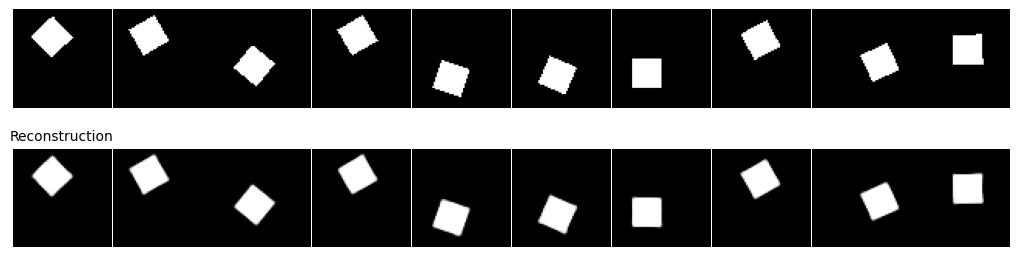

Plotting reconstructions from specific indices...


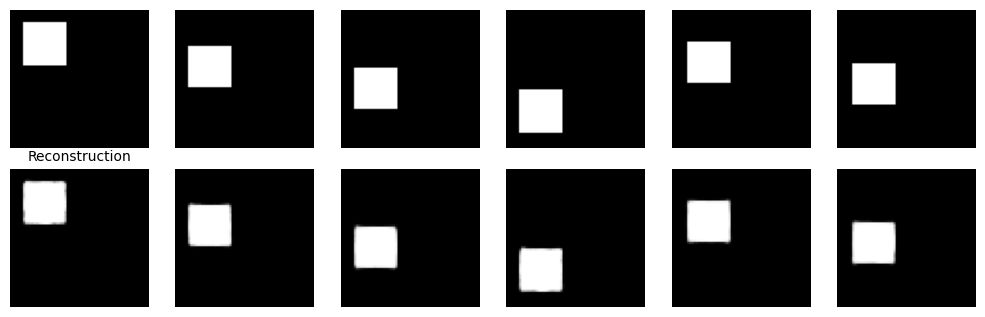

In [11]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


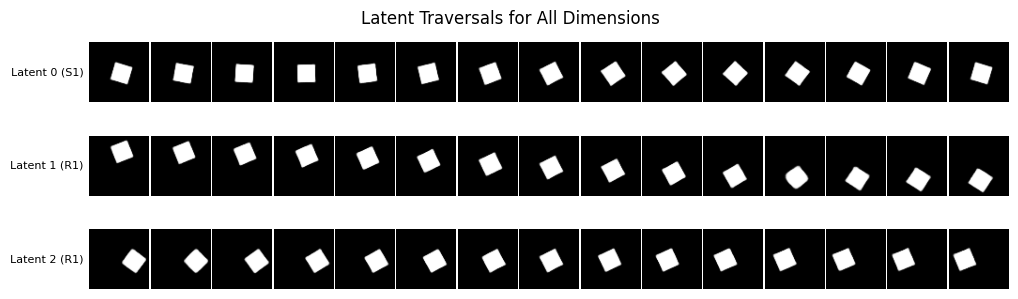

In [12]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

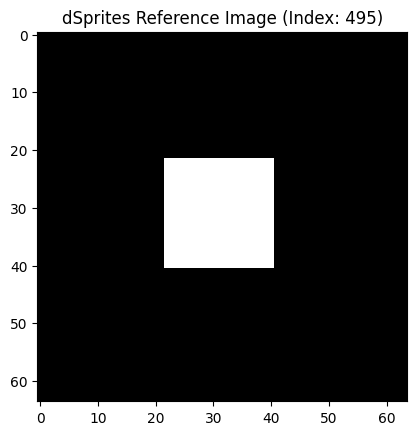

In [13]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


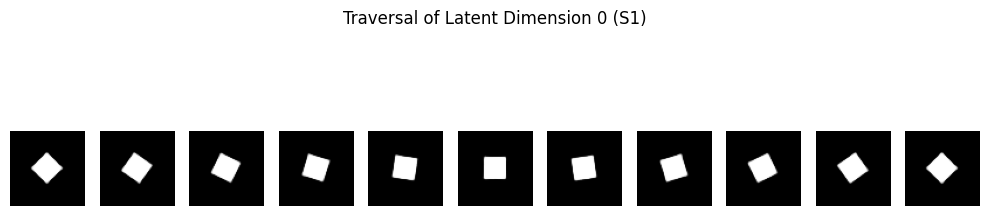

In [14]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


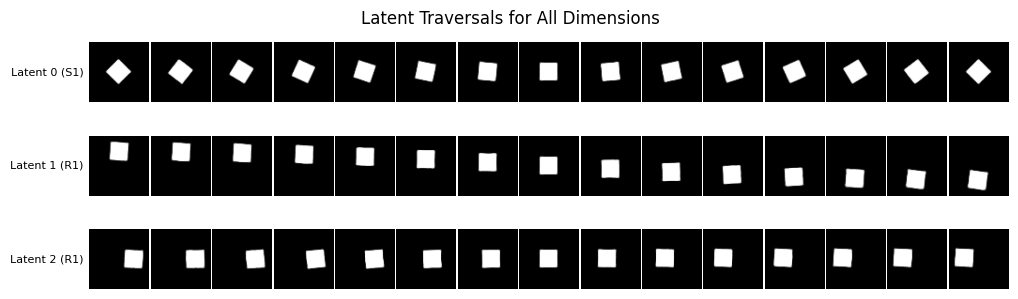

In [15]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )